In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data_filtre.csv',sep='\t')

In [3]:
pd.set_option('display.max_column',100)

In [4]:
data

BuildingType PrimaryPropertyType  CouncilDistrictCode  \
0         NonResidential               Hotel                    7   
1         NonResidential               Hotel                    7   
2         NonResidential               Hotel                    7   
3         NonResidential               Hotel                    7   
4         NonResidential               Hotel                    7   
...                  ...                 ...                  ...   
1529  Nonresidential COS               Other                    1   
1530  Nonresidential COS               Other                    2   
1531  Nonresidential COS               Other                    7   
1532  Nonresidential COS  Mixed Use Property                    1   
1533  Nonresidential COS  Mixed Use Property                    2   

                Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0                   DOWNTOWN  1920-1929                1.0              12   
1                   DOWNTOWN  1990-1999                1.0              11   
2                   DOWNTOWN  1960-1969                1.0              41   
3                   DOWNTOWN  1920-1929                1.0              10   
4                   DOWNTOWN  1980-1989                1.0              18   
...                      ...        ...                ...             ...   
1529  DELRIDGE NEIGHBORHOODS  1980-1989                1.0               1   
1530                DOWNTOWN  2000-2009                1.0               1   
1531   MAGNOLIA / QUEEN ANNE  1970-1979                1.0               1   
1532        GREATER DUWAMISH  1980-1989                1.0               1   
1533        GREATER DUWAMISH  1930-1939                1.0               1   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
1               103566               15064                   88502   
2               956110              196718                  759392   
3                61320                   0                   61320   
4               175580               62000                  113580   
...                ...                 ...                     ...   
1529             18261                   0                   18261   
1530             16000                   0                   16000   
1531             13157                   0                   13157   
1532             14101                   0                   14101   
1533             18258                   0                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
1529                                 Other - Recreation   
1530                                 Other - Recreation   
1531  Fitness Center/Health Club/Gym, Other - Recrea...   
1532  Fitness Center/Health Club/Gym, Food Service, ...   
1533  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
4                     Hotel                   123445.0   
...                     ...                        ...   
1529     Other - Recreation                    18261.0   
1530     Other - Recreation                    16000.0   
1531     Other - Recreation                     7583.0   
1532     Other - Recreation                     6601.0   
1533     Other - Recreation                     8271.0   


# Prédictions TotalGHGEmissions
L'objectif est de prédire la valeur de TotalGHGEmissions


## <a href="#1"> Features engineering
- <a href="#1a"> **Proportion des activités** :
    
    à partir de la superficie des activités, je calcule les proportions de chaque activité du site en fonction de la superficie totale 

    
- <a href="#1b"> **Proportion des sources d'énergie** :
    
    à partir des différentes sources d'énergie, je calcule la proportion de chaque source en fonction de la consommation totale
   
## <a href="#2"> Sélection des features et de la cible
   
    séparation des features en fonction de leur type

## <a href="#3"> Séparation des jeux d'entrainement et de test

## <a href="#4"> Baseline : dummy regressor

## <a href="#5"> Premiers modèles
    
    je vais tester plusieurs modèles en prenant les hyperparamètres de base
    
- <a href="#5a"> **Encodage et normalisation** 
    
    utilisation de StandardScaler et de OneHotEncoder
    
    
- <a href="#5b"> **Estimateurs à tester**
    
    
- <a href="#5c"> **Evaluation**
    
## <a href="#6"> **Optimisation des modèles**
- <a href="#6a"> **Encodage et normalisation**
- <a href="#6b"> **GradientBoost** 
    
    - hyperparamètres
    - GridSearchCV
    - Fine tuning
    - Sélection des transformers
    - Learning curve
    - Feature importance
- <a href="#6c"> **RandomForest**
- <a href="#6d"> **CatBoost**
- <a href="#6e"> **Lasso**

    
## <a href="#7"> Influence de l'EnergyStarScore

    
## <a href="#8"> Résultats finaux
    
## <a href="#9"> Valeurs Shap

    
    
    

# <a name="1"> Features engineering

### <a name="1a"> Proportion des activités 
Je vais créer autant de colonnes que d'activités et indiquer le pourcentage de cette activité pour chaque site

In [5]:
# regroupement de toutes les activités des batiments

activites = np.concatenate((data['LargestPropertyUseType'].dropna().unique() , data['SecondLargestPropertyUseType'].dropna().unique() , data['ThirdLargestPropertyUseType'].dropna().unique()),axis=None)

In [6]:
# création de chaque colonne activité et initialisation à 0

for i in activites :
    data[i] = 0

In [7]:
# Implémentation des utilisations en pourcentage avec une valeur max à 100

for u in activites :
    data.loc[data['LargestPropertyUseType']==u,u] = round(data['LargestPropertyUseTypeGFA']/data['PropertyGFATotal'],2)*100
    data.loc[data['SecondLargestPropertyUseType']==u,u] =  round(data['SecondLargestPropertyUseTypeGFA']/data['PropertyGFATotal'],2)*100
    data.loc[data['ThirdLargestPropertyUseType']==u,u] =  round(data['ThirdLargestPropertyUseTypeGFA']/data['PropertyGFATotal'],2)*100

In [8]:
# Suppression des variables devenues inutiles

var_sup = ['ListOfAllPropertyUseTypes','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
           'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']
data.drop(var_sup,axis=1,inplace=True)

In [9]:
# Verification qu'aucune activite ne dépasse les 100%

for u in activites :
    display(data.loc[data[u]>100,:])

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, Hotel, Police Station, Other - Entertainment/Public Assembly, Library, Fitness Center/Health Club/Gym, Social/Meeting Hall, Courthouse, Other, College/University, Automobile Dealership, Office, Self-Storage Facility, Non-Refrigerated Warehouse, K-12 School, Other - Mall, Senior Care Community, Medical Office, Retail Store, Hospital (General Medical & Surgical), Museum, Repair Services (Vehicle, Shoe, Locksmith, etc), Other - Lodging/Residential, Residence Hall/Dormitory, Other/Specialty Hospital, Financial Office, Distribution Center, Parking, Multifamily Housing, Worship Facility, Restaurant, Data Center, Laboratory, Supermarket/Grocery Store, Urgent Care/Clinic/Other Outpatient, Other - Services, Strip Mall, Wholesale Club/Supercenter, Refrigerated Warehouse, Manufacturing/Industrial Plant, Other - Recreation, Lifestyle Center, Other - Public Services, Fire Station, Performing Arts, Residential Care Facility, Bank Branch, Other - Education, Other - Restaurant/Bar, Food Service, Adult Education, Other - Utility, Movie Theater, Personal Services (Health/Beauty, Dry Cleaning, etc), Pre-school/Daycare, Prison/Incarceration, Vocational School, Swimming Pool, Convenience Store without Gas Station, Enclosed Mall, Bar/Nightclub, Food Sales, Other - Technology/Science, Fast Food Restaurant]
Index: []

### <a name="1b"> Proportion des sources d'énergie
Je vais créer 3 colonnes qui indiquent le pourcentage de la source d'énergie

In [10]:
# Je ne vais pas utiliser ce code à cause du data leakage

data['SteamUse(%)'] = data['SteamUse(kBtu)']/data['SiteEnergyUse(kBtu)']*100
data['Electricity(%)'] = data['Electricity(kBtu)']/data['SiteEnergyUse(kBtu)']*100
data['NaturalGas(%)'] = data['NaturalGas(kBtu)']/data['SiteEnergyUse(kBtu)']*100

In [11]:
# je supprime les variables de consommation (data leakage)

data = data.drop(['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)'],axis=1)

In [12]:
data

BuildingType PrimaryPropertyType  CouncilDistrictCode  \
0         NonResidential               Hotel                    7   
1         NonResidential               Hotel                    7   
2         NonResidential               Hotel                    7   
3         NonResidential               Hotel                    7   
4         NonResidential               Hotel                    7   
...                  ...                 ...                  ...   
1529  Nonresidential COS               Other                    1   
1530  Nonresidential COS               Other                    2   
1531  Nonresidential COS               Other                    7   
1532  Nonresidential COS  Mixed Use Property                    1   
1533  Nonresidential COS  Mixed Use Property                    2   

                Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0                   DOWNTOWN  1920-1929                1.0              12   
1                   DOWNTOWN  1990-1999                1.0              11   
2                   DOWNTOWN  1960-1969                1.0              41   
3                   DOWNTOWN  1920-1929                1.0              10   
4                   DOWNTOWN  1980-1989                1.0              18   
...                      ...        ...                ...             ...   
1529  DELRIDGE NEIGHBORHOODS  1980-1989                1.0               1   
1530                DOWNTOWN  2000-2009                1.0               1   
1531   MAGNOLIA / QUEEN ANNE  1970-1979                1.0               1   
1532        GREATER DUWAMISH  1980-1989                1.0               1   
1533        GREATER DUWAMISH  1930-1939                1.0               1   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
1               103566               15064                   88502   
2               956110              196718                  759392   
3                61320                   0                   61320   
4               175580               62000                  113580   
...                ...                 ...                     ...   
1529             18261                   0                   18261   
1530             16000                   0                   16000   
1531             13157                   0                   13157   
1532             14101                   0                   14101   
1533             18258                   0                   18258   

      ENERGYSTARScore  SiteEnergyUse(kBtu)  TotalGHGEmissions  Hotel  \
0                60.0         7.226362e+06             249.98  100.0   
1                61.0         8.387933e+06             295.86   81.0   
2                43.0         7.258702e+07            2089.28   79.0   
3                56.0         6.794584e+06             286.43  100.0   
4                75.0         1.417261e+07             505.01   70.0   
...               ...                  ...                ...    ...   
1529              NaN         9.320821e+05              20.33    0.0   
1530              NaN         9.502762e+05              32.17    0.0   
1531              NaN         5.765898e+06             223.54    0.0   
1532              NaN         7.194712e+05              22.11    0.0   
1533              NaN         1.152896e+06              41.27    0.0   

      Police Station  Other - Entertainment/Public Assembly  Library  \
0                  0                                    0.0        0   
1                  0                                    0.0        0   
2                  0                                    0.0        0   
3                  0                                    0.0        0   
4                  0                                    0.0        0   
...              ...                                    ...      ...   
1529               0                

# <a name="2"> Sélection des features et de la cible

In [13]:
data.select_dtypes('object').columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt'], dtype='object')

In [14]:
data.select_dtypes('int').columns

Index(['CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'Police Station',
       'Library', 'Courthouse', 'College/University', 'Automobile Dealership',
       'Other - Mall', 'Hospital (General Medical & Surgical)', 'Museum',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office', 'Laboratory',
       'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient',
       'Strip Mall', 'Wholesale Club/Supercenter', 'Refrigerated Warehouse',
       'Manufacturing/Industrial Plant', 'Lifestyle Center',
       'Other - Public Services', 'Fire Station', 'Residential Care Facility',
       'Other - Utility', 'Movie Theater',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Prison/Incarceration', 'Vocational School', 'Swimming Pool',
       'Convenience Store without Gas Station', 'Enclosed Mall',
       'Bar/Nightclub', 'Food Sales', '

In [15]:
data.select_dtypes('float').columns

Index(['NumberofBuildings', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'Hotel', 'Other - Entertainment/Public Assembly',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Other',
       'Office', 'Self-Storage Facility', 'Non-Refrigerated Warehouse',
       'K-12 School', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Distribution Center', 'Parking', 'Multifamily Housing',
       'Worship Facility', 'Restaurant', 'Data Center', 'Other - Services',
       'Other - Recreation', 'Performing Arts', 'Bank Branch',
       'Other - Education', 'Other - Restaurant/Bar', 'Food Service',
       'Adult Education', 'Pre-school/Daycare', 'SteamUse(%)',
       'Electricity(%)', 'NaturalGas(%)'],
      dtype='object')

In [16]:
features_cat = data.select_dtypes('object').columns.tolist()
features_ord = ['NumberofBuildings','NumberofFloors','CouncilDistrictCode']
features_num = data.select_dtypes(['int','float']).columns.drop(['NumberofBuildings','NumberofFloors','CouncilDistrictCode',
                                                                'ENERGYSTARScore','SiteEnergyUse(kBtu)','TotalGHGEmissions']).tolist()

X = data[features_cat + features_ord + features_num]
y = data['TotalGHGEmissions']

In [17]:
features_num

['PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'Hotel',
 'Police Station',
 'Other - Entertainment/Public Assembly',
 'Library',
 'Fitness Center/Health Club/Gym',
 'Social/Meeting Hall',
 'Courthouse',
 'Other',
 'College/University',
 'Automobile Dealership',
 'Office',
 'Self-Storage Facility',
 'Non-Refrigerated Warehouse',
 'K-12 School',
 'Other - Mall',
 'Senior Care Community',
 'Medical Office',
 'Retail Store',
 'Hospital (General Medical & Surgical)',
 'Museum',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Other - Lodging/Residential',
 'Residence Hall/Dormitory',
 'Other/Specialty Hospital',
 'Financial Office',
 'Distribution Center',
 'Parking',
 'Multifamily Housing',
 'Worship Facility',
 'Restaurant',
 'Data Center',
 'Laboratory',
 'Supermarket/Grocery Store',
 'Urgent Care/Clinic/Other Outpatient',
 'Other - Services',
 'Strip Mall',
 'Wholesale Club/Supercenter',
 'Refrigerated Warehouse',
 'Manufacturing/Industrial Plant',
 'Other 

# <a name="3"> Séparation des jeux d'entrainement et de test

In [18]:
X_train , X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=0)

# <a name="4"> Baseline : dummy regressor

In [19]:
# choix du traitement

preprocessor = make_column_transformer((StandardScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),remainder = 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['PropertyGFATotal', 'PropertyGFAParking',
                                  'PropertyGFABuilding(s)', 'Hotel',
                                  'Police Station',
                                  'Other - Entertainment/Public Assembly',
                                  'Library', 'Fitness Center/Health Club/Gym',
                                  'Social/Meeting Hall', 'Courthouse', 'Other',
                                  'College/University', 'Automobile Dealership',
                                  'Offi...
                                  'Hospital (General Medical & Surgical)',
                                  'Museum',
                                  'Repair Services (Vehicle, Shoe, Locksmith, '
                                  'etc)',
                                  'Other - Lodging/Residential',
                                  'Residence Hall/Dormitory',
                                  'Other/Specialty Hospital',
                                  'Financial Office', 'Distribution Center',
                                  'Parking', ...]),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'Neighborhood', 'YearBuilt'])])

In [20]:
dum_reg = DummyRegressor(strategy = 'mean')

model = make_pipeline(preprocessor, dum_reg)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'Hotel', 'Police Station',
                                                   'Other - '
                                                   'Entertainment/Public '
                                                   'Assembly',
                                                   'Library',
                                                   'Fitness Center/Health '
                                                   'Club/Gym',
                                                   'Social/Meeting Hall',
                                                   'Courthouse', 'Other',
                                                   'Colle...
                                                   'Repair Services (Vehicle, '
                                                   'Shoe, Locksmith, etc)',
                                                   'Other - '
                                                   'Lodging/Residential',
                                                   'Residence Hall/Dormitory',
                                                   'Other/Specialty Hospital',
                                                   'Financial Office',
                                                   'Distribution Center',
                                                   'Parking', ...]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'YearBuilt'])])),
                ('dummyregressor', DummyRegressor())])

In [21]:
# scores sur le train set

X_train_pred = dum_reg.predict(X_train)
print('Scores sur le train set :')
print('R2 = ',dum_reg.score(X_train,y_train))
print(f"RMSE : {np.sqrt(metrics.mean_squared_error(y_train,X_train_pred))}")
print('Mean Absolute Error = ',metrics.mean_absolute_error(y_train,X_train_pred))
print('Median Absolute Error = ',metrics.median_absolute_error(y_train,X_train_pred))

Scores sur le train set :
R2 =  0.0
RMSE : 396.2285023141749
Mean Absolute Error =  170.45998938579066
Median Absolute Error =  123.23406682966585


In [22]:
# scores sur le test set

y_pred = dum_reg.predict(X_test)

scores_dummy = {'preprocessor' : 'StandardScaler et OneHotEncoder', 'R2 test' : round(model.score(X_test,y_test),3),
                'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_dummy

{'preprocessor': 'StandardScaler et OneHotEncoder',
 'R2 test': -0.0,
 'RMSE': 267,
 'Mean AE': 157,
 'Median AE': 121}

# <a name="5"> Premiers modèles

## <a name="5a"> Encodage et normalisation

In [23]:
preprocessor = make_column_transformer((StandardScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                       remainder = 'passthrough')      


## <a name="5b"> Estimateurs à tester

In [24]:
est1 = neighbors.KNeighborsRegressor()
est2 = SGDRegressor(random_state = 0)
est3 = Ridge(random_state = 0)
est4 = Lasso(random_state = 0)
est5 = DecisionTreeRegressor(random_state = 0)
est6 = RandomForestRegressor(random_state = 0)
est7 = SVR()
est8 = CatBoostRegressor(random_state = 0)
est9 = GradientBoostingRegressor(random_state = 0)
est10 = ExtraTreesRegressor(random_state = 0)

models = {'KNN' : est1, 'SGDR' : est2, 'Ridge' : est3, 'Lasso' : est4, 'DecisionTree' : est5,
          'RandomForest' : est6, 'SVR' : est7,'Catboost' : est8, 'GradientBoost' : est9,'ExtraTree' : est10}

## <a name="5c"> Evaluation

In [25]:
X_train_nrm = preprocessor.fit_transform(X_train)
X_test_nrm = preprocessor.fit_transform(X_test)

In [26]:
%%time

resultats = {}
resultats_train = []
resultats_validation = []

for cle, esti in models.items() :
    resultats[cle] = (cross_validate(esti, X_train_nrm, y_train, cv=5, scoring = 'r2',return_train_score = True,error_score='raise'))
    resultats_train.append(resultats[cle]['train_score'].mean())
    resultats_validation.append(resultats[cle]['test_score'].mean())

Learning rate set to 0.040819
0:	learn: 415.5335760	total: 135ms	remaining: 2m 14s
1:	learn: 407.8324455	total: 136ms	remaining: 1m 7s
2:	learn: 401.0025624	total: 138ms	remaining: 45.7s
3:	learn: 395.7224273	total: 139ms	remaining: 34.6s
4:	learn: 389.5891123	total: 140ms	remaining: 27.9s
5:	learn: 383.5800971	total: 142ms	remaining: 23.5s
6:	learn: 375.7912647	total: 143ms	remaining: 20.3s
7:	learn: 370.4570475	total: 144ms	remaining: 17.9s
8:	learn: 364.2263922	total: 146ms	remaining: 16s
9:	learn: 358.4684814	total: 147ms	remaining: 14.6s
10:	learn: 353.2636616	total: 148ms	remaining: 13.3s
11:	learn: 349.2555021	total: 150ms	remaining: 12.3s
12:	learn: 343.8993989	total: 151ms	remaining: 11.5s
13:	learn: 339.0538158	total: 153ms	remaining: 10.7s
14:	learn: 334.7359230	total: 154ms	remaining: 10.1s
15:	learn: 329.9840270	total: 155ms	remaining: 9.55s
16:	learn: 325.4044965	total: 157ms	remaining: 9.05s
17:	learn: 320.6124675	total: 158ms	remaining: 8.61s
18:	learn: 316.0342076	tota

184:	learn: 107.7957970	total: 384ms	remaining: 1.69s
185:	learn: 107.5176406	total: 385ms	remaining: 1.69s
186:	learn: 107.2176241	total: 387ms	remaining: 1.68s
187:	learn: 106.9182203	total: 388ms	remaining: 1.68s
188:	learn: 106.6497459	total: 389ms	remaining: 1.67s
189:	learn: 106.3055240	total: 391ms	remaining: 1.67s
190:	learn: 105.7312353	total: 392ms	remaining: 1.66s
191:	learn: 105.2997790	total: 393ms	remaining: 1.66s
192:	learn: 104.6839709	total: 395ms	remaining: 1.65s
193:	learn: 104.0613691	total: 397ms	remaining: 1.65s
194:	learn: 103.8570807	total: 398ms	remaining: 1.64s
195:	learn: 103.2807045	total: 399ms	remaining: 1.64s
196:	learn: 102.9169278	total: 401ms	remaining: 1.63s
197:	learn: 102.3391123	total: 402ms	remaining: 1.63s
198:	learn: 101.9313744	total: 403ms	remaining: 1.62s
199:	learn: 101.7137136	total: 405ms	remaining: 1.62s
200:	learn: 101.4175535	total: 406ms	remaining: 1.61s
201:	learn: 101.1189818	total: 407ms	remaining: 1.61s
202:	learn: 100.7331274	tota

480:	learn: 54.9322097	total: 775ms	remaining: 837ms
481:	learn: 54.8629005	total: 777ms	remaining: 835ms
482:	learn: 54.7543571	total: 778ms	remaining: 833ms
483:	learn: 54.5901905	total: 780ms	remaining: 831ms
484:	learn: 54.4562538	total: 781ms	remaining: 829ms
485:	learn: 54.4437644	total: 782ms	remaining: 828ms
486:	learn: 54.4315425	total: 784ms	remaining: 826ms
487:	learn: 54.4135277	total: 785ms	remaining: 824ms
488:	learn: 54.3239851	total: 787ms	remaining: 822ms
489:	learn: 54.3105280	total: 788ms	remaining: 820ms
490:	learn: 54.1777411	total: 789ms	remaining: 818ms
491:	learn: 54.0772330	total: 791ms	remaining: 816ms
492:	learn: 53.9737814	total: 792ms	remaining: 814ms
493:	learn: 53.9180073	total: 793ms	remaining: 812ms
494:	learn: 53.8237702	total: 794ms	remaining: 811ms
495:	learn: 53.7036964	total: 796ms	remaining: 809ms
496:	learn: 53.6348650	total: 797ms	remaining: 807ms
497:	learn: 53.5648148	total: 798ms	remaining: 805ms
498:	learn: 53.4775035	total: 800ms	remaining:

772:	learn: 37.6006539	total: 1.17s	remaining: 344ms
773:	learn: 37.5749894	total: 1.17s	remaining: 343ms
774:	learn: 37.5282415	total: 1.18s	remaining: 341ms
775:	learn: 37.5027962	total: 1.18s	remaining: 340ms
776:	learn: 37.4582210	total: 1.18s	remaining: 338ms
777:	learn: 37.3988131	total: 1.18s	remaining: 337ms
778:	learn: 37.3482577	total: 1.18s	remaining: 335ms
779:	learn: 37.2732105	total: 1.18s	remaining: 334ms
780:	learn: 37.1745055	total: 1.18s	remaining: 332ms
781:	learn: 37.0869065	total: 1.19s	remaining: 330ms
782:	learn: 37.0348090	total: 1.19s	remaining: 329ms
783:	learn: 37.0294778	total: 1.19s	remaining: 327ms
784:	learn: 37.0132995	total: 1.19s	remaining: 326ms
785:	learn: 36.9955192	total: 1.19s	remaining: 324ms
786:	learn: 36.9551148	total: 1.19s	remaining: 323ms
787:	learn: 36.8874678	total: 1.19s	remaining: 321ms
788:	learn: 36.8356943	total: 1.19s	remaining: 319ms
789:	learn: 36.7840053	total: 1.2s	remaining: 318ms
790:	learn: 36.7611930	total: 1.2s	remaining: 3

4:	learn: 324.2045783	total: 6.79ms	remaining: 1.35s
5:	learn: 317.6086080	total: 8.14ms	remaining: 1.35s
6:	learn: 311.0361403	total: 9.71ms	remaining: 1.38s
7:	learn: 305.3944632	total: 11ms	remaining: 1.36s
8:	learn: 299.7318891	total: 12.4ms	remaining: 1.36s
9:	learn: 294.8552073	total: 13.7ms	remaining: 1.36s
10:	learn: 290.4587323	total: 15.1ms	remaining: 1.35s
11:	learn: 284.8335588	total: 16.4ms	remaining: 1.35s
12:	learn: 280.7579626	total: 17.6ms	remaining: 1.34s
13:	learn: 275.9720767	total: 18.9ms	remaining: 1.33s
14:	learn: 271.6329033	total: 20.1ms	remaining: 1.32s
15:	learn: 266.2684616	total: 21.4ms	remaining: 1.32s
16:	learn: 261.2268758	total: 22.7ms	remaining: 1.31s
17:	learn: 257.2121995	total: 24ms	remaining: 1.31s
18:	learn: 252.8590740	total: 25.2ms	remaining: 1.3s
19:	learn: 248.6877057	total: 26.5ms	remaining: 1.3s
20:	learn: 245.0194742	total: 27.7ms	remaining: 1.29s
21:	learn: 240.7218279	total: 29.1ms	remaining: 1.29s
22:	learn: 236.3373456	total: 30.3ms	rem

318:	learn: 61.0277757	total: 401ms	remaining: 856ms
319:	learn: 60.8299821	total: 402ms	remaining: 855ms
320:	learn: 60.7902771	total: 403ms	remaining: 853ms
321:	learn: 60.7529798	total: 404ms	remaining: 851ms
322:	learn: 60.6313752	total: 406ms	remaining: 850ms
323:	learn: 60.5866041	total: 407ms	remaining: 849ms
324:	learn: 60.3590183	total: 408ms	remaining: 847ms
325:	learn: 60.1242757	total: 409ms	remaining: 845ms
326:	learn: 59.9454260	total: 410ms	remaining: 844ms
327:	learn: 59.8174585	total: 411ms	remaining: 843ms
328:	learn: 59.7429058	total: 413ms	remaining: 841ms
329:	learn: 59.6663757	total: 414ms	remaining: 840ms
330:	learn: 59.5118759	total: 415ms	remaining: 839ms
331:	learn: 59.3816246	total: 416ms	remaining: 837ms
332:	learn: 59.1836365	total: 417ms	remaining: 836ms
333:	learn: 59.0122188	total: 418ms	remaining: 834ms
334:	learn: 58.9541440	total: 419ms	remaining: 832ms
335:	learn: 58.8154572	total: 420ms	remaining: 831ms
336:	learn: 58.6224908	total: 421ms	remaining:

481:	learn: 45.8672176	total: 592ms	remaining: 636ms
482:	learn: 45.8123947	total: 593ms	remaining: 635ms
483:	learn: 45.7201185	total: 594ms	remaining: 634ms
484:	learn: 45.6545852	total: 596ms	remaining: 633ms
485:	learn: 45.5935738	total: 597ms	remaining: 631ms
486:	learn: 45.4998911	total: 598ms	remaining: 630ms
487:	learn: 45.4386238	total: 599ms	remaining: 629ms
488:	learn: 45.4247440	total: 601ms	remaining: 628ms
489:	learn: 45.3365163	total: 602ms	remaining: 627ms
490:	learn: 45.3216529	total: 603ms	remaining: 625ms
491:	learn: 45.2003356	total: 605ms	remaining: 624ms
492:	learn: 45.0915451	total: 606ms	remaining: 623ms
493:	learn: 45.0107954	total: 607ms	remaining: 622ms
494:	learn: 44.9609500	total: 608ms	remaining: 621ms
495:	learn: 44.8770071	total: 609ms	remaining: 619ms
496:	learn: 44.8287938	total: 611ms	remaining: 618ms
497:	learn: 44.8129816	total: 612ms	remaining: 617ms
498:	learn: 44.7724933	total: 613ms	remaining: 616ms
499:	learn: 44.7586336	total: 615ms	remaining:

780:	learn: 32.4236180	total: 975ms	remaining: 273ms
781:	learn: 32.4168819	total: 976ms	remaining: 272ms
782:	learn: 32.3818609	total: 977ms	remaining: 271ms
783:	learn: 32.3247531	total: 979ms	remaining: 270ms
784:	learn: 32.2965806	total: 980ms	remaining: 268ms
785:	learn: 32.2866324	total: 981ms	remaining: 267ms
786:	learn: 32.2316826	total: 982ms	remaining: 266ms
787:	learn: 32.2244997	total: 983ms	remaining: 265ms
788:	learn: 32.1880737	total: 985ms	remaining: 263ms
789:	learn: 32.1720004	total: 986ms	remaining: 262ms
790:	learn: 32.1622132	total: 987ms	remaining: 261ms
791:	learn: 32.1427825	total: 988ms	remaining: 260ms
792:	learn: 32.0983489	total: 990ms	remaining: 258ms
793:	learn: 32.0500221	total: 991ms	remaining: 257ms
794:	learn: 32.0321209	total: 992ms	remaining: 256ms
795:	learn: 31.9622180	total: 994ms	remaining: 255ms
796:	learn: 31.9278887	total: 995ms	remaining: 253ms
797:	learn: 31.9082972	total: 996ms	remaining: 252ms
798:	learn: 31.9017085	total: 997ms	remaining:

1:	learn: 384.8245063	total: 14.4ms	remaining: 7.17s
2:	learn: 378.3044364	total: 15.9ms	remaining: 5.27s
3:	learn: 371.8807712	total: 17.4ms	remaining: 4.32s
4:	learn: 366.0274691	total: 18.6ms	remaining: 3.71s
5:	learn: 361.0324478	total: 19.9ms	remaining: 3.3s
6:	learn: 354.6545408	total: 21.1ms	remaining: 3s
7:	learn: 348.6885678	total: 22.4ms	remaining: 2.78s
8:	learn: 343.5402094	total: 23.6ms	remaining: 2.6s
9:	learn: 338.2461539	total: 25ms	remaining: 2.47s
10:	learn: 334.5835757	total: 26.2ms	remaining: 2.36s
11:	learn: 329.7253465	total: 27.4ms	remaining: 2.26s
12:	learn: 325.3553586	total: 28.7ms	remaining: 2.18s
13:	learn: 321.0951053	total: 30ms	remaining: 2.11s
14:	learn: 316.9610670	total: 31.2ms	remaining: 2.05s
15:	learn: 312.3747732	total: 32.5ms	remaining: 2s
16:	learn: 308.4605799	total: 33.8ms	remaining: 1.95s
17:	learn: 305.5077707	total: 35ms	remaining: 1.91s
18:	learn: 302.0564533	total: 36.3ms	remaining: 1.87s
19:	learn: 298.8293057	total: 37.5ms	remaining: 1.8

164:	learn: 119.3817260	total: 217ms	remaining: 1.1s
165:	learn: 118.7781634	total: 218ms	remaining: 1.09s
166:	learn: 118.4380119	total: 219ms	remaining: 1.09s
167:	learn: 117.6634292	total: 220ms	remaining: 1.09s
168:	learn: 117.0630039	total: 222ms	remaining: 1.09s
169:	learn: 116.4392551	total: 223ms	remaining: 1.09s
170:	learn: 116.1411620	total: 224ms	remaining: 1.09s
171:	learn: 115.8574808	total: 225ms	remaining: 1.08s
172:	learn: 115.4293282	total: 226ms	remaining: 1.08s
173:	learn: 115.1330382	total: 228ms	remaining: 1.08s
174:	learn: 114.4230518	total: 229ms	remaining: 1.08s
175:	learn: 114.1110028	total: 230ms	remaining: 1.08s
176:	learn: 113.8488362	total: 232ms	remaining: 1.08s
177:	learn: 113.5098970	total: 233ms	remaining: 1.07s
178:	learn: 113.2411578	total: 234ms	remaining: 1.07s
179:	learn: 112.6707262	total: 235ms	remaining: 1.07s
180:	learn: 112.4392980	total: 237ms	remaining: 1.07s
181:	learn: 111.8664355	total: 238ms	remaining: 1.07s
182:	learn: 111.5443546	total

481:	learn: 57.0417183	total: 600ms	remaining: 645ms
482:	learn: 56.9103656	total: 601ms	remaining: 643ms
483:	learn: 56.8766142	total: 602ms	remaining: 642ms
484:	learn: 56.7781596	total: 604ms	remaining: 641ms
485:	learn: 56.6978688	total: 605ms	remaining: 640ms
486:	learn: 56.6415686	total: 606ms	remaining: 639ms
487:	learn: 56.6270099	total: 607ms	remaining: 637ms
488:	learn: 56.5765378	total: 609ms	remaining: 636ms
489:	learn: 56.3575243	total: 610ms	remaining: 635ms
490:	learn: 56.2543419	total: 611ms	remaining: 634ms
491:	learn: 56.2399091	total: 612ms	remaining: 632ms
492:	learn: 56.1854024	total: 614ms	remaining: 631ms
493:	learn: 56.0623898	total: 615ms	remaining: 630ms
494:	learn: 56.0340901	total: 616ms	remaining: 628ms
495:	learn: 56.0030282	total: 617ms	remaining: 627ms
496:	learn: 55.9016765	total: 618ms	remaining: 626ms
497:	learn: 55.8581388	total: 620ms	remaining: 625ms
498:	learn: 55.7406978	total: 621ms	remaining: 623ms
499:	learn: 55.7130780	total: 622ms	remaining:

788:	learn: 40.1608244	total: 983ms	remaining: 263ms
789:	learn: 40.1032691	total: 985ms	remaining: 262ms
790:	learn: 40.0976737	total: 986ms	remaining: 260ms
791:	learn: 40.0427231	total: 987ms	remaining: 259ms
792:	learn: 40.0192141	total: 988ms	remaining: 258ms
793:	learn: 40.0122731	total: 990ms	remaining: 257ms
794:	learn: 39.9362694	total: 991ms	remaining: 256ms
795:	learn: 39.8876320	total: 992ms	remaining: 254ms
796:	learn: 39.8389936	total: 994ms	remaining: 253ms
797:	learn: 39.7761554	total: 995ms	remaining: 252ms
798:	learn: 39.7574707	total: 998ms	remaining: 251ms
799:	learn: 39.7465748	total: 999ms	remaining: 250ms
800:	learn: 39.7186549	total: 1s	remaining: 249ms
801:	learn: 39.6895737	total: 1s	remaining: 247ms
802:	learn: 39.6173957	total: 1s	remaining: 246ms
803:	learn: 39.5481555	total: 1s	remaining: 245ms
804:	learn: 39.5174651	total: 1s	remaining: 244ms
805:	learn: 39.4764672	total: 1.01s	remaining: 242ms
806:	learn: 39.4020883	total: 1.01s	remaining: 241ms
807:	lea

17:	learn: 303.3281463	total: 23.6ms	remaining: 1.29s
18:	learn: 299.3489516	total: 25ms	remaining: 1.29s
19:	learn: 295.4658341	total: 26.3ms	remaining: 1.29s
20:	learn: 292.4728857	total: 27.7ms	remaining: 1.29s
21:	learn: 288.3243001	total: 29ms	remaining: 1.29s
22:	learn: 286.8449832	total: 30.2ms	remaining: 1.28s
23:	learn: 282.4799790	total: 31.4ms	remaining: 1.28s
24:	learn: 280.2620450	total: 32.6ms	remaining: 1.27s
25:	learn: 277.5646133	total: 34ms	remaining: 1.27s
26:	learn: 274.3642721	total: 35.2ms	remaining: 1.27s
27:	learn: 271.3861116	total: 36.5ms	remaining: 1.27s
28:	learn: 270.2463186	total: 37.8ms	remaining: 1.26s
29:	learn: 267.7963327	total: 39.1ms	remaining: 1.26s
30:	learn: 264.9087914	total: 40.4ms	remaining: 1.26s
31:	learn: 262.8391471	total: 41.7ms	remaining: 1.26s
32:	learn: 260.0590646	total: 43ms	remaining: 1.26s
33:	learn: 257.1698226	total: 44.2ms	remaining: 1.25s
34:	learn: 254.9279556	total: 45.5ms	remaining: 1.25s
35:	learn: 252.8411204	total: 46.8ms

181:	learn: 110.6739790	total: 228ms	remaining: 1.02s
182:	learn: 110.1778265	total: 230ms	remaining: 1.02s
183:	learn: 109.2901454	total: 231ms	remaining: 1.02s
184:	learn: 108.5676218	total: 232ms	remaining: 1.02s
185:	learn: 108.1926719	total: 233ms	remaining: 1.02s
186:	learn: 107.8153391	total: 235ms	remaining: 1.02s
187:	learn: 107.3160404	total: 236ms	remaining: 1.02s
188:	learn: 106.9774252	total: 237ms	remaining: 1.02s
189:	learn: 106.6376139	total: 239ms	remaining: 1.02s
190:	learn: 105.8519198	total: 240ms	remaining: 1.01s
191:	learn: 105.4839135	total: 241ms	remaining: 1.01s
192:	learn: 105.3086395	total: 242ms	remaining: 1.01s
193:	learn: 105.0620642	total: 243ms	remaining: 1.01s
194:	learn: 104.3721465	total: 245ms	remaining: 1.01s
195:	learn: 104.1997687	total: 246ms	remaining: 1.01s
196:	learn: 104.0152687	total: 247ms	remaining: 1.01s
197:	learn: 103.2969459	total: 248ms	remaining: 1.01s
198:	learn: 102.9608832	total: 250ms	remaining: 1s
199:	learn: 102.6600168	total: 

527:	learn: 47.9161590	total: 621ms	remaining: 555ms
528:	learn: 47.8819707	total: 622ms	remaining: 554ms
529:	learn: 47.8035811	total: 623ms	remaining: 553ms
530:	learn: 47.7768357	total: 624ms	remaining: 551ms
531:	learn: 47.7452968	total: 625ms	remaining: 550ms
532:	learn: 47.7180169	total: 626ms	remaining: 549ms
533:	learn: 47.6920608	total: 627ms	remaining: 547ms
534:	learn: 47.6226789	total: 628ms	remaining: 546ms
535:	learn: 47.5973069	total: 629ms	remaining: 545ms
536:	learn: 47.5386541	total: 630ms	remaining: 544ms
537:	learn: 47.4798161	total: 632ms	remaining: 542ms
538:	learn: 47.3349530	total: 633ms	remaining: 541ms
539:	learn: 47.2344686	total: 634ms	remaining: 540ms
540:	learn: 47.0826050	total: 635ms	remaining: 538ms
541:	learn: 47.0491648	total: 636ms	remaining: 537ms
542:	learn: 46.9599401	total: 637ms	remaining: 536ms
543:	learn: 46.8560197	total: 638ms	remaining: 535ms
544:	learn: 46.8109258	total: 639ms	remaining: 533ms
545:	learn: 46.7797438	total: 640ms	remaining:

712:	learn: 37.2370579	total: 815ms	remaining: 328ms
713:	learn: 37.1744794	total: 816ms	remaining: 327ms
714:	learn: 37.1343706	total: 817ms	remaining: 326ms
715:	learn: 37.0659005	total: 818ms	remaining: 325ms
716:	learn: 37.0400714	total: 819ms	remaining: 323ms
717:	learn: 36.9913842	total: 820ms	remaining: 322ms
718:	learn: 36.9327674	total: 821ms	remaining: 321ms
719:	learn: 36.8797934	total: 822ms	remaining: 320ms
720:	learn: 36.8208572	total: 823ms	remaining: 319ms
721:	learn: 36.7580569	total: 824ms	remaining: 317ms
722:	learn: 36.7150767	total: 825ms	remaining: 316ms
723:	learn: 36.6712422	total: 826ms	remaining: 315ms
724:	learn: 36.6147368	total: 827ms	remaining: 314ms
725:	learn: 36.5546616	total: 828ms	remaining: 312ms
726:	learn: 36.4952040	total: 829ms	remaining: 311ms
727:	learn: 36.4391514	total: 830ms	remaining: 310ms
728:	learn: 36.4243760	total: 831ms	remaining: 309ms
729:	learn: 36.3779600	total: 832ms	remaining: 308ms
730:	learn: 36.3709080	total: 833ms	remaining:

907:	learn: 30.0932503	total: 1.01s	remaining: 102ms
908:	learn: 30.0553348	total: 1.01s	remaining: 101ms
909:	learn: 30.0506973	total: 1.01s	remaining: 99.9ms
910:	learn: 30.0176913	total: 1.01s	remaining: 98.8ms
911:	learn: 29.9779438	total: 1.01s	remaining: 97.7ms
912:	learn: 29.9420922	total: 1.01s	remaining: 96.6ms
913:	learn: 29.9371637	total: 1.01s	remaining: 95.5ms
914:	learn: 29.9052341	total: 1.01s	remaining: 94.4ms
915:	learn: 29.8748446	total: 1.02s	remaining: 93.2ms
916:	learn: 29.8497000	total: 1.02s	remaining: 92.1ms
917:	learn: 29.8078441	total: 1.02s	remaining: 91ms
918:	learn: 29.7942457	total: 1.02s	remaining: 89.9ms
919:	learn: 29.7898074	total: 1.02s	remaining: 88.8ms
920:	learn: 29.7501226	total: 1.02s	remaining: 87.7ms
921:	learn: 29.7317969	total: 1.02s	remaining: 86.6ms
922:	learn: 29.7198862	total: 1.02s	remaining: 85.4ms
923:	learn: 29.6826804	total: 1.02s	remaining: 84.3ms
924:	learn: 29.6488098	total: 1.03s	remaining: 83.2ms
925:	learn: 29.5897477	total: 1.

199:	learn: 97.9840238	total: 215ms	remaining: 862ms
200:	learn: 97.6902353	total: 217ms	remaining: 861ms
201:	learn: 97.3051287	total: 218ms	remaining: 860ms
202:	learn: 96.9167685	total: 219ms	remaining: 859ms
203:	learn: 96.5182858	total: 220ms	remaining: 858ms
204:	learn: 96.2540841	total: 221ms	remaining: 857ms
205:	learn: 95.8780450	total: 222ms	remaining: 856ms
206:	learn: 95.3650231	total: 223ms	remaining: 855ms
207:	learn: 95.1355041	total: 224ms	remaining: 853ms
208:	learn: 94.6186223	total: 225ms	remaining: 852ms
209:	learn: 94.0759848	total: 226ms	remaining: 851ms
210:	learn: 93.9520698	total: 227ms	remaining: 850ms
211:	learn: 93.5347411	total: 228ms	remaining: 849ms
212:	learn: 93.2930476	total: 229ms	remaining: 848ms
213:	learn: 93.0195936	total: 230ms	remaining: 847ms
214:	learn: 92.8863712	total: 231ms	remaining: 845ms
215:	learn: 92.7194752	total: 232ms	remaining: 844ms
216:	learn: 92.5163969	total: 234ms	remaining: 843ms
217:	learn: 92.1992414	total: 235ms	remaining:

384:	learn: 63.0748567	total: 408ms	remaining: 652ms
385:	learn: 62.9754095	total: 410ms	remaining: 652ms
386:	learn: 62.8064225	total: 411ms	remaining: 650ms
387:	learn: 62.7478413	total: 412ms	remaining: 649ms
388:	learn: 62.6656486	total: 413ms	remaining: 648ms
389:	learn: 62.6034915	total: 414ms	remaining: 647ms
390:	learn: 62.5441850	total: 415ms	remaining: 646ms
391:	learn: 62.4653995	total: 416ms	remaining: 645ms
392:	learn: 62.4064549	total: 417ms	remaining: 644ms
393:	learn: 62.2243210	total: 418ms	remaining: 643ms
394:	learn: 62.1155148	total: 419ms	remaining: 642ms
395:	learn: 61.9751859	total: 420ms	remaining: 641ms
396:	learn: 61.7814296	total: 421ms	remaining: 640ms
397:	learn: 61.6852121	total: 422ms	remaining: 639ms
398:	learn: 61.5701987	total: 424ms	remaining: 638ms
399:	learn: 61.5173609	total: 425ms	remaining: 638ms
400:	learn: 61.4143216	total: 427ms	remaining: 637ms
401:	learn: 61.3571394	total: 428ms	remaining: 636ms
402:	learn: 61.2731261	total: 429ms	remaining:

564:	learn: 46.9791227	total: 602ms	remaining: 463ms
565:	learn: 46.9442039	total: 603ms	remaining: 462ms
566:	learn: 46.8742120	total: 604ms	remaining: 461ms
567:	learn: 46.8478711	total: 605ms	remaining: 460ms
568:	learn: 46.7509766	total: 606ms	remaining: 459ms
569:	learn: 46.7295988	total: 607ms	remaining: 458ms
570:	learn: 46.6489189	total: 608ms	remaining: 457ms
571:	learn: 46.5382992	total: 609ms	remaining: 456ms
572:	learn: 46.4796848	total: 610ms	remaining: 455ms
573:	learn: 46.3717791	total: 611ms	remaining: 454ms
574:	learn: 46.2535451	total: 612ms	remaining: 453ms
575:	learn: 46.1914924	total: 614ms	remaining: 452ms
576:	learn: 46.1617943	total: 615ms	remaining: 451ms
577:	learn: 46.1189034	total: 616ms	remaining: 450ms
578:	learn: 45.9892989	total: 617ms	remaining: 448ms
579:	learn: 45.9156285	total: 618ms	remaining: 447ms
580:	learn: 45.7855021	total: 619ms	remaining: 446ms
581:	learn: 45.7277489	total: 620ms	remaining: 445ms
582:	learn: 45.6963645	total: 621ms	remaining:

744:	learn: 37.4990783	total: 795ms	remaining: 272ms
745:	learn: 37.4798183	total: 796ms	remaining: 271ms
746:	learn: 37.4655356	total: 797ms	remaining: 270ms
747:	learn: 37.3989751	total: 798ms	remaining: 269ms
748:	learn: 37.3341500	total: 799ms	remaining: 268ms
749:	learn: 37.2592826	total: 800ms	remaining: 267ms
750:	learn: 37.2373743	total: 801ms	remaining: 266ms
751:	learn: 37.1595969	total: 802ms	remaining: 265ms
752:	learn: 37.1304561	total: 803ms	remaining: 263ms
753:	learn: 37.0682666	total: 804ms	remaining: 262ms
754:	learn: 37.0239827	total: 805ms	remaining: 261ms
755:	learn: 36.9920499	total: 806ms	remaining: 260ms
756:	learn: 36.9309314	total: 807ms	remaining: 259ms
757:	learn: 36.8778477	total: 809ms	remaining: 258ms
758:	learn: 36.8668873	total: 810ms	remaining: 257ms
759:	learn: 36.7905725	total: 811ms	remaining: 256ms
760:	learn: 36.7385110	total: 812ms	remaining: 255ms
761:	learn: 36.6882443	total: 813ms	remaining: 254ms
762:	learn: 36.6580143	total: 814ms	remaining:

925:	learn: 30.3612807	total: 988ms	remaining: 79ms
926:	learn: 30.3554331	total: 989ms	remaining: 77.9ms
927:	learn: 30.3293006	total: 991ms	remaining: 76.8ms
928:	learn: 30.2929017	total: 992ms	remaining: 75.8ms
929:	learn: 30.2545348	total: 993ms	remaining: 74.7ms
930:	learn: 30.2116708	total: 994ms	remaining: 73.6ms
931:	learn: 30.1990354	total: 995ms	remaining: 72.6ms
932:	learn: 30.1709573	total: 996ms	remaining: 71.5ms
933:	learn: 30.1616405	total: 997ms	remaining: 70.4ms
934:	learn: 30.1316572	total: 998ms	remaining: 69.4ms
935:	learn: 30.0987196	total: 999ms	remaining: 68.3ms
936:	learn: 30.0368574	total: 1000ms	remaining: 67.2ms
937:	learn: 30.0320085	total: 1s	remaining: 66.1ms
938:	learn: 29.9862609	total: 1s	remaining: 65.1ms
939:	learn: 29.9800007	total: 1s	remaining: 64ms
940:	learn: 29.9420404	total: 1s	remaining: 62.9ms
941:	learn: 29.9016159	total: 1s	remaining: 61.9ms
942:	learn: 29.8635331	total: 1s	remaining: 60.8ms
943:	learn: 29.8000604	total: 1.01s	remaining: 59

In [27]:
scores = pd.DataFrame(data={'noms':models.keys() , 'r2 train_set' : resultats_train,'r2 validation_set' :resultats_validation})
scores

noms  r2 train_set  r2 validation_set
0            KNN      0.557364           0.326363
1           SGDR      0.471018           0.246583
2          Ridge      0.640194           0.253710
3          Lasso      0.631540           0.497684
4   DecisionTree      1.000000           0.447475
5   RandomForest      0.949857           0.660120
6            SVR     -0.030349          -0.035914
7       Catboost      0.994603           0.652033
8  GradientBoost      0.973430           0.601051
9      ExtraTree      1.000000           0.574695

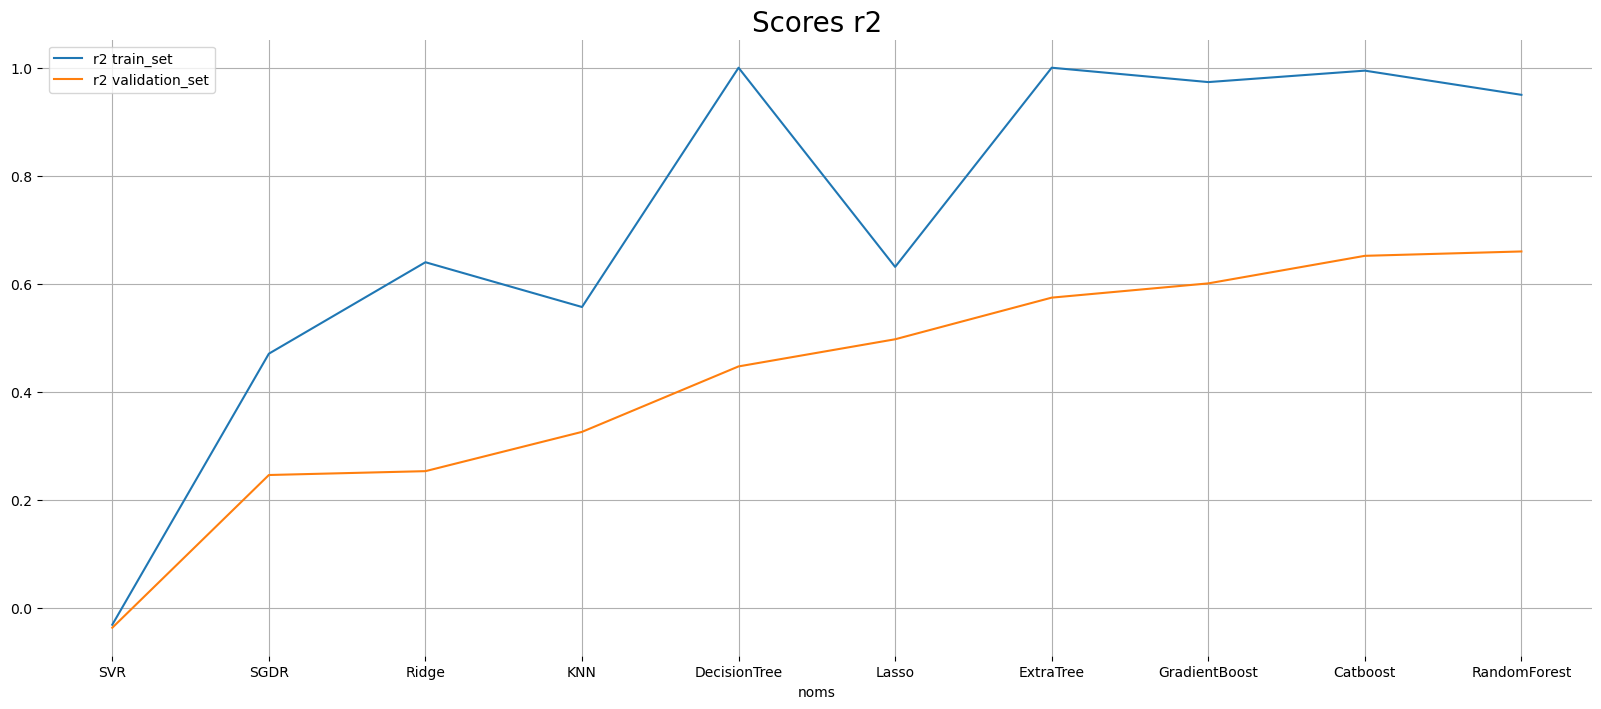

In [28]:
# affichage des scores

scores.sort_values('r2 validation_set',inplace = True)
ax = scores[["r2 train_set","r2 validation_set","noms"]].plot(kind="line", x='noms', figsize=(20,8), title="Scores r2")
ax.legend(["r2 train_set", "r2 validation_set"])

ax.set_xticks(range(len(scores)),scores['noms'])

plt.grid()
ax.title.set_size(20)
plt.box(False)

Certains modèles sont en overfitting.

Il y a un problème avec SVR. Je vais changer les transformers.

In [29]:
preprocessor = make_column_transformer((StandardScaler(), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')
X_train_nrm = preprocessor.fit_transform(X_train,y_train)
resultats = cross_validate(SVR(), X_train_nrm, y_train, cv=5, scoring = 'r2',return_train_score = True,error_score='raise')
resultats

{'fit_time': array([0.03127503, 0.03124499, 0.03169298, 0.04804897, 0.04689527]),
 'score_time': array([0.01562357, 0.02266097, 0.01567245, 0.01503325, 0.01562238]),
 'test_score': array([-0.03086624, -0.03813915, -0.00833894, -0.0275227 , -0.05612802]),
 'train_score': array([-0.02928846, -0.02950136, -0.02926212, -0.02676522, -0.02293078])}

In [30]:
print('résultats sur le train : ',resultats['train_score'].mean())
print('résultats sur le validation : ',resultats['test_score'].mean())


résultats sur le train :  -0.027549586951733884
résultats sur le validation :  -0.03219900974180101


Ce n'est pas mieux.

# <a name="6"> Optimisation des modèles

Regardons de plus près les meilleurs estimateurs

## <a name="6a"> Encodage et normalisation

In [31]:
preprocessor0 = make_column_transformer((StandardScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                        remainder = 'passthrough')

preprocessor1 = make_column_transformer((MinMaxScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                       remainder = 'passthrough')

preprocessor2 = make_column_transformer((RobustScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                       remainder = 'passthrough')

preprocessor3 = make_column_transformer((FunctionTransformer(np.log1p), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                       remainder = 'passthrough')

preprocessor4 = make_column_transformer((StandardScaler(), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')

preprocessor5 = make_column_transformer((MinMaxScaler(), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')

preprocessor6 = make_column_transformer((RobustScaler(), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')

preprocessor7 = make_column_transformer((FunctionTransformer(np.log1p), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')



preprocess = [preprocessor0,preprocessor1,preprocessor2,preprocessor3,preprocessor4,preprocessor5,preprocessor6,preprocessor7]

## <a name="6c"> RandomForest

### Hyperparamètres

In [113]:
params = {'randomforestregressor__n_estimators' : [10,50,100],
          'randomforestregressor__criterion' : ['squared_error','friedman_mse','absolute_error','poisson']}


### GridSearchCV

In [114]:
# Testons les hyperparamètres avec le preprocessor0

model = make_pipeline(preprocessor0, RandomForestRegressor(random_state = 0))

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'randomforestregressor__criterion': ['squared_error',
                                                              'friedman_mse',
                                                              'absolute_error',
                                                              'poisson'],
                         'randomforestregressor__n_estimators': [10, 50, 100]},
             scoring='r2')

In [34]:
grid.best_score_

0.6860227682842428

In [115]:
grid.best_params_

{'randomforestregressor__criterion': 'poisson',
 'randomforestregressor__n_estimators': 100}

In [36]:
best_esti = grid.best_estimator_
best_esti.score(X_test,y_test)

0.6083852705844068

### Fine tuning

Je vais "jouer" sur l'hyperparamètre n_estimators

In [116]:
%%time

params = {'randomforestregressor__n_estimators' : [75,100,500,1000]}
model = make_pipeline(preprocessor0, RandomForestRegressor(random_state = 0,criterion='poisson'))
grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train,y_train)

Wall time: 48 s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                          'Distribution '
                                                                          'Center',
                                                                          'Parking', ...]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(criterion='poisson',
                                                              random_state=0))]),
             param_grid={'randomforestregressor__n_estimators': [75, 100, 500,
                                                                 1000]},
             scoring='r2')

In [38]:
grid.best_score_

0.6493094912218709

In [39]:
grid.best_params_

{'randomforestregressor__n_estimators': 100}

In [40]:
cv_res = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
cv_res

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       0.922429      0.026143         0.009645        0.005853   
0       0.687149      0.011485         0.009785        0.007416   
2       4.512182      0.094373         0.036164        0.006418   
3       8.917934      0.138470         0.063349        0.001257   

  param_randomforestregressor__n_estimators  \
1                                       100   
0                                        75   
2                                       500   
3                                      1000   

                                          params  split0_test_score  \
1   {'randomforestregressor__n_estimators': 100}           0.807462   
0    {'randomforestregressor__n_estimators': 75}           0.803327   
2   {'randomforestregressor__n_estimators': 500}           0.788494   
3  {'randomforestregressor__n_estimators': 1000}           0.787343   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
1           0.466097           0.790341           0.797112           0.385535   
0           0.442125           0.792591           0.772798           0.419818   
2           0.469820           0.806462           0.801451           0.358914   
3           0.466376           0.802458           0.799958           0.354246   

   mean_test_score  std_test_score  rank_test_score  
1         0.649309        0.184332                1  
0         0.646132        0.176092                2  
2         0.645028        0.191661                3  
3         0.642076        0.192597                4

Les scores sont très proches. Je vais garder 100 estimateurs.

### Sélection des transformers

In [117]:
%%time

# Testons tous les preprocessors avec les meilleurs hyperparamètres

res_randfor_train = []
res_randfor_test = []

for prep in preprocess :
    model = make_pipeline(prep, RandomForestRegressor(random_state = 0, criterion='poisson',
                                                      n_estimators= 100))
    model.fit(X_train,y_train)
    res_randfor_train.append(model.score(X_train,y_train))
    res_randfor_test.append(model.score(X_test,y_test))

Wall time: 5.2 s


In [118]:
resultats_finaux_rand_forest = pd.DataFrame(data = {'preprocessor' : range(len(res_randfor_train)),
                                                    'resultats train' : res_randfor_train,
                                                    'resultats test' : res_randfor_test })  
resultats_finaux_rand_forest.sort_values('resultats test', ascending = False)

preprocessor  resultats train  resultats test
5             5         0.938952        0.838581
4             4         0.940979        0.836884
7             7         0.944013        0.831274
6             6         0.938880        0.830852
1             1         0.938931        0.815012
0             0         0.938154        0.797603
2             2         0.935012        0.794661
3             3         0.936916        0.792296

### Meilleur modèle

In [133]:
# scores sur le test set

model_randfor = make_pipeline(preprocessor5,RandomForestRegressor(random_state = 0, criterion='squared_error',n_estimators= 100))
model_randfor.fit(X_train,y_train)
y_pred = model_randfor.predict(X_test)

scores_rand_forest = {'preprocessor' : 'MinMaxScaler et TargetEncoder', 'R2 test' : round(model.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))),
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_rand_forest

{'preprocessor': 'MinMaxScaler et TargetEncoder',
 'R2 test': 0.845,
 'RMSE': 185,
 'Mean AE': 58,
 'Median AE': 14}

### Learning curve

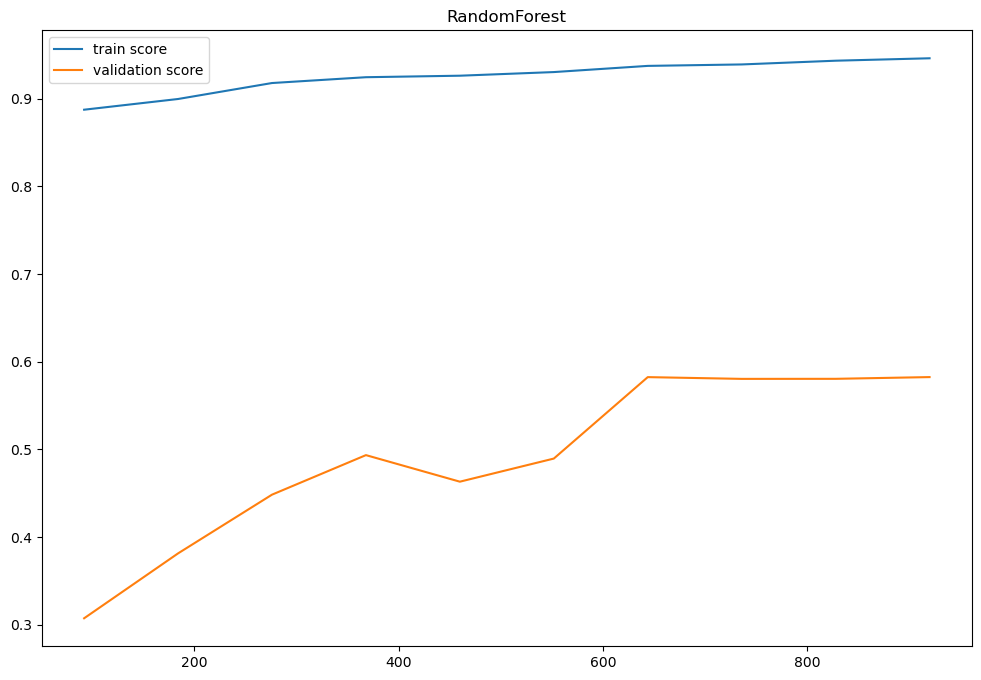

In [44]:

N, train_score, val_score = learning_curve(model_randfor, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title('RandomForest')
plt.legend()

### Feature importance

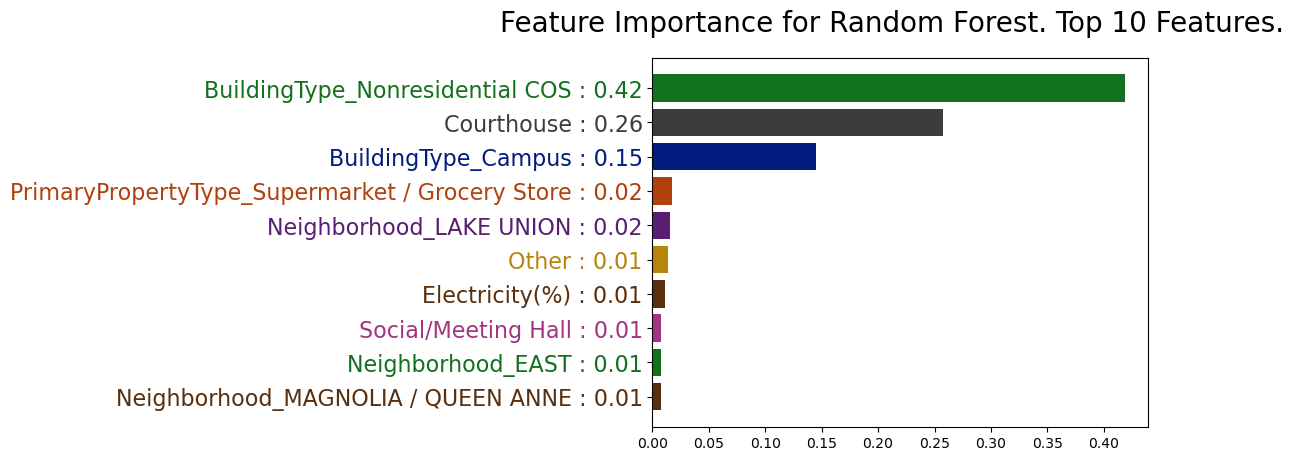

In [45]:
noms_col = preprocessor1.named_transformers_['onehotencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num

color_list =  sns.color_palette("dark", len(noms_col)) 
top_x = 10 # number of x most important features to show

model = RandomForestRegressor(random_state = 0, criterion='poisson',n_estimators= 1000)
X_train_nrm = preprocessor1.fit_transform(X_train,y_train)   
model.fit(X_train_nrm,y_train)

feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)
indices = indices[-top_x:]

plt.barh(range(len(indices)), feature_importance[indices], color= [color_list[indices[i]] for i in range(top_x)],
         align='center')
  
plt.yticks(range(len(indices)), [(noms_col[j] + ' : ' + str(round(feature_importance[j],2))) for j in indices],
           fontweight="normal", fontsize=16) 

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

plt.suptitle("Feature Importance for Random Forest. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
plt.show()

## <a name="6b"> GradientBoost

### Hyperparamètres

In [120]:
params = {'gradientboostingregressor__learning_rate': [0.01,0.1],
          'gradientboostingregressor__subsample'    : [1, 0.1],
          'gradientboostingregressor__n_estimators' : [100,1000],
          'gradientboostingregressor__max_depth'    : [3,10]
         }


### GridSearchCV

In [47]:
%%time

# Testons les hyperparamètres avec le preprocessor0

model = make_pipeline(preprocessor0, GradientBoostingRegressor(random_state = 0))

grid = GridSearchCV(model , params, scoring='r2', cv=5  , error_score='raise')
grid.fit(X_train,y_train)

Wall time: 2min 14s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.01,
                                                                      0.1],
                         'gradientboostingregressor__max_depth': [3, 10],
                         'gradientboostingregressor__n_estimators': [100, 1000],
                         'gradientboostingregressor__subsample': [1, 0.1]},
             scoring='r2')

In [48]:
grid.best_score_

0.6232395851792542

In [49]:
grid.best_params_

{'gradientboostingregressor__learning_rate': 0.01,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__n_estimators': 1000,
 'gradientboostingregressor__subsample': 1}

In [50]:
best_esti = grid.best_estimator_
best_esti.score(X_test,y_test)

0.5579058493538603

### Fine tuning

In [121]:
params = {'gradientboostingregressor__learning_rate': [0.1,1],
          'gradientboostingregressor__subsample'    : [1,0.5],
          'gradientboostingregressor__n_estimators' : [1000],
          'gradientboostingregressor__max_depth'    : [1,3]
         }

In [122]:
%%time

# Testons les hyperparamètres avec le preprocessor0

model = make_pipeline(preprocessor0, GradientBoostingRegressor(random_state = 0))

grid = GridSearchCV(model , params, scoring='r2', cv=5  , error_score='raise')
grid.fit(X_train,y_train)

Wall time: 41.5 s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.1, 1],
                         'gradientboostingregressor__max_depth': [1, 3],
                         'gradientboostingregressor__n_estimators': [1000],
                         'gradientboostingregressor__subsample': [1, 0.5]},
             scoring='r2')

In [53]:
resultats_cv = pd.DataFrame(grid.cv_results_)
resultats_cv.sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       0.157253      0.004077         0.003593        0.000488   
2       0.263352      0.007518         0.001198        0.001468   
0       0.107827      0.003701         0.004632        0.006231   
4       0.108794      0.008262         0.004151        0.005081   
1       0.075421      0.006116         0.006248        0.007653   

  param_gradientboostingregressor__learning_rate  \
3                                            0.1   
2                                            0.1   
0                                            0.1   
4                                              1   
1                                            0.1   

  param_gradientboostingregressor__max_depth  \
3                                          3   
2                                          3   
0                                          1   
4                                          1   
1                                          1   

  param_gradientboostingregressor__n_estimators  \
3                                           100   
2                                           100   
0                                           100   
4                                           100   
1                                           100   

  param_gradientboostingregressor__subsample  \
3                                        0.5   
2                                          1   
0                                          1   
4                                          1   
1                                        0.5   

                                              params  split0_test_score  \
3  {'gradientboostingregressor__learning_rate': 0...           0.743508   
2  {'gradientboostingregressor__learning_rate': 0...           0.644142   
0  {'gradientboostingregressor__learning_rate': 0...           0.734108   
4  {'gradientboostingregressor__learning_rate': 1...           0.616960   
1  {'gradientboostingregressor__learning_rate': 0...           0.534180   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
3           0.561954           0.792062           0.687596           0.383944   
2           0.464506           0.796023           0.599188           0.494553   
0           0.478385           0.342774           0.506951           0.401303   
4           0.543554           0.461181           0.464661           0.328698   
1           0.507883           0.339232           0.465766           0.338497   

   mean_test_score  std_test_score  rank_test_score  
3         0.633813        0.146674                1  
2         0.599683        0.118196                2  
0         0.492704        0.133803                3  
4         0.483011        0.096160                4  
1         0.437111        0.083135                5

In [123]:
grid.best_params_

{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__n_estimators': 1000,
 'gradientboostingregressor__subsample': 0.5}

### Sélection des preprocessors

In [124]:
# Testons tous les preprocessors avec les meilleurs hyperparamètres

res_gradboost_train = []
res_gradboost_test = []

for prep in preprocess :
    model = make_pipeline(prep, GradientBoostingRegressor(random_state = 0, learning_rate = 0.1, max_depth = 3,
                                                      n_estimators= 1000  , subsample= 0.5))
    model.fit(X_train,y_train)
    res_gradboost_train.append(model.score(X_train,y_train))
    res_gradboost_test.append(model.score(X_test,y_test))

In [125]:
resultats_finaux_gradboost = pd.DataFrame(data = {'preprocessor' : range(len(res_gradboost_train)),
                                                    'resultats train' : res_gradboost_train,
                                                    'resultats test' : res_gradboost_test })  
resultats_finaux_gradboost.sort_values('resultats test',ascending=False)

preprocessor  resultats train  resultats test
7             7         0.999778        0.888290
3             3         0.999733        0.884971
5             5         0.999715        0.868134
4             4         0.999739        0.862779
6             6         0.999737        0.862154
0             0         0.999752        0.848276
2             2         0.999735        0.846880
1             1         0.999652        0.843584

le preprocessor7 donne le meilleur score

### Meilleur modèle

In [134]:
# scores sur le test set

model_gradboost = make_pipeline(preprocessor7,GradientBoostingRegressor(random_state = 0, learning_rate = 0.1, max_depth = 3,
                                                      n_estimators= 1000  , subsample= 0.5))
model_gradboost.fit(X_train,y_train)
y_pred = model_gradboost.predict(X_test)

scores_gradboost = {'preprocessor' : 'Log et TargetEncoder', 'R2 test' : round(model.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))),
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_gradboost

{'preprocessor': 'Log et TargetEncoder',
 'R2 test': 0.845,
 'RMSE': 113,
 'Mean AE': 43,
 'Median AE': 12}

### Learning curve

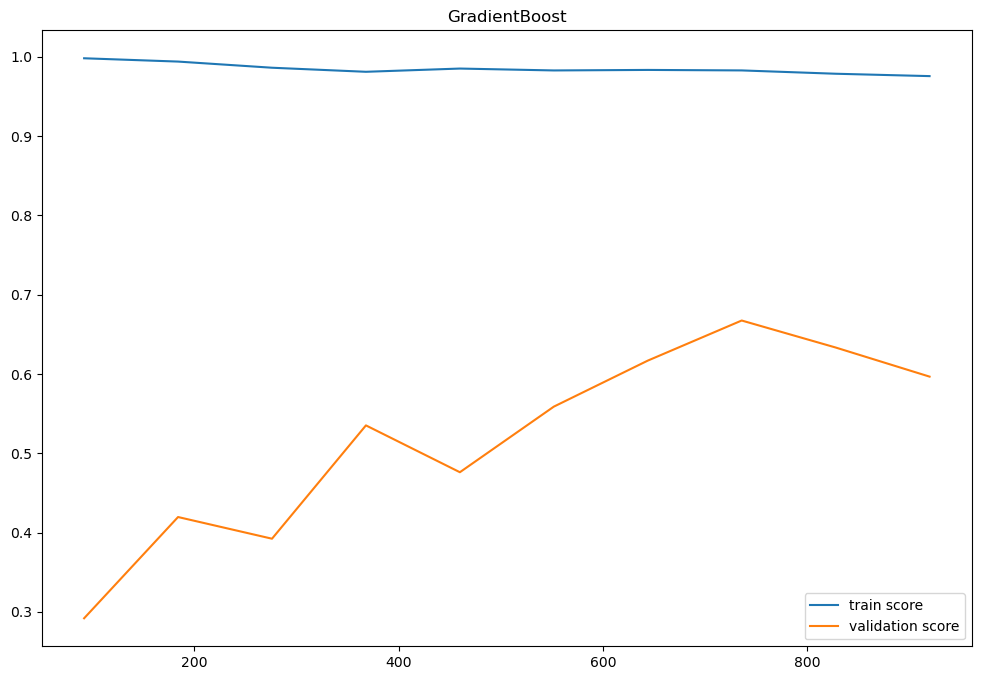

In [58]:

N, train_score, val_score = learning_curve(model_gradboost, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title('GradientBoost')
plt.legend()

### Feature importance

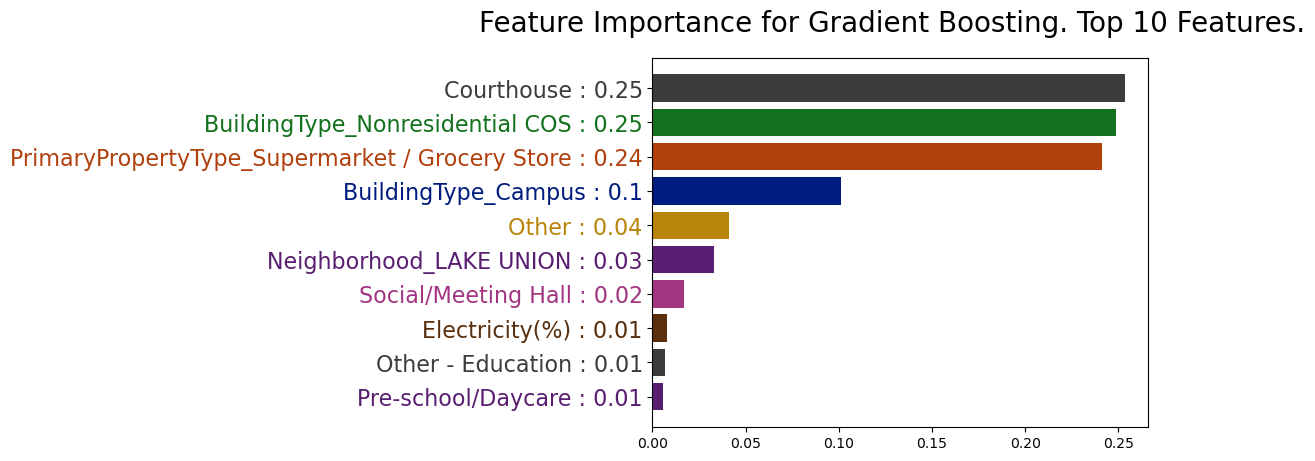

In [59]:
noms_col = preprocessor3.named_transformers_['onehotencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num

color_list =  sns.color_palette("dark", len(noms_col)) 
top_x = 10 # number of x most important features to show

model = GradientBoostingRegressor(random_state = 0, learning_rate = 0.1,
                                  max_depth = 3,n_estimators= 100 , subsample=1)
X_train_nrm = preprocessor3.fit_transform(X_train)   
model.fit(X_train_nrm,y_train)

feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)
indices = indices[-top_x:]

plt.barh(range(len(indices)), feature_importance[indices], color= [color_list[indices[i]] for i in range(top_x)],
         align='center')
  
plt.yticks(range(len(indices)), [(noms_col[j] + ' : ' + str(round(feature_importance[j],2))) for j in indices],
           fontweight="normal", fontsize=16) 

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

plt.suptitle("Feature Importance for Gradient Boosting. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
plt.show()

## <a name="6d"> CatBoost

### Hyperparamètres

In [60]:
params = {'iterations' : [100,300,500], 
          'depth' : [1,3,5], 
          'learning_rate' : [0.1,0.2]}

### GridSearchCV

In [61]:
model = CatBoostRegressor(random_state = 0)
X_train_nrm = preprocessor0.fit_transform(X_train)

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train_nrm,y_train)

0:	learn: 416.5504439	total: 354us	remaining: 35.1ms
1:	learn: 407.4386439	total: 760us	remaining: 37.3ms
2:	learn: 402.3044741	total: 1.01ms	remaining: 32.8ms
3:	learn: 397.7398773	total: 1.27ms	remaining: 30.5ms
4:	learn: 391.4940678	total: 1.5ms	remaining: 28.5ms
5:	learn: 387.4741861	total: 1.75ms	remaining: 27.5ms
6:	learn: 380.9324814	total: 2.01ms	remaining: 26.7ms
7:	learn: 376.1071150	total: 2.24ms	remaining: 25.7ms
8:	learn: 372.6161475	total: 2.48ms	remaining: 25.1ms
9:	learn: 368.0651281	total: 2.74ms	remaining: 24.7ms
10:	learn: 364.9669615	total: 2.94ms	remaining: 23.8ms
11:	learn: 362.1916183	total: 3.19ms	remaining: 23.4ms
12:	learn: 359.7073256	total: 3.43ms	remaining: 23ms
13:	learn: 357.4850868	total: 3.7ms	remaining: 22.7ms
14:	learn: 353.1005692	total: 4.03ms	remaining: 22.9ms
15:	learn: 349.4395642	total: 4.31ms	remaining: 22.6ms
16:	learn: 347.4736839	total: 4.55ms	remaining: 22.2ms
17:	learn: 345.7171680	total: 4.85ms	remaining: 22.1ms
18:	learn: 342.3420245	tot

22:	learn: 294.8864730	total: 5.55ms	remaining: 18.6ms
23:	learn: 292.5791916	total: 5.86ms	remaining: 18.6ms
24:	learn: 292.1639824	total: 6.07ms	remaining: 18.2ms
25:	learn: 290.9341889	total: 6.27ms	remaining: 17.9ms
26:	learn: 289.3217784	total: 6.47ms	remaining: 17.5ms
27:	learn: 287.9116955	total: 6.67ms	remaining: 17.2ms
28:	learn: 285.9236561	total: 6.86ms	remaining: 16.8ms
29:	learn: 284.6814813	total: 7.05ms	remaining: 16.4ms
30:	learn: 283.0245619	total: 7.24ms	remaining: 16.1ms
31:	learn: 280.7604745	total: 7.43ms	remaining: 15.8ms
32:	learn: 279.6138435	total: 7.62ms	remaining: 15.5ms
33:	learn: 278.5752517	total: 7.81ms	remaining: 15.2ms
34:	learn: 277.8188787	total: 7.98ms	remaining: 14.8ms
35:	learn: 275.8538141	total: 8.16ms	remaining: 14.5ms
36:	learn: 274.9914389	total: 8.38ms	remaining: 14.3ms
37:	learn: 274.2110067	total: 8.56ms	remaining: 14ms
38:	learn: 273.5049091	total: 8.74ms	remaining: 13.7ms
39:	learn: 273.1163832	total: 8.93ms	remaining: 13.4ms
40:	learn: 2

60:	learn: 218.6821185	total: 12.7ms	remaining: 8.1ms
61:	learn: 218.0837008	total: 13ms	remaining: 7.99ms
62:	learn: 217.2946275	total: 13.2ms	remaining: 7.78ms
63:	learn: 216.5691268	total: 13.5ms	remaining: 7.57ms
64:	learn: 215.8260623	total: 13.7ms	remaining: 7.37ms
65:	learn: 215.1358626	total: 14ms	remaining: 7.21ms
66:	learn: 214.4352327	total: 14.2ms	remaining: 7ms
67:	learn: 213.6850515	total: 14.4ms	remaining: 6.78ms
68:	learn: 213.3082279	total: 14.6ms	remaining: 6.57ms
69:	learn: 212.7391317	total: 14.9ms	remaining: 6.37ms
70:	learn: 212.1161774	total: 15.1ms	remaining: 6.16ms
71:	learn: 211.5228358	total: 15.3ms	remaining: 5.95ms
72:	learn: 210.8348744	total: 15.5ms	remaining: 5.74ms
73:	learn: 210.2592991	total: 15.8ms	remaining: 5.54ms
74:	learn: 209.6210108	total: 16ms	remaining: 5.33ms
75:	learn: 209.1522840	total: 16.2ms	remaining: 5.13ms
76:	learn: 208.6036632	total: 16.5ms	remaining: 4.92ms
77:	learn: 208.0067318	total: 16.7ms	remaining: 4.71ms
78:	learn: 207.47255

0:	learn: 416.5504439	total: 358us	remaining: 107ms
1:	learn: 407.4386439	total: 722us	remaining: 108ms
2:	learn: 402.3044741	total: 949us	remaining: 94ms
3:	learn: 397.7398773	total: 1.17ms	remaining: 86.2ms
4:	learn: 391.4940678	total: 1.38ms	remaining: 81.4ms
5:	learn: 387.4741861	total: 1.64ms	remaining: 80.4ms
6:	learn: 380.9324814	total: 1.88ms	remaining: 78.5ms
7:	learn: 376.1071150	total: 2.1ms	remaining: 76.5ms
8:	learn: 372.6161475	total: 2.31ms	remaining: 74.8ms
9:	learn: 368.0651281	total: 2.52ms	remaining: 73.1ms
10:	learn: 364.9669615	total: 2.71ms	remaining: 71.3ms
11:	learn: 362.1916183	total: 2.92ms	remaining: 70.1ms
12:	learn: 359.7073256	total: 3.12ms	remaining: 68.8ms
13:	learn: 357.4850868	total: 3.33ms	remaining: 68.1ms
14:	learn: 353.1005692	total: 3.55ms	remaining: 67.4ms
15:	learn: 349.4395642	total: 3.73ms	remaining: 66.3ms
16:	learn: 347.4736839	total: 3.97ms	remaining: 66ms
17:	learn: 345.7171680	total: 4.29ms	remaining: 67.3ms
18:	learn: 342.3420245	total: 

0:	learn: 390.4514838	total: 284us	remaining: 84.9ms
1:	learn: 383.4042795	total: 603us	remaining: 90ms
2:	learn: 377.2410991	total: 845us	remaining: 83.7ms
3:	learn: 371.5710643	total: 1.04ms	remaining: 76.7ms
4:	learn: 363.9046658	total: 1.24ms	remaining: 73.1ms
5:	learn: 357.4156514	total: 1.43ms	remaining: 70.2ms
6:	learn: 352.6433696	total: 1.65ms	remaining: 68.9ms
7:	learn: 347.3611593	total: 1.86ms	remaining: 68ms
8:	learn: 342.9550585	total: 2.05ms	remaining: 66.2ms
9:	learn: 339.2582004	total: 2.22ms	remaining: 64.4ms
10:	learn: 336.0060188	total: 2.4ms	remaining: 63ms
11:	learn: 331.8487408	total: 2.58ms	remaining: 61.8ms
12:	learn: 328.9844915	total: 2.75ms	remaining: 60.8ms
13:	learn: 326.1887808	total: 2.93ms	remaining: 59.8ms
14:	learn: 322.5005862	total: 3.1ms	remaining: 59ms
15:	learn: 320.8663608	total: 3.29ms	remaining: 58.4ms
16:	learn: 318.4929566	total: 3.47ms	remaining: 57.8ms
17:	learn: 315.4639410	total: 3.65ms	remaining: 57.2ms
18:	learn: 313.0493501	total: 3.8

0:	learn: 413.0719575	total: 330us	remaining: 98.7ms
1:	learn: 404.1988815	total: 651us	remaining: 97.1ms
2:	learn: 397.6636551	total: 880us	remaining: 87.2ms
3:	learn: 391.8852520	total: 1.09ms	remaining: 80.5ms
4:	learn: 386.7839950	total: 1.29ms	remaining: 75.9ms
5:	learn: 382.0380769	total: 1.49ms	remaining: 73.2ms
6:	learn: 377.5210579	total: 1.69ms	remaining: 70.8ms
7:	learn: 371.4145801	total: 1.92ms	remaining: 70.2ms
8:	learn: 367.6821029	total: 2.14ms	remaining: 69.1ms
9:	learn: 362.0948593	total: 2.36ms	remaining: 68.4ms
10:	learn: 357.4771197	total: 2.55ms	remaining: 66.9ms
11:	learn: 354.2561719	total: 2.74ms	remaining: 65.7ms
12:	learn: 351.4019876	total: 2.92ms	remaining: 64.4ms
13:	learn: 349.0725386	total: 3.1ms	remaining: 63.3ms
14:	learn: 345.0095686	total: 3.28ms	remaining: 62.3ms
15:	learn: 341.7131110	total: 3.46ms	remaining: 61.5ms
16:	learn: 338.2554126	total: 3.65ms	remaining: 60.8ms
17:	learn: 336.8045052	total: 3.84ms	remaining: 60.1ms
18:	learn: 334.9056296	t

0:	learn: 342.3152489	total: 276us	remaining: 82.6ms
1:	learn: 336.8309535	total: 566us	remaining: 84.4ms
2:	learn: 326.4879966	total: 737us	remaining: 73ms
3:	learn: 321.8065260	total: 916us	remaining: 67.9ms
4:	learn: 313.9818239	total: 1.09ms	remaining: 64.4ms
5:	learn: 310.4259462	total: 1.26ms	remaining: 61.9ms
6:	learn: 305.2536158	total: 1.43ms	remaining: 59.9ms
7:	learn: 302.6214404	total: 1.6ms	remaining: 58.3ms
8:	learn: 295.6971536	total: 1.77ms	remaining: 57.1ms
9:	learn: 290.2075469	total: 1.93ms	remaining: 56.1ms
10:	learn: 285.8050285	total: 2.11ms	remaining: 55.4ms
11:	learn: 282.6194126	total: 2.28ms	remaining: 54.7ms
12:	learn: 278.5825271	total: 2.45ms	remaining: 54ms
13:	learn: 275.8329698	total: 2.62ms	remaining: 53.5ms
14:	learn: 273.4186022	total: 2.79ms	remaining: 53.1ms
15:	learn: 270.9237953	total: 2.97ms	remaining: 52.7ms
16:	learn: 268.7295626	total: 3.14ms	remaining: 52.3ms
17:	learn: 265.9918880	total: 3.32ms	remaining: 52ms
18:	learn: 264.0680272	total: 3

0:	learn: 367.9572256	total: 294us	remaining: 87.9ms
1:	learn: 358.9952279	total: 658us	remaining: 98.2ms
2:	learn: 344.1240446	total: 842us	remaining: 83.4ms
3:	learn: 336.6385147	total: 1.03ms	remaining: 76.1ms
4:	learn: 325.5739571	total: 1.21ms	remaining: 71.1ms
5:	learn: 319.7156056	total: 1.39ms	remaining: 68.1ms
6:	learn: 314.8273404	total: 1.58ms	remaining: 66.1ms
7:	learn: 307.9492699	total: 1.76ms	remaining: 64.3ms
8:	learn: 303.1922558	total: 1.95ms	remaining: 63.1ms
9:	learn: 298.4526738	total: 2.13ms	remaining: 61.7ms
10:	learn: 297.6271078	total: 2.3ms	remaining: 60.5ms
11:	learn: 294.7686403	total: 2.48ms	remaining: 59.4ms
12:	learn: 290.2262022	total: 2.64ms	remaining: 58.4ms
13:	learn: 287.7092335	total: 2.83ms	remaining: 57.8ms
14:	learn: 285.0682235	total: 3.01ms	remaining: 57.2ms
15:	learn: 279.8055847	total: 3.18ms	remaining: 56.5ms
16:	learn: 277.6005138	total: 3.36ms	remaining: 56ms
17:	learn: 276.0952814	total: 3.57ms	remaining: 56ms
18:	learn: 273.2914598	total

0:	learn: 416.5504439	total: 315us	remaining: 157ms
1:	learn: 407.4386439	total: 637us	remaining: 159ms
2:	learn: 402.3044741	total: 875us	remaining: 145ms
3:	learn: 397.7398773	total: 1.06ms	remaining: 132ms
4:	learn: 391.4940678	total: 1.27ms	remaining: 126ms
5:	learn: 387.4741861	total: 1.47ms	remaining: 121ms
6:	learn: 380.9324814	total: 1.69ms	remaining: 119ms
7:	learn: 376.1071150	total: 1.87ms	remaining: 115ms
8:	learn: 372.6161475	total: 2.06ms	remaining: 112ms
9:	learn: 368.0651281	total: 2.23ms	remaining: 109ms
10:	learn: 364.9669615	total: 2.42ms	remaining: 107ms
11:	learn: 362.1916183	total: 2.59ms	remaining: 105ms
12:	learn: 359.7073256	total: 2.76ms	remaining: 104ms
13:	learn: 357.4850868	total: 2.95ms	remaining: 102ms
14:	learn: 353.1005692	total: 3.16ms	remaining: 102ms
15:	learn: 349.4395642	total: 3.38ms	remaining: 102ms
16:	learn: 347.4736839	total: 3.6ms	remaining: 102ms
17:	learn: 345.7171680	total: 3.81ms	remaining: 102ms
18:	learn: 342.3420245	total: 4.02ms	remai

184:	learn: 201.4158511	total: 34.4ms	remaining: 58.6ms
185:	learn: 201.1802882	total: 34.7ms	remaining: 58.6ms
186:	learn: 200.9662298	total: 34.9ms	remaining: 58.4ms
187:	learn: 200.7359001	total: 35.1ms	remaining: 58.2ms
188:	learn: 200.5258895	total: 35.3ms	remaining: 58ms
189:	learn: 200.3042249	total: 35.5ms	remaining: 57.8ms
190:	learn: 200.0984491	total: 35.6ms	remaining: 57.6ms
191:	learn: 199.8818546	total: 35.8ms	remaining: 57.4ms
192:	learn: 199.6713544	total: 36ms	remaining: 57.3ms
193:	learn: 199.4430754	total: 36.2ms	remaining: 57.1ms
194:	learn: 199.2419588	total: 36.4ms	remaining: 56.9ms
195:	learn: 199.0315266	total: 36.6ms	remaining: 56.8ms
196:	learn: 198.9006954	total: 36.8ms	remaining: 56.6ms
197:	learn: 198.7014373	total: 37ms	remaining: 56.5ms
198:	learn: 198.6098233	total: 37.3ms	remaining: 56.4ms
199:	learn: 198.4056899	total: 37.5ms	remaining: 56.2ms
200:	learn: 198.2151833	total: 37.7ms	remaining: 56.1ms
201:	learn: 198.0436750	total: 38ms	remaining: 56ms
20

311:	learn: 216.0206027	total: 70.4ms	remaining: 42.4ms
312:	learn: 215.9338178	total: 70.6ms	remaining: 42.2ms
313:	learn: 215.8607051	total: 70.8ms	remaining: 42ms
314:	learn: 215.7673948	total: 71ms	remaining: 41.7ms
315:	learn: 215.7263482	total: 71.2ms	remaining: 41.5ms
316:	learn: 215.6391297	total: 71.4ms	remaining: 41.2ms
317:	learn: 215.5801849	total: 71.6ms	remaining: 41ms
318:	learn: 215.5389779	total: 71.8ms	remaining: 40.7ms
319:	learn: 215.4882264	total: 72ms	remaining: 40.5ms
320:	learn: 215.4044469	total: 72.2ms	remaining: 40.3ms
321:	learn: 215.3130986	total: 72.4ms	remaining: 40ms
322:	learn: 215.2292516	total: 72.6ms	remaining: 39.8ms
323:	learn: 215.2037707	total: 72.8ms	remaining: 39.6ms
324:	learn: 215.1168897	total: 73ms	remaining: 39.3ms
325:	learn: 215.0236119	total: 73.2ms	remaining: 39.1ms
326:	learn: 214.9676919	total: 73.4ms	remaining: 38.8ms
327:	learn: 214.9269475	total: 73.5ms	remaining: 38.6ms
328:	learn: 214.8867524	total: 73.7ms	remaining: 38.3ms
329:

0:	learn: 413.0719575	total: 319us	remaining: 159ms
1:	learn: 404.1988815	total: 682us	remaining: 170ms
2:	learn: 397.6636551	total: 897us	remaining: 149ms
3:	learn: 391.8852520	total: 1.11ms	remaining: 138ms
4:	learn: 386.7839950	total: 1.31ms	remaining: 130ms
5:	learn: 382.0380769	total: 1.51ms	remaining: 124ms
6:	learn: 377.5210579	total: 1.69ms	remaining: 119ms
7:	learn: 371.4145801	total: 1.88ms	remaining: 116ms
8:	learn: 367.6821029	total: 2.08ms	remaining: 114ms
9:	learn: 362.0948593	total: 2.27ms	remaining: 111ms
10:	learn: 357.4771197	total: 2.45ms	remaining: 109ms
11:	learn: 354.2561719	total: 2.63ms	remaining: 107ms
12:	learn: 351.4019876	total: 2.81ms	remaining: 105ms
13:	learn: 349.0725386	total: 2.99ms	remaining: 104ms
14:	learn: 345.0095686	total: 3.18ms	remaining: 103ms
15:	learn: 341.7131110	total: 3.37ms	remaining: 102ms
16:	learn: 338.2554126	total: 3.56ms	remaining: 101ms
17:	learn: 336.8045052	total: 3.74ms	remaining: 100ms
18:	learn: 334.9056296	total: 3.93ms	rema

168:	learn: 229.7599419	total: 34.6ms	remaining: 67.8ms
169:	learn: 229.5957456	total: 34.9ms	remaining: 67.7ms
170:	learn: 229.5107569	total: 35.1ms	remaining: 67.5ms
171:	learn: 229.3562379	total: 35.3ms	remaining: 67.3ms
172:	learn: 229.1755519	total: 35.5ms	remaining: 67.1ms
173:	learn: 229.0538388	total: 35.7ms	remaining: 66.9ms
174:	learn: 228.9294920	total: 35.9ms	remaining: 66.7ms
175:	learn: 228.7646246	total: 36.2ms	remaining: 66.6ms
176:	learn: 228.6041190	total: 36.4ms	remaining: 66.3ms
177:	learn: 228.4326039	total: 36.6ms	remaining: 66.2ms
178:	learn: 228.2625277	total: 36.8ms	remaining: 66ms
179:	learn: 228.0796257	total: 37ms	remaining: 65.8ms
180:	learn: 227.9061232	total: 37.2ms	remaining: 65.5ms
181:	learn: 227.7323999	total: 37.4ms	remaining: 65.3ms
182:	learn: 227.5648162	total: 37.6ms	remaining: 65.1ms
183:	learn: 227.3993683	total: 37.8ms	remaining: 64.9ms
184:	learn: 227.3504400	total: 38ms	remaining: 64.7ms
185:	learn: 227.1889857	total: 38.2ms	remaining: 64.4m

395:	learn: 165.4661398	total: 74ms	remaining: 19.4ms
396:	learn: 165.4319295	total: 74.2ms	remaining: 19.3ms
397:	learn: 165.3939866	total: 74.4ms	remaining: 19.1ms
398:	learn: 165.3483992	total: 74.6ms	remaining: 18.9ms
399:	learn: 165.2881793	total: 74.8ms	remaining: 18.7ms
400:	learn: 165.2796720	total: 75ms	remaining: 18.5ms
401:	learn: 165.2591175	total: 75.2ms	remaining: 18.3ms
402:	learn: 165.1984322	total: 75.4ms	remaining: 18.1ms
403:	learn: 165.1272885	total: 75.5ms	remaining: 18ms
404:	learn: 165.0734883	total: 75.7ms	remaining: 17.8ms
405:	learn: 165.0151339	total: 75.9ms	remaining: 17.6ms
406:	learn: 164.9889634	total: 76.1ms	remaining: 17.4ms
407:	learn: 164.9202832	total: 76.3ms	remaining: 17.2ms
408:	learn: 164.8881583	total: 76.4ms	remaining: 17ms
409:	learn: 164.8386960	total: 76.6ms	remaining: 16.8ms
410:	learn: 164.7757612	total: 76.8ms	remaining: 16.6ms
411:	learn: 164.7109517	total: 77ms	remaining: 16.4ms
412:	learn: 164.6572647	total: 77.1ms	remaining: 16.2ms
41

0:	learn: 367.9572256	total: 328us	remaining: 164ms
1:	learn: 358.9952279	total: 690us	remaining: 172ms
2:	learn: 344.1240446	total: 904us	remaining: 150ms
3:	learn: 336.6385147	total: 1.1ms	remaining: 137ms
4:	learn: 325.5739571	total: 1.3ms	remaining: 129ms
5:	learn: 319.7156056	total: 1.51ms	remaining: 124ms
6:	learn: 314.8273404	total: 1.74ms	remaining: 123ms
7:	learn: 307.9492699	total: 1.93ms	remaining: 119ms
8:	learn: 303.1922558	total: 2.14ms	remaining: 117ms
9:	learn: 298.4526738	total: 2.33ms	remaining: 114ms
10:	learn: 297.6271078	total: 2.53ms	remaining: 113ms
11:	learn: 294.7686403	total: 2.71ms	remaining: 110ms
12:	learn: 290.2262022	total: 2.89ms	remaining: 108ms
13:	learn: 287.7092335	total: 3.08ms	remaining: 107ms
14:	learn: 285.0682235	total: 3.25ms	remaining: 105ms
15:	learn: 279.8055847	total: 3.44ms	remaining: 104ms
16:	learn: 277.6005138	total: 3.62ms	remaining: 103ms
17:	learn: 276.0952814	total: 3.8ms	remaining: 102ms
18:	learn: 273.2914598	total: 3.98ms	remaini

153:	learn: 228.3505669	total: 32.3ms	remaining: 72.5ms
154:	learn: 228.1509741	total: 32.6ms	remaining: 72.6ms
155:	learn: 227.9471542	total: 32.8ms	remaining: 72.4ms
156:	learn: 227.7755013	total: 33.1ms	remaining: 72.3ms
157:	learn: 227.6837582	total: 33.3ms	remaining: 72.1ms
158:	learn: 227.5350985	total: 33.6ms	remaining: 72ms
159:	learn: 227.3435804	total: 33.8ms	remaining: 71.8ms
160:	learn: 227.1838083	total: 34ms	remaining: 71.7ms
161:	learn: 227.0737396	total: 34.3ms	remaining: 71.5ms
162:	learn: 226.9846602	total: 34.5ms	remaining: 71.2ms
163:	learn: 226.8109851	total: 34.7ms	remaining: 71ms
164:	learn: 226.6070968	total: 34.9ms	remaining: 70.8ms
165:	learn: 226.5087665	total: 35.1ms	remaining: 70.6ms
166:	learn: 226.3653211	total: 35.3ms	remaining: 70.4ms
167:	learn: 226.2947598	total: 35.6ms	remaining: 70.3ms
168:	learn: 226.2421588	total: 35.8ms	remaining: 70.1ms
169:	learn: 226.1246741	total: 36ms	remaining: 70ms
170:	learn: 225.9570290	total: 36.3ms	remaining: 69.9ms
17

0:	learn: 341.1606674	total: 597us	remaining: 59.1ms
1:	learn: 327.3878025	total: 1.15ms	remaining: 56.4ms
2:	learn: 311.5614152	total: 1.61ms	remaining: 52.1ms
3:	learn: 300.7877682	total: 2.03ms	remaining: 48.8ms
4:	learn: 290.5479888	total: 2.44ms	remaining: 46.3ms
5:	learn: 280.3656679	total: 2.9ms	remaining: 45.4ms
6:	learn: 275.7238669	total: 3.38ms	remaining: 44.9ms
7:	learn: 266.0541276	total: 3.99ms	remaining: 45.8ms
8:	learn: 259.4177093	total: 4.41ms	remaining: 44.5ms
9:	learn: 249.8190802	total: 4.95ms	remaining: 44.5ms
10:	learn: 244.8501068	total: 5.52ms	remaining: 44.6ms
11:	learn: 239.6395454	total: 5.94ms	remaining: 43.6ms
12:	learn: 232.4200146	total: 6.33ms	remaining: 42.4ms
13:	learn: 226.7280162	total: 6.8ms	remaining: 41.8ms
14:	learn: 220.3364465	total: 7.26ms	remaining: 41.1ms
15:	learn: 218.2274531	total: 7.79ms	remaining: 40.9ms
16:	learn: 211.0267885	total: 8.29ms	remaining: 40.5ms
17:	learn: 207.5176428	total: 8.7ms	remaining: 39.6ms
18:	learn: 200.1349098	t

30:	learn: 219.1564191	total: 28.8ms	remaining: 64.1ms
31:	learn: 216.9541129	total: 29.3ms	remaining: 62.2ms
32:	learn: 215.6780203	total: 29.7ms	remaining: 60.3ms
33:	learn: 214.4846904	total: 30.1ms	remaining: 58.5ms
34:	learn: 213.2042570	total: 30.6ms	remaining: 56.8ms
35:	learn: 211.0368571	total: 31ms	remaining: 55.1ms
36:	learn: 206.6099161	total: 31.4ms	remaining: 53.5ms
37:	learn: 204.5901834	total: 31.8ms	remaining: 51.9ms
38:	learn: 200.7415264	total: 32.3ms	remaining: 50.5ms
39:	learn: 199.0369971	total: 32.7ms	remaining: 49.1ms
40:	learn: 195.4824442	total: 33.2ms	remaining: 47.7ms
41:	learn: 192.0811744	total: 33.6ms	remaining: 46.4ms
42:	learn: 190.1180487	total: 34ms	remaining: 45ms
43:	learn: 189.4766213	total: 34.4ms	remaining: 43.8ms
44:	learn: 185.7071721	total: 34.8ms	remaining: 42.6ms
45:	learn: 185.0995691	total: 35.3ms	remaining: 41.4ms
46:	learn: 184.5243565	total: 35.7ms	remaining: 40.2ms
47:	learn: 181.6248242	total: 36.1ms	remaining: 39.2ms
48:	learn: 180.2

0:	learn: 326.0003109	total: 533us	remaining: 52.9ms
1:	learn: 303.9582542	total: 1.03ms	remaining: 50.8ms
2:	learn: 278.2462122	total: 1.42ms	remaining: 45.9ms
3:	learn: 261.9029484	total: 1.81ms	remaining: 43.3ms
4:	learn: 250.9881995	total: 2.19ms	remaining: 41.6ms
5:	learn: 239.4240569	total: 2.58ms	remaining: 40.5ms
6:	learn: 232.5730703	total: 2.97ms	remaining: 39.4ms
7:	learn: 217.6570929	total: 3.38ms	remaining: 38.9ms
8:	learn: 202.3185124	total: 3.77ms	remaining: 38.2ms
9:	learn: 191.3479885	total: 4.16ms	remaining: 37.4ms
10:	learn: 186.0667881	total: 4.55ms	remaining: 36.8ms
11:	learn: 177.0292012	total: 4.94ms	remaining: 36.2ms
12:	learn: 172.5932089	total: 5.33ms	remaining: 35.6ms
13:	learn: 167.5645285	total: 5.71ms	remaining: 35.1ms
14:	learn: 162.9174634	total: 6.08ms	remaining: 34.5ms
15:	learn: 161.0315844	total: 6.49ms	remaining: 34.1ms
16:	learn: 157.4775686	total: 6.9ms	remaining: 33.7ms
17:	learn: 155.8420061	total: 7.28ms	remaining: 33.1ms
18:	learn: 154.4729202

32:	learn: 154.1901271	total: 23.2ms	remaining: 47.1ms
33:	learn: 152.5944676	total: 23.7ms	remaining: 46.1ms
34:	learn: 149.8592095	total: 24.2ms	remaining: 44.9ms
35:	learn: 149.1567478	total: 24.7ms	remaining: 43.9ms
36:	learn: 148.5167244	total: 25.1ms	remaining: 42.7ms
37:	learn: 147.8329031	total: 25.5ms	remaining: 41.6ms
38:	learn: 146.1524738	total: 26ms	remaining: 40.6ms
39:	learn: 142.9767836	total: 26.4ms	remaining: 39.6ms
40:	learn: 142.3726953	total: 26.9ms	remaining: 38.8ms
41:	learn: 139.9134112	total: 27.4ms	remaining: 37.8ms
42:	learn: 136.8608233	total: 27.8ms	remaining: 36.8ms
43:	learn: 135.8099646	total: 28.2ms	remaining: 35.9ms
44:	learn: 134.1496667	total: 28.7ms	remaining: 35.1ms
45:	learn: 133.2815816	total: 29.3ms	remaining: 34.4ms
46:	learn: 132.5126345	total: 29.8ms	remaining: 33.5ms
47:	learn: 130.8397580	total: 30.1ms	remaining: 32.7ms
48:	learn: 130.3841688	total: 30.5ms	remaining: 31.8ms
49:	learn: 128.8900155	total: 30.9ms	remaining: 30.9ms
50:	learn: 1

29:	learn: 216.6325202	total: 35.5ms	remaining: 319ms
30:	learn: 212.4176502	total: 36ms	remaining: 313ms
31:	learn: 209.8208166	total: 36.6ms	remaining: 306ms
32:	learn: 207.3296888	total: 37ms	remaining: 300ms
33:	learn: 202.8204457	total: 37.4ms	remaining: 293ms
34:	learn: 201.9832570	total: 37.9ms	remaining: 287ms
35:	learn: 201.2486996	total: 38.4ms	remaining: 282ms
36:	learn: 199.8318358	total: 38.8ms	remaining: 276ms
37:	learn: 197.9624895	total: 39.3ms	remaining: 271ms
38:	learn: 194.7219127	total: 39.8ms	remaining: 266ms
39:	learn: 192.9593541	total: 40.3ms	remaining: 262ms
40:	learn: 189.1997765	total: 40.8ms	remaining: 257ms
41:	learn: 187.6707405	total: 41.2ms	remaining: 253ms
42:	learn: 186.1666934	total: 41.6ms	remaining: 249ms
43:	learn: 184.7568937	total: 42ms	remaining: 244ms
44:	learn: 183.7207533	total: 42.4ms	remaining: 240ms
45:	learn: 182.2722582	total: 42.9ms	remaining: 237ms
46:	learn: 181.2331481	total: 43.4ms	remaining: 234ms
47:	learn: 179.5380361	total: 43.9

61:	learn: 121.1898914	total: 26.9ms	remaining: 103ms
62:	learn: 120.7866442	total: 27.5ms	remaining: 103ms
63:	learn: 120.1595356	total: 27.9ms	remaining: 103ms
64:	learn: 119.4923089	total: 28.4ms	remaining: 103ms
65:	learn: 118.4255699	total: 28.8ms	remaining: 102ms
66:	learn: 118.0222239	total: 29.3ms	remaining: 102ms
67:	learn: 117.3926450	total: 29.7ms	remaining: 101ms
68:	learn: 116.0058390	total: 30.2ms	remaining: 101ms
69:	learn: 115.7121197	total: 30.7ms	remaining: 101ms
70:	learn: 114.3858507	total: 31.1ms	remaining: 100ms
71:	learn: 113.5463744	total: 31.5ms	remaining: 99.9ms
72:	learn: 113.1774506	total: 32ms	remaining: 99.4ms
73:	learn: 112.0022594	total: 32.4ms	remaining: 98.9ms
74:	learn: 110.9363759	total: 32.8ms	remaining: 98.5ms
75:	learn: 110.1822868	total: 33.2ms	remaining: 97.9ms
76:	learn: 109.6711891	total: 33.6ms	remaining: 97.4ms
77:	learn: 109.2595718	total: 34ms	remaining: 96.8ms
78:	learn: 108.3386697	total: 34.4ms	remaining: 96.2ms
79:	learn: 107.9505129	t

125:	learn: 121.5544973	total: 54.1ms	remaining: 74.6ms
126:	learn: 121.1400812	total: 54.5ms	remaining: 74.3ms
127:	learn: 120.8961455	total: 55ms	remaining: 73.9ms
128:	learn: 120.4601820	total: 55.6ms	remaining: 73.7ms
129:	learn: 120.3501199	total: 56.1ms	remaining: 73.3ms
130:	learn: 120.0296809	total: 56.5ms	remaining: 72.9ms
131:	learn: 119.3767725	total: 56.9ms	remaining: 72.4ms
132:	learn: 119.2712886	total: 57.3ms	remaining: 71.9ms
133:	learn: 118.9294190	total: 57.7ms	remaining: 71.5ms
134:	learn: 118.4897699	total: 58.1ms	remaining: 71ms
135:	learn: 118.3889366	total: 58.5ms	remaining: 70.5ms
136:	learn: 118.1211750	total: 58.9ms	remaining: 70.1ms
137:	learn: 117.7278846	total: 59.3ms	remaining: 69.7ms
138:	learn: 116.8767634	total: 59.7ms	remaining: 69.2ms
139:	learn: 116.7799094	total: 60.1ms	remaining: 68.7ms
140:	learn: 115.8513050	total: 60.6ms	remaining: 68.3ms
141:	learn: 115.6016840	total: 61.1ms	remaining: 68ms
142:	learn: 115.1514210	total: 61.5ms	remaining: 67.6m

173:	learn: 99.6975456	total: 73.4ms	remaining: 53.2ms
174:	learn: 99.2604709	total: 74ms	remaining: 52.8ms
175:	learn: 98.5003935	total: 74.4ms	remaining: 52.4ms
176:	learn: 98.1758818	total: 74.9ms	remaining: 52ms
177:	learn: 98.0895811	total: 75.3ms	remaining: 51.6ms
178:	learn: 97.9225633	total: 75.8ms	remaining: 51.2ms
179:	learn: 97.3589191	total: 76.2ms	remaining: 50.8ms
180:	learn: 97.1976376	total: 76.6ms	remaining: 50.4ms
181:	learn: 97.0540261	total: 77.1ms	remaining: 50ms
182:	learn: 96.9567529	total: 77.5ms	remaining: 49.5ms
183:	learn: 96.9098140	total: 77.8ms	remaining: 49.1ms
184:	learn: 96.8670833	total: 78.2ms	remaining: 48.6ms
185:	learn: 96.8048505	total: 78.6ms	remaining: 48.2ms
186:	learn: 96.5815244	total: 79.1ms	remaining: 47.8ms
187:	learn: 96.5428139	total: 79.5ms	remaining: 47.4ms
188:	learn: 95.8336657	total: 79.9ms	remaining: 46.9ms
189:	learn: 95.7971454	total: 80.3ms	remaining: 46.5ms
190:	learn: 95.4141852	total: 80.8ms	remaining: 46.1ms
191:	learn: 95.2

214:	learn: 93.7466251	total: 96.1ms	remaining: 38ms
215:	learn: 93.4762794	total: 96.7ms	remaining: 37.6ms
216:	learn: 93.2391046	total: 97.1ms	remaining: 37.2ms
217:	learn: 93.1083242	total: 97.6ms	remaining: 36.7ms
218:	learn: 92.8983137	total: 98.2ms	remaining: 36.3ms
219:	learn: 92.7414665	total: 98.6ms	remaining: 35.8ms
220:	learn: 92.6437938	total: 99ms	remaining: 35.4ms
221:	learn: 92.3040110	total: 99.4ms	remaining: 34.9ms
222:	learn: 92.2132039	total: 99.8ms	remaining: 34.4ms
223:	learn: 92.0177020	total: 100ms	remaining: 34ms
224:	learn: 91.9605635	total: 101ms	remaining: 33.5ms
225:	learn: 91.8807600	total: 101ms	remaining: 33.1ms
226:	learn: 91.6048763	total: 101ms	remaining: 32.6ms
227:	learn: 91.5228996	total: 102ms	remaining: 32.2ms
228:	learn: 91.2264356	total: 102ms	remaining: 31.7ms
229:	learn: 91.1032245	total: 103ms	remaining: 31.3ms
230:	learn: 91.0710414	total: 103ms	remaining: 30.8ms
231:	learn: 90.9174830	total: 104ms	remaining: 30.4ms
232:	learn: 90.6026400	to

256:	learn: 60.2593663	total: 113ms	remaining: 18.9ms
257:	learn: 60.0498847	total: 114ms	remaining: 18.5ms
258:	learn: 59.9902407	total: 114ms	remaining: 18.1ms
259:	learn: 59.9382317	total: 115ms	remaining: 17.6ms
260:	learn: 59.7483307	total: 115ms	remaining: 17.2ms
261:	learn: 59.5300503	total: 116ms	remaining: 16.8ms
262:	learn: 59.1033563	total: 116ms	remaining: 16.3ms
263:	learn: 58.9729188	total: 116ms	remaining: 15.9ms
264:	learn: 58.7586926	total: 117ms	remaining: 15.4ms
265:	learn: 58.6332554	total: 117ms	remaining: 15ms
266:	learn: 58.2310792	total: 118ms	remaining: 14.6ms
267:	learn: 58.2090833	total: 118ms	remaining: 14.1ms
268:	learn: 58.1526959	total: 119ms	remaining: 13.7ms
269:	learn: 58.1298263	total: 119ms	remaining: 13.2ms
270:	learn: 58.0747395	total: 119ms	remaining: 12.8ms
271:	learn: 58.0366752	total: 120ms	remaining: 12.3ms
272:	learn: 57.9250083	total: 120ms	remaining: 11.9ms
273:	learn: 57.7665852	total: 121ms	remaining: 11.4ms
274:	learn: 57.6803934	total: 

294:	learn: 46.4601578	total: 132ms	remaining: 2.23ms
295:	learn: 46.3091071	total: 132ms	remaining: 1.79ms
296:	learn: 46.1401003	total: 133ms	remaining: 1.34ms
297:	learn: 46.0334617	total: 133ms	remaining: 892us
298:	learn: 45.9682363	total: 133ms	remaining: 446us
299:	learn: 45.9365615	total: 134ms	remaining: 0us
0:	learn: 365.6081725	total: 567us	remaining: 170ms
1:	learn: 338.9235108	total: 989us	remaining: 147ms
2:	learn: 319.1598592	total: 1.41ms	remaining: 139ms
3:	learn: 302.6223742	total: 1.82ms	remaining: 135ms
4:	learn: 287.7009352	total: 2.35ms	remaining: 139ms
5:	learn: 276.2704404	total: 2.79ms	remaining: 137ms
6:	learn: 267.4997336	total: 3.22ms	remaining: 135ms
7:	learn: 260.7335050	total: 3.64ms	remaining: 133ms
8:	learn: 251.3128667	total: 4.1ms	remaining: 132ms
9:	learn: 245.9144719	total: 4.52ms	remaining: 131ms
10:	learn: 238.3318382	total: 4.96ms	remaining: 130ms
11:	learn: 231.6228570	total: 5.38ms	remaining: 129ms
12:	learn: 229.1022175	total: 5.79ms	remaining

0:	learn: 360.6695697	total: 626us	remaining: 187ms
1:	learn: 337.0434234	total: 1.17ms	remaining: 174ms
2:	learn: 330.7444295	total: 1.6ms	remaining: 159ms
3:	learn: 308.6243989	total: 2.02ms	remaining: 150ms
4:	learn: 289.8226777	total: 2.45ms	remaining: 144ms
5:	learn: 285.2270557	total: 2.85ms	remaining: 140ms
6:	learn: 275.6391926	total: 3.28ms	remaining: 137ms
7:	learn: 268.1316464	total: 3.77ms	remaining: 138ms
8:	learn: 264.2535973	total: 4.27ms	remaining: 138ms
9:	learn: 254.7066943	total: 4.73ms	remaining: 137ms
10:	learn: 246.0165444	total: 5.13ms	remaining: 135ms
11:	learn: 243.3235416	total: 5.59ms	remaining: 134ms
12:	learn: 240.9107947	total: 6.01ms	remaining: 133ms
13:	learn: 232.6705569	total: 6.41ms	remaining: 131ms
14:	learn: 230.3015934	total: 6.79ms	remaining: 129ms
15:	learn: 216.3681932	total: 7.25ms	remaining: 129ms
16:	learn: 214.6887843	total: 7.7ms	remaining: 128ms
17:	learn: 210.0820247	total: 8.12ms	remaining: 127ms
18:	learn: 199.6850145	total: 8.54ms	rema

0:	learn: 390.9055419	total: 6.99ms	remaining: 2.09s
1:	learn: 361.0814038	total: 7.48ms	remaining: 1.11s
2:	learn: 350.7181483	total: 7.91ms	remaining: 783ms
3:	learn: 325.6956070	total: 8.33ms	remaining: 617ms
4:	learn: 304.4199067	total: 8.78ms	remaining: 518ms
5:	learn: 290.1847794	total: 9.24ms	remaining: 453ms
6:	learn: 273.9030304	total: 9.8ms	remaining: 410ms
7:	learn: 261.5927574	total: 10.2ms	remaining: 373ms
8:	learn: 252.6676691	total: 10.7ms	remaining: 345ms
9:	learn: 243.6882945	total: 11.1ms	remaining: 323ms
10:	learn: 234.1373941	total: 11.6ms	remaining: 303ms
11:	learn: 227.6131319	total: 12ms	remaining: 287ms
12:	learn: 219.5149897	total: 12.4ms	remaining: 274ms
13:	learn: 215.9317007	total: 12.8ms	remaining: 261ms
14:	learn: 205.5490850	total: 13.2ms	remaining: 251ms
15:	learn: 202.3169388	total: 13.6ms	remaining: 241ms
16:	learn: 194.5541982	total: 14ms	remaining: 234ms
17:	learn: 192.8285595	total: 14.4ms	remaining: 226ms
18:	learn: 189.0907847	total: 14.9ms	remain

48:	learn: 175.7724905	total: 26ms	remaining: 239ms
49:	learn: 175.0615148	total: 26.5ms	remaining: 238ms
50:	learn: 173.5377664	total: 26.9ms	remaining: 237ms
51:	learn: 172.4235439	total: 27.5ms	remaining: 237ms
52:	learn: 169.1783860	total: 28ms	remaining: 236ms
53:	learn: 166.6563569	total: 28.5ms	remaining: 236ms
54:	learn: 163.9514676	total: 29.1ms	remaining: 235ms
55:	learn: 162.8930036	total: 29.6ms	remaining: 235ms
56:	learn: 161.7220521	total: 30.1ms	remaining: 234ms
57:	learn: 161.3697233	total: 30.7ms	remaining: 234ms
58:	learn: 160.2648914	total: 31.1ms	remaining: 233ms
59:	learn: 159.2745096	total: 31.6ms	remaining: 232ms
60:	learn: 156.8954333	total: 32.1ms	remaining: 231ms
61:	learn: 156.0703081	total: 32.6ms	remaining: 230ms
62:	learn: 155.3921566	total: 33.1ms	remaining: 229ms
63:	learn: 154.7613821	total: 33.5ms	remaining: 228ms
64:	learn: 154.2340146	total: 34ms	remaining: 227ms
65:	learn: 152.5194787	total: 34.4ms	remaining: 226ms
66:	learn: 150.4109447	total: 34.9

435:	learn: 64.0036312	total: 207ms	remaining: 30.4ms
436:	learn: 63.8802532	total: 207ms	remaining: 29.9ms
437:	learn: 63.7393037	total: 208ms	remaining: 29.4ms
438:	learn: 63.6721289	total: 208ms	remaining: 29ms
439:	learn: 63.5603129	total: 209ms	remaining: 28.5ms
440:	learn: 63.5494859	total: 209ms	remaining: 28ms
441:	learn: 63.4713093	total: 210ms	remaining: 27.5ms
442:	learn: 63.4080285	total: 210ms	remaining: 27.1ms
443:	learn: 63.3753888	total: 211ms	remaining: 26.6ms
444:	learn: 63.3598388	total: 211ms	remaining: 26.1ms
445:	learn: 63.2166001	total: 212ms	remaining: 25.6ms
446:	learn: 63.2073559	total: 212ms	remaining: 25.2ms
447:	learn: 63.1968352	total: 213ms	remaining: 24.7ms
448:	learn: 63.1823147	total: 213ms	remaining: 24.2ms
449:	learn: 63.0363723	total: 214ms	remaining: 23.7ms
450:	learn: 63.0228086	total: 214ms	remaining: 23.2ms
451:	learn: 62.9159169	total: 214ms	remaining: 22.8ms
452:	learn: 62.8308990	total: 215ms	remaining: 22.3ms
453:	learn: 62.7203296	total: 21

277:	learn: 66.5410320	total: 119ms	remaining: 95ms
278:	learn: 66.3852762	total: 120ms	remaining: 94.7ms
279:	learn: 66.2788777	total: 120ms	remaining: 94.3ms
280:	learn: 66.1190228	total: 120ms	remaining: 93.9ms
281:	learn: 66.0540866	total: 121ms	remaining: 93.5ms
282:	learn: 65.8834633	total: 121ms	remaining: 93ms
283:	learn: 65.8436872	total: 122ms	remaining: 92.5ms
284:	learn: 65.7632024	total: 122ms	remaining: 92.1ms
285:	learn: 65.5715502	total: 122ms	remaining: 91.6ms
286:	learn: 65.5525282	total: 123ms	remaining: 91.2ms
287:	learn: 65.4453141	total: 123ms	remaining: 90.7ms
288:	learn: 65.3912845	total: 124ms	remaining: 90.3ms
289:	learn: 65.3637213	total: 124ms	remaining: 89.9ms
290:	learn: 65.2310401	total: 125ms	remaining: 89.5ms
291:	learn: 65.2104912	total: 125ms	remaining: 89ms
292:	learn: 65.0369762	total: 125ms	remaining: 88.5ms
293:	learn: 64.7390847	total: 126ms	remaining: 88.1ms
294:	learn: 64.4578157	total: 126ms	remaining: 87.6ms
295:	learn: 64.4398775	total: 126m

62:	learn: 161.9212450	total: 60.1ms	remaining: 417ms
63:	learn: 161.3846543	total: 60.7ms	remaining: 413ms
64:	learn: 160.6504910	total: 61.1ms	remaining: 409ms
65:	learn: 159.8652478	total: 61.6ms	remaining: 405ms
66:	learn: 158.1571767	total: 62.1ms	remaining: 401ms
67:	learn: 157.5571087	total: 62.5ms	remaining: 397ms
68:	learn: 156.7444020	total: 62.9ms	remaining: 393ms
69:	learn: 156.2211563	total: 63.3ms	remaining: 389ms
70:	learn: 155.7672257	total: 63.8ms	remaining: 385ms
71:	learn: 154.8905029	total: 64.2ms	remaining: 381ms
72:	learn: 154.1695647	total: 64.6ms	remaining: 378ms
73:	learn: 152.4767530	total: 65ms	remaining: 374ms
74:	learn: 151.6325702	total: 65.4ms	remaining: 371ms
75:	learn: 150.8969684	total: 65.9ms	remaining: 367ms
76:	learn: 150.3747322	total: 66.3ms	remaining: 364ms
77:	learn: 150.0404275	total: 66.7ms	remaining: 361ms
78:	learn: 149.0288012	total: 67.1ms	remaining: 357ms
79:	learn: 147.8194017	total: 67.5ms	remaining: 354ms
80:	learn: 147.1163611	total: 

446:	learn: 61.7648610	total: 243ms	remaining: 28.8ms
447:	learn: 61.6935334	total: 243ms	remaining: 28.3ms
448:	learn: 61.5365577	total: 244ms	remaining: 27.7ms
449:	learn: 61.4975612	total: 244ms	remaining: 27.1ms
450:	learn: 61.4279476	total: 245ms	remaining: 26.6ms
451:	learn: 61.3357887	total: 245ms	remaining: 26ms
452:	learn: 61.3127057	total: 246ms	remaining: 25.5ms
453:	learn: 61.0966507	total: 246ms	remaining: 24.9ms
454:	learn: 61.0155345	total: 246ms	remaining: 24.4ms
455:	learn: 60.8536420	total: 247ms	remaining: 23.8ms
456:	learn: 60.8326374	total: 247ms	remaining: 23.3ms
457:	learn: 60.7926627	total: 248ms	remaining: 22.7ms
458:	learn: 60.7769154	total: 248ms	remaining: 22.2ms
459:	learn: 60.6956519	total: 248ms	remaining: 21.6ms
460:	learn: 60.5899302	total: 249ms	remaining: 21.1ms
461:	learn: 60.4983319	total: 249ms	remaining: 20.5ms
462:	learn: 60.2174691	total: 250ms	remaining: 20ms
463:	learn: 60.1694280	total: 250ms	remaining: 19.4ms
464:	learn: 60.0954620	total: 25

306:	learn: 71.6197751	total: 127ms	remaining: 80.1ms
307:	learn: 71.5318621	total: 128ms	remaining: 79.7ms
308:	learn: 71.2419289	total: 128ms	remaining: 79.4ms
309:	learn: 71.1575205	total: 129ms	remaining: 79ms
310:	learn: 70.9973134	total: 129ms	remaining: 78.6ms
311:	learn: 70.8426320	total: 130ms	remaining: 78.2ms
312:	learn: 70.8003845	total: 130ms	remaining: 77.8ms
313:	learn: 70.7094320	total: 131ms	remaining: 77.3ms
314:	learn: 70.5706596	total: 131ms	remaining: 76.9ms
315:	learn: 70.4522902	total: 131ms	remaining: 76.5ms
316:	learn: 70.4168992	total: 132ms	remaining: 76.1ms
317:	learn: 70.2644858	total: 132ms	remaining: 75.7ms
318:	learn: 70.1547744	total: 133ms	remaining: 75.3ms
319:	learn: 70.0461679	total: 133ms	remaining: 74.9ms
320:	learn: 69.9204273	total: 134ms	remaining: 74.5ms
321:	learn: 69.8224573	total: 134ms	remaining: 74.1ms
322:	learn: 69.7447602	total: 134ms	remaining: 73.6ms
323:	learn: 69.7191696	total: 135ms	remaining: 73.2ms
324:	learn: 69.6164577	total: 

164:	learn: 107.1095185	total: 72.1ms	remaining: 146ms
165:	learn: 106.6456920	total: 72.7ms	remaining: 146ms
166:	learn: 106.2088720	total: 73.2ms	remaining: 146ms
167:	learn: 105.8324791	total: 73.7ms	remaining: 146ms
168:	learn: 105.6506062	total: 74.1ms	remaining: 145ms
169:	learn: 105.4005716	total: 74.5ms	remaining: 145ms
170:	learn: 105.1943118	total: 74.9ms	remaining: 144ms
171:	learn: 104.7864965	total: 75.3ms	remaining: 144ms
172:	learn: 104.1098494	total: 75.7ms	remaining: 143ms
173:	learn: 103.9153326	total: 76.1ms	remaining: 143ms
174:	learn: 103.2864860	total: 76.5ms	remaining: 142ms
175:	learn: 102.9091412	total: 77ms	remaining: 142ms
176:	learn: 102.6458023	total: 77.4ms	remaining: 141ms
177:	learn: 102.5982828	total: 77.8ms	remaining: 141ms
178:	learn: 102.1364157	total: 78.2ms	remaining: 140ms
179:	learn: 101.7578799	total: 78.6ms	remaining: 140ms
180:	learn: 101.4324128	total: 79ms	remaining: 139ms
181:	learn: 100.7977036	total: 79.4ms	remaining: 139ms
182:	learn: 10

13:	learn: 220.1392034	total: 6.48ms	remaining: 225ms
14:	learn: 215.2586221	total: 6.96ms	remaining: 225ms
15:	learn: 212.0744852	total: 7.38ms	remaining: 223ms
16:	learn: 204.1375066	total: 7.81ms	remaining: 222ms
17:	learn: 198.2649693	total: 8.21ms	remaining: 220ms
18:	learn: 195.0357309	total: 8.62ms	remaining: 218ms
19:	learn: 190.7686705	total: 9.03ms	remaining: 217ms
20:	learn: 186.2841544	total: 9.43ms	remaining: 215ms
21:	learn: 184.0783097	total: 9.83ms	remaining: 214ms
22:	learn: 178.8934962	total: 10.3ms	remaining: 213ms
23:	learn: 173.0735769	total: 10.7ms	remaining: 213ms
24:	learn: 171.6233323	total: 11.2ms	remaining: 213ms
25:	learn: 170.6563149	total: 11.6ms	remaining: 212ms
26:	learn: 169.0356499	total: 12.1ms	remaining: 212ms
27:	learn: 168.3108428	total: 12.5ms	remaining: 210ms
28:	learn: 166.4951158	total: 12.9ms	remaining: 209ms
29:	learn: 163.2427556	total: 13.3ms	remaining: 208ms
30:	learn: 162.3892525	total: 13.7ms	remaining: 208ms
31:	learn: 161.6362164	total

441:	learn: 40.6923755	total: 189ms	remaining: 24.8ms
442:	learn: 40.5908958	total: 190ms	remaining: 24.4ms
443:	learn: 40.5219781	total: 190ms	remaining: 24ms
444:	learn: 40.4985456	total: 191ms	remaining: 23.6ms
445:	learn: 40.4659415	total: 191ms	remaining: 23.1ms
446:	learn: 40.4333163	total: 192ms	remaining: 22.7ms
447:	learn: 40.4011694	total: 192ms	remaining: 22.3ms
448:	learn: 40.3874084	total: 192ms	remaining: 21.9ms
449:	learn: 40.3320343	total: 193ms	remaining: 21.4ms
450:	learn: 40.2686072	total: 193ms	remaining: 21ms
451:	learn: 40.2599106	total: 194ms	remaining: 20.6ms
452:	learn: 40.2130841	total: 194ms	remaining: 20.1ms
453:	learn: 40.1966646	total: 195ms	remaining: 19.7ms
454:	learn: 40.1799158	total: 195ms	remaining: 19.3ms
455:	learn: 40.0610301	total: 195ms	remaining: 18.8ms
456:	learn: 39.9861952	total: 196ms	remaining: 18.4ms
457:	learn: 39.9357218	total: 196ms	remaining: 18ms
458:	learn: 39.8116174	total: 197ms	remaining: 17.6ms
459:	learn: 39.7774161	total: 197m

276:	learn: 47.6776785	total: 116ms	remaining: 93.8ms
277:	learn: 47.6522033	total: 117ms	remaining: 93.4ms
278:	learn: 47.4920550	total: 117ms	remaining: 93ms
279:	learn: 47.4774902	total: 118ms	remaining: 92.7ms
280:	learn: 47.4613288	total: 118ms	remaining: 92.3ms
281:	learn: 47.3795229	total: 119ms	remaining: 91.9ms
282:	learn: 47.2216249	total: 119ms	remaining: 91.4ms
283:	learn: 46.9851493	total: 120ms	remaining: 91ms
284:	learn: 46.9054687	total: 120ms	remaining: 90.6ms
285:	learn: 46.8836223	total: 121ms	remaining: 90.2ms
286:	learn: 46.8578461	total: 121ms	remaining: 89.8ms
287:	learn: 46.7987438	total: 121ms	remaining: 89.4ms
288:	learn: 46.7600894	total: 122ms	remaining: 89ms
289:	learn: 46.7257256	total: 122ms	remaining: 88.6ms
290:	learn: 46.6679192	total: 123ms	remaining: 88.2ms
291:	learn: 46.6536181	total: 123ms	remaining: 87.8ms
292:	learn: 46.5718165	total: 124ms	remaining: 87.3ms
293:	learn: 46.5589242	total: 124ms	remaining: 86.9ms
294:	learn: 46.4601578	total: 124m

140:	learn: 83.4557520	total: 57.8ms	remaining: 147ms
141:	learn: 83.3079296	total: 58.3ms	remaining: 147ms
142:	learn: 82.4440483	total: 58.8ms	remaining: 147ms
143:	learn: 81.6747919	total: 59.3ms	remaining: 147ms
144:	learn: 81.5978785	total: 59.8ms	remaining: 146ms
145:	learn: 81.5258348	total: 60.3ms	remaining: 146ms
146:	learn: 81.4730734	total: 60.6ms	remaining: 146ms
147:	learn: 81.4261602	total: 61ms	remaining: 145ms
148:	learn: 81.3840832	total: 61.4ms	remaining: 145ms
149:	learn: 81.2930987	total: 61.9ms	remaining: 144ms
150:	learn: 80.9300689	total: 62.3ms	remaining: 144ms
151:	learn: 80.7178059	total: 62.8ms	remaining: 144ms
152:	learn: 80.3817302	total: 63.3ms	remaining: 144ms
153:	learn: 80.1512649	total: 63.7ms	remaining: 143ms
154:	learn: 80.0391672	total: 64.2ms	remaining: 143ms
155:	learn: 79.8508162	total: 64.6ms	remaining: 143ms
156:	learn: 79.6385135	total: 65.1ms	remaining: 142ms
157:	learn: 79.4952776	total: 65.5ms	remaining: 142ms
158:	learn: 79.1454566	total: 

0:	learn: 360.6695697	total: 538us	remaining: 269ms
1:	learn: 337.0434234	total: 1.03ms	remaining: 258ms
2:	learn: 330.7444295	total: 1.46ms	remaining: 242ms
3:	learn: 308.6243989	total: 1.92ms	remaining: 238ms
4:	learn: 289.8226777	total: 2.37ms	remaining: 235ms
5:	learn: 285.2270557	total: 2.79ms	remaining: 230ms
6:	learn: 275.6391926	total: 3.25ms	remaining: 229ms
7:	learn: 268.1316464	total: 3.68ms	remaining: 226ms
8:	learn: 264.2535973	total: 4.13ms	remaining: 226ms
9:	learn: 254.7066943	total: 4.53ms	remaining: 222ms
10:	learn: 246.0165444	total: 4.94ms	remaining: 220ms
11:	learn: 243.3235416	total: 5.42ms	remaining: 220ms
12:	learn: 240.9107947	total: 5.85ms	remaining: 219ms
13:	learn: 232.6705569	total: 6.23ms	remaining: 216ms
14:	learn: 230.3015934	total: 6.66ms	remaining: 215ms
15:	learn: 216.3681932	total: 7.13ms	remaining: 216ms
16:	learn: 214.6887843	total: 7.58ms	remaining: 215ms
17:	learn: 210.0820247	total: 7.99ms	remaining: 214ms
18:	learn: 199.6850145	total: 8.4ms	rem

420:	learn: 37.0201680	total: 177ms	remaining: 33.2ms
421:	learn: 36.9071189	total: 177ms	remaining: 32.8ms
422:	learn: 36.8520771	total: 178ms	remaining: 32.4ms
423:	learn: 36.7585534	total: 178ms	remaining: 32ms
424:	learn: 36.7510818	total: 179ms	remaining: 31.6ms
425:	learn: 36.7128070	total: 179ms	remaining: 31.1ms
426:	learn: 36.6958827	total: 180ms	remaining: 30.7ms
427:	learn: 36.5939659	total: 180ms	remaining: 30.3ms
428:	learn: 36.5436400	total: 180ms	remaining: 29.9ms
429:	learn: 36.5373455	total: 181ms	remaining: 29.5ms
430:	learn: 36.5321053	total: 181ms	remaining: 29ms
431:	learn: 36.4495564	total: 182ms	remaining: 28.6ms
432:	learn: 36.3384889	total: 182ms	remaining: 28.2ms
433:	learn: 36.2946454	total: 183ms	remaining: 27.8ms
434:	learn: 36.2458253	total: 183ms	remaining: 27.4ms
435:	learn: 36.2248348	total: 183ms	remaining: 26.9ms
436:	learn: 36.1979464	total: 184ms	remaining: 26.5ms
437:	learn: 36.1852062	total: 184ms	remaining: 26.1ms
438:	learn: 36.1579859	total: 18

264:	learn: 56.0747568	total: 114ms	remaining: 101ms
265:	learn: 55.9058227	total: 115ms	remaining: 101ms
266:	learn: 55.7328421	total: 115ms	remaining: 101ms
267:	learn: 55.6735252	total: 116ms	remaining: 100ms
268:	learn: 55.5092710	total: 116ms	remaining: 100ms
269:	learn: 55.3785151	total: 117ms	remaining: 99.6ms
270:	learn: 55.3550128	total: 117ms	remaining: 99.2ms
271:	learn: 55.1967643	total: 118ms	remaining: 98.7ms
272:	learn: 55.1792889	total: 118ms	remaining: 98.2ms
273:	learn: 54.9717428	total: 119ms	remaining: 97.8ms
274:	learn: 54.9399870	total: 119ms	remaining: 97.3ms
275:	learn: 54.5298978	total: 119ms	remaining: 96.9ms
276:	learn: 54.3722132	total: 120ms	remaining: 96.5ms
277:	learn: 54.3234265	total: 120ms	remaining: 96ms
278:	learn: 54.2196022	total: 121ms	remaining: 95.6ms
279:	learn: 54.2006874	total: 121ms	remaining: 95.2ms
280:	learn: 54.1663337	total: 121ms	remaining: 94.7ms
281:	learn: 53.9601150	total: 122ms	remaining: 94.3ms
282:	learn: 53.9435556	total: 122ms

45:	learn: 152.4273100	total: 39.3ms	remaining: 46.1ms
46:	learn: 151.4035954	total: 40.1ms	remaining: 45.2ms
47:	learn: 148.9232420	total: 41ms	remaining: 44.4ms
48:	learn: 147.7387695	total: 41.7ms	remaining: 43.4ms
49:	learn: 146.2998887	total: 42.5ms	remaining: 42.5ms
50:	learn: 145.4318998	total: 43.3ms	remaining: 41.6ms
51:	learn: 144.1403673	total: 44.1ms	remaining: 40.7ms
52:	learn: 142.4229661	total: 44.9ms	remaining: 39.8ms
53:	learn: 141.1186232	total: 45.6ms	remaining: 38.9ms
54:	learn: 139.7787269	total: 46.4ms	remaining: 37.9ms
55:	learn: 137.8143094	total: 47.2ms	remaining: 37ms
56:	learn: 136.5271402	total: 47.9ms	remaining: 36.2ms
57:	learn: 135.9553886	total: 48.7ms	remaining: 35.3ms
58:	learn: 135.2128221	total: 49.4ms	remaining: 34.3ms
59:	learn: 133.6886008	total: 50.2ms	remaining: 33.5ms
60:	learn: 132.8467584	total: 51.1ms	remaining: 32.6ms
61:	learn: 131.9477897	total: 51.9ms	remaining: 31.8ms
62:	learn: 131.4561295	total: 52.8ms	remaining: 31ms
63:	learn: 130.5

0:	learn: 381.8729654	total: 985us	remaining: 97.5ms
1:	learn: 368.8579300	total: 1.82ms	remaining: 89.4ms
2:	learn: 354.5387615	total: 2.58ms	remaining: 83.5ms
3:	learn: 342.9194057	total: 3.37ms	remaining: 81ms
4:	learn: 332.8926079	total: 4.22ms	remaining: 80.2ms
5:	learn: 320.4885868	total: 5.07ms	remaining: 79.4ms
6:	learn: 310.3040615	total: 5.84ms	remaining: 77.5ms
7:	learn: 301.5586983	total: 6.55ms	remaining: 75.4ms
8:	learn: 292.3299698	total: 7.41ms	remaining: 74.9ms
9:	learn: 284.1560299	total: 8.11ms	remaining: 73ms
10:	learn: 275.8297440	total: 8.92ms	remaining: 72.2ms
11:	learn: 269.0871549	total: 9.69ms	remaining: 71.1ms
12:	learn: 261.1391058	total: 10.4ms	remaining: 69.6ms
13:	learn: 254.2036298	total: 11.1ms	remaining: 68.2ms
14:	learn: 247.2211691	total: 11.8ms	remaining: 66.8ms
15:	learn: 241.3010320	total: 12.5ms	remaining: 65.4ms
16:	learn: 234.6068256	total: 13.2ms	remaining: 64.5ms
17:	learn: 231.1600666	total: 13.9ms	remaining: 63.5ms
18:	learn: 225.1641464	to

0:	learn: 401.3951703	total: 14.8ms	remaining: 1.46s
1:	learn: 388.2547274	total: 15.7ms	remaining: 767ms
2:	learn: 374.0154403	total: 16.4ms	remaining: 531ms
3:	learn: 358.7625243	total: 17.1ms	remaining: 412ms
4:	learn: 345.5741308	total: 17.9ms	remaining: 340ms
5:	learn: 334.4854374	total: 18.6ms	remaining: 292ms
6:	learn: 323.7417556	total: 19.4ms	remaining: 258ms
7:	learn: 316.8395474	total: 20.3ms	remaining: 233ms
8:	learn: 304.1045114	total: 21ms	remaining: 213ms
9:	learn: 294.4167424	total: 21.8ms	remaining: 196ms
10:	learn: 285.0810373	total: 22.5ms	remaining: 182ms
11:	learn: 276.2178018	total: 23.3ms	remaining: 171ms
12:	learn: 270.5340805	total: 24.1ms	remaining: 162ms
13:	learn: 264.6169539	total: 24.9ms	remaining: 153ms
14:	learn: 257.9094025	total: 25.8ms	remaining: 146ms
15:	learn: 249.7262869	total: 26.5ms	remaining: 139ms
16:	learn: 242.7198678	total: 27.2ms	remaining: 133ms
17:	learn: 235.6573767	total: 28ms	remaining: 128ms
18:	learn: 229.4475063	total: 28.8ms	remai

0:	learn: 325.1298686	total: 1.14ms	remaining: 113ms
1:	learn: 296.0700159	total: 1.97ms	remaining: 96.7ms
2:	learn: 269.9838951	total: 2.71ms	remaining: 87.5ms
3:	learn: 247.0475017	total: 3.54ms	remaining: 84.9ms
4:	learn: 226.4208856	total: 4.34ms	remaining: 82.4ms
5:	learn: 211.5006461	total: 5.21ms	remaining: 81.7ms
6:	learn: 199.3036921	total: 5.99ms	remaining: 79.5ms
7:	learn: 188.4522118	total: 6.72ms	remaining: 77.2ms
8:	learn: 176.1790909	total: 7.45ms	remaining: 75.3ms
9:	learn: 169.5550708	total: 8.35ms	remaining: 75.1ms
10:	learn: 163.9949393	total: 9.09ms	remaining: 73.6ms
11:	learn: 157.8335141	total: 9.81ms	remaining: 72ms
12:	learn: 153.5058459	total: 10.5ms	remaining: 70.4ms
13:	learn: 148.7218937	total: 11.2ms	remaining: 69ms
14:	learn: 145.1061897	total: 12ms	remaining: 67.9ms
15:	learn: 139.9852196	total: 12.8ms	remaining: 67.2ms
16:	learn: 136.8324158	total: 13.6ms	remaining: 66.5ms
17:	learn: 132.8762663	total: 14.5ms	remaining: 66ms
18:	learn: 130.1692058	total:

92:	learn: 72.1328180	total: 73.6ms	remaining: 5.54ms
93:	learn: 71.8305584	total: 74.4ms	remaining: 4.75ms
94:	learn: 71.3149730	total: 75.3ms	remaining: 3.96ms
95:	learn: 70.7924171	total: 76ms	remaining: 3.17ms
96:	learn: 70.2388696	total: 76.7ms	remaining: 2.37ms
97:	learn: 69.9115171	total: 77.5ms	remaining: 1.58ms
98:	learn: 69.8263423	total: 78.3ms	remaining: 790us
99:	learn: 69.5572080	total: 78.9ms	remaining: 0us
0:	learn: 356.6827010	total: 1.01ms	remaining: 100ms
1:	learn: 338.6959098	total: 1.77ms	remaining: 86.8ms
2:	learn: 315.7981425	total: 2.54ms	remaining: 82ms
3:	learn: 300.0358925	total: 3.33ms	remaining: 80.1ms
4:	learn: 286.0538923	total: 4.09ms	remaining: 77.7ms
5:	learn: 268.5414538	total: 4.84ms	remaining: 75.8ms
6:	learn: 254.7932477	total: 5.59ms	remaining: 74.3ms
7:	learn: 244.9010602	total: 6.31ms	remaining: 72.6ms
8:	learn: 240.6330267	total: 7.14ms	remaining: 72.2ms
9:	learn: 231.6841659	total: 7.96ms	remaining: 71.7ms
10:	learn: 221.4699614	total: 8.74ms	

141:	learn: 80.2148100	total: 114ms	remaining: 126ms
142:	learn: 80.1440099	total: 114ms	remaining: 126ms
143:	learn: 79.6415910	total: 115ms	remaining: 125ms
144:	learn: 79.3964762	total: 116ms	remaining: 124ms
145:	learn: 78.8302580	total: 117ms	remaining: 124ms
146:	learn: 78.7662051	total: 118ms	remaining: 123ms
147:	learn: 78.0320066	total: 119ms	remaining: 122ms
148:	learn: 77.8336595	total: 120ms	remaining: 121ms
149:	learn: 77.4610496	total: 121ms	remaining: 121ms
150:	learn: 77.0914829	total: 121ms	remaining: 120ms
151:	learn: 76.9332064	total: 122ms	remaining: 119ms
152:	learn: 76.7953737	total: 123ms	remaining: 118ms
153:	learn: 76.5780098	total: 124ms	remaining: 117ms
154:	learn: 76.4986508	total: 124ms	remaining: 116ms
155:	learn: 76.4246203	total: 125ms	remaining: 115ms
156:	learn: 76.0036475	total: 126ms	remaining: 115ms
157:	learn: 75.5421366	total: 127ms	remaining: 114ms
158:	learn: 75.2358164	total: 128ms	remaining: 113ms
159:	learn: 75.1716169	total: 128ms	remaining:

34:	learn: 134.8909823	total: 27ms	remaining: 204ms
35:	learn: 134.3160492	total: 27.8ms	remaining: 204ms
36:	learn: 132.5942715	total: 28.5ms	remaining: 203ms
37:	learn: 131.7771339	total: 29.2ms	remaining: 201ms
38:	learn: 129.1183072	total: 29.9ms	remaining: 200ms
39:	learn: 127.1860624	total: 30.6ms	remaining: 199ms
40:	learn: 125.0110231	total: 31.3ms	remaining: 198ms
41:	learn: 123.7839647	total: 32ms	remaining: 196ms
42:	learn: 122.1546196	total: 32.7ms	remaining: 195ms
43:	learn: 120.7962557	total: 33.4ms	remaining: 194ms
44:	learn: 118.5843593	total: 34.1ms	remaining: 193ms
45:	learn: 117.0519477	total: 34.9ms	remaining: 192ms
46:	learn: 115.4036276	total: 35.6ms	remaining: 192ms
47:	learn: 113.4215155	total: 36.3ms	remaining: 191ms
48:	learn: 111.2734617	total: 37ms	remaining: 190ms
49:	learn: 110.1726891	total: 37.8ms	remaining: 189ms
50:	learn: 108.7333340	total: 38.5ms	remaining: 188ms
51:	learn: 107.3685547	total: 39.2ms	remaining: 187ms
52:	learn: 106.1952487	total: 40ms

0:	learn: 381.8729654	total: 13ms	remaining: 3.89s
1:	learn: 368.8579300	total: 13.8ms	remaining: 2.06s
2:	learn: 354.5387615	total: 14.6ms	remaining: 1.44s
3:	learn: 342.9194057	total: 15.3ms	remaining: 1.13s
4:	learn: 332.8926079	total: 16.1ms	remaining: 947ms
5:	learn: 320.4885868	total: 16.8ms	remaining: 824ms
6:	learn: 310.3040615	total: 17.5ms	remaining: 733ms
7:	learn: 301.5586983	total: 18.2ms	remaining: 666ms
8:	learn: 292.3299698	total: 19ms	remaining: 615ms
9:	learn: 284.1560299	total: 19.8ms	remaining: 574ms
10:	learn: 275.8297440	total: 20.5ms	remaining: 539ms
11:	learn: 269.0871549	total: 21.2ms	remaining: 509ms
12:	learn: 261.1391058	total: 22ms	remaining: 485ms
13:	learn: 254.2036298	total: 22.7ms	remaining: 463ms
14:	learn: 247.2211691	total: 23.4ms	remaining: 445ms
15:	learn: 241.3010320	total: 24.2ms	remaining: 429ms
16:	learn: 234.6068256	total: 24.9ms	remaining: 414ms
17:	learn: 231.1600666	total: 25.6ms	remaining: 402ms
18:	learn: 225.1641464	total: 26.3ms	remaini

260:	learn: 55.6307842	total: 202ms	remaining: 30.3ms
261:	learn: 55.4917858	total: 203ms	remaining: 29.5ms
262:	learn: 55.3449600	total: 204ms	remaining: 28.7ms
263:	learn: 55.1063863	total: 205ms	remaining: 28ms
264:	learn: 55.0817556	total: 206ms	remaining: 27.2ms
265:	learn: 54.9054386	total: 207ms	remaining: 26.4ms
266:	learn: 54.7838969	total: 207ms	remaining: 25.6ms
267:	learn: 54.5770534	total: 208ms	remaining: 24.9ms
268:	learn: 54.5527371	total: 209ms	remaining: 24.1ms
269:	learn: 54.4992530	total: 210ms	remaining: 23.3ms
270:	learn: 54.4457687	total: 211ms	remaining: 22.6ms
271:	learn: 54.3394790	total: 212ms	remaining: 21.8ms
272:	learn: 54.1584417	total: 212ms	remaining: 21ms
273:	learn: 53.8610383	total: 213ms	remaining: 20.2ms
274:	learn: 53.7692486	total: 214ms	remaining: 19.5ms
275:	learn: 53.7268632	total: 215ms	remaining: 18.7ms
276:	learn: 53.4882223	total: 216ms	remaining: 17.9ms
277:	learn: 53.4656419	total: 216ms	remaining: 17.1ms
278:	learn: 53.1851012	total: 21

161:	learn: 69.5345570	total: 126ms	remaining: 108ms
162:	learn: 69.1915650	total: 127ms	remaining: 107ms
163:	learn: 69.0505347	total: 128ms	remaining: 106ms
164:	learn: 68.6962517	total: 129ms	remaining: 105ms
165:	learn: 68.2192653	total: 129ms	remaining: 104ms
166:	learn: 68.1258005	total: 130ms	remaining: 104ms
167:	learn: 67.6619923	total: 131ms	remaining: 103ms
168:	learn: 67.4206643	total: 132ms	remaining: 102ms
169:	learn: 67.3771446	total: 132ms	remaining: 101ms
170:	learn: 67.0874107	total: 133ms	remaining: 100ms
171:	learn: 66.6746443	total: 134ms	remaining: 99.5ms
172:	learn: 66.5080683	total: 134ms	remaining: 98.7ms
173:	learn: 66.3274476	total: 135ms	remaining: 97.9ms
174:	learn: 65.9562875	total: 136ms	remaining: 97.2ms
175:	learn: 65.8997793	total: 137ms	remaining: 96.4ms
176:	learn: 65.6399323	total: 138ms	remaining: 95.6ms
177:	learn: 65.4798533	total: 138ms	remaining: 94.8ms
178:	learn: 65.1428906	total: 139ms	remaining: 94ms
179:	learn: 64.8840355	total: 140ms	rema

54:	learn: 136.1205554	total: 46.5ms	remaining: 207ms
55:	learn: 135.0243832	total: 47.4ms	remaining: 206ms
56:	learn: 134.2501354	total: 48.2ms	remaining: 206ms
57:	learn: 133.6090551	total: 49.1ms	remaining: 205ms
58:	learn: 133.0318997	total: 49.9ms	remaining: 204ms
59:	learn: 132.3934560	total: 50.7ms	remaining: 203ms
60:	learn: 131.7592871	total: 51.5ms	remaining: 202ms
61:	learn: 131.0734304	total: 52.2ms	remaining: 200ms
62:	learn: 128.5751678	total: 53ms	remaining: 199ms
63:	learn: 127.8783426	total: 53.7ms	remaining: 198ms
64:	learn: 127.2813973	total: 54.5ms	remaining: 197ms
65:	learn: 125.7012928	total: 55.3ms	remaining: 196ms
66:	learn: 123.7509374	total: 56.1ms	remaining: 195ms
67:	learn: 122.4259040	total: 56.8ms	remaining: 194ms
68:	learn: 121.9607324	total: 57.6ms	remaining: 193ms
69:	learn: 121.5741470	total: 58.3ms	remaining: 192ms
70:	learn: 120.0759265	total: 59.1ms	remaining: 191ms
71:	learn: 119.1937185	total: 59.8ms	remaining: 189ms
72:	learn: 117.5357591	total: 

0:	learn: 389.0942566	total: 8.56ms	remaining: 2.56s
1:	learn: 364.5835090	total: 9.59ms	remaining: 1.43s
2:	learn: 339.7374331	total: 10.5ms	remaining: 1.04s
3:	learn: 314.6280313	total: 11.5ms	remaining: 850ms
4:	learn: 293.5805062	total: 12.3ms	remaining: 726ms
5:	learn: 274.0886105	total: 13.1ms	remaining: 643ms
6:	learn: 262.9321952	total: 14ms	remaining: 586ms
7:	learn: 246.9519683	total: 14.8ms	remaining: 539ms
8:	learn: 237.4157535	total: 15.6ms	remaining: 504ms
9:	learn: 229.9034915	total: 16.4ms	remaining: 475ms
10:	learn: 225.4152471	total: 17.3ms	remaining: 454ms
11:	learn: 215.2618751	total: 18ms	remaining: 433ms
12:	learn: 206.4525688	total: 18.8ms	remaining: 416ms
13:	learn: 197.0506093	total: 19.6ms	remaining: 401ms
14:	learn: 190.9296973	total: 20.4ms	remaining: 388ms
15:	learn: 182.6048313	total: 21.2ms	remaining: 376ms
16:	learn: 178.8288632	total: 21.9ms	remaining: 365ms
17:	learn: 173.7727943	total: 22.7ms	remaining: 356ms
18:	learn: 171.5987899	total: 23.5ms	remai

233:	learn: 33.9140747	total: 198ms	remaining: 55.9ms
234:	learn: 33.7654385	total: 199ms	remaining: 55.1ms
235:	learn: 33.7081116	total: 200ms	remaining: 54.3ms
236:	learn: 33.6063395	total: 201ms	remaining: 53.5ms
237:	learn: 33.5824837	total: 202ms	remaining: 52.6ms
238:	learn: 33.4901947	total: 203ms	remaining: 51.8ms
239:	learn: 33.2374422	total: 204ms	remaining: 50.9ms
240:	learn: 33.0414057	total: 204ms	remaining: 50.1ms
241:	learn: 32.9347356	total: 205ms	remaining: 49.2ms
242:	learn: 32.7793640	total: 206ms	remaining: 48.4ms
243:	learn: 32.6366679	total: 207ms	remaining: 47.5ms
244:	learn: 32.6212312	total: 208ms	remaining: 46.7ms
245:	learn: 32.4913086	total: 209ms	remaining: 45.8ms
246:	learn: 32.3131179	total: 210ms	remaining: 45ms
247:	learn: 32.1954465	total: 211ms	remaining: 44.1ms
248:	learn: 32.1107286	total: 211ms	remaining: 43.3ms
249:	learn: 31.9437716	total: 212ms	remaining: 42.5ms
250:	learn: 31.8595531	total: 213ms	remaining: 41.6ms
251:	learn: 31.7458218	total: 

262:	learn: 28.5622135	total: 282ms	remaining: 39.7ms
263:	learn: 28.5109300	total: 283ms	remaining: 38.6ms
264:	learn: 28.3518332	total: 284ms	remaining: 37.5ms
265:	learn: 28.3338526	total: 285ms	remaining: 36.4ms
266:	learn: 28.2080018	total: 285ms	remaining: 35.3ms
267:	learn: 28.1140485	total: 286ms	remaining: 34.2ms
268:	learn: 27.9956847	total: 287ms	remaining: 33.1ms
269:	learn: 27.9862108	total: 288ms	remaining: 32ms
270:	learn: 27.8304051	total: 289ms	remaining: 30.9ms
271:	learn: 27.7744699	total: 289ms	remaining: 29.8ms
272:	learn: 27.7246154	total: 290ms	remaining: 28.7ms
273:	learn: 27.6400473	total: 291ms	remaining: 27.6ms
274:	learn: 27.4318491	total: 292ms	remaining: 26.5ms
275:	learn: 27.3781591	total: 292ms	remaining: 25.4ms
276:	learn: 27.3219721	total: 293ms	remaining: 24.3ms
277:	learn: 27.1361407	total: 294ms	remaining: 23.3ms
278:	learn: 27.0251077	total: 295ms	remaining: 22.2ms
279:	learn: 26.9509416	total: 296ms	remaining: 21.1ms
280:	learn: 26.8158552	total: 

146:	learn: 53.8420678	total: 125ms	remaining: 130ms
147:	learn: 53.3632576	total: 126ms	remaining: 129ms
148:	learn: 53.0418661	total: 127ms	remaining: 128ms
149:	learn: 52.5779406	total: 127ms	remaining: 127ms
150:	learn: 52.4929099	total: 128ms	remaining: 126ms
151:	learn: 52.1216431	total: 129ms	remaining: 126ms
152:	learn: 51.8951590	total: 130ms	remaining: 125ms
153:	learn: 51.4336531	total: 131ms	remaining: 124ms
154:	learn: 51.2472958	total: 131ms	remaining: 123ms
155:	learn: 51.0078775	total: 132ms	remaining: 122ms
156:	learn: 50.6198947	total: 133ms	remaining: 121ms
157:	learn: 50.4712468	total: 134ms	remaining: 120ms
158:	learn: 50.1383632	total: 135ms	remaining: 119ms
159:	learn: 50.0336046	total: 135ms	remaining: 118ms
160:	learn: 49.7459454	total: 136ms	remaining: 118ms
161:	learn: 49.6644127	total: 137ms	remaining: 117ms
162:	learn: 49.3652775	total: 138ms	remaining: 116ms
163:	learn: 48.9195828	total: 139ms	remaining: 115ms
164:	learn: 48.6670445	total: 139ms	remaining:

0:	learn: 356.6827010	total: 9.12ms	remaining: 2.73s
1:	learn: 338.6959098	total: 10ms	remaining: 1.49s
2:	learn: 315.7981425	total: 10.8ms	remaining: 1.07s
3:	learn: 300.0358925	total: 11.5ms	remaining: 853ms
4:	learn: 286.0538923	total: 12.3ms	remaining: 728ms
5:	learn: 268.5414538	total: 13.2ms	remaining: 645ms
6:	learn: 254.7932477	total: 14.1ms	remaining: 588ms
7:	learn: 244.9010602	total: 15ms	remaining: 548ms
8:	learn: 240.6330267	total: 15.9ms	remaining: 514ms
9:	learn: 231.6841659	total: 16.7ms	remaining: 484ms
10:	learn: 221.4699614	total: 17.5ms	remaining: 459ms
11:	learn: 217.8715520	total: 18.3ms	remaining: 439ms
12:	learn: 209.1236352	total: 19.2ms	remaining: 424ms
13:	learn: 205.4678766	total: 20ms	remaining: 408ms
14:	learn: 199.9406363	total: 20.8ms	remaining: 395ms
15:	learn: 191.6379225	total: 21.6ms	remaining: 384ms
16:	learn: 186.7490431	total: 22.4ms	remaining: 373ms
17:	learn: 180.1163521	total: 23.3ms	remaining: 364ms
18:	learn: 176.2120854	total: 24.1ms	remaini

238:	learn: 31.4568316	total: 198ms	remaining: 50.6ms
239:	learn: 31.1749516	total: 199ms	remaining: 49.8ms
240:	learn: 31.0500274	total: 200ms	remaining: 49ms
241:	learn: 30.9563470	total: 201ms	remaining: 48.2ms
242:	learn: 30.9035534	total: 202ms	remaining: 47.4ms
243:	learn: 30.8659308	total: 203ms	remaining: 46.5ms
244:	learn: 30.6792533	total: 204ms	remaining: 45.7ms
245:	learn: 30.5933369	total: 204ms	remaining: 44.9ms
246:	learn: 30.4495744	total: 205ms	remaining: 44ms
247:	learn: 30.3731180	total: 206ms	remaining: 43.2ms
248:	learn: 30.1506146	total: 207ms	remaining: 42.3ms
249:	learn: 30.0260499	total: 208ms	remaining: 41.5ms
250:	learn: 30.0012198	total: 208ms	remaining: 40.7ms
251:	learn: 29.7540629	total: 209ms	remaining: 39.8ms
252:	learn: 29.7376102	total: 210ms	remaining: 39ms
253:	learn: 29.6981086	total: 210ms	remaining: 38.1ms
254:	learn: 29.6192218	total: 211ms	remaining: 37.3ms
255:	learn: 29.4822366	total: 212ms	remaining: 36.5ms
256:	learn: 29.2363138	total: 213m

131:	learn: 50.1605010	total: 108ms	remaining: 137ms
132:	learn: 50.0302284	total: 109ms	remaining: 137ms
133:	learn: 49.9457602	total: 110ms	remaining: 136ms
134:	learn: 49.7566019	total: 110ms	remaining: 135ms
135:	learn: 49.6969840	total: 111ms	remaining: 134ms
136:	learn: 49.5406438	total: 112ms	remaining: 133ms
137:	learn: 49.2676753	total: 113ms	remaining: 132ms
138:	learn: 48.9169207	total: 114ms	remaining: 132ms
139:	learn: 48.5809083	total: 114ms	remaining: 131ms
140:	learn: 48.4755941	total: 115ms	remaining: 130ms
141:	learn: 48.3546056	total: 116ms	remaining: 129ms
142:	learn: 48.0176840	total: 117ms	remaining: 128ms
143:	learn: 47.6112880	total: 118ms	remaining: 127ms
144:	learn: 47.0929209	total: 118ms	remaining: 127ms
145:	learn: 46.9442454	total: 119ms	remaining: 126ms
146:	learn: 46.8854876	total: 120ms	remaining: 125ms
147:	learn: 46.8199469	total: 121ms	remaining: 124ms
148:	learn: 46.7775523	total: 121ms	remaining: 123ms
149:	learn: 46.5419987	total: 122ms	remaining:

18:	learn: 231.3619125	total: 24.5ms	remaining: 621ms
19:	learn: 226.6359872	total: 25.6ms	remaining: 614ms
20:	learn: 221.6881999	total: 26.5ms	remaining: 605ms
21:	learn: 218.6340451	total: 27.4ms	remaining: 596ms
22:	learn: 213.8254980	total: 28.2ms	remaining: 585ms
23:	learn: 208.0615338	total: 29ms	remaining: 576ms
24:	learn: 204.1156355	total: 29.8ms	remaining: 567ms
25:	learn: 201.0311463	total: 30.6ms	remaining: 557ms
26:	learn: 197.0230136	total: 31.3ms	remaining: 549ms
27:	learn: 194.7226097	total: 32.1ms	remaining: 541ms
28:	learn: 192.0883693	total: 32.9ms	remaining: 534ms
29:	learn: 188.7111644	total: 33.8ms	remaining: 529ms
30:	learn: 186.6160361	total: 34.6ms	remaining: 523ms
31:	learn: 183.1481482	total: 35.4ms	remaining: 517ms
32:	learn: 181.0584869	total: 36.2ms	remaining: 512ms
33:	learn: 177.6088995	total: 37ms	remaining: 507ms
34:	learn: 174.6638735	total: 37.8ms	remaining: 503ms
35:	learn: 171.9985496	total: 38.6ms	remaining: 498ms
36:	learn: 168.2234189	total: 39

253:	learn: 55.3188910	total: 214ms	remaining: 208ms
254:	learn: 55.1710785	total: 215ms	remaining: 207ms
255:	learn: 55.0289305	total: 216ms	remaining: 206ms
256:	learn: 55.0084084	total: 217ms	remaining: 205ms
257:	learn: 54.6746339	total: 218ms	remaining: 204ms
258:	learn: 54.4201602	total: 218ms	remaining: 203ms
259:	learn: 54.1915978	total: 219ms	remaining: 202ms
260:	learn: 54.0364283	total: 220ms	remaining: 201ms
261:	learn: 53.9488177	total: 221ms	remaining: 201ms
262:	learn: 53.8759992	total: 222ms	remaining: 200ms
263:	learn: 53.7597683	total: 222ms	remaining: 199ms
264:	learn: 53.5448220	total: 223ms	remaining: 198ms
265:	learn: 53.3805100	total: 224ms	remaining: 197ms
266:	learn: 53.2517780	total: 225ms	remaining: 196ms
267:	learn: 53.0521072	total: 226ms	remaining: 195ms
268:	learn: 53.0346835	total: 226ms	remaining: 194ms
269:	learn: 52.8839322	total: 227ms	remaining: 193ms
270:	learn: 52.8673502	total: 228ms	remaining: 193ms
271:	learn: 52.6721085	total: 229ms	remaining:

495:	learn: 33.3773605	total: 405ms	remaining: 3.26ms
496:	learn: 33.3028190	total: 406ms	remaining: 2.45ms
497:	learn: 33.2700964	total: 407ms	remaining: 1.63ms
498:	learn: 33.2582155	total: 407ms	remaining: 816us
499:	learn: 33.1658011	total: 408ms	remaining: 0us
0:	learn: 340.7581068	total: 14.8ms	remaining: 7.4s
1:	learn: 326.0883521	total: 15.6ms	remaining: 3.88s
2:	learn: 311.9309441	total: 16.4ms	remaining: 2.71s
3:	learn: 298.9812769	total: 17.1ms	remaining: 2.12s
4:	learn: 285.0743527	total: 17.9ms	remaining: 1.77s
5:	learn: 271.7508125	total: 18.6ms	remaining: 1.53s
6:	learn: 260.5609482	total: 19.4ms	remaining: 1.36s
7:	learn: 251.7229134	total: 20.1ms	remaining: 1.24s
8:	learn: 241.4217627	total: 20.8ms	remaining: 1.14s
9:	learn: 232.7174383	total: 21.6ms	remaining: 1.06s
10:	learn: 227.2297397	total: 22.3ms	remaining: 990ms
11:	learn: 219.6477595	total: 23.1ms	remaining: 938ms
12:	learn: 212.9820136	total: 23.8ms	remaining: 891ms
13:	learn: 205.0441365	total: 24.6ms	remain

176:	learn: 57.0615928	total: 146ms	remaining: 266ms
177:	learn: 56.9926750	total: 146ms	remaining: 265ms
178:	learn: 56.7461782	total: 147ms	remaining: 264ms
179:	learn: 56.7089241	total: 148ms	remaining: 263ms
180:	learn: 56.3630521	total: 149ms	remaining: 262ms
181:	learn: 56.1312191	total: 150ms	remaining: 261ms
182:	learn: 55.7708978	total: 150ms	remaining: 260ms
183:	learn: 55.5701590	total: 151ms	remaining: 259ms
184:	learn: 55.2678578	total: 152ms	remaining: 258ms
185:	learn: 55.2286218	total: 152ms	remaining: 257ms
186:	learn: 55.0990418	total: 153ms	remaining: 256ms
187:	learn: 54.8382403	total: 154ms	remaining: 255ms
188:	learn: 54.8030988	total: 155ms	remaining: 254ms
189:	learn: 54.7696911	total: 155ms	remaining: 253ms
190:	learn: 54.4294295	total: 156ms	remaining: 252ms
191:	learn: 54.0912977	total: 157ms	remaining: 251ms
192:	learn: 53.8541587	total: 157ms	remaining: 250ms
193:	learn: 53.6549067	total: 158ms	remaining: 250ms
194:	learn: 53.6174475	total: 159ms	remaining:

405:	learn: 33.0502147	total: 336ms	remaining: 77.8ms
406:	learn: 33.0127002	total: 337ms	remaining: 77ms
407:	learn: 32.9387285	total: 338ms	remaining: 76.2ms
408:	learn: 32.7870593	total: 339ms	remaining: 75.5ms
409:	learn: 32.7045360	total: 340ms	remaining: 74.6ms
410:	learn: 32.6220525	total: 341ms	remaining: 73.8ms
411:	learn: 32.5595586	total: 342ms	remaining: 73ms
412:	learn: 32.5330887	total: 343ms	remaining: 72.2ms
413:	learn: 32.4183397	total: 344ms	remaining: 71.4ms
414:	learn: 32.3910164	total: 345ms	remaining: 70.6ms
415:	learn: 32.3327456	total: 345ms	remaining: 69.8ms
416:	learn: 32.2666605	total: 346ms	remaining: 68.9ms
417:	learn: 32.1614839	total: 347ms	remaining: 68.1ms
418:	learn: 32.1481776	total: 348ms	remaining: 67.3ms
419:	learn: 32.0961871	total: 349ms	remaining: 66.5ms
420:	learn: 32.0163639	total: 350ms	remaining: 65.7ms
421:	learn: 32.0043423	total: 351ms	remaining: 64.9ms
422:	learn: 31.9937474	total: 352ms	remaining: 64.1ms
423:	learn: 31.9803119	total: 35

95:	learn: 104.2098401	total: 72.7ms	remaining: 306ms
96:	learn: 103.9082260	total: 73.5ms	remaining: 306ms
97:	learn: 103.4971370	total: 74.3ms	remaining: 305ms
98:	learn: 102.7258100	total: 75.2ms	remaining: 305ms
99:	learn: 101.8949408	total: 76ms	remaining: 304ms
100:	learn: 101.5839661	total: 76.7ms	remaining: 303ms
101:	learn: 100.7571670	total: 77.5ms	remaining: 302ms
102:	learn: 100.4783776	total: 78.2ms	remaining: 302ms
103:	learn: 99.7024911	total: 79ms	remaining: 301ms
104:	learn: 99.0435987	total: 79.8ms	remaining: 300ms
105:	learn: 98.7447181	total: 80.6ms	remaining: 300ms
106:	learn: 98.4500594	total: 81.3ms	remaining: 299ms
107:	learn: 97.3361708	total: 82ms	remaining: 298ms
108:	learn: 96.4649837	total: 82.8ms	remaining: 297ms
109:	learn: 96.2390264	total: 83.6ms	remaining: 296ms
110:	learn: 95.9573495	total: 84.4ms	remaining: 296ms
111:	learn: 95.5065581	total: 85.2ms	remaining: 295ms
112:	learn: 94.8104699	total: 86ms	remaining: 295ms
113:	learn: 94.5612347	total: 86.

341:	learn: 46.1879354	total: 262ms	remaining: 121ms
342:	learn: 45.9608988	total: 263ms	remaining: 120ms
343:	learn: 45.9454933	total: 263ms	remaining: 119ms
344:	learn: 45.7224586	total: 264ms	remaining: 119ms
345:	learn: 45.7005833	total: 265ms	remaining: 118ms
346:	learn: 45.6608625	total: 266ms	remaining: 117ms
347:	learn: 45.5630167	total: 267ms	remaining: 116ms
348:	learn: 45.5078480	total: 267ms	remaining: 116ms
349:	learn: 45.3608820	total: 268ms	remaining: 115ms
350:	learn: 45.2759967	total: 269ms	remaining: 114ms
351:	learn: 45.1275746	total: 270ms	remaining: 113ms
352:	learn: 44.9913823	total: 270ms	remaining: 113ms
353:	learn: 44.8678521	total: 271ms	remaining: 112ms
354:	learn: 44.7678426	total: 272ms	remaining: 111ms
355:	learn: 44.6134772	total: 273ms	remaining: 110ms
356:	learn: 44.4785218	total: 273ms	remaining: 110ms
357:	learn: 44.3809996	total: 274ms	remaining: 109ms
358:	learn: 44.2519255	total: 275ms	remaining: 108ms
359:	learn: 44.1390673	total: 276ms	remaining:

17:	learn: 237.2630124	total: 35.3ms	remaining: 945ms
18:	learn: 232.4909285	total: 36.2ms	remaining: 916ms
19:	learn: 227.7748277	total: 37.1ms	remaining: 890ms
20:	learn: 225.7167206	total: 37.9ms	remaining: 864ms
21:	learn: 223.2475134	total: 38.6ms	remaining: 840ms
22:	learn: 221.1131734	total: 39.4ms	remaining: 818ms
23:	learn: 217.1292662	total: 40.2ms	remaining: 798ms
24:	learn: 211.0028823	total: 41ms	remaining: 780ms
25:	learn: 207.0628730	total: 41.8ms	remaining: 763ms
26:	learn: 205.2734729	total: 42.6ms	remaining: 746ms
27:	learn: 201.5136483	total: 43.4ms	remaining: 732ms
28:	learn: 198.5308084	total: 44.2ms	remaining: 718ms
29:	learn: 194.2502665	total: 45ms	remaining: 705ms
30:	learn: 192.9489236	total: 45.9ms	remaining: 694ms
31:	learn: 188.8906979	total: 46.7ms	remaining: 682ms
32:	learn: 185.7097351	total: 47.5ms	remaining: 672ms
33:	learn: 183.2603337	total: 48.3ms	remaining: 661ms
34:	learn: 182.0557816	total: 49.1ms	remaining: 652ms
35:	learn: 181.0672388	total: 49

266:	learn: 48.9532961	total: 227ms	remaining: 198ms
267:	learn: 48.8609434	total: 228ms	remaining: 197ms
268:	learn: 48.8330154	total: 228ms	remaining: 196ms
269:	learn: 48.5007187	total: 229ms	remaining: 195ms
270:	learn: 48.3220321	total: 230ms	remaining: 194ms
271:	learn: 48.0115942	total: 231ms	remaining: 193ms
272:	learn: 47.9048994	total: 231ms	remaining: 192ms
273:	learn: 47.8784677	total: 232ms	remaining: 192ms
274:	learn: 47.8391217	total: 233ms	remaining: 191ms
275:	learn: 47.7144442	total: 234ms	remaining: 190ms
276:	learn: 47.4476069	total: 235ms	remaining: 189ms
277:	learn: 47.3027480	total: 235ms	remaining: 188ms
278:	learn: 47.2093763	total: 236ms	remaining: 187ms
279:	learn: 47.0908030	total: 237ms	remaining: 186ms
280:	learn: 47.0672733	total: 238ms	remaining: 185ms
281:	learn: 46.8505595	total: 239ms	remaining: 184ms
282:	learn: 46.5826711	total: 239ms	remaining: 184ms
283:	learn: 46.4006466	total: 240ms	remaining: 183ms
284:	learn: 46.2713214	total: 241ms	remaining:

0:	learn: 401.3951703	total: 1.02ms	remaining: 508ms
1:	learn: 388.2547274	total: 1.92ms	remaining: 478ms
2:	learn: 374.0154403	total: 2.68ms	remaining: 444ms
3:	learn: 358.7625243	total: 3.42ms	remaining: 424ms
4:	learn: 345.5741308	total: 4.13ms	remaining: 409ms
5:	learn: 334.4854374	total: 4.88ms	remaining: 402ms
6:	learn: 323.7417556	total: 5.62ms	remaining: 396ms
7:	learn: 316.8395474	total: 6.37ms	remaining: 392ms
8:	learn: 304.1045114	total: 7.08ms	remaining: 386ms
9:	learn: 294.4167424	total: 7.83ms	remaining: 384ms
10:	learn: 285.0810373	total: 8.57ms	remaining: 381ms
11:	learn: 276.2178018	total: 9.26ms	remaining: 377ms
12:	learn: 270.5340805	total: 9.99ms	remaining: 374ms
13:	learn: 264.6169539	total: 10.7ms	remaining: 371ms
14:	learn: 257.9094025	total: 11.4ms	remaining: 370ms
15:	learn: 249.7262869	total: 12.2ms	remaining: 368ms
16:	learn: 242.7198678	total: 12.9ms	remaining: 366ms
17:	learn: 235.6573767	total: 13.6ms	remaining: 365ms
18:	learn: 229.4475063	total: 14.3ms	r

254:	learn: 52.5417556	total: 187ms	remaining: 180ms
255:	learn: 52.4744869	total: 188ms	remaining: 179ms
256:	learn: 52.4048897	total: 189ms	remaining: 178ms
257:	learn: 52.1365618	total: 190ms	remaining: 178ms
258:	learn: 51.9258511	total: 190ms	remaining: 177ms
259:	learn: 51.7507167	total: 191ms	remaining: 176ms
260:	learn: 51.6105166	total: 192ms	remaining: 176ms
261:	learn: 51.4220328	total: 193ms	remaining: 175ms
262:	learn: 51.1982274	total: 193ms	remaining: 174ms
263:	learn: 51.1258015	total: 194ms	remaining: 174ms
264:	learn: 51.0828954	total: 195ms	remaining: 173ms
265:	learn: 50.9787401	total: 196ms	remaining: 172ms
266:	learn: 50.8399221	total: 196ms	remaining: 171ms
267:	learn: 50.6522873	total: 197ms	remaining: 171ms
268:	learn: 50.6040384	total: 198ms	remaining: 170ms
269:	learn: 50.5616079	total: 199ms	remaining: 169ms
270:	learn: 50.5299872	total: 199ms	remaining: 169ms
271:	learn: 50.3253252	total: 200ms	remaining: 168ms
272:	learn: 50.1363452	total: 201ms	remaining:

491:	learn: 32.2860532	total: 377ms	remaining: 6.13ms
492:	learn: 32.1932148	total: 378ms	remaining: 5.37ms
493:	learn: 32.0937476	total: 379ms	remaining: 4.61ms
494:	learn: 31.9966127	total: 380ms	remaining: 3.84ms
495:	learn: 31.9060436	total: 381ms	remaining: 3.07ms
496:	learn: 31.8606130	total: 382ms	remaining: 2.3ms
497:	learn: 31.8455591	total: 383ms	remaining: 1.54ms
498:	learn: 31.7391198	total: 383ms	remaining: 768us
499:	learn: 31.7114941	total: 384ms	remaining: 0us
0:	learn: 389.0942566	total: 1.13ms	remaining: 563ms
1:	learn: 364.5835090	total: 2.1ms	remaining: 523ms
2:	learn: 339.7374331	total: 3.06ms	remaining: 507ms
3:	learn: 314.6280313	total: 3.92ms	remaining: 485ms
4:	learn: 293.5805062	total: 4.8ms	remaining: 475ms
5:	learn: 274.0886105	total: 5.63ms	remaining: 464ms
6:	learn: 262.9321952	total: 6.61ms	remaining: 466ms
7:	learn: 246.9519683	total: 7.51ms	remaining: 462ms
8:	learn: 237.4157535	total: 8.51ms	remaining: 464ms
9:	learn: 229.9034915	total: 9.47ms	remainin

171:	learn: 43.5275252	total: 145ms	remaining: 276ms
172:	learn: 43.3400596	total: 146ms	remaining: 276ms
173:	learn: 43.2596072	total: 147ms	remaining: 275ms
174:	learn: 43.1829775	total: 148ms	remaining: 274ms
175:	learn: 43.0190679	total: 149ms	remaining: 273ms
176:	learn: 42.9702853	total: 149ms	remaining: 273ms
177:	learn: 42.7267274	total: 150ms	remaining: 272ms
178:	learn: 42.5141070	total: 151ms	remaining: 271ms
179:	learn: 42.2433443	total: 152ms	remaining: 270ms
180:	learn: 41.9885678	total: 153ms	remaining: 269ms
181:	learn: 41.7729725	total: 154ms	remaining: 268ms
182:	learn: 41.6240054	total: 155ms	remaining: 268ms
183:	learn: 41.3383403	total: 155ms	remaining: 267ms
184:	learn: 41.1587661	total: 156ms	remaining: 266ms
185:	learn: 41.0453974	total: 157ms	remaining: 265ms
186:	learn: 40.8395203	total: 158ms	remaining: 265ms
187:	learn: 40.6430951	total: 159ms	remaining: 264ms
188:	learn: 40.4156915	total: 160ms	remaining: 263ms
189:	learn: 40.3660962	total: 161ms	remaining:

394:	learn: 20.6385116	total: 335ms	remaining: 89.1ms
395:	learn: 20.5884211	total: 336ms	remaining: 88.3ms
396:	learn: 20.4810799	total: 337ms	remaining: 87.4ms
397:	learn: 20.4149404	total: 338ms	remaining: 86.5ms
398:	learn: 20.3613279	total: 339ms	remaining: 85.7ms
399:	learn: 20.3230312	total: 339ms	remaining: 84.8ms
400:	learn: 20.3157398	total: 340ms	remaining: 84ms
401:	learn: 20.3033753	total: 341ms	remaining: 83.1ms
402:	learn: 20.2969486	total: 342ms	remaining: 82.2ms
403:	learn: 20.2654659	total: 342ms	remaining: 81.4ms
404:	learn: 20.2441487	total: 343ms	remaining: 80.5ms
405:	learn: 20.2214178	total: 344ms	remaining: 79.7ms
406:	learn: 20.2161774	total: 345ms	remaining: 78.8ms
407:	learn: 20.1188698	total: 346ms	remaining: 78ms
408:	learn: 20.0702488	total: 347ms	remaining: 77.1ms
409:	learn: 20.0606374	total: 347ms	remaining: 76.2ms
410:	learn: 20.0235910	total: 348ms	remaining: 75.4ms
411:	learn: 20.0190998	total: 349ms	remaining: 74.5ms
412:	learn: 19.9394085	total: 35

85:	learn: 61.2008573	total: 66.1ms	remaining: 318ms
86:	learn: 60.7053011	total: 66.9ms	remaining: 318ms
87:	learn: 59.9991064	total: 67.6ms	remaining: 317ms
88:	learn: 59.7427809	total: 68.4ms	remaining: 316ms
89:	learn: 59.5015725	total: 69.1ms	remaining: 315ms
90:	learn: 58.7659672	total: 69.9ms	remaining: 314ms
91:	learn: 58.1094642	total: 70.7ms	remaining: 314ms
92:	learn: 57.2214591	total: 71.5ms	remaining: 313ms
93:	learn: 56.7257165	total: 72.3ms	remaining: 312ms
94:	learn: 56.2312676	total: 73.1ms	remaining: 311ms
95:	learn: 56.1422858	total: 73.7ms	remaining: 310ms
96:	learn: 55.9787647	total: 74.4ms	remaining: 309ms
97:	learn: 55.8468430	total: 75.2ms	remaining: 308ms
98:	learn: 55.4262823	total: 75.9ms	remaining: 307ms
99:	learn: 54.8930549	total: 76.6ms	remaining: 307ms
100:	learn: 54.7245130	total: 77.3ms	remaining: 306ms
101:	learn: 53.9923821	total: 78.1ms	remaining: 305ms
102:	learn: 53.6589527	total: 78.8ms	remaining: 304ms
103:	learn: 53.5958823	total: 79.5ms	remain

338:	learn: 23.1649148	total: 255ms	remaining: 121ms
339:	learn: 23.0578400	total: 256ms	remaining: 120ms
340:	learn: 22.9987341	total: 257ms	remaining: 120ms
341:	learn: 22.9661928	total: 258ms	remaining: 119ms
342:	learn: 22.9409038	total: 259ms	remaining: 118ms
343:	learn: 22.8543223	total: 259ms	remaining: 118ms
344:	learn: 22.8461301	total: 260ms	remaining: 117ms
345:	learn: 22.8069083	total: 261ms	remaining: 116ms
346:	learn: 22.7944087	total: 262ms	remaining: 115ms
347:	learn: 22.7041079	total: 262ms	remaining: 115ms
348:	learn: 22.6724627	total: 263ms	remaining: 114ms
349:	learn: 22.5850141	total: 264ms	remaining: 113ms
350:	learn: 22.4596550	total: 265ms	remaining: 112ms
351:	learn: 22.3425348	total: 266ms	remaining: 112ms
352:	learn: 22.2737948	total: 266ms	remaining: 111ms
353:	learn: 22.2123147	total: 267ms	remaining: 110ms
354:	learn: 22.0554079	total: 268ms	remaining: 109ms
355:	learn: 22.0374925	total: 268ms	remaining: 109ms
356:	learn: 22.0297490	total: 269ms	remaining:

35:	learn: 123.9457556	total: 28.3ms	remaining: 365ms
36:	learn: 120.6852559	total: 29.3ms	remaining: 367ms
37:	learn: 117.9909570	total: 30.1ms	remaining: 366ms
38:	learn: 116.8522630	total: 30.8ms	remaining: 364ms
39:	learn: 115.6419002	total: 31.5ms	remaining: 362ms
40:	learn: 113.6755453	total: 32.2ms	remaining: 361ms
41:	learn: 112.3377338	total: 33ms	remaining: 360ms
42:	learn: 110.1464654	total: 33.7ms	remaining: 359ms
43:	learn: 109.4606357	total: 34.5ms	remaining: 357ms
44:	learn: 107.4571565	total: 35.3ms	remaining: 356ms
45:	learn: 105.9730476	total: 36ms	remaining: 356ms
46:	learn: 105.2864828	total: 36.8ms	remaining: 355ms
47:	learn: 103.6093462	total: 37.5ms	remaining: 353ms
48:	learn: 102.7131073	total: 38.2ms	remaining: 352ms
49:	learn: 102.0718530	total: 39ms	remaining: 351ms
50:	learn: 101.5315549	total: 39.7ms	remaining: 350ms
51:	learn: 100.8535908	total: 40.4ms	remaining: 348ms
52:	learn: 99.2948443	total: 41.2ms	remaining: 347ms
53:	learn: 97.6968472	total: 42ms	r

285:	learn: 31.5215417	total: 218ms	remaining: 163ms
286:	learn: 31.3640748	total: 219ms	remaining: 162ms
287:	learn: 31.1986476	total: 219ms	remaining: 161ms
288:	learn: 31.0686603	total: 220ms	remaining: 161ms
289:	learn: 31.0531259	total: 221ms	remaining: 160ms
290:	learn: 30.8532123	total: 222ms	remaining: 159ms
291:	learn: 30.7381893	total: 222ms	remaining: 158ms
292:	learn: 30.5283304	total: 223ms	remaining: 158ms
293:	learn: 30.4294186	total: 224ms	remaining: 157ms
294:	learn: 30.2466581	total: 225ms	remaining: 156ms
295:	learn: 30.0850253	total: 225ms	remaining: 155ms
296:	learn: 29.9226264	total: 226ms	remaining: 155ms
297:	learn: 29.8515668	total: 227ms	remaining: 154ms
298:	learn: 29.7832276	total: 228ms	remaining: 153ms
299:	learn: 29.6738980	total: 228ms	remaining: 152ms
300:	learn: 29.4772898	total: 229ms	remaining: 152ms
301:	learn: 29.3438509	total: 230ms	remaining: 151ms
302:	learn: 29.2846654	total: 231ms	remaining: 150ms
303:	learn: 29.0691427	total: 232ms	remaining:

0:	learn: 356.6827010	total: 32.2ms	remaining: 16.1s
1:	learn: 338.6959098	total: 33.3ms	remaining: 8.3s
2:	learn: 315.7981425	total: 34.2ms	remaining: 5.67s
3:	learn: 300.0358925	total: 35.2ms	remaining: 4.37s
4:	learn: 286.0538923	total: 36.1ms	remaining: 3.58s
5:	learn: 268.5414538	total: 37.1ms	remaining: 3.05s
6:	learn: 254.7932477	total: 37.9ms	remaining: 2.67s
7:	learn: 244.9010602	total: 38.7ms	remaining: 2.38s
8:	learn: 240.6330267	total: 39.8ms	remaining: 2.17s
9:	learn: 231.6841659	total: 40.7ms	remaining: 2s
10:	learn: 221.4699614	total: 41.6ms	remaining: 1.85s
11:	learn: 217.8715520	total: 42.4ms	remaining: 1.72s
12:	learn: 209.1236352	total: 43.1ms	remaining: 1.62s
13:	learn: 205.4678766	total: 43.9ms	remaining: 1.52s
14:	learn: 199.9406363	total: 44.6ms	remaining: 1.44s
15:	learn: 191.6379225	total: 45.4ms	remaining: 1.37s
16:	learn: 186.7490431	total: 46.3ms	remaining: 1.31s
17:	learn: 180.1163521	total: 47.1ms	remaining: 1.26s
18:	learn: 176.2120854	total: 47.8ms	remai

246:	learn: 30.4495744	total: 222ms	remaining: 227ms
247:	learn: 30.3731180	total: 222ms	remaining: 226ms
248:	learn: 30.1506146	total: 223ms	remaining: 225ms
249:	learn: 30.0260499	total: 224ms	remaining: 224ms
250:	learn: 30.0012198	total: 225ms	remaining: 223ms
251:	learn: 29.7540629	total: 226ms	remaining: 222ms
252:	learn: 29.7376102	total: 226ms	remaining: 221ms
253:	learn: 29.6981086	total: 227ms	remaining: 220ms
254:	learn: 29.6192218	total: 228ms	remaining: 219ms
255:	learn: 29.4822366	total: 229ms	remaining: 218ms
256:	learn: 29.2363138	total: 230ms	remaining: 217ms
257:	learn: 29.1927305	total: 230ms	remaining: 216ms
258:	learn: 29.0560311	total: 231ms	remaining: 215ms
259:	learn: 28.9923981	total: 232ms	remaining: 214ms
260:	learn: 28.7958602	total: 233ms	remaining: 213ms
261:	learn: 28.6077101	total: 234ms	remaining: 212ms
262:	learn: 28.5845511	total: 234ms	remaining: 211ms
263:	learn: 28.5672695	total: 235ms	remaining: 210ms
264:	learn: 28.5531753	total: 236ms	remaining:

477:	learn: 16.3698394	total: 411ms	remaining: 18.9ms
478:	learn: 16.3506439	total: 412ms	remaining: 18.1ms
479:	learn: 16.3455152	total: 413ms	remaining: 17.2ms
480:	learn: 16.2543501	total: 413ms	remaining: 16.3ms
481:	learn: 16.2362876	total: 414ms	remaining: 15.5ms
482:	learn: 16.1697821	total: 415ms	remaining: 14.6ms
483:	learn: 16.1391211	total: 416ms	remaining: 13.7ms
484:	learn: 16.0920113	total: 417ms	remaining: 12.9ms
485:	learn: 16.0520422	total: 417ms	remaining: 12ms
486:	learn: 16.0485150	total: 418ms	remaining: 11.2ms
487:	learn: 15.9952832	total: 419ms	remaining: 10.3ms
488:	learn: 15.9714000	total: 420ms	remaining: 9.45ms
489:	learn: 15.9681416	total: 421ms	remaining: 8.59ms
490:	learn: 15.9481662	total: 422ms	remaining: 7.73ms
491:	learn: 15.9208988	total: 422ms	remaining: 6.87ms
492:	learn: 15.8954286	total: 423ms	remaining: 6.01ms
493:	learn: 15.8017582	total: 424ms	remaining: 5.15ms
494:	learn: 15.7846899	total: 425ms	remaining: 4.29ms
495:	learn: 15.7691660	total: 

169:	learn: 42.0092394	total: 136ms	remaining: 265ms
170:	learn: 41.7344145	total: 137ms	remaining: 264ms
171:	learn: 41.1683610	total: 138ms	remaining: 264ms
172:	learn: 40.9020869	total: 139ms	remaining: 263ms
173:	learn: 40.8427928	total: 140ms	remaining: 262ms
174:	learn: 40.5128939	total: 141ms	remaining: 261ms
175:	learn: 40.4738335	total: 141ms	remaining: 260ms
176:	learn: 40.2900797	total: 142ms	remaining: 259ms
177:	learn: 40.2152081	total: 143ms	remaining: 259ms
178:	learn: 39.9170613	total: 144ms	remaining: 258ms
179:	learn: 39.8818444	total: 145ms	remaining: 257ms
180:	learn: 39.7139828	total: 145ms	remaining: 256ms
181:	learn: 39.4178945	total: 146ms	remaining: 255ms
182:	learn: 39.2128894	total: 147ms	remaining: 255ms
183:	learn: 39.1897846	total: 148ms	remaining: 254ms
184:	learn: 38.8290311	total: 148ms	remaining: 253ms
185:	learn: 38.5975760	total: 149ms	remaining: 252ms
186:	learn: 38.3570409	total: 150ms	remaining: 251ms
187:	learn: 38.2815540	total: 151ms	remaining:

413:	learn: 19.7905667	total: 326ms	remaining: 67.8ms
414:	learn: 19.7304688	total: 327ms	remaining: 67ms
415:	learn: 19.7173005	total: 328ms	remaining: 66.3ms
416:	learn: 19.7102227	total: 329ms	remaining: 65.5ms
417:	learn: 19.6951831	total: 330ms	remaining: 64.7ms
418:	learn: 19.6299233	total: 331ms	remaining: 63.9ms
419:	learn: 19.6256881	total: 331ms	remaining: 63.1ms
420:	learn: 19.6224906	total: 332ms	remaining: 62.3ms
421:	learn: 19.5919292	total: 333ms	remaining: 61.5ms
422:	learn: 19.5454562	total: 334ms	remaining: 60.8ms
423:	learn: 19.5074006	total: 335ms	remaining: 60ms
424:	learn: 19.4531235	total: 335ms	remaining: 59.2ms
425:	learn: 19.3967619	total: 336ms	remaining: 58.4ms
426:	learn: 19.3867249	total: 337ms	remaining: 57.6ms
427:	learn: 19.3613170	total: 338ms	remaining: 56.8ms
428:	learn: 19.3165798	total: 339ms	remaining: 56ms
429:	learn: 19.2612146	total: 340ms	remaining: 55.3ms
430:	learn: 19.2294293	total: 340ms	remaining: 54.5ms
431:	learn: 19.1067550	total: 341m

158:	learn: 75.5750903	total: 75.7ms	remaining: 162ms
159:	learn: 75.4490659	total: 76.2ms	remaining: 162ms
160:	learn: 75.3288008	total: 76.7ms	remaining: 162ms
161:	learn: 75.2858884	total: 77.2ms	remaining: 161ms
162:	learn: 75.1777186	total: 77.7ms	remaining: 161ms
163:	learn: 74.9625281	total: 78.2ms	remaining: 160ms
164:	learn: 74.9226340	total: 78.6ms	remaining: 160ms
165:	learn: 74.8499778	total: 79.1ms	remaining: 159ms
166:	learn: 74.6422039	total: 79.6ms	remaining: 159ms
167:	learn: 74.2756307	total: 80.2ms	remaining: 158ms
168:	learn: 74.0170019	total: 80.7ms	remaining: 158ms
169:	learn: 73.7972169	total: 81.1ms	remaining: 157ms
170:	learn: 73.5874794	total: 81.6ms	remaining: 157ms
171:	learn: 73.4102938	total: 82.1ms	remaining: 157ms
172:	learn: 73.3420900	total: 82.6ms	remaining: 156ms
173:	learn: 73.2923180	total: 83ms	remaining: 156ms
174:	learn: 73.1794859	total: 83.5ms	remaining: 155ms
175:	learn: 73.1316327	total: 84ms	remaining: 155ms
176:	learn: 72.7378014	total: 84

GridSearchCV(cv=5, error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x0000020AFACA3A60>,
             param_grid={'depth': [1, 3, 5], 'iterations': [100, 300, 500],
                         'learning_rate': [0.1, 0.2]},
             scoring='r2')

In [62]:
grid.best_score_

0.6920310980861147

In [63]:
grid.best_params_

{'depth': 3, 'iterations': 500, 'learning_rate': 0.2}

In [64]:
cv_res = pd.DataFrame(grid.cv_results_)
cv_res.sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_depth  \
11       0.272096      0.006713         0.007628        0.006748           3   
9        0.175119      0.003377         0.008351        0.007070           3   
16       0.462400      0.016888         0.008130        0.006919           5   
10       0.278907      0.029221         0.007952        0.006875           3   
8        0.178920      0.012496         0.009250        0.007556           3   

   param_iterations param_learning_rate  \
11              500                 0.2   
9               300                 0.2   
16              500                 0.1   
10              500                 0.1   
8               300                 0.1   

                                               params  split0_test_score  \
11  {'depth': 3, 'iterations': 500, 'learning_rate...           0.765224   
9   {'depth': 3, 'iterations': 300, 'learning_rate...           0.754994   
16  {'depth': 5, 'iterations': 500, 'learning_rate...           0.785023   
10  {'depth': 3, 'iterations': 500, 'learning_rate...           0.775992   
8   {'depth': 3, 'iterations': 300, 'learning_rate...           0.779546   

    split1_test_score  split2_test_score  split3_test_score  \
11           0.592203           0.741302           0.806746   
9            0.592875           0.738899           0.806414   
16           0.489093           0.767829           0.732065   
10           0.582489           0.759028           0.754742   
8            0.575667           0.751760           0.752843   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
11           0.554682         0.692031        0.099775                1  
9            0.531056         0.684848        0.104625                2  
16           0.590013         0.672805        0.114664                3  
10           0.485412         0.671533        0.116671                4  
8            0.485862         0.669136        0.116919                5

### Fine tuning

In [127]:
params = {'iterations' : [400,500,600], 
          'depth' : [3], 
          'learning_rate' : [0.2,0.3]}

In [128]:
model = CatBoostRegressor(random_state = 0)
X_train_nrm = preprocessor0.fit_transform(X_train)

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train_nrm,y_train)

0:	learn: 341.1123658	total: 10.6ms	remaining: 4.24s
1:	learn: 329.1397270	total: 11.5ms	remaining: 2.28s
2:	learn: 316.9284972	total: 12ms	remaining: 1.58s
3:	learn: 299.4142049	total: 12.5ms	remaining: 1.24s
4:	learn: 291.0324492	total: 13.2ms	remaining: 1.04s
5:	learn: 276.3826918	total: 13.7ms	remaining: 900ms
6:	learn: 260.9745506	total: 14.1ms	remaining: 792ms
7:	learn: 251.8549206	total: 14.5ms	remaining: 709ms
8:	learn: 241.3263719	total: 14.9ms	remaining: 646ms
9:	learn: 233.4105084	total: 15.2ms	remaining: 595ms
10:	learn: 223.2602634	total: 15.6ms	remaining: 552ms
11:	learn: 217.6908687	total: 16ms	remaining: 517ms
12:	learn: 208.6680359	total: 16.4ms	remaining: 488ms
13:	learn: 202.7309042	total: 16.8ms	remaining: 462ms
14:	learn: 195.4631264	total: 17.1ms	remaining: 439ms
15:	learn: 192.7787194	total: 17.5ms	remaining: 420ms
16:	learn: 186.1760899	total: 17.9ms	remaining: 402ms
17:	learn: 181.3843203	total: 18.2ms	remaining: 387ms
18:	learn: 179.3562226	total: 18.6ms	remai

0:	learn: 301.3188345	total: 14.4ms	remaining: 5.76s
1:	learn: 281.9737859	total: 14.9ms	remaining: 2.96s
2:	learn: 274.7327338	total: 15.4ms	remaining: 2.03s
3:	learn: 262.3905128	total: 15.7ms	remaining: 1.56s
4:	learn: 256.1852707	total: 16.1ms	remaining: 1.27s
5:	learn: 250.4425491	total: 16.5ms	remaining: 1.08s
6:	learn: 237.6027875	total: 16.8ms	remaining: 945ms
7:	learn: 234.1338076	total: 17.2ms	remaining: 842ms
8:	learn: 221.9656680	total: 17.6ms	remaining: 764ms
9:	learn: 217.2862309	total: 18ms	remaining: 700ms
10:	learn: 212.9014531	total: 18.3ms	remaining: 648ms
11:	learn: 209.0112488	total: 18.7ms	remaining: 605ms
12:	learn: 195.6500791	total: 19.1ms	remaining: 568ms
13:	learn: 184.2917132	total: 19.4ms	remaining: 536ms
14:	learn: 175.9593086	total: 19.8ms	remaining: 509ms
15:	learn: 173.0323880	total: 20.2ms	remaining: 485ms
16:	learn: 170.2339707	total: 20.5ms	remaining: 463ms
17:	learn: 166.0080268	total: 20.9ms	remaining: 444ms
18:	learn: 163.6908704	total: 21.3ms	rem

21:	learn: 140.4299898	total: 8.64ms	remaining: 148ms
22:	learn: 138.4357013	total: 9.09ms	remaining: 149ms
23:	learn: 132.9322378	total: 9.46ms	remaining: 148ms
24:	learn: 129.5605215	total: 9.81ms	remaining: 147ms
25:	learn: 124.9709936	total: 10.2ms	remaining: 146ms
26:	learn: 122.8687755	total: 10.5ms	remaining: 145ms
27:	learn: 120.3860705	total: 10.9ms	remaining: 145ms
28:	learn: 117.0629304	total: 11.2ms	remaining: 144ms
29:	learn: 112.5234219	total: 11.6ms	remaining: 143ms
30:	learn: 110.2720421	total: 12ms	remaining: 143ms
31:	learn: 108.2035389	total: 12.3ms	remaining: 142ms
32:	learn: 105.9307475	total: 12.7ms	remaining: 141ms
33:	learn: 104.2230813	total: 13.1ms	remaining: 141ms
34:	learn: 102.2899963	total: 13.4ms	remaining: 140ms
35:	learn: 101.1151067	total: 13.8ms	remaining: 139ms
36:	learn: 99.8523376	total: 14.1ms	remaining: 139ms
37:	learn: 98.4298490	total: 14.5ms	remaining: 138ms
38:	learn: 97.0484786	total: 14.9ms	remaining: 138ms
39:	learn: 95.8601384	total: 15.2

51:	learn: 85.6854431	total: 18.8ms	remaining: 126ms
52:	learn: 85.0192755	total: 19.3ms	remaining: 126ms
53:	learn: 83.0949562	total: 19.7ms	remaining: 126ms
54:	learn: 81.2847376	total: 20.1ms	remaining: 126ms
55:	learn: 79.8840014	total: 20.6ms	remaining: 126ms
56:	learn: 79.0510808	total: 21ms	remaining: 126ms
57:	learn: 78.0005082	total: 21.3ms	remaining: 126ms
58:	learn: 77.3373165	total: 21.7ms	remaining: 125ms
59:	learn: 75.8766090	total: 22.1ms	remaining: 125ms
60:	learn: 75.4393755	total: 22.4ms	remaining: 125ms
61:	learn: 74.7594069	total: 22.8ms	remaining: 124ms
62:	learn: 74.3979605	total: 23.1ms	remaining: 124ms
63:	learn: 73.1588394	total: 23.5ms	remaining: 123ms
64:	learn: 72.8716470	total: 23.8ms	remaining: 123ms
65:	learn: 72.6284446	total: 24.2ms	remaining: 122ms
66:	learn: 72.1439354	total: 24.6ms	remaining: 122ms
67:	learn: 70.8890571	total: 24.9ms	remaining: 122ms
68:	learn: 70.3610932	total: 25.3ms	remaining: 121ms
69:	learn: 70.1518170	total: 25.7ms	remaining: 1

33:	learn: 118.9726796	total: 30ms	remaining: 323ms
34:	learn: 116.2498451	total: 30.5ms	remaining: 319ms
35:	learn: 115.0024099	total: 31.2ms	remaining: 315ms
36:	learn: 112.8993853	total: 31.8ms	remaining: 312ms
37:	learn: 111.8095637	total: 32.4ms	remaining: 308ms
38:	learn: 108.6829195	total: 32.9ms	remaining: 305ms
39:	learn: 107.9533666	total: 33.4ms	remaining: 301ms
40:	learn: 106.4606998	total: 33.9ms	remaining: 297ms
41:	learn: 104.0288251	total: 34.5ms	remaining: 294ms
42:	learn: 101.3912649	total: 35ms	remaining: 291ms
43:	learn: 99.5686887	total: 35.5ms	remaining: 288ms
44:	learn: 95.9089348	total: 36ms	remaining: 284ms
45:	learn: 93.5691664	total: 36.3ms	remaining: 280ms
46:	learn: 92.3182864	total: 36.8ms	remaining: 276ms
47:	learn: 91.3808445	total: 37.2ms	remaining: 273ms
48:	learn: 89.1890744	total: 37.6ms	remaining: 270ms
49:	learn: 88.3387047	total: 38.1ms	remaining: 267ms
50:	learn: 87.1308990	total: 38.6ms	remaining: 264ms
51:	learn: 86.0990930	total: 39ms	remainin

0:	learn: 334.6896524	total: 12.3ms	remaining: 4.91s
1:	learn: 308.3311750	total: 13ms	remaining: 2.59s
2:	learn: 291.9167200	total: 13.6ms	remaining: 1.8s
3:	learn: 280.1191982	total: 14.1ms	remaining: 1.4s
4:	learn: 269.8434899	total: 14.5ms	remaining: 1.15s
5:	learn: 251.6510731	total: 14.9ms	remaining: 977ms
6:	learn: 232.6451669	total: 15.3ms	remaining: 856ms
7:	learn: 221.5101560	total: 15.6ms	remaining: 766ms
8:	learn: 217.4761711	total: 16ms	remaining: 695ms
9:	learn: 207.9074225	total: 16.3ms	remaining: 638ms
10:	learn: 199.5698956	total: 16.7ms	remaining: 590ms
11:	learn: 193.1163939	total: 17ms	remaining: 550ms
12:	learn: 177.9804127	total: 17.3ms	remaining: 516ms
13:	learn: 172.5827929	total: 17.7ms	remaining: 488ms
14:	learn: 160.6233519	total: 18ms	remaining: 463ms
15:	learn: 151.9801537	total: 18.4ms	remaining: 441ms
16:	learn: 150.4911802	total: 18.7ms	remaining: 421ms
17:	learn: 146.6809464	total: 19ms	remaining: 404ms
18:	learn: 137.9239180	total: 19.4ms	remaining: 38

64:	learn: 55.1430396	total: 22.3ms	remaining: 115ms
65:	learn: 53.8988808	total: 23ms	remaining: 116ms
66:	learn: 53.6062052	total: 23.5ms	remaining: 117ms
67:	learn: 52.7902497	total: 24.1ms	remaining: 117ms
68:	learn: 52.3392461	total: 24.5ms	remaining: 118ms
69:	learn: 51.4643324	total: 25ms	remaining: 118ms
70:	learn: 51.0492813	total: 25.4ms	remaining: 118ms
71:	learn: 50.4093280	total: 25.8ms	remaining: 117ms
72:	learn: 49.8336857	total: 26.2ms	remaining: 117ms
73:	learn: 49.1796107	total: 26.6ms	remaining: 117ms
74:	learn: 48.5994443	total: 27ms	remaining: 117ms
75:	learn: 48.0762639	total: 27.4ms	remaining: 117ms
76:	learn: 47.8492700	total: 27.8ms	remaining: 116ms
77:	learn: 47.2380091	total: 28.2ms	remaining: 116ms
78:	learn: 46.9127339	total: 28.5ms	remaining: 116ms
79:	learn: 46.5565687	total: 28.9ms	remaining: 116ms
80:	learn: 46.4279319	total: 29.3ms	remaining: 115ms
81:	learn: 46.1130472	total: 29.6ms	remaining: 115ms
82:	learn: 45.7086420	total: 30ms	remaining: 115ms
8

0:	learn: 343.8559081	total: 36.6ms	remaining: 14.6s
1:	learn: 308.2763281	total: 37.2ms	remaining: 7.39s
2:	learn: 279.2065237	total: 37.6ms	remaining: 4.97s
3:	learn: 257.5106570	total: 37.9ms	remaining: 3.75s
4:	learn: 234.6103473	total: 38.3ms	remaining: 3.02s
5:	learn: 218.1168610	total: 38.6ms	remaining: 2.54s
6:	learn: 206.2348569	total: 39ms	remaining: 2.19s
7:	learn: 187.7160272	total: 39.4ms	remaining: 1.93s
8:	learn: 174.9918843	total: 39.7ms	remaining: 1.72s
9:	learn: 160.9813194	total: 40.1ms	remaining: 1.56s
10:	learn: 156.3793756	total: 40.4ms	remaining: 1.43s
11:	learn: 151.9407425	total: 40.8ms	remaining: 1.32s
12:	learn: 144.1132915	total: 41.1ms	remaining: 1.22s
13:	learn: 138.3946264	total: 41.5ms	remaining: 1.14s
14:	learn: 135.4915136	total: 41.8ms	remaining: 1.07s
15:	learn: 130.4008631	total: 42.2ms	remaining: 1.01s
16:	learn: 127.2292319	total: 42.5ms	remaining: 958ms
17:	learn: 118.2019080	total: 42.8ms	remaining: 909ms
18:	learn: 113.5294380	total: 43.2ms	rem

34:	learn: 87.7042329	total: 25.4ms	remaining: 265ms
35:	learn: 86.2496198	total: 26ms	remaining: 263ms
36:	learn: 85.5074037	total: 26.5ms	remaining: 260ms
37:	learn: 84.2811965	total: 27ms	remaining: 257ms
38:	learn: 82.9664086	total: 27.4ms	remaining: 254ms
39:	learn: 81.9414455	total: 27.8ms	remaining: 250ms
40:	learn: 79.9447295	total: 28.1ms	remaining: 246ms
41:	learn: 79.0352584	total: 28.5ms	remaining: 243ms
42:	learn: 78.7496607	total: 28.9ms	remaining: 240ms
43:	learn: 77.8359988	total: 29.3ms	remaining: 237ms
44:	learn: 76.4652797	total: 29.7ms	remaining: 234ms
45:	learn: 75.0579135	total: 30.1ms	remaining: 231ms
46:	learn: 72.9501053	total: 30.5ms	remaining: 229ms
47:	learn: 72.6289245	total: 30.8ms	remaining: 226ms
48:	learn: 72.3929649	total: 31.2ms	remaining: 224ms
49:	learn: 72.1978890	total: 31.6ms	remaining: 221ms
50:	learn: 70.7813858	total: 31.9ms	remaining: 219ms
51:	learn: 69.9798493	total: 32.3ms	remaining: 216ms
52:	learn: 69.3952294	total: 32.7ms	remaining: 214

38:	learn: 80.3983116	total: 21.1ms	remaining: 195ms
39:	learn: 78.5223022	total: 21.5ms	remaining: 194ms
40:	learn: 77.6121306	total: 21.9ms	remaining: 192ms
41:	learn: 76.6722110	total: 22.3ms	remaining: 190ms
42:	learn: 74.4884829	total: 22.7ms	remaining: 188ms
43:	learn: 72.4060543	total: 23ms	remaining: 186ms
44:	learn: 71.7294581	total: 23.4ms	remaining: 185ms
45:	learn: 70.9581535	total: 23.8ms	remaining: 183ms
46:	learn: 70.4867444	total: 24.1ms	remaining: 181ms
47:	learn: 69.0557208	total: 24.5ms	remaining: 180ms
48:	learn: 68.9126645	total: 24.9ms	remaining: 178ms
49:	learn: 67.8645815	total: 25.2ms	remaining: 177ms
50:	learn: 66.5547302	total: 25.6ms	remaining: 175ms
51:	learn: 65.8273758	total: 25.9ms	remaining: 174ms
52:	learn: 65.0012802	total: 26.3ms	remaining: 172ms
53:	learn: 63.9098059	total: 26.7ms	remaining: 171ms
54:	learn: 63.4798847	total: 27ms	remaining: 169ms
55:	learn: 62.9099063	total: 27.4ms	remaining: 168ms
56:	learn: 62.0926896	total: 27.8ms	remaining: 167

70:	learn: 69.0053922	total: 28.9ms	remaining: 175ms
71:	learn: 67.5267622	total: 29.4ms	remaining: 175ms
72:	learn: 66.9258417	total: 29.8ms	remaining: 174ms
73:	learn: 66.4969622	total: 30.2ms	remaining: 174ms
74:	learn: 65.9092316	total: 30.6ms	remaining: 173ms
75:	learn: 64.9817185	total: 31ms	remaining: 173ms
76:	learn: 63.8177262	total: 31.3ms	remaining: 172ms
77:	learn: 63.3060347	total: 31.7ms	remaining: 172ms
78:	learn: 62.6655050	total: 32.1ms	remaining: 171ms
79:	learn: 62.3475507	total: 32.4ms	remaining: 170ms
80:	learn: 61.9638098	total: 32.8ms	remaining: 170ms
81:	learn: 61.1697372	total: 33.2ms	remaining: 169ms
82:	learn: 60.3694136	total: 33.5ms	remaining: 168ms
83:	learn: 59.0624778	total: 33.9ms	remaining: 168ms
84:	learn: 58.0961905	total: 34.3ms	remaining: 167ms
85:	learn: 56.9900451	total: 34.6ms	remaining: 167ms
86:	learn: 56.3760762	total: 35ms	remaining: 166ms
87:	learn: 55.9083731	total: 35.4ms	remaining: 166ms
88:	learn: 55.4771717	total: 35.7ms	remaining: 165

0:	learn: 301.3188345	total: 474us	remaining: 237ms
1:	learn: 281.9737859	total: 947us	remaining: 236ms
2:	learn: 274.7327338	total: 1.31ms	remaining: 218ms
3:	learn: 262.3905128	total: 1.69ms	remaining: 209ms
4:	learn: 256.1852707	total: 2.05ms	remaining: 203ms
5:	learn: 250.4425491	total: 2.42ms	remaining: 199ms
6:	learn: 237.6027875	total: 2.76ms	remaining: 194ms
7:	learn: 234.1338076	total: 3.29ms	remaining: 202ms
8:	learn: 221.9656680	total: 3.74ms	remaining: 204ms
9:	learn: 217.2862309	total: 4.14ms	remaining: 203ms
10:	learn: 212.9014531	total: 4.49ms	remaining: 200ms
11:	learn: 209.0112488	total: 4.85ms	remaining: 197ms
12:	learn: 195.6500791	total: 5.23ms	remaining: 196ms
13:	learn: 184.2917132	total: 5.63ms	remaining: 195ms
14:	learn: 175.9593086	total: 6.02ms	remaining: 195ms
15:	learn: 173.0323880	total: 6.37ms	remaining: 193ms
16:	learn: 170.2339707	total: 6.75ms	remaining: 192ms
17:	learn: 166.0080268	total: 7.11ms	remaining: 190ms
18:	learn: 163.6908704	total: 7.48ms	rem

0:	learn: 360.9611435	total: 47.3ms	remaining: 23.6s
1:	learn: 335.1180095	total: 47.8ms	remaining: 11.9s
2:	learn: 311.9989332	total: 48.3ms	remaining: 8s
3:	learn: 292.2139380	total: 48.7ms	remaining: 6.04s
4:	learn: 274.9916325	total: 49.1ms	remaining: 4.86s
5:	learn: 258.5238342	total: 49.5ms	remaining: 4.07s
6:	learn: 244.2222000	total: 49.9ms	remaining: 3.51s
7:	learn: 230.4590449	total: 50.3ms	remaining: 3.09s
8:	learn: 221.2299160	total: 50.6ms	remaining: 2.76s
9:	learn: 211.6588760	total: 51ms	remaining: 2.5s
10:	learn: 206.4804346	total: 51.4ms	remaining: 2.29s
11:	learn: 199.2109763	total: 51.8ms	remaining: 2.1s
12:	learn: 191.9183187	total: 52.2ms	remaining: 1.96s
13:	learn: 185.1202631	total: 52.6ms	remaining: 1.82s
14:	learn: 177.9187404	total: 53ms	remaining: 1.71s
15:	learn: 173.0783603	total: 53.4ms	remaining: 1.61s
16:	learn: 169.2658520	total: 53.7ms	remaining: 1.53s
17:	learn: 164.6321362	total: 54.1ms	remaining: 1.45s
18:	learn: 159.1522737	total: 54.5ms	remaining:

491:	learn: 14.9594095	total: 237ms	remaining: 3.85ms
492:	learn: 14.9122655	total: 237ms	remaining: 3.37ms
493:	learn: 14.8877734	total: 238ms	remaining: 2.89ms
494:	learn: 14.8321933	total: 238ms	remaining: 2.41ms
495:	learn: 14.7889188	total: 239ms	remaining: 1.92ms
496:	learn: 14.7846753	total: 239ms	remaining: 1.44ms
497:	learn: 14.7573631	total: 239ms	remaining: 961us
498:	learn: 14.7458771	total: 240ms	remaining: 480us
499:	learn: 14.6999207	total: 240ms	remaining: 0us
0:	learn: 392.0738178	total: 437us	remaining: 219ms
1:	learn: 369.6118533	total: 841us	remaining: 209ms
2:	learn: 352.1790517	total: 1.28ms	remaining: 212ms
3:	learn: 332.3387552	total: 1.72ms	remaining: 214ms
4:	learn: 305.6293750	total: 2.18ms	remaining: 216ms
5:	learn: 297.5129149	total: 2.66ms	remaining: 219ms
6:	learn: 284.3483695	total: 3.05ms	remaining: 215ms
7:	learn: 272.1511731	total: 3.42ms	remaining: 211ms
8:	learn: 257.6940580	total: 3.78ms	remaining: 206ms
9:	learn: 249.2158557	total: 4.13ms	remainin

417:	learn: 17.4530373	total: 150ms	remaining: 29.4ms
418:	learn: 17.4138439	total: 150ms	remaining: 29.1ms
419:	learn: 17.4086870	total: 151ms	remaining: 28.7ms
420:	learn: 17.3624589	total: 151ms	remaining: 28.4ms
421:	learn: 17.3281326	total: 152ms	remaining: 28ms
422:	learn: 17.3016321	total: 152ms	remaining: 27.7ms
423:	learn: 17.2756079	total: 152ms	remaining: 27.3ms
424:	learn: 17.2008269	total: 153ms	remaining: 26.9ms
425:	learn: 17.1495988	total: 153ms	remaining: 26.6ms
426:	learn: 17.1093250	total: 153ms	remaining: 26.2ms
427:	learn: 17.0492483	total: 154ms	remaining: 25.9ms
428:	learn: 16.9984876	total: 154ms	remaining: 25.5ms
429:	learn: 16.9413908	total: 155ms	remaining: 25.2ms
430:	learn: 16.9307158	total: 155ms	remaining: 24.8ms
431:	learn: 16.8823754	total: 155ms	remaining: 24.4ms
432:	learn: 16.8748208	total: 156ms	remaining: 24.1ms
433:	learn: 16.8399526	total: 156ms	remaining: 23.7ms
434:	learn: 16.7767211	total: 156ms	remaining: 23.4ms
435:	learn: 16.6680341	total: 

333:	learn: 21.9710898	total: 130ms	remaining: 64.4ms
334:	learn: 21.9237951	total: 130ms	remaining: 64.1ms
335:	learn: 21.9159220	total: 131ms	remaining: 63.7ms
336:	learn: 21.8036418	total: 131ms	remaining: 63.4ms
337:	learn: 21.7344747	total: 131ms	remaining: 63ms
338:	learn: 21.6258031	total: 132ms	remaining: 62.6ms
339:	learn: 21.5332547	total: 132ms	remaining: 62.3ms
340:	learn: 21.4358381	total: 133ms	remaining: 61.9ms
341:	learn: 21.4224350	total: 133ms	remaining: 61.6ms
342:	learn: 21.3467234	total: 134ms	remaining: 61.1ms
343:	learn: 21.2585244	total: 134ms	remaining: 60.7ms
344:	learn: 21.2002456	total: 134ms	remaining: 60.4ms
345:	learn: 21.1182344	total: 135ms	remaining: 60ms
346:	learn: 21.0589836	total: 135ms	remaining: 59.6ms
347:	learn: 21.0513445	total: 136ms	remaining: 59.2ms
348:	learn: 20.9915235	total: 136ms	remaining: 58.9ms
349:	learn: 20.9372643	total: 136ms	remaining: 58.5ms
350:	learn: 20.8436544	total: 137ms	remaining: 58.1ms
351:	learn: 20.8340884	total: 13

209:	learn: 23.0059654	total: 78.1ms	remaining: 108ms
210:	learn: 22.9521272	total: 78.7ms	remaining: 108ms
211:	learn: 22.9336375	total: 79.1ms	remaining: 108ms
212:	learn: 22.8161034	total: 79.6ms	remaining: 107ms
213:	learn: 22.7250912	total: 80.1ms	remaining: 107ms
214:	learn: 22.5844649	total: 80.5ms	remaining: 107ms
215:	learn: 22.4611613	total: 81ms	remaining: 106ms
216:	learn: 22.4110181	total: 81.5ms	remaining: 106ms
217:	learn: 22.3289241	total: 81.9ms	remaining: 106ms
218:	learn: 22.3075779	total: 82.4ms	remaining: 106ms
219:	learn: 22.1304282	total: 82.8ms	remaining: 105ms
220:	learn: 22.0398814	total: 83.1ms	remaining: 105ms
221:	learn: 21.8710600	total: 83.5ms	remaining: 105ms
222:	learn: 21.8451706	total: 83.8ms	remaining: 104ms
223:	learn: 21.6310165	total: 84.2ms	remaining: 104ms
224:	learn: 21.5472474	total: 84.6ms	remaining: 103ms
225:	learn: 21.4573435	total: 85ms	remaining: 103ms
226:	learn: 21.4305030	total: 85.3ms	remaining: 103ms
227:	learn: 21.3602552	total: 85

116:	learn: 36.4732245	total: 47.4ms	remaining: 155ms
117:	learn: 36.2613702	total: 47.8ms	remaining: 155ms
118:	learn: 35.9906980	total: 48.2ms	remaining: 154ms
119:	learn: 35.6956208	total: 48.6ms	remaining: 154ms
120:	learn: 35.6355826	total: 48.9ms	remaining: 153ms
121:	learn: 35.3130404	total: 49.3ms	remaining: 153ms
122:	learn: 35.2034887	total: 49.7ms	remaining: 152ms
123:	learn: 34.8009819	total: 50ms	remaining: 152ms
124:	learn: 34.7692756	total: 50.4ms	remaining: 151ms
125:	learn: 34.3947374	total: 50.8ms	remaining: 151ms
126:	learn: 34.3407678	total: 51.1ms	remaining: 150ms
127:	learn: 34.2250540	total: 51.5ms	remaining: 150ms
128:	learn: 33.8046788	total: 51.9ms	remaining: 149ms
129:	learn: 33.6577434	total: 52.2ms	remaining: 149ms
130:	learn: 33.5776983	total: 52.6ms	remaining: 148ms
131:	learn: 33.5493227	total: 52.9ms	remaining: 148ms
132:	learn: 33.3508152	total: 53.3ms	remaining: 147ms
133:	learn: 33.3047182	total: 53.6ms	remaining: 146ms
134:	learn: 32.9248958	total: 

54:	learn: 58.3975308	total: 21.4ms	remaining: 173ms
55:	learn: 57.4461196	total: 21.9ms	remaining: 174ms
56:	learn: 57.2780266	total: 22.4ms	remaining: 174ms
57:	learn: 57.0549727	total: 22.8ms	remaining: 174ms
58:	learn: 55.9347844	total: 23.2ms	remaining: 174ms
59:	learn: 54.9981898	total: 23.6ms	remaining: 173ms
60:	learn: 54.4063858	total: 24.1ms	remaining: 173ms
61:	learn: 53.9984120	total: 24.5ms	remaining: 173ms
62:	learn: 53.7221704	total: 24.9ms	remaining: 173ms
63:	learn: 52.9202109	total: 25.3ms	remaining: 172ms
64:	learn: 51.9841755	total: 25.6ms	remaining: 172ms
65:	learn: 51.8039274	total: 26.1ms	remaining: 171ms
66:	learn: 51.5923377	total: 26.5ms	remaining: 172ms
67:	learn: 51.4424701	total: 26.9ms	remaining: 171ms
68:	learn: 51.1125143	total: 27.3ms	remaining: 171ms
69:	learn: 50.6702297	total: 27.7ms	remaining: 170ms
70:	learn: 50.5413290	total: 28.1ms	remaining: 170ms
71:	learn: 50.1438447	total: 28.5ms	remaining: 169ms
72:	learn: 49.6448903	total: 28.8ms	remaining:

0:	learn: 381.1392762	total: 2.36ms	remaining: 1.18s
1:	learn: 344.7520311	total: 2.89ms	remaining: 721ms
2:	learn: 318.6355738	total: 3.34ms	remaining: 554ms
3:	learn: 294.0659248	total: 3.81ms	remaining: 472ms
4:	learn: 275.4182530	total: 4.28ms	remaining: 424ms
5:	learn: 246.4776739	total: 4.69ms	remaining: 386ms
6:	learn: 232.5967081	total: 5.08ms	remaining: 357ms
7:	learn: 220.9557059	total: 5.43ms	remaining: 334ms
8:	learn: 206.3188382	total: 5.83ms	remaining: 318ms
9:	learn: 198.5036146	total: 6.26ms	remaining: 307ms
10:	learn: 191.3856790	total: 6.64ms	remaining: 295ms
11:	learn: 174.3531238	total: 7.1ms	remaining: 289ms
12:	learn: 161.4466554	total: 7.57ms	remaining: 283ms
13:	learn: 155.6387867	total: 8.04ms	remaining: 279ms
14:	learn: 153.3580772	total: 8.48ms	remaining: 274ms
15:	learn: 149.7099676	total: 8.87ms	remaining: 268ms
16:	learn: 139.2037127	total: 9.29ms	remaining: 264ms
17:	learn: 136.6825011	total: 9.74ms	remaining: 261ms
18:	learn: 129.7047167	total: 10.1ms	re

0:	learn: 364.0902385	total: 476us	remaining: 238ms
1:	learn: 324.1671986	total: 945us	remaining: 236ms
2:	learn: 300.5441487	total: 1.32ms	remaining: 218ms
3:	learn: 286.2431838	total: 1.69ms	remaining: 210ms
4:	learn: 264.3384575	total: 2.04ms	remaining: 202ms
5:	learn: 245.7612012	total: 2.39ms	remaining: 197ms
6:	learn: 234.2489350	total: 2.74ms	remaining: 193ms
7:	learn: 216.9980833	total: 3.08ms	remaining: 189ms
8:	learn: 204.6101686	total: 3.42ms	remaining: 186ms
9:	learn: 197.4700182	total: 3.77ms	remaining: 185ms
10:	learn: 191.3968989	total: 4.12ms	remaining: 183ms
11:	learn: 186.1435279	total: 4.48ms	remaining: 182ms
12:	learn: 174.5347528	total: 4.83ms	remaining: 181ms
13:	learn: 162.3475567	total: 5.17ms	remaining: 180ms
14:	learn: 157.2601490	total: 5.57ms	remaining: 180ms
15:	learn: 152.1406425	total: 5.94ms	remaining: 180ms
16:	learn: 144.0475513	total: 6.4ms	remaining: 182ms
17:	learn: 139.5915650	total: 6.79ms	remaining: 182ms
18:	learn: 134.3519398	total: 7.16ms	rema

464:	learn: 10.3741354	total: 177ms	remaining: 13.3ms
465:	learn: 10.3586283	total: 178ms	remaining: 13ms
466:	learn: 10.3196619	total: 178ms	remaining: 12.6ms
467:	learn: 10.3048989	total: 178ms	remaining: 12.2ms
468:	learn: 10.2673490	total: 179ms	remaining: 11.8ms
469:	learn: 10.2300085	total: 179ms	remaining: 11.4ms
470:	learn: 10.2052441	total: 180ms	remaining: 11.1ms
471:	learn: 10.1760867	total: 180ms	remaining: 10.7ms
472:	learn: 10.1740012	total: 180ms	remaining: 10.3ms
473:	learn: 10.1504293	total: 181ms	remaining: 9.91ms
474:	learn: 10.1121399	total: 181ms	remaining: 9.53ms
475:	learn: 10.0958545	total: 182ms	remaining: 9.15ms
476:	learn: 10.0650440	total: 182ms	remaining: 8.77ms
477:	learn: 10.0542666	total: 182ms	remaining: 8.39ms
478:	learn: 10.0283995	total: 183ms	remaining: 8.01ms
479:	learn: 9.9764311	total: 183ms	remaining: 7.63ms
480:	learn: 9.9286261	total: 183ms	remaining: 7.25ms
481:	learn: 9.9260056	total: 184ms	remaining: 6.87ms
482:	learn: 9.8983596	total: 184m

378:	learn: 17.7163064	total: 146ms	remaining: 85.1ms
379:	learn: 17.6289275	total: 146ms	remaining: 84.7ms
380:	learn: 17.5495151	total: 147ms	remaining: 84.3ms
381:	learn: 17.5345382	total: 147ms	remaining: 84ms
382:	learn: 17.4569322	total: 147ms	remaining: 83.6ms
383:	learn: 17.4376863	total: 148ms	remaining: 83.2ms
384:	learn: 17.3697939	total: 148ms	remaining: 82.8ms
385:	learn: 17.3574081	total: 149ms	remaining: 82.4ms
386:	learn: 17.3143059	total: 149ms	remaining: 81.9ms
387:	learn: 17.2980898	total: 149ms	remaining: 81.5ms
388:	learn: 17.2924148	total: 150ms	remaining: 81.1ms
389:	learn: 17.2594121	total: 150ms	remaining: 80.7ms
390:	learn: 17.2252088	total: 150ms	remaining: 80.3ms
391:	learn: 17.1800857	total: 151ms	remaining: 79.9ms
392:	learn: 17.1182460	total: 151ms	remaining: 79.5ms
393:	learn: 17.0780313	total: 151ms	remaining: 79.1ms
394:	learn: 16.9608070	total: 152ms	remaining: 78.7ms
395:	learn: 16.9399571	total: 152ms	remaining: 78.3ms
396:	learn: 16.8947481	total: 

133:	learn: 41.3890748	total: 62.1ms	remaining: 216ms
134:	learn: 41.3087946	total: 62.5ms	remaining: 215ms
135:	learn: 41.0729507	total: 62.9ms	remaining: 215ms
136:	learn: 41.0271642	total: 63.3ms	remaining: 214ms
137:	learn: 40.8313382	total: 63.8ms	remaining: 214ms
138:	learn: 40.8009419	total: 64.1ms	remaining: 213ms
139:	learn: 40.6423002	total: 64.5ms	remaining: 212ms
140:	learn: 40.3048122	total: 64.9ms	remaining: 211ms
141:	learn: 40.2002784	total: 65.3ms	remaining: 210ms
142:	learn: 39.8986627	total: 65.7ms	remaining: 210ms
143:	learn: 39.8701599	total: 66ms	remaining: 209ms
144:	learn: 39.5436831	total: 66.3ms	remaining: 208ms
145:	learn: 39.5113017	total: 66.7ms	remaining: 207ms
146:	learn: 39.3961232	total: 67.1ms	remaining: 207ms
147:	learn: 39.3335860	total: 67.5ms	remaining: 206ms
148:	learn: 39.0835769	total: 67.8ms	remaining: 205ms
149:	learn: 38.8228741	total: 68.2ms	remaining: 205ms
150:	learn: 38.5576348	total: 68.6ms	remaining: 204ms
151:	learn: 38.2915579	total: 

0:	learn: 360.9611435	total: 462us	remaining: 277ms
1:	learn: 335.1180095	total: 914us	remaining: 273ms
2:	learn: 311.9989332	total: 1.29ms	remaining: 258ms
3:	learn: 292.2139380	total: 1.66ms	remaining: 248ms
4:	learn: 274.9916325	total: 2.03ms	remaining: 241ms
5:	learn: 258.5238342	total: 2.38ms	remaining: 235ms
6:	learn: 244.2222000	total: 2.73ms	remaining: 231ms
7:	learn: 230.4590449	total: 3.08ms	remaining: 228ms
8:	learn: 221.2299160	total: 3.44ms	remaining: 226ms
9:	learn: 211.6588760	total: 3.79ms	remaining: 224ms
10:	learn: 206.4804346	total: 4.14ms	remaining: 222ms
11:	learn: 199.2109763	total: 4.48ms	remaining: 220ms
12:	learn: 191.9183187	total: 4.84ms	remaining: 218ms
13:	learn: 185.1202631	total: 5.19ms	remaining: 217ms
14:	learn: 177.9187404	total: 5.56ms	remaining: 217ms
15:	learn: 173.0783603	total: 5.91ms	remaining: 216ms
16:	learn: 169.2658520	total: 6.27ms	remaining: 215ms
17:	learn: 164.6321362	total: 6.62ms	remaining: 214ms
18:	learn: 159.1522737	total: 6.97ms	rem

461:	learn: 15.8509765	total: 185ms	remaining: 55.4ms
462:	learn: 15.8175760	total: 186ms	remaining: 55.1ms
463:	learn: 15.8142450	total: 187ms	remaining: 54.8ms
464:	learn: 15.7792752	total: 188ms	remaining: 54.5ms
465:	learn: 15.7733762	total: 188ms	remaining: 54.1ms
466:	learn: 15.7533747	total: 189ms	remaining: 53.8ms
467:	learn: 15.7070957	total: 189ms	remaining: 53.4ms
468:	learn: 15.6769355	total: 190ms	remaining: 53ms
469:	learn: 15.6470696	total: 190ms	remaining: 52.6ms
470:	learn: 15.6044343	total: 191ms	remaining: 52.3ms
471:	learn: 15.6004975	total: 191ms	remaining: 51.9ms
472:	learn: 15.5932909	total: 192ms	remaining: 51.5ms
473:	learn: 15.5614567	total: 192ms	remaining: 51.1ms
474:	learn: 15.5147521	total: 193ms	remaining: 50.8ms
475:	learn: 15.4632617	total: 193ms	remaining: 50.4ms
476:	learn: 15.4581552	total: 194ms	remaining: 50ms
477:	learn: 15.4173821	total: 195ms	remaining: 49.7ms
478:	learn: 15.3951487	total: 195ms	remaining: 49.3ms
479:	learn: 15.3915314	total: 19

237:	learn: 28.2588914	total: 98.6ms	remaining: 150ms
238:	learn: 28.0872121	total: 99ms	remaining: 150ms
239:	learn: 28.0649263	total: 99.3ms	remaining: 149ms
240:	learn: 27.9488701	total: 99.8ms	remaining: 149ms
241:	learn: 27.9381659	total: 100ms	remaining: 148ms
242:	learn: 27.7915317	total: 100ms	remaining: 148ms
243:	learn: 27.6228117	total: 101ms	remaining: 147ms
244:	learn: 27.6030357	total: 101ms	remaining: 147ms
245:	learn: 27.5210417	total: 102ms	remaining: 146ms
246:	learn: 27.4098300	total: 102ms	remaining: 146ms
247:	learn: 27.2970724	total: 102ms	remaining: 145ms
248:	learn: 27.1569525	total: 103ms	remaining: 145ms
249:	learn: 27.1238915	total: 103ms	remaining: 144ms
250:	learn: 26.8187288	total: 103ms	remaining: 144ms
251:	learn: 26.6722308	total: 104ms	remaining: 143ms
252:	learn: 26.6538950	total: 104ms	remaining: 143ms
253:	learn: 26.5528064	total: 104ms	remaining: 142ms
254:	learn: 26.3726226	total: 105ms	remaining: 142ms
255:	learn: 26.3136757	total: 105ms	remainin

0:	learn: 377.1074308	total: 32.4ms	remaining: 19.4s
1:	learn: 348.6509994	total: 34.3ms	remaining: 10.2s
2:	learn: 330.7987709	total: 35.8ms	remaining: 7.13s
3:	learn: 318.9264085	total: 37.4ms	remaining: 5.57s
4:	learn: 300.8415496	total: 38.7ms	remaining: 4.6s
5:	learn: 283.4451901	total: 40.1ms	remaining: 3.97s
6:	learn: 267.7642958	total: 41.4ms	remaining: 3.51s
7:	learn: 253.1930587	total: 42.8ms	remaining: 3.16s
8:	learn: 238.8519569	total: 43.7ms	remaining: 2.87s
9:	learn: 226.6621904	total: 44.1ms	remaining: 2.6s
10:	learn: 216.2756016	total: 44.6ms	remaining: 2.39s
11:	learn: 206.0760373	total: 45ms	remaining: 2.21s
12:	learn: 199.2035909	total: 45.4ms	remaining: 2.05s
13:	learn: 193.9544084	total: 45.8ms	remaining: 1.92s
14:	learn: 189.3731951	total: 46.2ms	remaining: 1.8s
15:	learn: 184.1974322	total: 46.6ms	remaining: 1.7s
16:	learn: 179.2457529	total: 47ms	remaining: 1.61s
17:	learn: 175.8220960	total: 47.4ms	remaining: 1.53s
18:	learn: 168.9206365	total: 47.7ms	remaining

482:	learn: 15.2117370	total: 222ms	remaining: 53.7ms
483:	learn: 15.2037556	total: 222ms	remaining: 53.3ms
484:	learn: 15.1972648	total: 223ms	remaining: 52.8ms
485:	learn: 15.1903906	total: 223ms	remaining: 52.3ms
486:	learn: 15.1830903	total: 224ms	remaining: 51.9ms
487:	learn: 15.1379477	total: 224ms	remaining: 51.4ms
488:	learn: 15.0986797	total: 224ms	remaining: 50.9ms
489:	learn: 15.0771268	total: 225ms	remaining: 50.4ms
490:	learn: 15.0080713	total: 225ms	remaining: 50ms
491:	learn: 14.9859347	total: 225ms	remaining: 49.5ms
492:	learn: 14.9795190	total: 226ms	remaining: 49ms
493:	learn: 14.9719654	total: 226ms	remaining: 48.5ms
494:	learn: 14.9283751	total: 227ms	remaining: 48.1ms
495:	learn: 14.9222505	total: 227ms	remaining: 47.6ms
496:	learn: 14.9087445	total: 227ms	remaining: 47.1ms
497:	learn: 14.8555485	total: 228ms	remaining: 46.6ms
498:	learn: 14.8421051	total: 228ms	remaining: 46.2ms
499:	learn: 14.8341889	total: 228ms	remaining: 45.7ms
500:	learn: 14.8284836	total: 22

302:	learn: 16.7584464	total: 120ms	remaining: 118ms
303:	learn: 16.7327833	total: 121ms	remaining: 118ms
304:	learn: 16.7161749	total: 121ms	remaining: 118ms
305:	learn: 16.6118543	total: 122ms	remaining: 117ms
306:	learn: 16.6045805	total: 122ms	remaining: 117ms
307:	learn: 16.5625787	total: 123ms	remaining: 116ms
308:	learn: 16.5541799	total: 123ms	remaining: 116ms
309:	learn: 16.4537850	total: 124ms	remaining: 116ms
310:	learn: 16.4437675	total: 124ms	remaining: 115ms
311:	learn: 16.4373991	total: 124ms	remaining: 115ms
312:	learn: 16.3826167	total: 125ms	remaining: 114ms
313:	learn: 16.3293373	total: 125ms	remaining: 114ms
314:	learn: 16.2703724	total: 126ms	remaining: 114ms
315:	learn: 16.2632814	total: 126ms	remaining: 113ms
316:	learn: 16.2350666	total: 127ms	remaining: 113ms
317:	learn: 16.1838363	total: 127ms	remaining: 113ms
318:	learn: 16.1324842	total: 127ms	remaining: 112ms
319:	learn: 16.1233661	total: 128ms	remaining: 112ms
320:	learn: 16.1154824	total: 128ms	remaining:

127:	learn: 34.2250540	total: 46.4ms	remaining: 171ms
128:	learn: 33.8046788	total: 46.8ms	remaining: 171ms
129:	learn: 33.6577434	total: 47.3ms	remaining: 171ms
130:	learn: 33.5776983	total: 47.6ms	remaining: 171ms
131:	learn: 33.5493227	total: 48.1ms	remaining: 170ms
132:	learn: 33.3508152	total: 48.5ms	remaining: 170ms
133:	learn: 33.3047182	total: 48.8ms	remaining: 170ms
134:	learn: 32.9248958	total: 49.2ms	remaining: 169ms
135:	learn: 32.7376647	total: 49.6ms	remaining: 169ms
136:	learn: 32.5093789	total: 50ms	remaining: 169ms
137:	learn: 32.4522120	total: 50.4ms	remaining: 169ms
138:	learn: 32.3455467	total: 50.8ms	remaining: 169ms
139:	learn: 32.1077757	total: 51.2ms	remaining: 168ms
140:	learn: 31.8118313	total: 51.6ms	remaining: 168ms
141:	learn: 31.7631463	total: 51.9ms	remaining: 167ms
142:	learn: 31.6333110	total: 52.3ms	remaining: 167ms
143:	learn: 31.5855221	total: 52.6ms	remaining: 167ms
144:	learn: 31.3382398	total: 53ms	remaining: 166ms
145:	learn: 31.3055886	total: 53

0:	learn: 343.8559081	total: 459us	remaining: 275ms
1:	learn: 308.2763281	total: 922us	remaining: 276ms
2:	learn: 279.2065237	total: 1.29ms	remaining: 258ms
3:	learn: 257.5106570	total: 1.66ms	remaining: 248ms
4:	learn: 234.6103473	total: 2.03ms	remaining: 241ms
5:	learn: 218.1168610	total: 2.39ms	remaining: 237ms
6:	learn: 206.2348569	total: 2.75ms	remaining: 233ms
7:	learn: 187.7160272	total: 3.11ms	remaining: 230ms
8:	learn: 174.9918843	total: 3.47ms	remaining: 228ms
9:	learn: 160.9813194	total: 3.83ms	remaining: 226ms
10:	learn: 156.3793756	total: 4.2ms	remaining: 225ms
11:	learn: 151.9407425	total: 4.57ms	remaining: 224ms
12:	learn: 144.1132915	total: 4.93ms	remaining: 222ms
13:	learn: 138.3946264	total: 5.28ms	remaining: 221ms
14:	learn: 135.4915136	total: 5.63ms	remaining: 220ms
15:	learn: 130.4008631	total: 6.02ms	remaining: 220ms
16:	learn: 127.2292319	total: 6.48ms	remaining: 222ms
17:	learn: 118.2019080	total: 6.89ms	remaining: 223ms
18:	learn: 113.5294380	total: 7.33ms	rema

428:	learn: 11.7784197	total: 185ms	remaining: 73.9ms
429:	learn: 11.7480828	total: 186ms	remaining: 73.5ms
430:	learn: 11.7133714	total: 186ms	remaining: 73.1ms
431:	learn: 11.6736013	total: 187ms	remaining: 72.7ms
432:	learn: 11.6713674	total: 187ms	remaining: 72.3ms
433:	learn: 11.6316285	total: 188ms	remaining: 71.8ms
434:	learn: 11.6062707	total: 188ms	remaining: 71.4ms
435:	learn: 11.5404945	total: 189ms	remaining: 70.9ms
436:	learn: 11.5371660	total: 189ms	remaining: 70.5ms
437:	learn: 11.4926562	total: 189ms	remaining: 70ms
438:	learn: 11.4830176	total: 190ms	remaining: 69.6ms
439:	learn: 11.4629365	total: 190ms	remaining: 69.1ms
440:	learn: 11.4399365	total: 190ms	remaining: 68.7ms
441:	learn: 11.3835649	total: 191ms	remaining: 68.2ms
442:	learn: 11.3425368	total: 191ms	remaining: 67.8ms
443:	learn: 11.3354446	total: 192ms	remaining: 67.3ms
444:	learn: 11.3167133	total: 192ms	remaining: 66.8ms
445:	learn: 11.2438951	total: 192ms	remaining: 66.4ms
446:	learn: 11.1824222	total: 

207:	learn: 23.6315235	total: 78.3ms	remaining: 147ms
208:	learn: 23.5168481	total: 78.7ms	remaining: 147ms
209:	learn: 23.3933144	total: 79.2ms	remaining: 147ms
210:	learn: 23.3044743	total: 79.6ms	remaining: 147ms
211:	learn: 23.1823126	total: 80.1ms	remaining: 147ms
212:	learn: 23.1011578	total: 80.5ms	remaining: 146ms
213:	learn: 22.9318555	total: 80.9ms	remaining: 146ms
214:	learn: 22.9135392	total: 81.2ms	remaining: 145ms
215:	learn: 22.8669190	total: 81.6ms	remaining: 145ms
216:	learn: 22.8199017	total: 82ms	remaining: 145ms
217:	learn: 22.7263466	total: 82.3ms	remaining: 144ms
218:	learn: 22.5262562	total: 82.7ms	remaining: 144ms
219:	learn: 22.4842787	total: 83.1ms	remaining: 144ms
220:	learn: 22.4686503	total: 83.5ms	remaining: 143ms
221:	learn: 22.3321155	total: 83.9ms	remaining: 143ms
222:	learn: 22.2549565	total: 84.3ms	remaining: 143ms
223:	learn: 22.2362176	total: 84.7ms	remaining: 142ms
224:	learn: 22.1011660	total: 85.1ms	remaining: 142ms
225:	learn: 22.0593569	total: 

20:	learn: 124.6938240	total: 7.71ms	remaining: 213ms
21:	learn: 122.1091869	total: 8.15ms	remaining: 214ms
22:	learn: 118.7385042	total: 8.59ms	remaining: 215ms
23:	learn: 117.9245803	total: 9.02ms	remaining: 217ms
24:	learn: 115.5180168	total: 9.4ms	remaining: 216ms
25:	learn: 113.6756979	total: 9.74ms	remaining: 215ms
26:	learn: 109.5401554	total: 10.1ms	remaining: 215ms
27:	learn: 103.8089454	total: 10.5ms	remaining: 215ms
28:	learn: 100.0401395	total: 10.9ms	remaining: 214ms
29:	learn: 96.8547219	total: 11.2ms	remaining: 213ms
30:	learn: 95.7231743	total: 11.6ms	remaining: 212ms
31:	learn: 93.2160950	total: 11.9ms	remaining: 211ms
32:	learn: 92.3896799	total: 12.3ms	remaining: 211ms
33:	learn: 89.2250266	total: 12.6ms	remaining: 210ms
34:	learn: 86.4056598	total: 13ms	remaining: 210ms
35:	learn: 84.6146602	total: 13.3ms	remaining: 209ms
36:	learn: 82.7682471	total: 13.7ms	remaining: 209ms
37:	learn: 81.5021679	total: 14.1ms	remaining: 209ms
38:	learn: 80.3983116	total: 14.5ms	rema

475:	learn: 10.0958545	total: 185ms	remaining: 48.2ms
476:	learn: 10.0650440	total: 186ms	remaining: 47.9ms
477:	learn: 10.0542666	total: 186ms	remaining: 47.5ms
478:	learn: 10.0283995	total: 187ms	remaining: 47.1ms
479:	learn: 9.9764311	total: 187ms	remaining: 46.8ms
480:	learn: 9.9286261	total: 187ms	remaining: 46.4ms
481:	learn: 9.9260056	total: 188ms	remaining: 46ms
482:	learn: 9.8983596	total: 188ms	remaining: 45.6ms
483:	learn: 9.8731101	total: 189ms	remaining: 45.2ms
484:	learn: 9.8596657	total: 189ms	remaining: 44.8ms
485:	learn: 9.8430336	total: 189ms	remaining: 44.4ms
486:	learn: 9.8034481	total: 190ms	remaining: 44ms
487:	learn: 9.7577789	total: 190ms	remaining: 43.7ms
488:	learn: 9.7450311	total: 191ms	remaining: 43.3ms
489:	learn: 9.7401735	total: 191ms	remaining: 42.9ms
490:	learn: 9.7375979	total: 191ms	remaining: 42.5ms
491:	learn: 9.6937422	total: 192ms	remaining: 42.1ms
492:	learn: 9.6695709	total: 192ms	remaining: 41.7ms
493:	learn: 9.6664024	total: 192ms	remaining: 

280:	learn: 27.5660830	total: 108ms	remaining: 123ms
281:	learn: 27.5441034	total: 109ms	remaining: 123ms
282:	learn: 27.5167938	total: 109ms	remaining: 122ms
283:	learn: 27.5002582	total: 110ms	remaining: 122ms
284:	learn: 27.4228682	total: 110ms	remaining: 122ms
285:	learn: 27.3725060	total: 110ms	remaining: 121ms
286:	learn: 27.3211532	total: 111ms	remaining: 121ms
287:	learn: 27.2403415	total: 111ms	remaining: 120ms
288:	learn: 27.0897298	total: 112ms	remaining: 120ms
289:	learn: 27.0796078	total: 112ms	remaining: 120ms
290:	learn: 26.9691922	total: 112ms	remaining: 119ms
291:	learn: 26.8517509	total: 113ms	remaining: 119ms
292:	learn: 26.8315246	total: 113ms	remaining: 119ms
293:	learn: 26.8196859	total: 114ms	remaining: 118ms
294:	learn: 26.7239039	total: 114ms	remaining: 118ms
295:	learn: 26.6934689	total: 114ms	remaining: 117ms
296:	learn: 26.6693651	total: 115ms	remaining: 117ms
297:	learn: 26.5668224	total: 115ms	remaining: 117ms
298:	learn: 26.5527105	total: 115ms	remaining:

GridSearchCV(cv=5, error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x0000020A898281F0>,
             param_grid={'depth': [3], 'iterations': [400, 500, 600],
                         'learning_rate': [0.2, 0.3]},
             scoring='r2')

In [129]:
grid.best_params_

{'depth': 3, 'iterations': 600, 'learning_rate': 0.2}

### Sélection des transformers

In [130]:
# Testons tous les preprocessors avec les meilleurs hyperparamètres

res_cat_train = []
res_cat_test = []

for prep in preprocess :
    model = make_pipeline(prep, CatBoostRegressor(random_state=0,depth = 3,
                                                 iterations=600,learning_rate=0.2))
    model.fit(X_train,y_train)
    res_cat_train.append(model.score(X_train,y_train))
    res_cat_test.append(model.score(X_test,y_test))

0:	learn: 348.0015185	total: 631us	remaining: 378ms
1:	learn: 321.1957736	total: 1.3ms	remaining: 390ms
2:	learn: 300.5494901	total: 1.99ms	remaining: 395ms
3:	learn: 283.8163210	total: 2.46ms	remaining: 366ms
4:	learn: 268.5625301	total: 2.94ms	remaining: 350ms
5:	learn: 253.1123835	total: 3.38ms	remaining: 335ms
6:	learn: 242.2083800	total: 3.82ms	remaining: 324ms
7:	learn: 229.6226006	total: 4.24ms	remaining: 314ms
8:	learn: 221.6912946	total: 4.66ms	remaining: 306ms
9:	learn: 211.5890831	total: 5.07ms	remaining: 299ms
10:	learn: 205.4621931	total: 5.51ms	remaining: 295ms
11:	learn: 199.4765012	total: 5.92ms	remaining: 290ms
12:	learn: 194.4648339	total: 6.33ms	remaining: 286ms
13:	learn: 182.8499231	total: 6.79ms	remaining: 284ms
14:	learn: 175.3885301	total: 7.24ms	remaining: 282ms
15:	learn: 170.3148655	total: 7.63ms	remaining: 278ms
16:	learn: 165.2682756	total: 8.09ms	remaining: 277ms
17:	learn: 164.1709476	total: 8.5ms	remaining: 275ms
18:	learn: 159.6440753	total: 8.9ms	remai

478:	learn: 18.2008818	total: 181ms	remaining: 45.8ms
479:	learn: 18.1627321	total: 182ms	remaining: 45.5ms
480:	learn: 18.1458484	total: 182ms	remaining: 45.1ms
481:	learn: 18.1197463	total: 183ms	remaining: 44.7ms
482:	learn: 18.0827240	total: 183ms	remaining: 44.4ms
483:	learn: 18.0541863	total: 184ms	remaining: 44ms
484:	learn: 17.9850945	total: 184ms	remaining: 43.6ms
485:	learn: 17.9646544	total: 184ms	remaining: 43.2ms
486:	learn: 17.9118595	total: 185ms	remaining: 42.9ms
487:	learn: 17.8741128	total: 185ms	remaining: 42.5ms
488:	learn: 17.8049827	total: 186ms	remaining: 42.1ms
489:	learn: 17.7695344	total: 186ms	remaining: 41.7ms
490:	learn: 17.7542078	total: 186ms	remaining: 41.4ms
491:	learn: 17.7188734	total: 187ms	remaining: 41ms
492:	learn: 17.7022160	total: 187ms	remaining: 40.6ms
493:	learn: 17.6389971	total: 187ms	remaining: 40.2ms
494:	learn: 17.6317181	total: 188ms	remaining: 39.8ms
495:	learn: 17.6141961	total: 188ms	remaining: 39.5ms
496:	learn: 17.5668422	total: 18

175:	learn: 38.5320306	total: 71.2ms	remaining: 171ms
176:	learn: 38.2815591	total: 71.6ms	remaining: 171ms
177:	learn: 38.1874150	total: 72.1ms	remaining: 171ms
178:	learn: 38.0678783	total: 72.6ms	remaining: 171ms
179:	learn: 38.0160312	total: 73.1ms	remaining: 171ms
180:	learn: 37.9126941	total: 73.6ms	remaining: 170ms
181:	learn: 37.8317390	total: 74ms	remaining: 170ms
182:	learn: 37.7369087	total: 74.4ms	remaining: 169ms
183:	learn: 37.7154499	total: 74.7ms	remaining: 169ms
184:	learn: 37.5127305	total: 75.2ms	remaining: 169ms
185:	learn: 37.3186387	total: 75.6ms	remaining: 168ms
186:	learn: 37.0916468	total: 75.9ms	remaining: 168ms
187:	learn: 37.0578993	total: 76.3ms	remaining: 167ms
188:	learn: 36.9442188	total: 76.6ms	remaining: 167ms
189:	learn: 36.7998189	total: 77ms	remaining: 166ms
190:	learn: 36.7236800	total: 77.4ms	remaining: 166ms
191:	learn: 36.6810904	total: 77.8ms	remaining: 165ms
192:	learn: 36.5728398	total: 78.1ms	remaining: 165ms
193:	learn: 36.5443278	total: 78

0:	learn: 348.0015185	total: 567us	remaining: 340ms
1:	learn: 321.2106921	total: 1.1ms	remaining: 329ms
2:	learn: 300.5809770	total: 1.49ms	remaining: 296ms
3:	learn: 283.6600396	total: 1.91ms	remaining: 285ms
4:	learn: 268.4063622	total: 2.31ms	remaining: 275ms
5:	learn: 252.9415919	total: 2.69ms	remaining: 266ms
6:	learn: 242.0294220	total: 3.04ms	remaining: 258ms
7:	learn: 229.5573161	total: 3.4ms	remaining: 252ms
8:	learn: 221.6586086	total: 3.78ms	remaining: 248ms
9:	learn: 211.5351817	total: 4.14ms	remaining: 245ms
10:	learn: 205.4000656	total: 4.52ms	remaining: 242ms
11:	learn: 199.4235348	total: 4.92ms	remaining: 241ms
12:	learn: 194.4096032	total: 5.31ms	remaining: 240ms
13:	learn: 182.9028649	total: 5.72ms	remaining: 239ms
14:	learn: 175.3813934	total: 6.08ms	remaining: 237ms
15:	learn: 170.2959902	total: 6.47ms	remaining: 236ms
16:	learn: 165.2304719	total: 6.83ms	remaining: 234ms
17:	learn: 164.1266432	total: 7.17ms	remaining: 232ms
18:	learn: 159.6058731	total: 7.52ms	rema

485:	learn: 18.7770512	total: 178ms	remaining: 41.8ms
486:	learn: 18.7658849	total: 179ms	remaining: 41.4ms
487:	learn: 18.7593850	total: 179ms	remaining: 41.1ms
488:	learn: 18.6652539	total: 179ms	remaining: 40.7ms
489:	learn: 18.6554781	total: 180ms	remaining: 40.3ms
490:	learn: 18.6517879	total: 180ms	remaining: 40ms
491:	learn: 18.6396642	total: 181ms	remaining: 39.6ms
492:	learn: 18.5715129	total: 181ms	remaining: 39.3ms
493:	learn: 18.5342182	total: 181ms	remaining: 38.9ms
494:	learn: 18.5277383	total: 182ms	remaining: 38.5ms
495:	learn: 18.5234627	total: 182ms	remaining: 38.2ms
496:	learn: 18.5159427	total: 182ms	remaining: 37.8ms
497:	learn: 18.4431041	total: 183ms	remaining: 37.4ms
498:	learn: 18.3820329	total: 183ms	remaining: 37.1ms
499:	learn: 18.3365998	total: 184ms	remaining: 36.7ms
500:	learn: 18.2758508	total: 184ms	remaining: 36.4ms
501:	learn: 18.2299897	total: 184ms	remaining: 36ms
502:	learn: 18.2266776	total: 185ms	remaining: 35.6ms
503:	learn: 18.2070285	total: 18

193:	learn: 36.6798245	total: 77.6ms	remaining: 162ms
194:	learn: 36.5257765	total: 78ms	remaining: 162ms
195:	learn: 36.3589798	total: 78.4ms	remaining: 162ms
196:	learn: 36.3403808	total: 78.8ms	remaining: 161ms
197:	learn: 36.1869146	total: 79.2ms	remaining: 161ms
198:	learn: 36.0016624	total: 79.6ms	remaining: 160ms
199:	learn: 35.7246789	total: 80ms	remaining: 160ms
200:	learn: 35.5996047	total: 80.5ms	remaining: 160ms
201:	learn: 35.5452408	total: 80.9ms	remaining: 159ms
202:	learn: 35.5206358	total: 81.3ms	remaining: 159ms
203:	learn: 35.2110911	total: 81.7ms	remaining: 159ms
204:	learn: 35.0460133	total: 82.1ms	remaining: 158ms
205:	learn: 34.8062967	total: 82.5ms	remaining: 158ms
206:	learn: 34.6294910	total: 82.9ms	remaining: 157ms
207:	learn: 34.5000919	total: 83.4ms	remaining: 157ms
208:	learn: 34.4667123	total: 83.7ms	remaining: 157ms
209:	learn: 34.3275912	total: 84.1ms	remaining: 156ms
210:	learn: 34.1685699	total: 84.5ms	remaining: 156ms
211:	learn: 34.0742840	total: 84

0:	learn: 348.5594522	total: 11.4ms	remaining: 6.86s
1:	learn: 325.1328444	total: 12ms	remaining: 3.58s
2:	learn: 309.6208142	total: 12.4ms	remaining: 2.47s
3:	learn: 292.2995678	total: 12.8ms	remaining: 1.91s
4:	learn: 274.8809061	total: 13.3ms	remaining: 1.58s
5:	learn: 258.9423269	total: 13.7ms	remaining: 1.35s
6:	learn: 242.6708592	total: 14ms	remaining: 1.19s
7:	learn: 233.5477792	total: 14.4ms	remaining: 1.07s
8:	learn: 224.0657452	total: 14.8ms	remaining: 973ms
9:	learn: 214.5134737	total: 15.2ms	remaining: 895ms
10:	learn: 205.2736955	total: 15.5ms	remaining: 830ms
11:	learn: 194.3460940	total: 15.9ms	remaining: 777ms
12:	learn: 188.4518803	total: 16.2ms	remaining: 731ms
13:	learn: 183.1449346	total: 16.5ms	remaining: 691ms
14:	learn: 172.3431261	total: 16.8ms	remaining: 656ms
15:	learn: 167.8681211	total: 17.1ms	remaining: 626ms
16:	learn: 158.5349358	total: 17.5ms	remaining: 601ms
17:	learn: 153.2456160	total: 17.9ms	remaining: 579ms
18:	learn: 147.1317950	total: 18.3ms	remai

480:	learn: 16.9564962	total: 189ms	remaining: 46.8ms
481:	learn: 16.9101325	total: 190ms	remaining: 46.4ms
482:	learn: 16.8983329	total: 190ms	remaining: 46ms
483:	learn: 16.8585609	total: 191ms	remaining: 45.7ms
484:	learn: 16.8555198	total: 191ms	remaining: 45.3ms
485:	learn: 16.8235831	total: 191ms	remaining: 44.9ms
486:	learn: 16.7356134	total: 192ms	remaining: 44.5ms
487:	learn: 16.6916065	total: 192ms	remaining: 44.1ms
488:	learn: 16.6488864	total: 193ms	remaining: 43.7ms
489:	learn: 16.6454613	total: 193ms	remaining: 43.3ms
490:	learn: 16.5801826	total: 193ms	remaining: 42.9ms
491:	learn: 16.5184467	total: 194ms	remaining: 42.5ms
492:	learn: 16.4828856	total: 194ms	remaining: 42.1ms
493:	learn: 16.4760477	total: 195ms	remaining: 41.7ms
494:	learn: 16.4688570	total: 195ms	remaining: 41.4ms
495:	learn: 16.4663469	total: 195ms	remaining: 41ms
496:	learn: 16.4580632	total: 196ms	remaining: 40.6ms
497:	learn: 16.4310335	total: 196ms	remaining: 40.2ms
498:	learn: 16.4074119	total: 19

245:	learn: 31.1162187	total: 90ms	remaining: 129ms
246:	learn: 31.0273154	total: 90.4ms	remaining: 129ms
247:	learn: 30.9253008	total: 90.7ms	remaining: 129ms
248:	learn: 30.9145251	total: 91.1ms	remaining: 128ms
249:	learn: 30.8180724	total: 91.5ms	remaining: 128ms
250:	learn: 30.7027299	total: 91.8ms	remaining: 128ms
251:	learn: 30.6248122	total: 92.2ms	remaining: 127ms
252:	learn: 30.5995112	total: 92.5ms	remaining: 127ms
253:	learn: 30.5893963	total: 92.8ms	remaining: 126ms
254:	learn: 30.3862924	total: 93.1ms	remaining: 126ms
255:	learn: 30.2355717	total: 93.4ms	remaining: 126ms
256:	learn: 30.1252354	total: 93.8ms	remaining: 125ms
257:	learn: 30.0262854	total: 94.1ms	remaining: 125ms
258:	learn: 30.0168583	total: 94.4ms	remaining: 124ms
259:	learn: 29.9768239	total: 94.8ms	remaining: 124ms
260:	learn: 29.9425345	total: 95.1ms	remaining: 123ms
261:	learn: 29.9127735	total: 95.4ms	remaining: 123ms
262:	learn: 29.8801419	total: 95.7ms	remaining: 123ms
263:	learn: 29.7353940	total: 

0:	learn: 348.5594522	total: 10.9ms	remaining: 6.54s
1:	learn: 325.1328444	total: 11.4ms	remaining: 3.41s
2:	learn: 309.6208142	total: 11.8ms	remaining: 2.34s
3:	learn: 292.2517301	total: 12.1ms	remaining: 1.81s
4:	learn: 274.8196028	total: 12.5ms	remaining: 1.49s
5:	learn: 258.8691831	total: 12.9ms	remaining: 1.27s
6:	learn: 245.6287812	total: 13.2ms	remaining: 1.12s
7:	learn: 236.6512045	total: 13.6ms	remaining: 1.01s
8:	learn: 229.4959042	total: 14ms	remaining: 917ms
9:	learn: 220.2812198	total: 14.3ms	remaining: 845ms
10:	learn: 208.9373476	total: 14.9ms	remaining: 799ms
11:	learn: 197.8488534	total: 15.5ms	remaining: 759ms
12:	learn: 192.0840822	total: 15.9ms	remaining: 716ms
13:	learn: 181.2222428	total: 16.2ms	remaining: 678ms
14:	learn: 177.2957885	total: 16.6ms	remaining: 647ms
15:	learn: 172.9042456	total: 16.9ms	remaining: 618ms
16:	learn: 162.1847711	total: 17.3ms	remaining: 592ms
17:	learn: 155.9780697	total: 17.6ms	remaining: 568ms
18:	learn: 149.3199609	total: 17.9ms	rem

554:	learn: 16.2767292	total: 187ms	remaining: 15.2ms
555:	learn: 16.2497708	total: 187ms	remaining: 14.8ms
556:	learn: 16.2097205	total: 188ms	remaining: 14.5ms
557:	learn: 16.1664325	total: 188ms	remaining: 14.2ms
558:	learn: 16.1399060	total: 188ms	remaining: 13.8ms
559:	learn: 16.1223008	total: 189ms	remaining: 13.5ms
560:	learn: 16.1177664	total: 189ms	remaining: 13.1ms
561:	learn: 16.0892237	total: 189ms	remaining: 12.8ms
562:	learn: 16.0362328	total: 190ms	remaining: 12.5ms
563:	learn: 16.0316018	total: 190ms	remaining: 12.1ms
564:	learn: 16.0093203	total: 190ms	remaining: 11.8ms
565:	learn: 15.9752747	total: 191ms	remaining: 11.4ms
566:	learn: 15.9510687	total: 191ms	remaining: 11.1ms
567:	learn: 15.9187088	total: 191ms	remaining: 10.8ms
568:	learn: 15.8979312	total: 191ms	remaining: 10.4ms
569:	learn: 15.8625846	total: 192ms	remaining: 10.1ms
570:	learn: 15.8421604	total: 192ms	remaining: 9.76ms
571:	learn: 15.8068923	total: 192ms	remaining: 9.42ms
572:	learn: 15.7969415	total

354:	learn: 23.6111647	total: 124ms	remaining: 85.6ms
355:	learn: 23.5541609	total: 124ms	remaining: 85.3ms
356:	learn: 23.4925650	total: 125ms	remaining: 84.9ms
357:	learn: 23.4104826	total: 125ms	remaining: 84.6ms
358:	learn: 23.3113060	total: 126ms	remaining: 84.3ms
359:	learn: 23.2184551	total: 126ms	remaining: 84ms
360:	learn: 23.1918971	total: 126ms	remaining: 83.7ms
361:	learn: 23.1054610	total: 127ms	remaining: 83.3ms
362:	learn: 22.9898674	total: 127ms	remaining: 83ms
363:	learn: 22.9430785	total: 127ms	remaining: 82.6ms
364:	learn: 22.9382437	total: 128ms	remaining: 82.3ms
365:	learn: 22.8632076	total: 128ms	remaining: 81.9ms
366:	learn: 22.7913405	total: 128ms	remaining: 81.5ms
367:	learn: 22.7125792	total: 129ms	remaining: 81.2ms
368:	learn: 22.6190539	total: 129ms	remaining: 80.8ms
369:	learn: 22.6138866	total: 129ms	remaining: 80.4ms
370:	learn: 22.5244851	total: 130ms	remaining: 80.1ms
371:	learn: 22.4347760	total: 130ms	remaining: 79.7ms
372:	learn: 22.3908416	total: 13

In [131]:
resultats_finaux_cat = pd.DataFrame(data = {'preprocessor' : range(len(res_cat_train)),
                                            'resultats train' : res_cat_train,
                                            'resultats test' : res_cat_test })  
resultats_finaux_cat.sort_values('resultats test',ascending=False)

preprocessor  resultats train  resultats test
7             7         0.998443        0.845036
5             5         0.998564        0.825258
6             6         0.998372        0.818583
4             4         0.998665        0.806439
3             3         0.998314        0.804225
2             2         0.998270        0.802218
0             0         0.998447        0.784054
1             1         0.998383        0.783709

### Meilleur modèle

In [135]:
# scores sur le test set

model_cat = make_pipeline(preprocessor7,CatBoostRegressor(random_state=0,depth = 3,
                                                 iterations=600,learning_rate=0.2))
model_cat.fit(X_train,y_train)
y_pred = model_cat.predict(X_test)

scores_cat = {'preprocessor' : 'MinMax et TargetEncoder', 'R2 test' : round(model_cat.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_cat

0:	learn: 348.5594522	total: 467us	remaining: 280ms
1:	learn: 325.1328444	total: 1.04ms	remaining: 313ms
2:	learn: 309.6208142	total: 1.44ms	remaining: 287ms
3:	learn: 291.3491455	total: 1.84ms	remaining: 274ms
4:	learn: 279.1222585	total: 2.22ms	remaining: 264ms
5:	learn: 263.1947108	total: 2.68ms	remaining: 266ms
6:	learn: 250.1951232	total: 3.12ms	remaining: 265ms
7:	learn: 240.9701454	total: 3.5ms	remaining: 259ms
8:	learn: 231.9442411	total: 3.91ms	remaining: 257ms
9:	learn: 223.7617042	total: 4.26ms	remaining: 251ms
10:	learn: 211.2255626	total: 4.65ms	remaining: 249ms
11:	learn: 200.1245060	total: 5.01ms	remaining: 246ms
12:	learn: 194.3030096	total: 5.36ms	remaining: 242ms
13:	learn: 181.2005879	total: 5.71ms	remaining: 239ms
14:	learn: 171.3765299	total: 6.08ms	remaining: 237ms
15:	learn: 167.2794995	total: 6.48ms	remaining: 237ms
16:	learn: 158.5671799	total: 6.84ms	remaining: 234ms
17:	learn: 153.4889080	total: 7.18ms	remaining: 232ms
18:	learn: 147.8488254	total: 7.51ms	rem

545:	learn: 16.2667962	total: 172ms	remaining: 17ms
546:	learn: 16.2120174	total: 173ms	remaining: 16.7ms
547:	learn: 16.1937764	total: 173ms	remaining: 16.4ms
548:	learn: 16.1173801	total: 174ms	remaining: 16.1ms
549:	learn: 16.1056446	total: 174ms	remaining: 15.8ms
550:	learn: 16.0690073	total: 174ms	remaining: 15.5ms
551:	learn: 16.0582577	total: 175ms	remaining: 15.2ms
552:	learn: 16.0261330	total: 175ms	remaining: 14.9ms
553:	learn: 15.9912801	total: 175ms	remaining: 14.6ms
554:	learn: 15.9412656	total: 176ms	remaining: 14.2ms
555:	learn: 15.9391395	total: 176ms	remaining: 13.9ms
556:	learn: 15.9367874	total: 176ms	remaining: 13.6ms
557:	learn: 15.8927724	total: 177ms	remaining: 13.3ms
558:	learn: 15.8873935	total: 177ms	remaining: 13ms
559:	learn: 15.8498113	total: 177ms	remaining: 12.7ms
560:	learn: 15.8474604	total: 177ms	remaining: 12.3ms
561:	learn: 15.8458782	total: 178ms	remaining: 12ms
562:	learn: 15.7800380	total: 178ms	remaining: 11.7ms
563:	learn: 15.7746035	total: 178m

{'preprocessor': 'MinMax et TargetEncoder',
 'R2 test': 0.845,
 'RMSE': 133,
 'Mean AE': 50,
 'Median AE': 16}

### Learning curve

0:	learn: 138.1778524	total: 482us	remaining: 96.1ms
1:	learn: 127.7588473	total: 936us	remaining: 92.7ms
2:	learn: 119.4585418	total: 1.32ms	remaining: 86.6ms
3:	learn: 112.2055249	total: 1.64ms	remaining: 80.4ms
4:	learn: 108.5601415	total: 2ms	remaining: 77.9ms
5:	learn: 101.5176765	total: 2.33ms	remaining: 75.4ms
6:	learn: 96.8420475	total: 2.66ms	remaining: 73.3ms
7:	learn: 91.5597229	total: 2.98ms	remaining: 71.6ms
8:	learn: 85.8182453	total: 3.33ms	remaining: 70.7ms
9:	learn: 82.0185238	total: 3.63ms	remaining: 69ms
10:	learn: 77.4313357	total: 3.94ms	remaining: 67.7ms
11:	learn: 72.7631547	total: 4.28ms	remaining: 67ms
12:	learn: 71.3265479	total: 4.61ms	remaining: 66.3ms
13:	learn: 66.3246885	total: 4.94ms	remaining: 65.7ms
14:	learn: 63.1094932	total: 5.26ms	remaining: 64.8ms
15:	learn: 60.2388272	total: 5.59ms	remaining: 64.3ms
16:	learn: 58.0973673	total: 5.95ms	remaining: 64ms
17:	learn: 56.7902280	total: 6.26ms	remaining: 63.3ms
18:	learn: 54.5433007	total: 6.6ms	remainin

98:	learn: 30.9320441	total: 65.3ms	remaining: 66.6ms
99:	learn: 30.4722340	total: 65.9ms	remaining: 65.9ms
100:	learn: 29.7503918	total: 66.5ms	remaining: 65.2ms
101:	learn: 29.2333924	total: 67.1ms	remaining: 64.5ms
102:	learn: 28.8581410	total: 67.7ms	remaining: 63.8ms
103:	learn: 28.5074640	total: 68.4ms	remaining: 63.1ms
104:	learn: 28.1914527	total: 68.9ms	remaining: 62.4ms
105:	learn: 28.1040418	total: 69.5ms	remaining: 61.6ms
106:	learn: 27.2449582	total: 70.1ms	remaining: 60.9ms
107:	learn: 26.5925133	total: 70.8ms	remaining: 60.3ms
108:	learn: 26.3275272	total: 71.4ms	remaining: 59.6ms
109:	learn: 26.1448912	total: 71.9ms	remaining: 58.9ms
110:	learn: 25.8390440	total: 72.5ms	remaining: 58.2ms
111:	learn: 25.3057196	total: 73.1ms	remaining: 57.5ms
112:	learn: 25.0245558	total: 73.7ms	remaining: 56.7ms
113:	learn: 24.9440394	total: 74.3ms	remaining: 56.1ms
114:	learn: 24.8471359	total: 74.9ms	remaining: 55.4ms
115:	learn: 24.3000169	total: 75.5ms	remaining: 54.7ms
116:	learn: 

80:	learn: 44.7612140	total: 65.1ms	remaining: 95.7ms
81:	learn: 43.8805363	total: 65.7ms	remaining: 94.6ms
82:	learn: 43.7223398	total: 66.3ms	remaining: 93.4ms
83:	learn: 43.5887224	total: 66.8ms	remaining: 92.2ms
84:	learn: 43.0905657	total: 67.3ms	remaining: 91ms
85:	learn: 42.3535374	total: 67.8ms	remaining: 89.8ms
86:	learn: 42.0127914	total: 68.3ms	remaining: 88.6ms
87:	learn: 40.9685746	total: 68.7ms	remaining: 87.5ms
88:	learn: 40.8448231	total: 69.2ms	remaining: 86.3ms
89:	learn: 40.5953258	total: 69.7ms	remaining: 85.2ms
90:	learn: 39.4278763	total: 70.2ms	remaining: 84.1ms
91:	learn: 39.2753004	total: 70.7ms	remaining: 83ms
92:	learn: 39.1686854	total: 71.2ms	remaining: 81.9ms
93:	learn: 38.6560719	total: 71.7ms	remaining: 80.8ms
94:	learn: 38.3797699	total: 72.2ms	remaining: 79.8ms
95:	learn: 37.9247258	total: 72.7ms	remaining: 78.8ms
96:	learn: 37.7306893	total: 73.2ms	remaining: 77.7ms
97:	learn: 37.3466075	total: 73.7ms	remaining: 76.7ms
98:	learn: 37.2526732	total: 74.

47:	learn: 82.2758482	total: 40.2ms	remaining: 127ms
48:	learn: 81.5370460	total: 40.9ms	remaining: 126ms
49:	learn: 78.7358669	total: 41.5ms	remaining: 124ms
50:	learn: 77.9641783	total: 42.1ms	remaining: 123ms
51:	learn: 75.7304324	total: 42.9ms	remaining: 122ms
52:	learn: 74.5185110	total: 43.7ms	remaining: 121ms
53:	learn: 72.0461538	total: 44.3ms	remaining: 120ms
54:	learn: 70.4489380	total: 44.9ms	remaining: 118ms
55:	learn: 68.4231503	total: 45.5ms	remaining: 117ms
56:	learn: 66.8150472	total: 46.1ms	remaining: 116ms
57:	learn: 65.3394281	total: 46.7ms	remaining: 114ms
58:	learn: 64.1267218	total: 47.3ms	remaining: 113ms
59:	learn: 62.8172756	total: 47.9ms	remaining: 112ms
60:	learn: 62.0292491	total: 48.4ms	remaining: 110ms
61:	learn: 60.2472771	total: 49ms	remaining: 109ms
62:	learn: 59.6676091	total: 49.5ms	remaining: 108ms
63:	learn: 59.1467895	total: 50ms	remaining: 106ms
64:	learn: 57.9204744	total: 50.6ms	remaining: 105ms
65:	learn: 56.9403828	total: 51.1ms	remaining: 104

48:	learn: 80.5546061	total: 50.3ms	remaining: 155ms
49:	learn: 79.8770574	total: 51ms	remaining: 153ms
50:	learn: 78.1425347	total: 51.6ms	remaining: 151ms
51:	learn: 74.2253778	total: 52.4ms	remaining: 149ms
52:	learn: 73.6521816	total: 53ms	remaining: 147ms
53:	learn: 71.1682341	total: 53.7ms	remaining: 145ms
54:	learn: 70.6832837	total: 54.3ms	remaining: 143ms
55:	learn: 69.0096281	total: 54.9ms	remaining: 141ms
56:	learn: 68.5998052	total: 55.5ms	remaining: 139ms
57:	learn: 68.2280103	total: 56.2ms	remaining: 137ms
58:	learn: 67.8907429	total: 56.7ms	remaining: 136ms
59:	learn: 65.5799271	total: 57.5ms	remaining: 134ms
60:	learn: 64.5089862	total: 58.1ms	remaining: 132ms
61:	learn: 64.2154459	total: 58.7ms	remaining: 131ms
62:	learn: 63.6763110	total: 59.4ms	remaining: 129ms
63:	learn: 63.1965163	total: 60.1ms	remaining: 128ms
64:	learn: 61.3292326	total: 60.7ms	remaining: 126ms
65:	learn: 61.0604486	total: 61.2ms	remaining: 124ms
66:	learn: 59.9395916	total: 61.8ms	remaining: 123

74:	learn: 58.5478027	total: 49.3ms	remaining: 82.2ms
75:	learn: 58.2066198	total: 50ms	remaining: 81.5ms
76:	learn: 56.9480109	total: 50.6ms	remaining: 80.8ms
77:	learn: 55.6559004	total: 51.1ms	remaining: 80ms
78:	learn: 54.9539990	total: 51.7ms	remaining: 79.2ms
79:	learn: 54.4131768	total: 52.3ms	remaining: 78.4ms
80:	learn: 54.1090246	total: 52.9ms	remaining: 77.7ms
81:	learn: 53.2100991	total: 53.4ms	remaining: 76.9ms
82:	learn: 52.9181687	total: 54ms	remaining: 76.1ms
83:	learn: 52.7307976	total: 54.6ms	remaining: 75.4ms
84:	learn: 52.0161874	total: 55.1ms	remaining: 74.6ms
85:	learn: 51.3592291	total: 55.8ms	remaining: 73.9ms
86:	learn: 51.2197275	total: 56.3ms	remaining: 73.2ms
87:	learn: 51.0016702	total: 56.9ms	remaining: 72.5ms
88:	learn: 50.6900948	total: 57.5ms	remaining: 71.7ms
89:	learn: 49.7117577	total: 58.1ms	remaining: 71ms
90:	learn: 48.9812116	total: 58.6ms	remaining: 70.2ms
91:	learn: 48.5927010	total: 59.2ms	remaining: 69.5ms
92:	learn: 48.4215864	total: 59.8ms	

95:	learn: 50.6555797	total: 61.3ms	remaining: 66.4ms
96:	learn: 50.3217567	total: 62ms	remaining: 65.8ms
97:	learn: 50.1662679	total: 62.6ms	remaining: 65.1ms
98:	learn: 50.0063213	total: 63.2ms	remaining: 64.5ms
99:	learn: 49.4486698	total: 63.8ms	remaining: 63.8ms
100:	learn: 48.8704502	total: 64.5ms	remaining: 63.2ms
101:	learn: 48.2944425	total: 65.1ms	remaining: 62.6ms
102:	learn: 47.6340999	total: 65.7ms	remaining: 61.9ms
103:	learn: 47.4489874	total: 66.3ms	remaining: 61.2ms
104:	learn: 46.9939072	total: 66.9ms	remaining: 60.5ms
105:	learn: 46.7814567	total: 67.5ms	remaining: 59.9ms
106:	learn: 46.3142705	total: 68.1ms	remaining: 59.2ms
107:	learn: 46.2604056	total: 68.7ms	remaining: 58.5ms
108:	learn: 46.1445955	total: 69.3ms	remaining: 57.9ms
109:	learn: 46.0965283	total: 69.9ms	remaining: 57.2ms
110:	learn: 45.8269503	total: 70.5ms	remaining: 56.5ms
111:	learn: 45.0921702	total: 71ms	remaining: 55.8ms
112:	learn: 44.9999927	total: 71.6ms	remaining: 55.1ms
113:	learn: 44.6019

115:	learn: 50.6158426	total: 76.8ms	remaining: 55.6ms
116:	learn: 50.1366879	total: 77.6ms	remaining: 55.1ms
117:	learn: 49.7171460	total: 78.3ms	remaining: 54.4ms
118:	learn: 49.3231442	total: 79ms	remaining: 53.8ms
119:	learn: 49.0578577	total: 79.6ms	remaining: 53.1ms
120:	learn: 48.7196990	total: 80.2ms	remaining: 52.3ms
121:	learn: 48.6677035	total: 80.8ms	remaining: 51.6ms
122:	learn: 48.5923145	total: 81.4ms	remaining: 50.9ms
123:	learn: 48.3590119	total: 82ms	remaining: 50.2ms
124:	learn: 47.6911096	total: 82.6ms	remaining: 49.6ms
125:	learn: 47.6435077	total: 83.2ms	remaining: 48.9ms
126:	learn: 47.3108520	total: 83.9ms	remaining: 48.2ms
127:	learn: 46.8692523	total: 84.4ms	remaining: 47.5ms
128:	learn: 46.6856038	total: 85ms	remaining: 46.8ms
129:	learn: 46.4492265	total: 85.6ms	remaining: 46.1ms
130:	learn: 46.2461475	total: 86.2ms	remaining: 45.4ms
131:	learn: 45.6571092	total: 86.9ms	remaining: 44.7ms
132:	learn: 45.4109544	total: 87.4ms	remaining: 44.1ms
133:	learn: 45.0

119:	learn: 55.4332129	total: 97.2ms	remaining: 64.8ms
120:	learn: 54.7598541	total: 98ms	remaining: 64ms
121:	learn: 54.6837689	total: 98.6ms	remaining: 63ms
122:	learn: 54.2085580	total: 99.2ms	remaining: 62.1ms
123:	learn: 54.0603584	total: 99.9ms	remaining: 61.2ms
124:	learn: 53.6462331	total: 101ms	remaining: 60.3ms
125:	learn: 53.5895851	total: 101ms	remaining: 59.4ms
126:	learn: 53.2277345	total: 102ms	remaining: 58.5ms
127:	learn: 52.6491583	total: 102ms	remaining: 57.6ms
128:	learn: 52.4166672	total: 103ms	remaining: 56.7ms
129:	learn: 52.3373739	total: 104ms	remaining: 55.8ms
130:	learn: 51.7291566	total: 104ms	remaining: 54.9ms
131:	learn: 51.3869940	total: 105ms	remaining: 54ms
132:	learn: 50.8343203	total: 105ms	remaining: 53.1ms
133:	learn: 50.5112898	total: 106ms	remaining: 52.2ms
134:	learn: 50.4564145	total: 107ms	remaining: 51.3ms
135:	learn: 50.3667363	total: 107ms	remaining: 50.5ms
136:	learn: 50.0175638	total: 108ms	remaining: 49.6ms
137:	learn: 49.3062859	total: 1

110:	learn: 56.5564892	total: 84.6ms	remaining: 67.8ms
111:	learn: 56.4273607	total: 85.5ms	remaining: 67.1ms
112:	learn: 55.9800728	total: 86.4ms	remaining: 66.5ms
113:	learn: 55.3836872	total: 87.3ms	remaining: 65.9ms
114:	learn: 55.1438630	total: 88.1ms	remaining: 65.1ms
115:	learn: 54.6929799	total: 88.8ms	remaining: 64.3ms
116:	learn: 54.6234890	total: 89.7ms	remaining: 63.6ms
117:	learn: 53.7326956	total: 90.6ms	remaining: 63ms
118:	learn: 53.3939234	total: 91.4ms	remaining: 62.2ms
119:	learn: 53.3462493	total: 92.1ms	remaining: 61.4ms
120:	learn: 52.9980107	total: 92.8ms	remaining: 60.6ms
121:	learn: 52.6465346	total: 93.5ms	remaining: 59.8ms
122:	learn: 52.1139803	total: 94.4ms	remaining: 59.1ms
123:	learn: 51.6148064	total: 95.2ms	remaining: 58.3ms
124:	learn: 51.1285521	total: 95.9ms	remaining: 57.5ms
125:	learn: 50.6888794	total: 96.7ms	remaining: 56.8ms
126:	learn: 50.1976665	total: 97.5ms	remaining: 56ms
127:	learn: 50.1459997	total: 98.3ms	remaining: 55.3ms
128:	learn: 49

0:	learn: 261.6457688	total: 649us	remaining: 129ms
1:	learn: 251.5402488	total: 1.34ms	remaining: 133ms
2:	learn: 242.1361577	total: 1.95ms	remaining: 128ms
3:	learn: 233.1956887	total: 2.57ms	remaining: 126ms
4:	learn: 223.4171013	total: 3.17ms	remaining: 124ms
5:	learn: 215.8992368	total: 3.48ms	remaining: 113ms
6:	learn: 208.9115123	total: 4.06ms	remaining: 112ms
7:	learn: 201.5613010	total: 4.61ms	remaining: 111ms
8:	learn: 193.5997862	total: 5.21ms	remaining: 111ms
9:	learn: 187.0749421	total: 5.79ms	remaining: 110ms
10:	learn: 180.8111888	total: 6.35ms	remaining: 109ms
11:	learn: 174.1908664	total: 6.9ms	remaining: 108ms
12:	learn: 169.5326988	total: 7.47ms	remaining: 107ms
13:	learn: 163.8012184	total: 8.03ms	remaining: 107ms
14:	learn: 158.9187948	total: 8.59ms	remaining: 106ms
15:	learn: 154.6704031	total: 9.13ms	remaining: 105ms
16:	learn: 149.6054089	total: 9.66ms	remaining: 104ms
17:	learn: 145.8263333	total: 10.2ms	remaining: 103ms
18:	learn: 141.8005799	total: 10.7ms	rem

25:	learn: 111.8881504	total: 23.3ms	remaining: 156ms
26:	learn: 107.3617119	total: 23.9ms	remaining: 153ms
27:	learn: 104.9880926	total: 24.5ms	remaining: 150ms
28:	learn: 102.8823408	total: 25ms	remaining: 148ms
29:	learn: 100.7635470	total: 25.6ms	remaining: 145ms
30:	learn: 99.2685491	total: 26.1ms	remaining: 142ms
31:	learn: 97.6405105	total: 26.7ms	remaining: 140ms
32:	learn: 96.1024058	total: 27.2ms	remaining: 138ms
33:	learn: 90.6442763	total: 27.7ms	remaining: 135ms
34:	learn: 89.0659218	total: 28.3ms	remaining: 133ms
35:	learn: 87.5964331	total: 28.8ms	remaining: 131ms
36:	learn: 85.8827460	total: 29.3ms	remaining: 129ms
37:	learn: 84.5706387	total: 29.8ms	remaining: 127ms
38:	learn: 83.4421253	total: 30.3ms	remaining: 125ms
39:	learn: 80.0530071	total: 30.9ms	remaining: 124ms
40:	learn: 77.9864232	total: 31.4ms	remaining: 122ms
41:	learn: 76.8953649	total: 32ms	remaining: 120ms
42:	learn: 75.5892909	total: 32.5ms	remaining: 119ms
43:	learn: 72.2569247	total: 33.1ms	remaining

50:	learn: 73.9502969	total: 45.2ms	remaining: 132ms
51:	learn: 70.6885365	total: 45.8ms	remaining: 130ms
52:	learn: 70.0442593	total: 46.3ms	remaining: 129ms
53:	learn: 69.1054902	total: 46.9ms	remaining: 127ms
54:	learn: 68.6354191	total: 47.4ms	remaining: 125ms
55:	learn: 66.8310707	total: 48ms	remaining: 123ms
56:	learn: 66.4047995	total: 48.5ms	remaining: 122ms
57:	learn: 65.4224617	total: 49ms	remaining: 120ms
58:	learn: 65.0109233	total: 49.6ms	remaining: 119ms
59:	learn: 64.6278061	total: 50.1ms	remaining: 117ms
60:	learn: 63.5910050	total: 50.8ms	remaining: 116ms
61:	learn: 62.9126191	total: 51.4ms	remaining: 114ms
62:	learn: 62.4318990	total: 52ms	remaining: 113ms
63:	learn: 62.1162965	total: 52.5ms	remaining: 112ms
64:	learn: 60.8119225	total: 53.1ms	remaining: 110ms
65:	learn: 59.5439291	total: 53.7ms	remaining: 109ms
66:	learn: 58.9712862	total: 54.2ms	remaining: 108ms
67:	learn: 58.7026988	total: 54.8ms	remaining: 106ms
68:	learn: 56.7461265	total: 55.3ms	remaining: 105ms

65:	learn: 54.2646117	total: 57.6ms	remaining: 117ms
66:	learn: 53.6718062	total: 58.3ms	remaining: 116ms
67:	learn: 53.0850961	total: 59ms	remaining: 114ms
68:	learn: 52.8903812	total: 59.6ms	remaining: 113ms
69:	learn: 52.7559755	total: 60.2ms	remaining: 112ms
70:	learn: 52.2507539	total: 60.8ms	remaining: 110ms
71:	learn: 51.5736753	total: 61.4ms	remaining: 109ms
72:	learn: 50.3440387	total: 62ms	remaining: 108ms
73:	learn: 49.8138094	total: 62.6ms	remaining: 107ms
74:	learn: 49.1840755	total: 63.2ms	remaining: 105ms
75:	learn: 48.8765369	total: 63.8ms	remaining: 104ms
76:	learn: 48.4614718	total: 64.4ms	remaining: 103ms
77:	learn: 47.9375633	total: 65ms	remaining: 102ms
78:	learn: 47.5815151	total: 65.5ms	remaining: 100ms
79:	learn: 47.4745378	total: 66.1ms	remaining: 99.2ms
80:	learn: 47.1448208	total: 66.7ms	remaining: 98ms
81:	learn: 46.4451901	total: 67.3ms	remaining: 96.9ms
82:	learn: 46.1239562	total: 67.9ms	remaining: 95.7ms
83:	learn: 45.3621029	total: 68.5ms	remaining: 94.

68:	learn: 58.7448953	total: 56.4ms	remaining: 107ms
69:	learn: 58.5281660	total: 57.1ms	remaining: 106ms
70:	learn: 57.9983688	total: 57.8ms	remaining: 105ms
71:	learn: 57.2801645	total: 58.4ms	remaining: 104ms
72:	learn: 57.1180769	total: 59.1ms	remaining: 103ms
73:	learn: 56.5259039	total: 59.7ms	remaining: 102ms
74:	learn: 55.8427826	total: 60.3ms	remaining: 101ms
75:	learn: 55.6826099	total: 61ms	remaining: 99.5ms
76:	learn: 54.8846246	total: 61.6ms	remaining: 98.4ms
77:	learn: 54.7468253	total: 62.2ms	remaining: 97.3ms
78:	learn: 54.1034749	total: 62.9ms	remaining: 96.3ms
79:	learn: 53.5130092	total: 63.5ms	remaining: 95.2ms
80:	learn: 52.7078265	total: 64.1ms	remaining: 94.1ms
81:	learn: 52.1419319	total: 64.7ms	remaining: 93.1ms
82:	learn: 52.0403130	total: 65.3ms	remaining: 92ms
83:	learn: 51.8985826	total: 65.9ms	remaining: 90.9ms
84:	learn: 51.4754343	total: 66.5ms	remaining: 89.9ms
85:	learn: 51.3790137	total: 67.1ms	remaining: 88.9ms
86:	learn: 50.9105044	total: 67.8ms	rem

65:	learn: 63.3559109	total: 56.8ms	remaining: 115ms
66:	learn: 63.1230006	total: 58ms	remaining: 115ms
67:	learn: 62.0003013	total: 58.8ms	remaining: 114ms
68:	learn: 60.9517724	total: 59.7ms	remaining: 113ms
69:	learn: 60.6401127	total: 60.5ms	remaining: 112ms
70:	learn: 60.3490099	total: 61.5ms	remaining: 112ms
71:	learn: 59.7673873	total: 62.3ms	remaining: 111ms
72:	learn: 59.4806224	total: 63.2ms	remaining: 110ms
73:	learn: 58.6099104	total: 64.2ms	remaining: 109ms
74:	learn: 58.0961697	total: 65.2ms	remaining: 109ms
75:	learn: 57.9457494	total: 66ms	remaining: 108ms
76:	learn: 57.2855271	total: 67.1ms	remaining: 107ms
77:	learn: 56.6969193	total: 68.3ms	remaining: 107ms
78:	learn: 56.0657451	total: 69.3ms	remaining: 106ms
79:	learn: 55.8408804	total: 70.7ms	remaining: 106ms
80:	learn: 55.3183075	total: 71.8ms	remaining: 105ms
81:	learn: 54.7513062	total: 72.7ms	remaining: 105ms
82:	learn: 54.5238707	total: 73.6ms	remaining: 104ms
83:	learn: 54.3548906	total: 74.4ms	remaining: 103

45:	learn: 78.1940217	total: 34.1ms	remaining: 114ms
46:	learn: 77.7005430	total: 35ms	remaining: 114ms
47:	learn: 77.4687935	total: 35.6ms	remaining: 113ms
48:	learn: 76.0240127	total: 36.3ms	remaining: 112ms
49:	learn: 75.4051901	total: 36.9ms	remaining: 111ms
50:	learn: 74.7996713	total: 37.6ms	remaining: 110ms
51:	learn: 74.3606377	total: 38.2ms	remaining: 109ms
52:	learn: 73.8813581	total: 38.9ms	remaining: 108ms
53:	learn: 73.4789580	total: 39.4ms	remaining: 107ms
54:	learn: 72.5376165	total: 40.1ms	remaining: 106ms
55:	learn: 71.2666344	total: 40.7ms	remaining: 105ms
56:	learn: 70.9054078	total: 41.3ms	remaining: 104ms
57:	learn: 70.0192050	total: 42ms	remaining: 103ms
58:	learn: 68.6816628	total: 42.7ms	remaining: 102ms
59:	learn: 67.9196394	total: 43.3ms	remaining: 101ms
60:	learn: 66.8389823	total: 43.9ms	remaining: 100ms
61:	learn: 66.0900945	total: 44.5ms	remaining: 99ms
62:	learn: 65.8822070	total: 45.1ms	remaining: 98.1ms
63:	learn: 64.9265994	total: 45.7ms	remaining: 97.

40:	learn: 89.0899003	total: 40.9ms	remaining: 159ms
41:	learn: 88.2807926	total: 41.8ms	remaining: 157ms
42:	learn: 87.4672173	total: 42.5ms	remaining: 155ms
43:	learn: 86.7021651	total: 43.1ms	remaining: 153ms
44:	learn: 85.9459003	total: 43.9ms	remaining: 151ms
45:	learn: 84.7777840	total: 44.6ms	remaining: 149ms
46:	learn: 83.3362606	total: 45.2ms	remaining: 147ms
47:	learn: 82.1368056	total: 45.9ms	remaining: 145ms
48:	learn: 81.5119216	total: 46.7ms	remaining: 144ms
49:	learn: 80.2487843	total: 47.4ms	remaining: 142ms
50:	learn: 79.8388488	total: 48ms	remaining: 140ms
51:	learn: 79.6029392	total: 48.6ms	remaining: 138ms
52:	learn: 79.2989927	total: 49.3ms	remaining: 137ms
53:	learn: 78.9518940	total: 49.9ms	remaining: 135ms
54:	learn: 77.9001349	total: 50.6ms	remaining: 133ms
55:	learn: 77.3829259	total: 51.2ms	remaining: 132ms
56:	learn: 76.4771717	total: 51.9ms	remaining: 130ms
57:	learn: 74.9815755	total: 52.6ms	remaining: 129ms
58:	learn: 74.7630795	total: 53.3ms	remaining: 1

44:	learn: 86.4974406	total: 32.1ms	remaining: 111ms
45:	learn: 84.2199594	total: 32.8ms	remaining: 110ms
46:	learn: 83.6073411	total: 33.4ms	remaining: 109ms
47:	learn: 83.2089043	total: 34.1ms	remaining: 108ms
48:	learn: 82.1975223	total: 34.8ms	remaining: 107ms
49:	learn: 80.7486392	total: 35.5ms	remaining: 107ms
50:	learn: 80.2043709	total: 36.2ms	remaining: 106ms
51:	learn: 79.1274975	total: 36.9ms	remaining: 105ms
52:	learn: 78.5487527	total: 37.5ms	remaining: 104ms
53:	learn: 76.5195916	total: 38.1ms	remaining: 103ms
54:	learn: 75.5458561	total: 38.7ms	remaining: 102ms
55:	learn: 74.5774248	total: 39.4ms	remaining: 101ms
56:	learn: 74.3881983	total: 40ms	remaining: 100ms
57:	learn: 73.6452387	total: 40.7ms	remaining: 99.7ms
58:	learn: 73.3935741	total: 41.3ms	remaining: 98.8ms
59:	learn: 72.0476254	total: 42ms	remaining: 97.9ms
60:	learn: 71.9554397	total: 42.6ms	remaining: 97ms
61:	learn: 71.6906536	total: 43.2ms	remaining: 96.1ms
62:	learn: 70.5242135	total: 43.8ms	remaining: 

93:	learn: 16.5589340	total: 36ms	remaining: 40.6ms
94:	learn: 16.3026701	total: 36.6ms	remaining: 40.4ms
95:	learn: 16.0140019	total: 37.1ms	remaining: 40.2ms
96:	learn: 15.9206553	total: 37.5ms	remaining: 39.9ms
97:	learn: 15.5999945	total: 38ms	remaining: 39.5ms
98:	learn: 15.1424088	total: 38.3ms	remaining: 39.1ms
99:	learn: 14.9990637	total: 38.7ms	remaining: 38.7ms
100:	learn: 14.9162161	total: 39.1ms	remaining: 38.3ms
101:	learn: 14.6218099	total: 39.5ms	remaining: 37.9ms
102:	learn: 14.5479222	total: 39.8ms	remaining: 37.5ms
103:	learn: 14.4236234	total: 40.2ms	remaining: 37.1ms
104:	learn: 14.2327722	total: 40.5ms	remaining: 36.7ms
105:	learn: 14.1671797	total: 40.9ms	remaining: 36.2ms
106:	learn: 13.7550609	total: 41.2ms	remaining: 35.8ms
107:	learn: 13.6938660	total: 41.5ms	remaining: 35.4ms
108:	learn: 13.4642160	total: 41.9ms	remaining: 35ms
109:	learn: 13.0633926	total: 42.3ms	remaining: 34.6ms
110:	learn: 12.5187583	total: 42.6ms	remaining: 34.2ms
111:	learn: 12.3718067	

121:	learn: 18.8756454	total: 102ms	remaining: 65.4ms
122:	learn: 18.3847734	total: 103ms	remaining: 64.4ms
123:	learn: 18.3243249	total: 104ms	remaining: 63.5ms
124:	learn: 18.0944910	total: 104ms	remaining: 62.5ms
125:	learn: 17.8705259	total: 105ms	remaining: 61.5ms
126:	learn: 17.6768802	total: 105ms	remaining: 60.5ms
127:	learn: 17.5835980	total: 106ms	remaining: 59.5ms
128:	learn: 17.1169792	total: 106ms	remaining: 58.5ms
129:	learn: 16.7528759	total: 107ms	remaining: 57.6ms
130:	learn: 16.6436873	total: 107ms	remaining: 56.6ms
131:	learn: 16.4006118	total: 108ms	remaining: 55.6ms
132:	learn: 16.3495646	total: 109ms	remaining: 54.7ms
133:	learn: 16.2941810	total: 109ms	remaining: 53.7ms
134:	learn: 16.0903316	total: 110ms	remaining: 52.8ms
135:	learn: 16.0502013	total: 110ms	remaining: 51.9ms
136:	learn: 15.9849839	total: 111ms	remaining: 50.9ms
137:	learn: 15.9470200	total: 111ms	remaining: 50ms
138:	learn: 15.7050950	total: 112ms	remaining: 49.2ms
139:	learn: 15.3024354	total: 

157:	learn: 19.9882172	total: 95.9ms	remaining: 25.5ms
158:	learn: 19.9194301	total: 96.6ms	remaining: 24.9ms
159:	learn: 19.7548237	total: 97.2ms	remaining: 24.3ms
160:	learn: 19.3717581	total: 97.7ms	remaining: 23.7ms
161:	learn: 19.3282118	total: 98.3ms	remaining: 23.1ms
162:	learn: 19.2901604	total: 98.9ms	remaining: 22.4ms
163:	learn: 19.2441138	total: 99.4ms	remaining: 21.8ms
164:	learn: 19.0736846	total: 99.9ms	remaining: 21.2ms
165:	learn: 19.0411202	total: 100ms	remaining: 20.6ms
166:	learn: 18.7483743	total: 101ms	remaining: 20ms
167:	learn: 18.6332900	total: 102ms	remaining: 19.3ms
168:	learn: 18.4252295	total: 102ms	remaining: 18.7ms
169:	learn: 18.3074841	total: 103ms	remaining: 18.1ms
170:	learn: 18.0544522	total: 103ms	remaining: 17.5ms
171:	learn: 18.0196163	total: 104ms	remaining: 16.9ms
172:	learn: 17.9906103	total: 104ms	remaining: 16.3ms
173:	learn: 17.6917340	total: 105ms	remaining: 15.7ms
174:	learn: 17.6570756	total: 105ms	remaining: 15.1ms
175:	learn: 17.4780190

127:	learn: 31.5916792	total: 112ms	remaining: 62.8ms
128:	learn: 31.2407295	total: 112ms	remaining: 61.9ms
129:	learn: 30.6977365	total: 113ms	remaining: 60.9ms
130:	learn: 30.4701267	total: 114ms	remaining: 60ms
131:	learn: 30.0612065	total: 115ms	remaining: 59ms
132:	learn: 29.8843526	total: 115ms	remaining: 58ms
133:	learn: 29.8275495	total: 116ms	remaining: 57ms
134:	learn: 29.4118082	total: 116ms	remaining: 56ms
135:	learn: 29.2115731	total: 117ms	remaining: 55.1ms
136:	learn: 29.1477581	total: 118ms	remaining: 54.1ms
137:	learn: 28.8072706	total: 118ms	remaining: 53.2ms
138:	learn: 28.4773305	total: 119ms	remaining: 52.3ms
139:	learn: 28.2100057	total: 120ms	remaining: 51.4ms
140:	learn: 28.1543576	total: 121ms	remaining: 50.5ms
141:	learn: 27.9287552	total: 121ms	remaining: 49.5ms
142:	learn: 27.7862919	total: 122ms	remaining: 48.6ms
143:	learn: 27.6208499	total: 123ms	remaining: 47.6ms
144:	learn: 27.4728263	total: 123ms	remaining: 46.7ms
145:	learn: 27.4189376	total: 124ms	re

144:	learn: 39.9810611	total: 94.4ms	remaining: 35.8ms
145:	learn: 39.3502770	total: 95.1ms	remaining: 35.2ms
146:	learn: 39.2113140	total: 95.7ms	remaining: 34.5ms
147:	learn: 39.0744326	total: 96.3ms	remaining: 33.8ms
148:	learn: 38.9856678	total: 96.9ms	remaining: 33.2ms
149:	learn: 38.5354469	total: 97.5ms	remaining: 32.5ms
150:	learn: 37.9400901	total: 98.1ms	remaining: 31.8ms
151:	learn: 37.6913745	total: 98.7ms	remaining: 31.2ms
152:	learn: 37.1081465	total: 99.2ms	remaining: 30.5ms
153:	learn: 37.0404967	total: 99.8ms	remaining: 29.8ms
154:	learn: 36.9613085	total: 100ms	remaining: 29.1ms
155:	learn: 36.8354783	total: 101ms	remaining: 28.5ms
156:	learn: 36.5654603	total: 101ms	remaining: 27.8ms
157:	learn: 36.3765378	total: 102ms	remaining: 27.1ms
158:	learn: 36.0620552	total: 103ms	remaining: 26.5ms
159:	learn: 36.0130158	total: 103ms	remaining: 25.8ms
160:	learn: 35.5338480	total: 104ms	remaining: 25.1ms
161:	learn: 35.4018473	total: 104ms	remaining: 24.5ms
162:	learn: 35.348

171:	learn: 30.7064523	total: 106ms	remaining: 17.2ms
172:	learn: 30.6181915	total: 106ms	remaining: 16.6ms
173:	learn: 30.4012220	total: 107ms	remaining: 16ms
174:	learn: 30.2161797	total: 107ms	remaining: 15.3ms
175:	learn: 30.1836827	total: 108ms	remaining: 14.7ms
176:	learn: 29.9802814	total: 109ms	remaining: 14.1ms
177:	learn: 29.7163714	total: 109ms	remaining: 13.5ms
178:	learn: 29.6096858	total: 110ms	remaining: 12.9ms
179:	learn: 29.5364102	total: 110ms	remaining: 12.2ms
180:	learn: 29.3515908	total: 111ms	remaining: 11.6ms
181:	learn: 29.1197805	total: 111ms	remaining: 11ms
182:	learn: 29.0861717	total: 112ms	remaining: 10.4ms
183:	learn: 29.0504810	total: 112ms	remaining: 9.77ms
184:	learn: 28.7840464	total: 113ms	remaining: 9.16ms
185:	learn: 28.7502191	total: 114ms	remaining: 8.54ms
186:	learn: 28.4348604	total: 114ms	remaining: 7.93ms
187:	learn: 28.3580923	total: 115ms	remaining: 7.32ms
188:	learn: 28.3185880	total: 115ms	remaining: 6.7ms
189:	learn: 28.1129363	total: 116

187:	learn: 31.7963711	total: 122ms	remaining: 7.82ms
188:	learn: 31.6929609	total: 123ms	remaining: 7.17ms
189:	learn: 31.5000403	total: 124ms	remaining: 6.51ms
190:	learn: 31.4144760	total: 124ms	remaining: 5.86ms
191:	learn: 31.3630121	total: 125ms	remaining: 5.2ms
192:	learn: 31.3363818	total: 125ms	remaining: 4.55ms
193:	learn: 31.2911924	total: 126ms	remaining: 3.9ms
194:	learn: 30.9950290	total: 127ms	remaining: 3.25ms
195:	learn: 30.8617833	total: 127ms	remaining: 2.6ms
196:	learn: 30.7929430	total: 128ms	remaining: 1.95ms
197:	learn: 30.6766828	total: 128ms	remaining: 1.3ms
198:	learn: 30.4694522	total: 129ms	remaining: 649us
199:	learn: 30.1989644	total: 130ms	remaining: 0us
0:	learn: 428.0483484	total: 1.94ms	remaining: 386ms
1:	learn: 397.3011622	total: 2.64ms	remaining: 261ms
2:	learn: 365.5509134	total: 3.25ms	remaining: 213ms
3:	learn: 338.8188375	total: 3.84ms	remaining: 188ms
4:	learn: 315.2604076	total: 4.49ms	remaining: 175ms
5:	learn: 298.9790278	total: 5.11ms	remai

0:	learn: 419.9577688	total: 31.6ms	remaining: 6.28s
1:	learn: 383.2912141	total: 32.5ms	remaining: 3.22s
2:	learn: 352.5383240	total: 33.3ms	remaining: 2.19s
3:	learn: 337.3867918	total: 34.2ms	remaining: 1.67s
4:	learn: 318.1786747	total: 34.9ms	remaining: 1.36s
5:	learn: 305.8254804	total: 35.6ms	remaining: 1.15s
6:	learn: 283.3601181	total: 36.3ms	remaining: 1s
7:	learn: 269.4304957	total: 37ms	remaining: 888ms
8:	learn: 255.1851782	total: 37.9ms	remaining: 804ms
9:	learn: 244.8387663	total: 38.8ms	remaining: 737ms
10:	learn: 235.0723878	total: 39.5ms	remaining: 679ms
11:	learn: 225.4531043	total: 40.2ms	remaining: 630ms
12:	learn: 219.4548673	total: 40.9ms	remaining: 589ms
13:	learn: 206.0021770	total: 41.6ms	remaining: 553ms
14:	learn: 198.4401100	total: 42.3ms	remaining: 522ms
15:	learn: 190.2461643	total: 43.1ms	remaining: 496ms
16:	learn: 186.2673566	total: 43.8ms	remaining: 471ms
17:	learn: 176.9419678	total: 44.5ms	remaining: 449ms
18:	learn: 171.3059746	total: 45.3ms	remain

0:	learn: 395.5523744	total: 11.7ms	remaining: 2.33s
1:	learn: 373.3751462	total: 12.5ms	remaining: 1.24s
2:	learn: 349.5878658	total: 13.2ms	remaining: 865ms
3:	learn: 326.7194826	total: 13.8ms	remaining: 678ms
4:	learn: 307.3597919	total: 14.7ms	remaining: 574ms
5:	learn: 297.8479864	total: 15.4ms	remaining: 499ms
6:	learn: 279.5284685	total: 16.1ms	remaining: 444ms
7:	learn: 264.3025520	total: 16.8ms	remaining: 403ms
8:	learn: 251.9955541	total: 17.5ms	remaining: 371ms
9:	learn: 245.7813889	total: 18.2ms	remaining: 346ms
10:	learn: 231.4524838	total: 19ms	remaining: 326ms
11:	learn: 221.8974972	total: 19.7ms	remaining: 308ms
12:	learn: 216.3572536	total: 20.3ms	remaining: 292ms
13:	learn: 206.4787871	total: 21ms	remaining: 279ms
14:	learn: 195.6862956	total: 21.7ms	remaining: 267ms
15:	learn: 190.6394775	total: 22.3ms	remaining: 256ms
16:	learn: 185.3384667	total: 22.9ms	remaining: 246ms
17:	learn: 180.4656932	total: 23.5ms	remaining: 238ms
18:	learn: 173.9608652	total: 24.1ms	remai

19:	learn: 161.5588344	total: 7.3ms	remaining: 65.7ms
20:	learn: 154.7524824	total: 7.8ms	remaining: 66.5ms
21:	learn: 149.2886547	total: 8.19ms	remaining: 66.3ms
22:	learn: 144.5992828	total: 8.53ms	remaining: 65.6ms
23:	learn: 139.8841678	total: 8.87ms	remaining: 65.1ms
24:	learn: 135.1274795	total: 9.25ms	remaining: 64.8ms
25:	learn: 129.6528455	total: 9.67ms	remaining: 64.7ms
26:	learn: 124.1335192	total: 10.1ms	remaining: 64.5ms
27:	learn: 120.3985961	total: 10.3ms	remaining: 63.5ms
28:	learn: 115.3819439	total: 10.7ms	remaining: 63ms
29:	learn: 111.3700039	total: 10.9ms	remaining: 61.9ms
30:	learn: 108.2284349	total: 11.3ms	remaining: 61.4ms
31:	learn: 104.2879604	total: 11.6ms	remaining: 60.8ms
32:	learn: 100.8669507	total: 11.9ms	remaining: 60.4ms
33:	learn: 95.8312825	total: 12.3ms	remaining: 59.9ms
34:	learn: 92.8885282	total: 12.6ms	remaining: 59.5ms
35:	learn: 89.7122150	total: 13ms	remaining: 59.1ms
36:	learn: 86.7931537	total: 13.4ms	remaining: 59ms
37:	learn: 83.8261056	

47:	learn: 56.0001060	total: 59.8ms	remaining: 189ms
48:	learn: 55.2491983	total: 60.5ms	remaining: 186ms
49:	learn: 52.6051714	total: 61.1ms	remaining: 183ms
50:	learn: 51.9400339	total: 61.6ms	remaining: 180ms
51:	learn: 51.1751544	total: 62.2ms	remaining: 177ms
52:	learn: 50.5864552	total: 62.8ms	remaining: 174ms
53:	learn: 49.0371491	total: 63.4ms	remaining: 171ms
54:	learn: 48.5017950	total: 64ms	remaining: 169ms
55:	learn: 46.9644235	total: 64.6ms	remaining: 166ms
56:	learn: 45.7681957	total: 65.3ms	remaining: 164ms
57:	learn: 44.8305531	total: 65.9ms	remaining: 161ms
58:	learn: 44.3665882	total: 66.5ms	remaining: 159ms
59:	learn: 43.9599350	total: 67.1ms	remaining: 157ms
60:	learn: 42.9790946	total: 67.8ms	remaining: 154ms
61:	learn: 42.5986175	total: 68.3ms	remaining: 152ms
62:	learn: 41.9806423	total: 68.9ms	remaining: 150ms
63:	learn: 40.5790861	total: 69.5ms	remaining: 148ms
64:	learn: 39.8435615	total: 70ms	remaining: 145ms
65:	learn: 39.1722979	total: 70.7ms	remaining: 144

39:	learn: 80.0530071	total: 42.1ms	remaining: 169ms
40:	learn: 77.9864232	total: 42.9ms	remaining: 166ms
41:	learn: 76.8953649	total: 43.5ms	remaining: 164ms
42:	learn: 75.5892909	total: 44.1ms	remaining: 161ms
43:	learn: 72.2569247	total: 44.7ms	remaining: 158ms
44:	learn: 71.4368163	total: 45.3ms	remaining: 156ms
45:	learn: 68.6792320	total: 45.9ms	remaining: 154ms
46:	learn: 67.1472450	total: 46.5ms	remaining: 151ms
47:	learn: 65.7512379	total: 47.1ms	remaining: 149ms
48:	learn: 63.8105626	total: 47.7ms	remaining: 147ms
49:	learn: 62.6696118	total: 48.3ms	remaining: 145ms
50:	learn: 61.0880178	total: 48.9ms	remaining: 143ms
51:	learn: 60.5609300	total: 49.5ms	remaining: 141ms
52:	learn: 59.5693118	total: 50ms	remaining: 139ms
53:	learn: 58.4961301	total: 50.6ms	remaining: 137ms
54:	learn: 58.0458955	total: 51.2ms	remaining: 135ms
55:	learn: 57.2172458	total: 51.8ms	remaining: 133ms
56:	learn: 56.4719064	total: 52.3ms	remaining: 131ms
57:	learn: 55.4366228	total: 53ms	remaining: 130

45:	learn: 74.1487772	total: 49ms	remaining: 164ms
46:	learn: 71.9847639	total: 49.8ms	remaining: 162ms
47:	learn: 71.0904334	total: 50.4ms	remaining: 160ms
48:	learn: 70.4019329	total: 51ms	remaining: 157ms
49:	learn: 68.3942063	total: 51.6ms	remaining: 155ms
50:	learn: 67.5073382	total: 52.2ms	remaining: 152ms
51:	learn: 66.8426737	total: 52.8ms	remaining: 150ms
52:	learn: 66.3165070	total: 53.4ms	remaining: 148ms
53:	learn: 65.3285046	total: 54.1ms	remaining: 146ms
54:	learn: 64.1791658	total: 54.8ms	remaining: 144ms
55:	learn: 63.0966484	total: 55.3ms	remaining: 142ms
56:	learn: 62.5156783	total: 55.9ms	remaining: 140ms
57:	learn: 62.1132666	total: 56.5ms	remaining: 138ms
58:	learn: 61.3555751	total: 57.1ms	remaining: 137ms
59:	learn: 59.7368261	total: 57.7ms	remaining: 135ms
60:	learn: 59.3275350	total: 58.3ms	remaining: 133ms
61:	learn: 58.5320867	total: 58.9ms	remaining: 131ms
62:	learn: 57.7420293	total: 59.5ms	remaining: 129ms
63:	learn: 57.4064379	total: 60.2ms	remaining: 128

73:	learn: 66.5543389	total: 45ms	remaining: 76.6ms
74:	learn: 66.2765426	total: 45.7ms	remaining: 76.2ms
75:	learn: 65.0462472	total: 46.3ms	remaining: 75.6ms
76:	learn: 64.5058356	total: 46.9ms	remaining: 74.9ms
77:	learn: 64.3170340	total: 47.4ms	remaining: 74.2ms
78:	learn: 64.1583362	total: 48ms	remaining: 73.5ms
79:	learn: 63.1131697	total: 48.6ms	remaining: 72.9ms
80:	learn: 62.7452299	total: 49.2ms	remaining: 72.2ms
81:	learn: 62.6017552	total: 49.7ms	remaining: 71.6ms
82:	learn: 62.0289421	total: 50.3ms	remaining: 70.9ms
83:	learn: 60.6266906	total: 50.9ms	remaining: 70.3ms
84:	learn: 60.1663479	total: 51.6ms	remaining: 69.8ms
85:	learn: 59.6858895	total: 52.2ms	remaining: 69.2ms
86:	learn: 59.2928980	total: 52.8ms	remaining: 68.6ms
87:	learn: 58.7666174	total: 53.4ms	remaining: 68ms
88:	learn: 58.5063323	total: 54ms	remaining: 67.3ms
89:	learn: 58.3627432	total: 54.5ms	remaining: 66.6ms
90:	learn: 58.0832517	total: 55.1ms	remaining: 66ms
91:	learn: 57.2484942	total: 55.7ms	re

95:	learn: 52.2235905	total: 63.7ms	remaining: 69ms
96:	learn: 52.0785259	total: 64.4ms	remaining: 68.4ms
97:	learn: 51.8322162	total: 65ms	remaining: 67.6ms
98:	learn: 51.1207312	total: 65.5ms	remaining: 66.9ms
99:	learn: 50.9193662	total: 66.1ms	remaining: 66.1ms
100:	learn: 49.8983403	total: 66.7ms	remaining: 65.4ms
101:	learn: 49.6909965	total: 67.2ms	remaining: 64.6ms
102:	learn: 49.2527870	total: 67.8ms	remaining: 63.8ms
103:	learn: 48.5241292	total: 68.3ms	remaining: 63.1ms
104:	learn: 47.8208722	total: 68.9ms	remaining: 62.4ms
105:	learn: 47.1970075	total: 69.5ms	remaining: 61.6ms
106:	learn: 47.0119691	total: 70ms	remaining: 60.9ms
107:	learn: 46.6635752	total: 70.6ms	remaining: 60.1ms
108:	learn: 46.2113118	total: 71.2ms	remaining: 59.4ms
109:	learn: 46.0399795	total: 71.7ms	remaining: 58.7ms
110:	learn: 45.9601366	total: 72.3ms	remaining: 57.9ms
111:	learn: 45.5252135	total: 72.8ms	remaining: 57.2ms
112:	learn: 44.7137787	total: 73.4ms	remaining: 56.5ms
113:	learn: 44.388234

89:	learn: 57.6871919	total: 74.8ms	remaining: 91.4ms
90:	learn: 57.1772044	total: 75.5ms	remaining: 90.4ms
91:	learn: 57.0095997	total: 76.2ms	remaining: 89.5ms
92:	learn: 56.3315184	total: 76.8ms	remaining: 88.4ms
93:	learn: 56.0653128	total: 77.5ms	remaining: 87.4ms
94:	learn: 55.3522968	total: 78.1ms	remaining: 86.3ms
95:	learn: 55.1914519	total: 78.7ms	remaining: 85.2ms
96:	learn: 54.5511815	total: 79.3ms	remaining: 84.2ms
97:	learn: 54.3286967	total: 79.9ms	remaining: 83.1ms
98:	learn: 53.9770563	total: 80.5ms	remaining: 82.1ms
99:	learn: 53.7688961	total: 81.1ms	remaining: 81.1ms
100:	learn: 53.2819558	total: 81.7ms	remaining: 80.1ms
101:	learn: 52.9931344	total: 82.4ms	remaining: 79.1ms
102:	learn: 52.7766753	total: 83ms	remaining: 78.1ms
103:	learn: 52.1364710	total: 83.6ms	remaining: 77.2ms
104:	learn: 51.9753063	total: 84.2ms	remaining: 76.2ms
105:	learn: 51.6389356	total: 84.9ms	remaining: 75.3ms
106:	learn: 51.5325902	total: 85.5ms	remaining: 74.3ms
107:	learn: 50.7532791	

57:	learn: 81.1777559	total: 70.9ms	remaining: 174ms
58:	learn: 80.8031895	total: 72ms	remaining: 172ms
59:	learn: 80.4350672	total: 73ms	remaining: 170ms
60:	learn: 78.5163796	total: 73.8ms	remaining: 168ms
61:	learn: 78.1006132	total: 74.5ms	remaining: 166ms
62:	learn: 76.8306854	total: 75.3ms	remaining: 164ms
63:	learn: 76.2753734	total: 76.1ms	remaining: 162ms
64:	learn: 74.3519404	total: 76.8ms	remaining: 159ms
65:	learn: 73.1429010	total: 77.5ms	remaining: 157ms
66:	learn: 72.2749617	total: 78.3ms	remaining: 155ms
67:	learn: 71.6501709	total: 79.2ms	remaining: 154ms
68:	learn: 71.2198696	total: 79.9ms	remaining: 152ms
69:	learn: 69.7941284	total: 80.6ms	remaining: 150ms
70:	learn: 69.5281638	total: 81.4ms	remaining: 148ms
71:	learn: 68.4815935	total: 82.2ms	remaining: 146ms
72:	learn: 68.2360541	total: 83.1ms	remaining: 145ms
73:	learn: 68.0516067	total: 83.9ms	remaining: 143ms
74:	learn: 67.4265257	total: 84.7ms	remaining: 141ms
75:	learn: 67.1401374	total: 85.4ms	remaining: 139

32:	learn: 116.6466363	total: 44.6ms	remaining: 226ms
33:	learn: 115.8770380	total: 45.5ms	remaining: 222ms
34:	learn: 113.6058456	total: 46.4ms	remaining: 219ms
35:	learn: 112.7400978	total: 47.2ms	remaining: 215ms
36:	learn: 110.6064630	total: 48ms	remaining: 212ms
37:	learn: 107.4508888	total: 48.9ms	remaining: 208ms
38:	learn: 105.6876001	total: 49.7ms	remaining: 205ms
39:	learn: 104.9146403	total: 50.5ms	remaining: 202ms
40:	learn: 103.2604167	total: 51.3ms	remaining: 199ms
41:	learn: 101.1702469	total: 52.1ms	remaining: 196ms
42:	learn: 100.4897920	total: 52.9ms	remaining: 193ms
43:	learn: 97.4742403	total: 53.7ms	remaining: 190ms
44:	learn: 96.5411905	total: 54.5ms	remaining: 188ms
45:	learn: 95.9041466	total: 55.4ms	remaining: 186ms
46:	learn: 93.5389294	total: 56.3ms	remaining: 183ms
47:	learn: 91.9293903	total: 57.1ms	remaining: 181ms
48:	learn: 91.3532333	total: 57.9ms	remaining: 178ms
49:	learn: 90.9902500	total: 58.7ms	remaining: 176ms
50:	learn: 90.4899625	total: 59.5ms	r

0:	learn: 339.0596871	total: 33ms	remaining: 6.58s
1:	learn: 310.6229494	total: 33.9ms	remaining: 3.36s
2:	learn: 290.3363633	total: 34.8ms	remaining: 2.28s
3:	learn: 271.9768303	total: 35.5ms	remaining: 1.74s
4:	learn: 258.9182411	total: 36.2ms	remaining: 1.41s
5:	learn: 242.7899299	total: 37ms	remaining: 1.2s
6:	learn: 236.2897591	total: 37.8ms	remaining: 1.04s
7:	learn: 228.3128084	total: 38.6ms	remaining: 926ms
8:	learn: 221.3087150	total: 39.4ms	remaining: 836ms
9:	learn: 214.2140000	total: 40.2ms	remaining: 763ms
10:	learn: 208.9210685	total: 40.8ms	remaining: 702ms
11:	learn: 201.5453165	total: 41.6ms	remaining: 652ms
12:	learn: 195.6877564	total: 42.4ms	remaining: 610ms
13:	learn: 187.3616500	total: 43.1ms	remaining: 572ms
14:	learn: 184.0588403	total: 43.8ms	remaining: 540ms
15:	learn: 179.8113452	total: 44.7ms	remaining: 514ms
16:	learn: 173.9665314	total: 45.7ms	remaining: 492ms
17:	learn: 169.7730299	total: 46.6ms	remaining: 471ms
18:	learn: 165.6965417	total: 47.4ms	remain

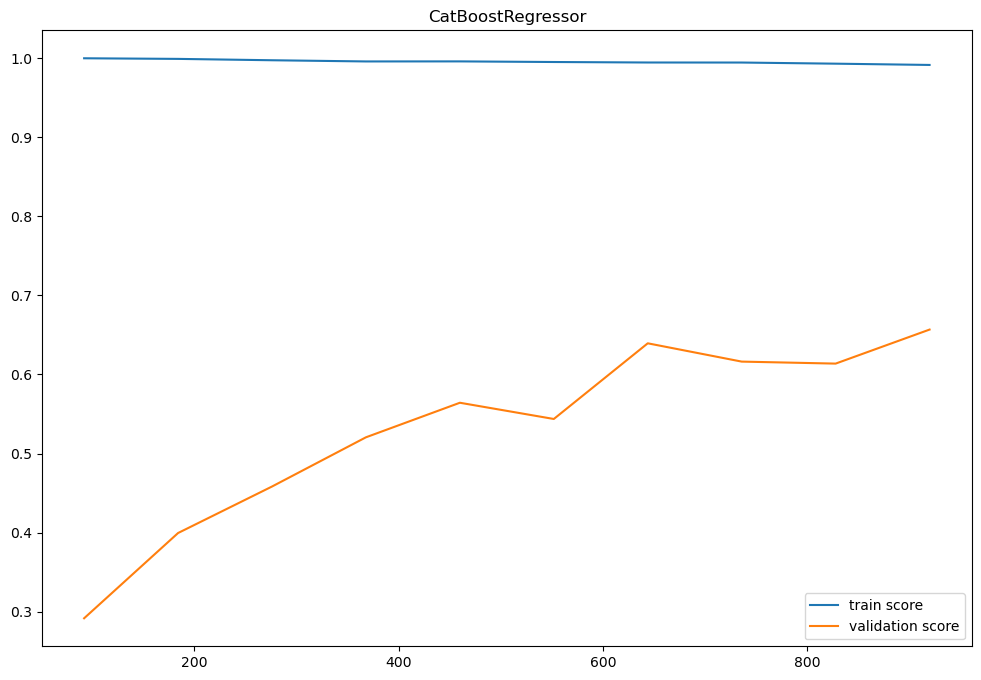

In [71]:

N, train_score, val_score = learning_curve(model_cat, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title('CatBoostRegressor')
plt.legend()

### Feature importance

0:	learn: 360.6879121	total: 32.4ms	remaining: 6.45s
1:	learn: 330.8574229	total: 33.4ms	remaining: 3.31s
2:	learn: 307.5864596	total: 34.3ms	remaining: 2.25s
3:	learn: 284.0801228	total: 35.1ms	remaining: 1.72s
4:	learn: 261.8874801	total: 35.9ms	remaining: 1.4s
5:	learn: 246.2681220	total: 36.7ms	remaining: 1.19s
6:	learn: 233.7762543	total: 37.6ms	remaining: 1.03s
7:	learn: 221.3073702	total: 38.3ms	remaining: 919ms
8:	learn: 213.0297897	total: 39.2ms	remaining: 831ms
9:	learn: 202.8345018	total: 40ms	remaining: 760ms
10:	learn: 191.9615459	total: 40.8ms	remaining: 701ms
11:	learn: 184.7187545	total: 41.5ms	remaining: 651ms
12:	learn: 180.3688228	total: 42.3ms	remaining: 608ms
13:	learn: 173.7909603	total: 42.9ms	remaining: 571ms
14:	learn: 166.6734516	total: 43.7ms	remaining: 538ms
15:	learn: 162.9593578	total: 44.5ms	remaining: 511ms
16:	learn: 158.3324642	total: 45.2ms	remaining: 487ms
17:	learn: 154.9780094	total: 45.9ms	remaining: 464ms
18:	learn: 151.0912552	total: 46.7ms	rema

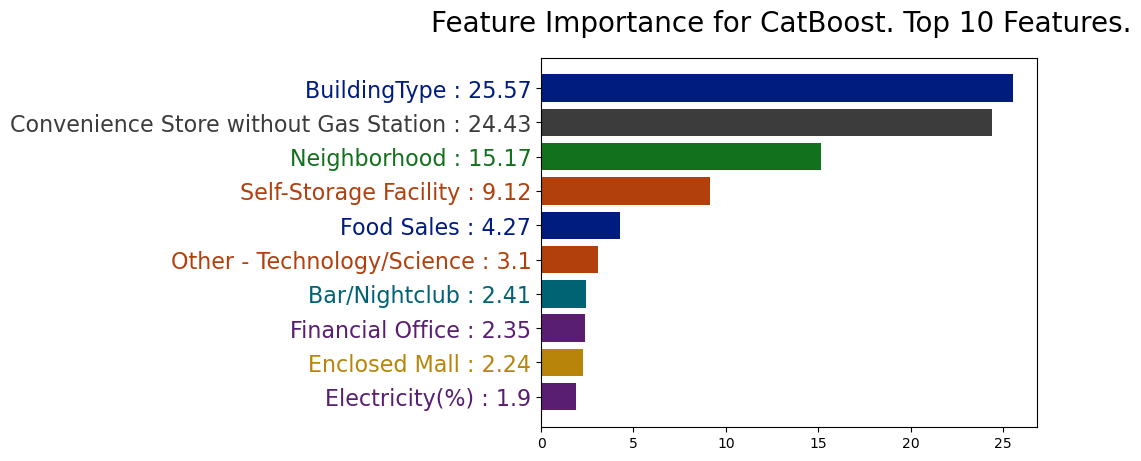

In [72]:
color_list =  sns.color_palette("dark", len(X_train.columns)) 
top_x = 10 # number of x most important features to show

model = CatBoostRegressor(random_state=0,depth = 5,
                           iterations=200,learning_rate=0.2)
X_train_nrm = preprocessor5.fit_transform(X_train,y_train)   
model.fit(X_train_nrm,y_train)

feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)
indices = indices[-top_x:]

plt.barh(range(len(indices)), feature_importance[indices], color= [color_list[indices[i]] for i in range(top_x)],
         align='center')
  
plt.yticks(range(len(indices)), [(X_train.columns[j] + ' : ' + str(round(feature_importance[j],2))) for j in indices],
           fontweight="normal", fontsize=16) 

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

plt.suptitle("Feature Importance for CatBoost. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
plt.show()

## <a name="6e"> Lasso

### Hyperparamètres

In [73]:
params = {'lasso__alpha' : 10.0**np.arange(-8,5)}

### GridSearchCV

In [74]:
# Testons les hyperparamètres avec le preprocessor0

model = make_pipeline(preprocessor0, Lasso(random_state = 0))

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                          'Distribution '
                                                                          'Center',
                                                                          'Parking', ...]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('lasso', Lasso(random_state=0))]),
             param_grid={'lasso__alpha': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])},
             scoring='r2')

In [75]:
grid.best_score_

0.5103147615487977

In [76]:
grid.best_params_

{'lasso__alpha': 10.0}

In [77]:
best_esti = grid.best_estimator_
best_esti.score(X_test,y_test)

0.5523356495936198

### Sélection du transformer

In [78]:
# Testons tous les preprocessors avec les meilleurs hyperparamètres

res_lasso_train = []
res_lasso_test = []

for ind,prep in enumerate(preprocess) :
    model = make_pipeline(prep, Lasso(random_state = 0, alpha = 10))
    model.fit(X_train,y_train)
    res_lasso_train.append(model.score(X_train,y_train))
    res_lasso_test.append(model.score(X_test,y_test))

In [79]:
resultats_finaux_lasso = pd.DataFrame(data = {'preprocessor' : range(len(res_lasso_train)),
                                            'resultats train' : res_lasso_train,
                                            'resultats test' : res_lasso_test })  
resultats_finaux_lasso.sort_values('resultats test',ascending=False)

preprocessor  resultats train  resultats test
2             2         0.600627        0.553239
0             0         0.589718        0.552336
6             6         0.613932        0.533831
4             4         0.592787        0.523822
3             3         0.513738        0.505074
7             7         0.525229        0.478015
5             5         0.277311        0.353238
1             1         0.237040        0.332241

### Meilleur modèle

In [136]:
# scores sur le test set

model_lasso = make_pipeline(preprocessor0,Lasso(random_state = 0, alpha = 10))
model_lasso.fit(X_train,y_train)
y_pred = model_lasso.predict(X_test)

scores_lasso = {'preprocessor' : 'StandardScaler et OneHotEncoder', 'R2 test' : round(model_lasso.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_lasso

{'preprocessor': 'StandardScaler et OneHotEncoder',
 'R2 test': 0.5445,
 'RMSE': 228,
 'Mean AE': 86,
 'Median AE': 35}

### Learning curve

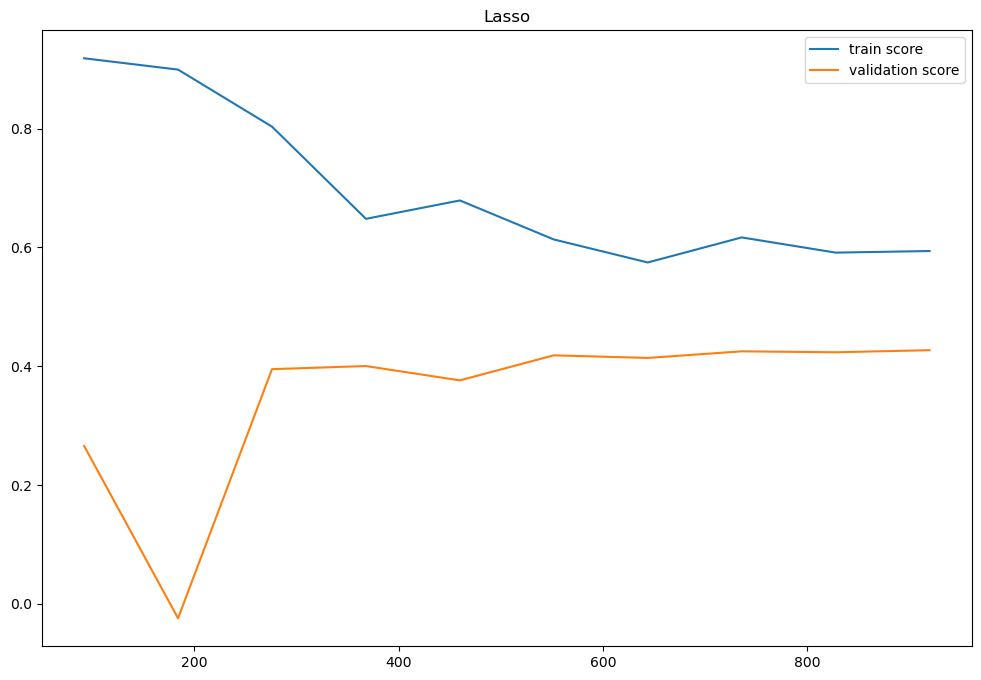

In [81]:

N, train_score, val_score = learning_curve(model_lasso, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title('Lasso')
plt.legend()

### Feature importance

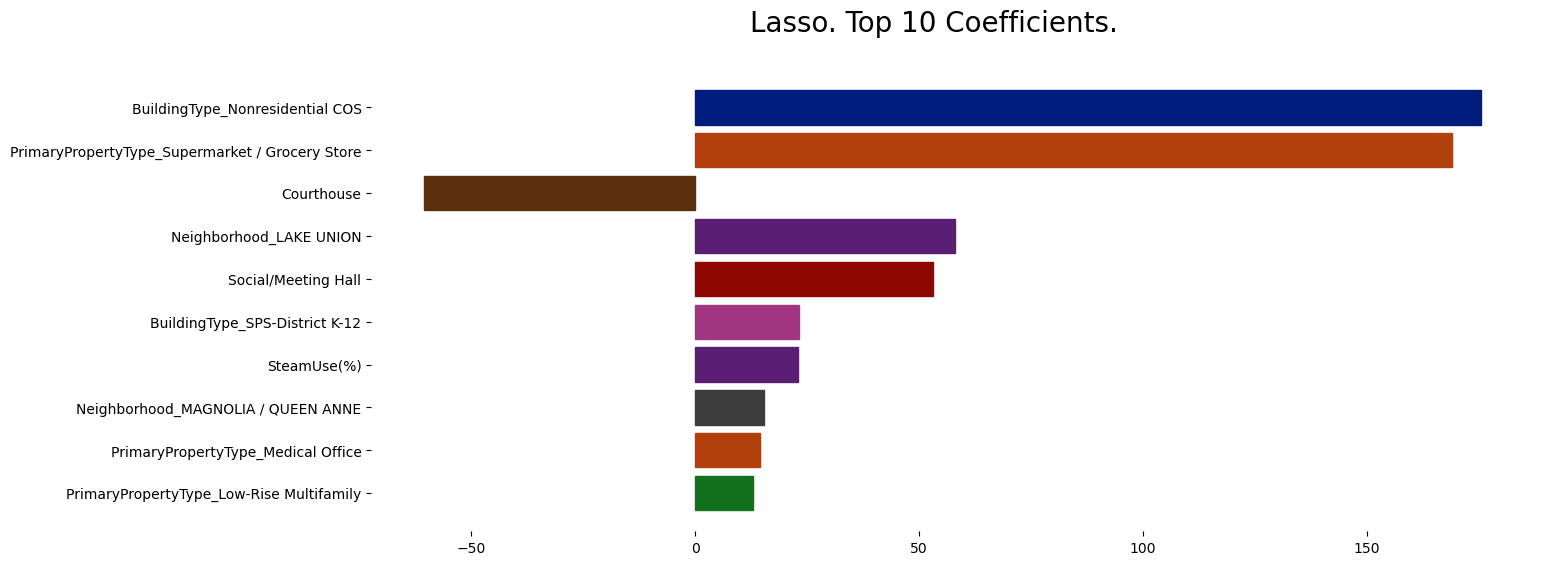

In [82]:
plt.figure(figsize=(15,6))

noms_col = preprocessor0.named_transformers_['onehotencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num

model = Lasso(random_state = 0, alpha = 10)
X_train_nrm = preprocessor0.fit_transform(X_train,y_train)
model.fit(X_train_nrm,y_train)
lasso_coeff = model.coef_

color_list =  sns.color_palette("dark", len(noms_col)) 
top_x = 10

idx = np.argsort(np.abs(lasso_coeff))[::-1][:top_x][::-1]
lasso_ax = plt.barh([noms_col[i] for i in idx], lasso_coeff[idx])

for i,bar in enumerate(lasso_ax):
    bar.set_color(color_list[idx[:top_x][::-1][i]])
    plt.box(False) 
lasso_title = plt.suptitle("Lasso. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")


# <a name="7"> Influence de l'EnergyStarScore

In [137]:
# j'ajoute la variable ENERGYSTARScore aux features

features_num.append('ENERGYSTARScore')

In [138]:
data.isna().mean().sort_values()

BuildingType               0.000000
Performing Arts            0.000000
Fire Station               0.000000
Other - Public Services    0.000000
Lifestyle Center           0.000000
                             ...   
Automobile Dealership      0.000000
College/University         0.000000
Courthouse                 0.000000
NaturalGas(%)              0.000000
ENERGYSTARScore            0.356584
Length: 79, dtype: float64

In [139]:
# je supprime les lignes sans ESS

data_reduit = data.dropna()

In [140]:
data_reduit.isna().mean().sort_values()

BuildingType               0.0
Performing Arts            0.0
Fire Station               0.0
Other - Public Services    0.0
Lifestyle Center           0.0
                          ... 
Office                     0.0
Automobile Dealership      0.0
College/University         0.0
Senior Care Community      0.0
NaturalGas(%)              0.0
Length: 79, dtype: float64

## Avec ESS

In [141]:
X = data_reduit[features_cat + features_ord + features_num]
y = data_reduit['TotalGHGEmissions']

In [142]:
# transformer

preprocessor = make_column_transformer((StandardScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                      remainder = 'passthrough')


In [89]:
# Estimateurs

est1 = neighbors.KNeighborsRegressor()
est2 = SGDRegressor(random_state = 0)
est3 = Ridge(random_state = 0)
est4 = Lasso(random_state = 0)
est5 = DecisionTreeRegressor(random_state = 0)
est6 = RandomForestRegressor(random_state = 0)
est7 = SVR()
est8 = CatBoostRegressor(random_state = 0)
est9 = GradientBoostingRegressor(random_state = 0)
est10 = ExtraTreesRegressor(random_state = 0)

models = {'KNN' : est1, 'SGDR' : est2, 'Ridge' : est3, 'Lasso' : est4, 'DecisionTree' : est5,
          'Randomforest' : est6, 'SVR' : est7,'Catboost' : est8, 'GradientBoost' : est9,'ExtraTree' : est10}

In [90]:
# Normalisation et encodage

X_nrm = preprocessor.fit_transform(X)

In [91]:
# évaluation des modèles

resultats = {}
resultats_train = []
resultats_test = []

for cle, esti in models.items() :
    resultats[cle] = (cross_validate(esti, X_nrm, y, cv=5, scoring = 'r2',return_train_score = True,error_score='raise'))
    resultats_train.append(resultats[cle]['train_score'].mean())
    resultats_test.append(resultats[cle]['test_score'].mean())

scores = pd.DataFrame(data={'r2 train_set_avec_ESS' : resultats_train,'r2 testset_avec_ESS' :resultats_test},index=models.keys())
scores

Learning rate set to 0.039438
0:	learn: 305.1482640	total: 1.39ms	remaining: 1.39s
1:	learn: 301.2415696	total: 2.62ms	remaining: 1.31s
2:	learn: 298.3459535	total: 3.78ms	remaining: 1.26s
3:	learn: 296.0053787	total: 4.93ms	remaining: 1.23s
4:	learn: 292.1954362	total: 6.02ms	remaining: 1.2s
5:	learn: 289.3715338	total: 7.07ms	remaining: 1.17s
6:	learn: 286.6703865	total: 8.11ms	remaining: 1.15s
7:	learn: 284.1888218	total: 9.12ms	remaining: 1.13s
8:	learn: 281.9859757	total: 10.3ms	remaining: 1.13s
9:	learn: 279.3231753	total: 11.4ms	remaining: 1.13s
10:	learn: 276.4305875	total: 12.5ms	remaining: 1.13s
11:	learn: 273.8023103	total: 13.7ms	remaining: 1.13s
12:	learn: 271.5507726	total: 14.9ms	remaining: 1.13s
13:	learn: 269.0596034	total: 15.9ms	remaining: 1.12s
14:	learn: 266.2537643	total: 17.1ms	remaining: 1.12s
15:	learn: 263.7744334	total: 18.2ms	remaining: 1.12s
16:	learn: 261.5664511	total: 19.3ms	remaining: 1.11s
17:	learn: 259.1891567	total: 20.3ms	remaining: 1.11s
18:	learn

183:	learn: 78.6302752	total: 190ms	remaining: 840ms
184:	learn: 78.3514160	total: 191ms	remaining: 840ms
185:	learn: 78.1099907	total: 192ms	remaining: 839ms
186:	learn: 77.8183721	total: 193ms	remaining: 838ms
187:	learn: 77.1385691	total: 194ms	remaining: 837ms
188:	learn: 76.1407685	total: 195ms	remaining: 836ms
189:	learn: 75.1659743	total: 196ms	remaining: 835ms
190:	learn: 74.9161639	total: 197ms	remaining: 833ms
191:	learn: 74.6552326	total: 198ms	remaining: 832ms
192:	learn: 74.4226195	total: 199ms	remaining: 831ms
193:	learn: 74.1861688	total: 200ms	remaining: 830ms
194:	learn: 73.9566319	total: 201ms	remaining: 829ms
195:	learn: 73.7040262	total: 202ms	remaining: 828ms
196:	learn: 72.8300804	total: 203ms	remaining: 826ms
197:	learn: 72.6133670	total: 204ms	remaining: 825ms
198:	learn: 71.8525547	total: 205ms	remaining: 824ms
199:	learn: 71.6262723	total: 206ms	remaining: 823ms
200:	learn: 71.3869671	total: 207ms	remaining: 821ms
201:	learn: 70.5360895	total: 208ms	remaining:

374:	learn: 32.8771841	total: 381ms	remaining: 635ms
375:	learn: 32.6990702	total: 382ms	remaining: 635ms
376:	learn: 32.5698504	total: 383ms	remaining: 634ms
377:	learn: 32.4309937	total: 384ms	remaining: 632ms
378:	learn: 32.3557929	total: 385ms	remaining: 631ms
379:	learn: 32.3264873	total: 386ms	remaining: 630ms
380:	learn: 32.1887002	total: 387ms	remaining: 629ms
381:	learn: 32.1588659	total: 388ms	remaining: 628ms
382:	learn: 32.0502165	total: 389ms	remaining: 627ms
383:	learn: 31.9766028	total: 390ms	remaining: 626ms
384:	learn: 31.7660319	total: 391ms	remaining: 625ms
385:	learn: 31.6572652	total: 392ms	remaining: 624ms
386:	learn: 31.5864782	total: 393ms	remaining: 623ms
387:	learn: 31.4758557	total: 394ms	remaining: 622ms
388:	learn: 31.4487121	total: 395ms	remaining: 621ms
389:	learn: 31.3274199	total: 396ms	remaining: 620ms
390:	learn: 31.2593265	total: 397ms	remaining: 619ms
391:	learn: 31.1934646	total: 398ms	remaining: 618ms
392:	learn: 31.1101393	total: 399ms	remaining:

566:	learn: 21.4561463	total: 573ms	remaining: 437ms
567:	learn: 21.4488812	total: 574ms	remaining: 436ms
568:	learn: 21.3705370	total: 575ms	remaining: 435ms
569:	learn: 21.3137204	total: 576ms	remaining: 434ms
570:	learn: 21.2958467	total: 576ms	remaining: 433ms
571:	learn: 21.2908006	total: 577ms	remaining: 432ms
572:	learn: 21.2373511	total: 578ms	remaining: 431ms
573:	learn: 21.1690330	total: 579ms	remaining: 430ms
574:	learn: 21.1182141	total: 580ms	remaining: 429ms
575:	learn: 21.0530400	total: 581ms	remaining: 428ms
576:	learn: 21.0044413	total: 582ms	remaining: 427ms
577:	learn: 20.9598152	total: 583ms	remaining: 426ms
578:	learn: 20.8977270	total: 584ms	remaining: 425ms
579:	learn: 20.8254207	total: 585ms	remaining: 424ms
580:	learn: 20.7815772	total: 586ms	remaining: 423ms
581:	learn: 20.7435488	total: 587ms	remaining: 422ms
582:	learn: 20.6921987	total: 588ms	remaining: 421ms
583:	learn: 20.6510516	total: 589ms	remaining: 420ms
584:	learn: 20.6004085	total: 590ms	remaining:

766:	learn: 15.3251032	total: 765ms	remaining: 232ms
767:	learn: 15.2912724	total: 766ms	remaining: 231ms
768:	learn: 15.2773277	total: 767ms	remaining: 230ms
769:	learn: 15.2669986	total: 768ms	remaining: 229ms
770:	learn: 15.2439907	total: 769ms	remaining: 228ms
771:	learn: 15.2123674	total: 770ms	remaining: 227ms
772:	learn: 15.1893831	total: 771ms	remaining: 227ms
773:	learn: 15.1646768	total: 772ms	remaining: 225ms
774:	learn: 15.1472344	total: 773ms	remaining: 224ms
775:	learn: 15.1347686	total: 774ms	remaining: 224ms
776:	learn: 15.0991974	total: 775ms	remaining: 223ms
777:	learn: 15.0664998	total: 776ms	remaining: 222ms
778:	learn: 15.0466854	total: 777ms	remaining: 221ms
779:	learn: 15.0226469	total: 778ms	remaining: 220ms
780:	learn: 14.9982405	total: 779ms	remaining: 219ms
781:	learn: 14.9686458	total: 780ms	remaining: 218ms
782:	learn: 14.9396916	total: 781ms	remaining: 217ms
783:	learn: 14.9372943	total: 782ms	remaining: 216ms
784:	learn: 14.9348416	total: 783ms	remaining:

959:	learn: 11.8700432	total: 958ms	remaining: 39.9ms
960:	learn: 11.8572029	total: 959ms	remaining: 38.9ms
961:	learn: 11.8386195	total: 960ms	remaining: 37.9ms
962:	learn: 11.8318251	total: 961ms	remaining: 36.9ms
963:	learn: 11.8166699	total: 962ms	remaining: 35.9ms
964:	learn: 11.7982658	total: 963ms	remaining: 34.9ms
965:	learn: 11.7755420	total: 964ms	remaining: 33.9ms
966:	learn: 11.7641086	total: 965ms	remaining: 32.9ms
967:	learn: 11.7497129	total: 966ms	remaining: 31.9ms
968:	learn: 11.7410692	total: 967ms	remaining: 30.9ms
969:	learn: 11.7230031	total: 967ms	remaining: 29.9ms
970:	learn: 11.7018223	total: 968ms	remaining: 28.9ms
971:	learn: 11.6844874	total: 969ms	remaining: 27.9ms
972:	learn: 11.6670237	total: 970ms	remaining: 26.9ms
973:	learn: 11.6562809	total: 971ms	remaining: 25.9ms
974:	learn: 11.6459955	total: 972ms	remaining: 24.9ms
975:	learn: 11.6405895	total: 973ms	remaining: 23.9ms
976:	learn: 11.6388123	total: 974ms	remaining: 22.9ms
977:	learn: 11.6182576	total

286:	learn: 51.9444911	total: 297ms	remaining: 738ms
287:	learn: 51.7875297	total: 298ms	remaining: 737ms
288:	learn: 51.6924813	total: 299ms	remaining: 736ms
289:	learn: 51.4878918	total: 300ms	remaining: 734ms
290:	learn: 51.3673067	total: 301ms	remaining: 733ms
291:	learn: 51.1839930	total: 302ms	remaining: 732ms
292:	learn: 51.1215728	total: 303ms	remaining: 731ms
293:	learn: 50.9306636	total: 304ms	remaining: 730ms
294:	learn: 50.8047077	total: 305ms	remaining: 729ms
295:	learn: 50.5341799	total: 306ms	remaining: 727ms
296:	learn: 50.3558622	total: 307ms	remaining: 726ms
297:	learn: 50.2421538	total: 308ms	remaining: 725ms
298:	learn: 50.0295450	total: 309ms	remaining: 724ms
299:	learn: 49.8361954	total: 310ms	remaining: 722ms
300:	learn: 49.6750966	total: 311ms	remaining: 721ms
301:	learn: 49.5293808	total: 312ms	remaining: 720ms
302:	learn: 49.2196293	total: 312ms	remaining: 719ms
303:	learn: 48.9220360	total: 313ms	remaining: 718ms
304:	learn: 48.6731730	total: 314ms	remaining:

473:	learn: 30.2571052	total: 489ms	remaining: 542ms
474:	learn: 30.2472101	total: 490ms	remaining: 541ms
475:	learn: 30.2027643	total: 491ms	remaining: 540ms
476:	learn: 30.1081540	total: 492ms	remaining: 539ms
477:	learn: 30.0706924	total: 493ms	remaining: 538ms
478:	learn: 29.9757299	total: 494ms	remaining: 537ms
479:	learn: 29.8788127	total: 495ms	remaining: 536ms
480:	learn: 29.8170441	total: 496ms	remaining: 535ms
481:	learn: 29.7237856	total: 497ms	remaining: 534ms
482:	learn: 29.6698337	total: 498ms	remaining: 533ms
483:	learn: 29.6167725	total: 499ms	remaining: 532ms
484:	learn: 29.5504362	total: 500ms	remaining: 531ms
485:	learn: 29.5143371	total: 501ms	remaining: 529ms
486:	learn: 29.4290192	total: 502ms	remaining: 529ms
487:	learn: 29.3576424	total: 503ms	remaining: 528ms
488:	learn: 29.2475008	total: 504ms	remaining: 527ms
489:	learn: 29.1345318	total: 505ms	remaining: 525ms
490:	learn: 29.0562503	total: 506ms	remaining: 524ms
491:	learn: 28.9909240	total: 507ms	remaining:

674:	learn: 20.3994436	total: 687ms	remaining: 331ms
675:	learn: 20.3343973	total: 688ms	remaining: 330ms
676:	learn: 20.2720853	total: 689ms	remaining: 329ms
677:	learn: 20.2387083	total: 690ms	remaining: 328ms
678:	learn: 20.1989957	total: 691ms	remaining: 327ms
679:	learn: 20.1851589	total: 692ms	remaining: 325ms
680:	learn: 20.1454051	total: 693ms	remaining: 324ms
681:	learn: 20.0954305	total: 694ms	remaining: 323ms
682:	learn: 20.0522600	total: 695ms	remaining: 322ms
683:	learn: 20.0047189	total: 695ms	remaining: 321ms
684:	learn: 19.9674707	total: 697ms	remaining: 320ms
685:	learn: 19.9273811	total: 697ms	remaining: 319ms
686:	learn: 19.8855797	total: 698ms	remaining: 318ms
687:	learn: 19.8808773	total: 699ms	remaining: 317ms
688:	learn: 19.8457535	total: 700ms	remaining: 316ms
689:	learn: 19.8199262	total: 701ms	remaining: 315ms
690:	learn: 19.7842240	total: 702ms	remaining: 314ms
691:	learn: 19.7575397	total: 703ms	remaining: 313ms
692:	learn: 19.7024395	total: 704ms	remaining:

872:	learn: 15.7606359	total: 879ms	remaining: 128ms
873:	learn: 15.7418937	total: 880ms	remaining: 127ms
874:	learn: 15.7009636	total: 881ms	remaining: 126ms
875:	learn: 15.6741147	total: 882ms	remaining: 125ms
876:	learn: 15.6504610	total: 883ms	remaining: 124ms
877:	learn: 15.6480884	total: 884ms	remaining: 123ms
878:	learn: 15.6188189	total: 885ms	remaining: 122ms
879:	learn: 15.5840452	total: 886ms	remaining: 121ms
880:	learn: 15.5508483	total: 887ms	remaining: 120ms
881:	learn: 15.5157042	total: 888ms	remaining: 119ms
882:	learn: 15.4847823	total: 889ms	remaining: 118ms
883:	learn: 15.4515329	total: 890ms	remaining: 117ms
884:	learn: 15.4277597	total: 891ms	remaining: 116ms
885:	learn: 15.3933262	total: 892ms	remaining: 115ms
886:	learn: 15.3768059	total: 893ms	remaining: 114ms
887:	learn: 15.3610582	total: 894ms	remaining: 113ms
888:	learn: 15.3388664	total: 895ms	remaining: 112ms
889:	learn: 15.3066783	total: 896ms	remaining: 111ms
890:	learn: 15.2830276	total: 897ms	remaining:

196:	learn: 85.6510603	total: 226ms	remaining: 920ms
197:	learn: 85.3415097	total: 227ms	remaining: 918ms
198:	learn: 85.0592149	total: 228ms	remaining: 917ms
199:	learn: 84.7068147	total: 229ms	remaining: 915ms
200:	learn: 84.4808267	total: 230ms	remaining: 913ms
201:	learn: 84.0544033	total: 231ms	remaining: 911ms
202:	learn: 83.6067169	total: 232ms	remaining: 909ms
203:	learn: 83.1530174	total: 233ms	remaining: 908ms
204:	learn: 82.5797865	total: 234ms	remaining: 906ms
205:	learn: 82.2380255	total: 234ms	remaining: 904ms
206:	learn: 81.4425640	total: 235ms	remaining: 902ms
207:	learn: 80.7633811	total: 236ms	remaining: 900ms
208:	learn: 80.3979401	total: 237ms	remaining: 899ms
209:	learn: 79.8140459	total: 238ms	remaining: 897ms
210:	learn: 79.6051855	total: 239ms	remaining: 895ms
211:	learn: 79.3834640	total: 240ms	remaining: 893ms
212:	learn: 78.8247917	total: 241ms	remaining: 892ms
213:	learn: 78.6320928	total: 242ms	remaining: 890ms
214:	learn: 78.1909469	total: 243ms	remaining:

395:	learn: 39.9283584	total: 418ms	remaining: 638ms
396:	learn: 39.8244131	total: 419ms	remaining: 637ms
397:	learn: 39.7692806	total: 420ms	remaining: 636ms
398:	learn: 39.6318917	total: 421ms	remaining: 635ms
399:	learn: 39.4833531	total: 422ms	remaining: 633ms
400:	learn: 39.3855071	total: 423ms	remaining: 632ms
401:	learn: 39.2637438	total: 424ms	remaining: 631ms
402:	learn: 39.2143551	total: 425ms	remaining: 630ms
403:	learn: 39.0355664	total: 426ms	remaining: 629ms
404:	learn: 38.8862439	total: 427ms	remaining: 627ms
405:	learn: 38.8365805	total: 428ms	remaining: 626ms
406:	learn: 38.7024402	total: 429ms	remaining: 625ms
407:	learn: 38.5581321	total: 430ms	remaining: 624ms
408:	learn: 38.4109816	total: 431ms	remaining: 623ms
409:	learn: 38.3322605	total: 432ms	remaining: 621ms
410:	learn: 38.2154830	total: 433ms	remaining: 620ms
411:	learn: 38.2017663	total: 434ms	remaining: 619ms
412:	learn: 38.0992968	total: 435ms	remaining: 618ms
413:	learn: 37.9490290	total: 436ms	remaining:

592:	learn: 25.1275601	total: 611ms	remaining: 419ms
593:	learn: 25.0723150	total: 612ms	remaining: 418ms
594:	learn: 25.0147533	total: 613ms	remaining: 417ms
595:	learn: 24.9691218	total: 614ms	remaining: 416ms
596:	learn: 24.9022052	total: 615ms	remaining: 415ms
597:	learn: 24.8396341	total: 616ms	remaining: 414ms
598:	learn: 24.7760491	total: 617ms	remaining: 413ms
599:	learn: 24.7680446	total: 618ms	remaining: 412ms
600:	learn: 24.7227562	total: 619ms	remaining: 411ms
601:	learn: 24.6573242	total: 619ms	remaining: 410ms
602:	learn: 24.6370267	total: 620ms	remaining: 408ms
603:	learn: 24.5801049	total: 621ms	remaining: 407ms
604:	learn: 24.5231497	total: 622ms	remaining: 406ms
605:	learn: 24.4649133	total: 623ms	remaining: 405ms
606:	learn: 24.4160536	total: 624ms	remaining: 404ms
607:	learn: 24.3412621	total: 625ms	remaining: 403ms
608:	learn: 24.2832992	total: 626ms	remaining: 402ms
609:	learn: 24.2323043	total: 627ms	remaining: 401ms
610:	learn: 24.1875102	total: 628ms	remaining:

794:	learn: 18.0515182	total: 804ms	remaining: 207ms
795:	learn: 18.0061875	total: 805ms	remaining: 206ms
796:	learn: 17.9778945	total: 806ms	remaining: 205ms
797:	learn: 17.9488947	total: 807ms	remaining: 204ms
798:	learn: 17.9024515	total: 808ms	remaining: 203ms
799:	learn: 17.8917974	total: 809ms	remaining: 202ms
800:	learn: 17.8614745	total: 810ms	remaining: 201ms
801:	learn: 17.8209425	total: 811ms	remaining: 200ms
802:	learn: 17.8092393	total: 812ms	remaining: 199ms
803:	learn: 17.8062346	total: 813ms	remaining: 198ms
804:	learn: 17.8033057	total: 814ms	remaining: 197ms
805:	learn: 17.7824998	total: 815ms	remaining: 196ms
806:	learn: 17.7510379	total: 816ms	remaining: 195ms
807:	learn: 17.7114763	total: 817ms	remaining: 194ms
808:	learn: 17.6808378	total: 818ms	remaining: 193ms
809:	learn: 17.6779566	total: 819ms	remaining: 192ms
810:	learn: 17.6751322	total: 820ms	remaining: 191ms
811:	learn: 17.6408700	total: 821ms	remaining: 190ms
812:	learn: 17.6227151	total: 821ms	remaining:

991:	learn: 14.3798362	total: 995ms	remaining: 8.03ms
992:	learn: 14.3416071	total: 996ms	remaining: 7.02ms
993:	learn: 14.3179351	total: 997ms	remaining: 6.02ms
994:	learn: 14.2938550	total: 998ms	remaining: 5.02ms
995:	learn: 14.2853269	total: 999ms	remaining: 4.01ms
996:	learn: 14.2471644	total: 1s	remaining: 3.01ms
997:	learn: 14.2226456	total: 1s	remaining: 2.01ms
998:	learn: 14.2065266	total: 1s	remaining: 1ms
999:	learn: 14.1830341	total: 1s	remaining: 0us
Learning rate set to 0.039446
0:	learn: 369.1687523	total: 20.4ms	remaining: 20.4s
1:	learn: 363.1635757	total: 21.9ms	remaining: 10.9s
2:	learn: 359.4816599	total: 23.5ms	remaining: 7.79s
3:	learn: 353.6322055	total: 24.8ms	remaining: 6.17s
4:	learn: 348.5927742	total: 26.4ms	remaining: 5.25s
5:	learn: 343.2213051	total: 27.8ms	remaining: 4.61s
6:	learn: 338.2819679	total: 29.4ms	remaining: 4.18s
7:	learn: 333.9358602	total: 30.9ms	remaining: 3.83s
8:	learn: 329.5180560	total: 32.3ms	remaining: 3.56s
9:	learn: 324.7922729	tot

232:	learn: 67.2168191	total: 318ms	remaining: 1.05s
233:	learn: 66.9157624	total: 319ms	remaining: 1.04s
234:	learn: 66.6142548	total: 321ms	remaining: 1.04s
235:	learn: 66.4588243	total: 322ms	remaining: 1.04s
236:	learn: 66.2162352	total: 323ms	remaining: 1.04s
237:	learn: 65.7272398	total: 324ms	remaining: 1.04s
238:	learn: 65.5054330	total: 325ms	remaining: 1.04s
239:	learn: 65.1075048	total: 327ms	remaining: 1.03s
240:	learn: 64.8487645	total: 328ms	remaining: 1.03s
241:	learn: 64.7173005	total: 329ms	remaining: 1.03s
242:	learn: 64.1769014	total: 330ms	remaining: 1.03s
243:	learn: 63.9686425	total: 332ms	remaining: 1.03s
244:	learn: 63.5323594	total: 333ms	remaining: 1.02s
245:	learn: 63.2431420	total: 334ms	remaining: 1.02s
246:	learn: 62.9119575	total: 335ms	remaining: 1.02s
247:	learn: 62.6847100	total: 336ms	remaining: 1.02s
248:	learn: 62.3431877	total: 337ms	remaining: 1.02s
249:	learn: 62.1511099	total: 338ms	remaining: 1.01s
250:	learn: 61.8434581	total: 340ms	remaining:

388:	learn: 37.5334446	total: 513ms	remaining: 807ms
389:	learn: 37.3704484	total: 515ms	remaining: 805ms
390:	learn: 37.3003959	total: 516ms	remaining: 804ms
391:	learn: 37.1821895	total: 517ms	remaining: 802ms
392:	learn: 37.1030304	total: 519ms	remaining: 801ms
393:	learn: 36.9886816	total: 520ms	remaining: 799ms
394:	learn: 36.8502259	total: 521ms	remaining: 798ms
395:	learn: 36.6824756	total: 522ms	remaining: 796ms
396:	learn: 36.5780001	total: 523ms	remaining: 795ms
397:	learn: 36.4793138	total: 525ms	remaining: 793ms
398:	learn: 36.4331055	total: 526ms	remaining: 792ms
399:	learn: 36.3053953	total: 527ms	remaining: 790ms
400:	learn: 36.2019239	total: 528ms	remaining: 789ms
401:	learn: 36.0943001	total: 529ms	remaining: 787ms
402:	learn: 35.9851905	total: 531ms	remaining: 786ms
403:	learn: 35.8841335	total: 532ms	remaining: 784ms
404:	learn: 35.7980888	total: 533ms	remaining: 783ms
405:	learn: 35.6911029	total: 534ms	remaining: 782ms
406:	learn: 35.5718921	total: 535ms	remaining:

699:	learn: 20.5278072	total: 910ms	remaining: 390ms
700:	learn: 20.5220696	total: 911ms	remaining: 389ms
701:	learn: 20.4854894	total: 913ms	remaining: 387ms
702:	learn: 20.4669817	total: 914ms	remaining: 386ms
703:	learn: 20.4197522	total: 915ms	remaining: 385ms
704:	learn: 20.3962805	total: 916ms	remaining: 383ms
705:	learn: 20.3727648	total: 917ms	remaining: 382ms
706:	learn: 20.3238091	total: 918ms	remaining: 381ms
707:	learn: 20.2836262	total: 920ms	remaining: 379ms
708:	learn: 20.2779416	total: 921ms	remaining: 378ms
709:	learn: 20.2272823	total: 925ms	remaining: 378ms
710:	learn: 20.1885509	total: 926ms	remaining: 376ms
711:	learn: 20.1842671	total: 927ms	remaining: 375ms
712:	learn: 20.1630812	total: 929ms	remaining: 374ms
713:	learn: 20.1192002	total: 930ms	remaining: 372ms
714:	learn: 20.1073943	total: 931ms	remaining: 371ms
715:	learn: 20.0597712	total: 932ms	remaining: 370ms
716:	learn: 20.0542861	total: 933ms	remaining: 368ms
717:	learn: 20.0105516	total: 935ms	remaining:

982:	learn: 14.4340523	total: 1.3s	remaining: 22.5ms
983:	learn: 14.4191712	total: 1.3s	remaining: 21.2ms
984:	learn: 14.3938202	total: 1.3s	remaining: 19.8ms
985:	learn: 14.3699065	total: 1.3s	remaining: 18.5ms
986:	learn: 14.3434258	total: 1.3s	remaining: 17.2ms
987:	learn: 14.3376404	total: 1.3s	remaining: 15.9ms
988:	learn: 14.3210284	total: 1.31s	remaining: 14.5ms
989:	learn: 14.3102016	total: 1.31s	remaining: 13.2ms
990:	learn: 14.2887855	total: 1.31s	remaining: 11.9ms
991:	learn: 14.2774525	total: 1.31s	remaining: 10.6ms
992:	learn: 14.2441802	total: 1.31s	remaining: 9.25ms
993:	learn: 14.2104556	total: 1.31s	remaining: 7.92ms
994:	learn: 14.2028831	total: 1.31s	remaining: 6.6ms
995:	learn: 14.1536522	total: 1.31s	remaining: 5.28ms
996:	learn: 14.1151047	total: 1.32s	remaining: 3.96ms
997:	learn: 14.0922025	total: 1.32s	remaining: 2.64ms
998:	learn: 14.0740017	total: 1.32s	remaining: 1.32ms
999:	learn: 14.0658817	total: 1.32s	remaining: 0us
Learning rate set to 0.039446
0:	learn

320:	learn: 44.4048746	total: 316ms	remaining: 668ms
321:	learn: 44.2358525	total: 317ms	remaining: 667ms
322:	learn: 44.0394738	total: 318ms	remaining: 666ms
323:	learn: 43.8967112	total: 319ms	remaining: 665ms
324:	learn: 43.6555675	total: 320ms	remaining: 664ms
325:	learn: 43.4854818	total: 321ms	remaining: 663ms
326:	learn: 43.3635198	total: 322ms	remaining: 663ms
327:	learn: 43.1790701	total: 323ms	remaining: 662ms
328:	learn: 42.8923512	total: 324ms	remaining: 661ms
329:	learn: 42.6894444	total: 325ms	remaining: 660ms
330:	learn: 42.5541587	total: 326ms	remaining: 659ms
331:	learn: 42.3128347	total: 327ms	remaining: 658ms
332:	learn: 42.0689319	total: 328ms	remaining: 657ms
333:	learn: 41.9031003	total: 329ms	remaining: 656ms
334:	learn: 41.7368644	total: 330ms	remaining: 655ms
335:	learn: 41.5985316	total: 331ms	remaining: 655ms
336:	learn: 41.5466623	total: 332ms	remaining: 654ms
337:	learn: 41.3517200	total: 333ms	remaining: 653ms
338:	learn: 41.2377241	total: 334ms	remaining:

505:	learn: 26.6462924	total: 508ms	remaining: 496ms
506:	learn: 26.5964811	total: 509ms	remaining: 495ms
507:	learn: 26.5231683	total: 510ms	remaining: 494ms
508:	learn: 26.4312316	total: 511ms	remaining: 493ms
509:	learn: 26.3597179	total: 512ms	remaining: 492ms
510:	learn: 26.2724081	total: 513ms	remaining: 491ms
511:	learn: 26.1919712	total: 514ms	remaining: 489ms
512:	learn: 26.1478363	total: 515ms	remaining: 488ms
513:	learn: 26.0815312	total: 515ms	remaining: 487ms
514:	learn: 26.0326216	total: 516ms	remaining: 486ms
515:	learn: 25.9372304	total: 517ms	remaining: 485ms
516:	learn: 25.8755351	total: 518ms	remaining: 484ms
517:	learn: 25.8105258	total: 519ms	remaining: 483ms
518:	learn: 25.7421035	total: 520ms	remaining: 482ms
519:	learn: 25.6547610	total: 521ms	remaining: 481ms
520:	learn: 25.5673546	total: 522ms	remaining: 480ms
521:	learn: 25.4963635	total: 523ms	remaining: 479ms
522:	learn: 25.4452912	total: 524ms	remaining: 478ms
523:	learn: 25.4028795	total: 525ms	remaining:

704:	learn: 18.3720005	total: 700ms	remaining: 293ms
705:	learn: 18.3679214	total: 701ms	remaining: 292ms
706:	learn: 18.3390995	total: 702ms	remaining: 291ms
707:	learn: 18.3351819	total: 703ms	remaining: 290ms
708:	learn: 18.3188184	total: 704ms	remaining: 289ms
709:	learn: 18.2661623	total: 705ms	remaining: 288ms
710:	learn: 18.2340195	total: 706ms	remaining: 287ms
711:	learn: 18.2197245	total: 707ms	remaining: 286ms
712:	learn: 18.2018475	total: 708ms	remaining: 285ms
713:	learn: 18.1881855	total: 709ms	remaining: 284ms
714:	learn: 18.1842565	total: 710ms	remaining: 283ms
715:	learn: 18.1539741	total: 711ms	remaining: 282ms
716:	learn: 18.1120503	total: 712ms	remaining: 281ms
717:	learn: 18.0644519	total: 713ms	remaining: 280ms
718:	learn: 18.0276422	total: 714ms	remaining: 279ms
719:	learn: 17.9992228	total: 715ms	remaining: 278ms
720:	learn: 17.9954442	total: 716ms	remaining: 277ms
721:	learn: 17.9916619	total: 717ms	remaining: 276ms
722:	learn: 17.9879496	total: 718ms	remaining:

894:	learn: 14.3446835	total: 892ms	remaining: 105ms
895:	learn: 14.3373422	total: 893ms	remaining: 104ms
896:	learn: 14.3351353	total: 894ms	remaining: 103ms
897:	learn: 14.3159056	total: 895ms	remaining: 102ms
898:	learn: 14.2873818	total: 896ms	remaining: 101ms
899:	learn: 14.2466014	total: 897ms	remaining: 99.7ms
900:	learn: 14.2286835	total: 898ms	remaining: 98.7ms
901:	learn: 14.2145361	total: 899ms	remaining: 97.7ms
902:	learn: 14.2021567	total: 900ms	remaining: 96.7ms
903:	learn: 14.1681564	total: 901ms	remaining: 95.7ms
904:	learn: 14.1374112	total: 902ms	remaining: 94.7ms
905:	learn: 14.1190474	total: 903ms	remaining: 93.7ms
906:	learn: 14.0973750	total: 904ms	remaining: 92.7ms
907:	learn: 14.0835707	total: 905ms	remaining: 91.7ms
908:	learn: 14.0745592	total: 906ms	remaining: 90.7ms
909:	learn: 14.0500802	total: 907ms	remaining: 89.7ms
910:	learn: 14.0478545	total: 908ms	remaining: 88.7ms
911:	learn: 14.0442364	total: 909ms	remaining: 87.7ms
912:	learn: 14.0197397	total: 910

r2 train_set_avec_ESS  r2 testset_avec_ESS
KNN                         0.600512             0.143323
SGDR                        0.656674            -0.150651
Ridge                       0.731070            -0.043513
Lasso                       0.722653             0.096949
DecisionTree                1.000000             0.189832
Randomforest                0.938319             0.649954
SVR                        -0.018622            -0.054053
Catboost                    0.998704             0.611664
GradientBoost               0.990136             0.664393
ExtraTree                   1.000000             0.599142

In [143]:
X_train , X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=0)

model_randfor.fit(X_train,y_train)
y_pred = model_randfor.predict(X_test)
scores_randfor_ess = {'preprocessor' : 'MinMaxScaler et TargetEncoder', 'R2 test' : round(model_randfor.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))),
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}


model_gradboost.fit(X_train,y_train)
y_pred = model_gradboost.predict(X_test)
scores_gradboost_ess = {'preprocessor' : 'Log et OneHotEncoder', 'R2 test' : round(model_gradboost.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))),
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}


model_cat.fit(X_train,y_train)
y_pred = model_cat.predict(X_test)
scores_cat_ess = {'preprocessor' : 'MinMax et TagetEncoder', 'R2 test' : round(model_cat.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}


model_lasso.fit(X_train,y_train)
y_pred = model_lasso.predict(X_test)
scores_lasso_ess = {'preprocessor' : 'StandardScaler et OneHotEncoder', 'R2 test' : round(model_lasso.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}

0:	learn: 348.8886001	total: 556us	remaining: 333ms
1:	learn: 324.8518571	total: 1.22ms	remaining: 364ms
2:	learn: 308.2289998	total: 1.66ms	remaining: 331ms
3:	learn: 290.9290577	total: 2.03ms	remaining: 303ms
4:	learn: 270.7924709	total: 2.44ms	remaining: 291ms
5:	learn: 255.3418920	total: 2.79ms	remaining: 276ms
6:	learn: 242.7358002	total: 3.15ms	remaining: 267ms
7:	learn: 232.4603329	total: 3.52ms	remaining: 260ms
8:	learn: 223.0354124	total: 3.83ms	remaining: 252ms
9:	learn: 214.7366626	total: 4.18ms	remaining: 247ms
10:	learn: 202.2256734	total: 4.53ms	remaining: 243ms
11:	learn: 196.2386885	total: 4.85ms	remaining: 238ms
12:	learn: 189.5107587	total: 5.29ms	remaining: 239ms
13:	learn: 185.1139710	total: 5.67ms	remaining: 237ms
14:	learn: 173.8318749	total: 6.05ms	remaining: 236ms
15:	learn: 170.2177390	total: 6.47ms	remaining: 236ms
16:	learn: 166.1337669	total: 6.85ms	remaining: 235ms
17:	learn: 160.3781105	total: 7.18ms	remaining: 232ms
18:	learn: 156.9667371	total: 7.57ms	re

565:	learn: 14.9191852	total: 185ms	remaining: 11.1ms
566:	learn: 14.8848256	total: 185ms	remaining: 10.8ms
567:	learn: 14.8235634	total: 186ms	remaining: 10.5ms
568:	learn: 14.8000198	total: 186ms	remaining: 10.1ms
569:	learn: 14.7727218	total: 187ms	remaining: 9.82ms
570:	learn: 14.7705570	total: 187ms	remaining: 9.49ms
571:	learn: 14.7470837	total: 187ms	remaining: 9.17ms
572:	learn: 14.7423490	total: 188ms	remaining: 8.84ms
573:	learn: 14.7294166	total: 188ms	remaining: 8.52ms
574:	learn: 14.6938844	total: 188ms	remaining: 8.19ms
575:	learn: 14.6705789	total: 189ms	remaining: 7.86ms
576:	learn: 14.6673769	total: 189ms	remaining: 7.53ms
577:	learn: 14.6349227	total: 189ms	remaining: 7.21ms
578:	learn: 14.6136602	total: 190ms	remaining: 6.88ms
579:	learn: 14.5905059	total: 190ms	remaining: 6.55ms
580:	learn: 14.5457864	total: 190ms	remaining: 6.22ms
581:	learn: 14.5406692	total: 191ms	remaining: 5.9ms
582:	learn: 14.5121711	total: 191ms	remaining: 5.57ms
583:	learn: 14.4944999	total:

## Sans ESS

In [144]:
# je supprime la variable ENERGYSTARScore

features_num.remove('ENERGYSTARScore')
X = X.drop('ENERGYSTARScore',axis=1)

In [145]:
# normalisation et encodage

X_nrm = preprocessor.fit_transform(X)

In [146]:
# évaluation des modèles

resultats = {}
resultats_train = []
resultats_test = []

for cle, esti in models.items() :
    resultats[cle] = (cross_validate(esti, X_nrm, y, cv=5, scoring = 'r2',return_train_score = True,error_score='raise'))
    resultats_train.append(resultats[cle]['train_score'].mean())
    resultats_test.append(resultats[cle]['test_score'].mean())



Learning rate set to 0.039438
0:	learn: 305.0893501	total: 16.9ms	remaining: 16.8s
1:	learn: 301.0558309	total: 18.3ms	remaining: 9.15s
2:	learn: 297.2389788	total: 19.5ms	remaining: 6.49s
3:	learn: 293.5176738	total: 20.8ms	remaining: 5.18s
4:	learn: 291.4739953	total: 22ms	remaining: 4.37s
5:	learn: 288.8066726	total: 23ms	remaining: 3.81s
6:	learn: 285.6426580	total: 24.3ms	remaining: 3.44s
7:	learn: 283.0139104	total: 25.4ms	remaining: 3.15s
8:	learn: 279.5861237	total: 26.5ms	remaining: 2.91s
9:	learn: 277.1147076	total: 27.5ms	remaining: 2.72s
10:	learn: 274.5451411	total: 28.5ms	remaining: 2.56s
11:	learn: 272.6249196	total: 38.4ms	remaining: 3.16s
12:	learn: 269.8852392	total: 39.5ms	remaining: 3s
13:	learn: 267.3947949	total: 40.8ms	remaining: 2.88s
14:	learn: 264.0512585	total: 42ms	remaining: 2.76s
15:	learn: 260.8394278	total: 43.1ms	remaining: 2.65s
16:	learn: 258.4304949	total: 44.2ms	remaining: 2.56s
17:	learn: 256.2391011	total: 45.3ms	remaining: 2.47s
18:	learn: 253.95

177:	learn: 83.9134484	total: 201ms	remaining: 927ms
178:	learn: 83.1338885	total: 202ms	remaining: 925ms
179:	learn: 82.1770187	total: 203ms	remaining: 923ms
180:	learn: 81.7543602	total: 204ms	remaining: 921ms
181:	learn: 80.9400236	total: 204ms	remaining: 919ms
182:	learn: 80.6569269	total: 205ms	remaining: 917ms
183:	learn: 80.3519821	total: 206ms	remaining: 915ms
184:	learn: 80.0610486	total: 207ms	remaining: 913ms
185:	learn: 79.6476603	total: 208ms	remaining: 911ms
186:	learn: 79.3139855	total: 209ms	remaining: 909ms
187:	learn: 79.0521561	total: 210ms	remaining: 907ms
188:	learn: 78.7770336	total: 211ms	remaining: 905ms
189:	learn: 78.5264764	total: 212ms	remaining: 903ms
190:	learn: 78.2786719	total: 213ms	remaining: 901ms
191:	learn: 78.0175254	total: 214ms	remaining: 899ms
192:	learn: 77.7334830	total: 215ms	remaining: 897ms
193:	learn: 77.4814123	total: 216ms	remaining: 895ms
194:	learn: 76.5791521	total: 216ms	remaining: 894ms
195:	learn: 75.7791192	total: 217ms	remaining:

387:	learn: 36.9314826	total: 395ms	remaining: 623ms
388:	learn: 36.8424507	total: 396ms	remaining: 622ms
389:	learn: 36.8052601	total: 397ms	remaining: 621ms
390:	learn: 36.6372215	total: 398ms	remaining: 619ms
391:	learn: 36.6082328	total: 399ms	remaining: 618ms
392:	learn: 36.5157671	total: 400ms	remaining: 617ms
393:	learn: 36.4768981	total: 400ms	remaining: 616ms
394:	learn: 36.3316798	total: 401ms	remaining: 615ms
395:	learn: 36.2730316	total: 402ms	remaining: 614ms
396:	learn: 36.1797299	total: 403ms	remaining: 612ms
397:	learn: 36.0127994	total: 404ms	remaining: 611ms
398:	learn: 35.9282855	total: 405ms	remaining: 610ms
399:	learn: 35.7784409	total: 406ms	remaining: 609ms
400:	learn: 35.7462447	total: 407ms	remaining: 608ms
401:	learn: 35.6682906	total: 408ms	remaining: 607ms
402:	learn: 35.5994342	total: 409ms	remaining: 606ms
403:	learn: 35.4742669	total: 410ms	remaining: 605ms
404:	learn: 35.3949318	total: 411ms	remaining: 604ms
405:	learn: 35.3200841	total: 412ms	remaining:

602:	learn: 26.0198996	total: 592ms	remaining: 390ms
603:	learn: 25.9827715	total: 593ms	remaining: 389ms
604:	learn: 25.9406099	total: 594ms	remaining: 388ms
605:	learn: 25.9003007	total: 595ms	remaining: 387ms
606:	learn: 25.8799627	total: 596ms	remaining: 386ms
607:	learn: 25.8725041	total: 597ms	remaining: 385ms
608:	learn: 25.8357309	total: 598ms	remaining: 384ms
609:	learn: 25.7524450	total: 599ms	remaining: 383ms
610:	learn: 25.7448597	total: 600ms	remaining: 382ms
611:	learn: 25.7207141	total: 601ms	remaining: 381ms
612:	learn: 25.6749101	total: 602ms	remaining: 380ms
613:	learn: 25.6258321	total: 603ms	remaining: 379ms
614:	learn: 25.5988195	total: 604ms	remaining: 378ms
615:	learn: 25.5251337	total: 605ms	remaining: 377ms
616:	learn: 25.5175187	total: 606ms	remaining: 376ms
617:	learn: 25.5056925	total: 607ms	remaining: 375ms
618:	learn: 25.4292131	total: 608ms	remaining: 374ms
619:	learn: 25.3930533	total: 609ms	remaining: 373ms
620:	learn: 25.3698334	total: 610ms	remaining:

792:	learn: 21.2391782	total: 791ms	remaining: 206ms
793:	learn: 21.2282707	total: 792ms	remaining: 205ms
794:	learn: 21.2049393	total: 793ms	remaining: 204ms
795:	learn: 21.2024385	total: 794ms	remaining: 204ms
796:	learn: 21.1685814	total: 795ms	remaining: 203ms
797:	learn: 21.1477909	total: 796ms	remaining: 202ms
798:	learn: 21.1426250	total: 797ms	remaining: 201ms
799:	learn: 21.1342758	total: 798ms	remaining: 200ms
800:	learn: 21.0824238	total: 799ms	remaining: 199ms
801:	learn: 21.0470147	total: 800ms	remaining: 198ms
802:	learn: 21.0290995	total: 801ms	remaining: 197ms
803:	learn: 20.9870534	total: 802ms	remaining: 196ms
804:	learn: 20.9846416	total: 803ms	remaining: 195ms
805:	learn: 20.9604424	total: 804ms	remaining: 194ms
806:	learn: 20.9146680	total: 805ms	remaining: 193ms
807:	learn: 20.9122986	total: 806ms	remaining: 192ms
808:	learn: 20.8654656	total: 807ms	remaining: 191ms
809:	learn: 20.8429948	total: 808ms	remaining: 190ms
810:	learn: 20.8083633	total: 809ms	remaining:

Learning rate set to 0.039438
0:	learn: 398.9698456	total: 11.5ms	remaining: 11.5s
1:	learn: 392.5432719	total: 12.7ms	remaining: 6.35s
2:	learn: 385.1633038	total: 13.9ms	remaining: 4.63s
3:	learn: 378.3368683	total: 15.1ms	remaining: 3.76s
4:	learn: 372.6353904	total: 16.1ms	remaining: 3.2s
5:	learn: 366.4967594	total: 17ms	remaining: 2.81s
6:	learn: 360.2147492	total: 17.9ms	remaining: 2.53s
7:	learn: 355.6090258	total: 18.8ms	remaining: 2.33s
8:	learn: 351.1352638	total: 19.7ms	remaining: 2.17s
9:	learn: 345.8545926	total: 20.7ms	remaining: 2.05s
10:	learn: 341.3207473	total: 21.6ms	remaining: 1.95s
11:	learn: 336.0099254	total: 22.5ms	remaining: 1.86s
12:	learn: 330.5147854	total: 23.4ms	remaining: 1.78s
13:	learn: 325.9093242	total: 24.5ms	remaining: 1.73s
14:	learn: 320.3553241	total: 25.6ms	remaining: 1.68s
15:	learn: 315.3745438	total: 26.6ms	remaining: 1.64s
16:	learn: 310.2839904	total: 27.7ms	remaining: 1.6s
17:	learn: 306.3964634	total: 28.7ms	remaining: 1.57s
18:	learn: 3

201:	learn: 79.4150699	total: 198ms	remaining: 781ms
202:	learn: 79.2643478	total: 199ms	remaining: 780ms
203:	learn: 79.0310275	total: 200ms	remaining: 779ms
204:	learn: 78.4836597	total: 200ms	remaining: 777ms
205:	learn: 77.9955109	total: 201ms	remaining: 776ms
206:	learn: 77.4648575	total: 202ms	remaining: 775ms
207:	learn: 77.1975790	total: 203ms	remaining: 773ms
208:	learn: 76.9858145	total: 204ms	remaining: 772ms
209:	learn: 76.6729741	total: 205ms	remaining: 771ms
210:	learn: 76.1150022	total: 206ms	remaining: 770ms
211:	learn: 75.9652515	total: 207ms	remaining: 768ms
212:	learn: 75.4110281	total: 208ms	remaining: 767ms
213:	learn: 75.2711064	total: 208ms	remaining: 766ms
214:	learn: 75.1408120	total: 209ms	remaining: 764ms
215:	learn: 74.4732620	total: 210ms	remaining: 763ms
216:	learn: 74.1365043	total: 211ms	remaining: 762ms
217:	learn: 73.6341160	total: 212ms	remaining: 761ms
218:	learn: 73.3204733	total: 213ms	remaining: 760ms
219:	learn: 72.7732248	total: 214ms	remaining:

409:	learn: 41.4764498	total: 387ms	remaining: 556ms
410:	learn: 41.4441479	total: 388ms	remaining: 555ms
411:	learn: 41.4012352	total: 388ms	remaining: 554ms
412:	learn: 41.3534077	total: 389ms	remaining: 553ms
413:	learn: 41.2204693	total: 390ms	remaining: 552ms
414:	learn: 41.1143460	total: 391ms	remaining: 551ms
415:	learn: 41.0758648	total: 392ms	remaining: 550ms
416:	learn: 41.0269846	total: 393ms	remaining: 549ms
417:	learn: 40.9468680	total: 394ms	remaining: 548ms
418:	learn: 40.9071673	total: 395ms	remaining: 547ms
419:	learn: 40.8247509	total: 395ms	remaining: 546ms
420:	learn: 40.7569810	total: 396ms	remaining: 545ms
421:	learn: 40.6894901	total: 397ms	remaining: 544ms
422:	learn: 40.6677771	total: 398ms	remaining: 543ms
423:	learn: 40.6288808	total: 399ms	remaining: 542ms
424:	learn: 40.5996854	total: 400ms	remaining: 541ms
425:	learn: 40.5730645	total: 401ms	remaining: 540ms
426:	learn: 40.5474127	total: 402ms	remaining: 539ms
427:	learn: 40.5226931	total: 403ms	remaining:

618:	learn: 29.9939822	total: 587ms	remaining: 361ms
619:	learn: 29.9850601	total: 588ms	remaining: 361ms
620:	learn: 29.9553494	total: 590ms	remaining: 360ms
621:	learn: 29.9343734	total: 592ms	remaining: 359ms
622:	learn: 29.9231776	total: 593ms	remaining: 359ms
623:	learn: 29.9145635	total: 594ms	remaining: 358ms
624:	learn: 29.8722811	total: 596ms	remaining: 357ms
625:	learn: 29.7996895	total: 597ms	remaining: 357ms
626:	learn: 29.7492974	total: 599ms	remaining: 356ms
627:	learn: 29.7111772	total: 600ms	remaining: 355ms
628:	learn: 29.6588178	total: 616ms	remaining: 364ms
629:	learn: 29.6147327	total: 617ms	remaining: 363ms
630:	learn: 29.5984230	total: 618ms	remaining: 362ms
631:	learn: 29.5388252	total: 619ms	remaining: 361ms
632:	learn: 29.4983040	total: 621ms	remaining: 360ms
633:	learn: 29.4673941	total: 622ms	remaining: 359ms
634:	learn: 29.4379996	total: 623ms	remaining: 358ms
635:	learn: 29.4139814	total: 624ms	remaining: 357ms
636:	learn: 29.4023084	total: 625ms	remaining:

800:	learn: 24.3973991	total: 781ms	remaining: 194ms
801:	learn: 24.3737717	total: 782ms	remaining: 193ms
802:	learn: 24.3398838	total: 783ms	remaining: 192ms
803:	learn: 24.3068978	total: 783ms	remaining: 191ms
804:	learn: 24.2819928	total: 784ms	remaining: 190ms
805:	learn: 24.2772139	total: 785ms	remaining: 189ms
806:	learn: 24.2695160	total: 786ms	remaining: 188ms
807:	learn: 24.2440873	total: 787ms	remaining: 187ms
808:	learn: 24.2115728	total: 788ms	remaining: 186ms
809:	learn: 24.1729966	total: 789ms	remaining: 185ms
810:	learn: 24.1502599	total: 790ms	remaining: 184ms
811:	learn: 24.1366645	total: 791ms	remaining: 183ms
812:	learn: 24.0833765	total: 791ms	remaining: 182ms
813:	learn: 24.0453517	total: 792ms	remaining: 181ms
814:	learn: 24.0352763	total: 793ms	remaining: 180ms
815:	learn: 23.9984924	total: 794ms	remaining: 179ms
816:	learn: 23.9833321	total: 795ms	remaining: 178ms
817:	learn: 23.9595835	total: 796ms	remaining: 177ms
818:	learn: 23.9093584	total: 797ms	remaining:

Learning rate set to 0.039446
0:	learn: 402.0756913	total: 3.06ms	remaining: 3.06s
1:	learn: 395.1931677	total: 3.97ms	remaining: 1.98s
2:	learn: 388.7250267	total: 4.89ms	remaining: 1.63s
3:	learn: 382.1503584	total: 5.81ms	remaining: 1.45s
4:	learn: 376.1879725	total: 6.7ms	remaining: 1.33s
5:	learn: 371.4524658	total: 7.57ms	remaining: 1.25s
6:	learn: 365.0326862	total: 8.46ms	remaining: 1.2s
7:	learn: 360.5071552	total: 9.36ms	remaining: 1.16s
8:	learn: 354.5860917	total: 10.2ms	remaining: 1.13s
9:	learn: 349.2342514	total: 11.2ms	remaining: 1.1s
10:	learn: 344.0588925	total: 12ms	remaining: 1.08s
11:	learn: 339.0093269	total: 12.9ms	remaining: 1.06s
12:	learn: 334.4227986	total: 13.8ms	remaining: 1.05s
13:	learn: 328.9558359	total: 14.7ms	remaining: 1.03s
14:	learn: 324.4627591	total: 15.6ms	remaining: 1.02s
15:	learn: 320.2083155	total: 16.4ms	remaining: 1.01s
16:	learn: 315.9880962	total: 17.4ms	remaining: 1s
17:	learn: 311.6203206	total: 18.3ms	remaining: 997ms
18:	learn: 307.3

204:	learn: 88.0303378	total: 188ms	remaining: 729ms
205:	learn: 87.8302179	total: 189ms	remaining: 729ms
206:	learn: 87.2704576	total: 190ms	remaining: 728ms
207:	learn: 86.5887475	total: 191ms	remaining: 727ms
208:	learn: 86.3556450	total: 192ms	remaining: 726ms
209:	learn: 85.7288658	total: 193ms	remaining: 725ms
210:	learn: 85.2505250	total: 194ms	remaining: 724ms
211:	learn: 84.6977348	total: 195ms	remaining: 723ms
212:	learn: 84.4236747	total: 195ms	remaining: 722ms
213:	learn: 83.7928218	total: 196ms	remaining: 721ms
214:	learn: 83.3888358	total: 197ms	remaining: 720ms
215:	learn: 83.1117454	total: 198ms	remaining: 719ms
216:	learn: 82.8299613	total: 199ms	remaining: 718ms
217:	learn: 82.4553230	total: 200ms	remaining: 717ms
218:	learn: 82.1007501	total: 201ms	remaining: 716ms
219:	learn: 81.6470268	total: 202ms	remaining: 716ms
220:	learn: 81.5232197	total: 203ms	remaining: 715ms
221:	learn: 81.0510373	total: 204ms	remaining: 714ms
222:	learn: 80.7680865	total: 205ms	remaining:

421:	learn: 46.1037857	total: 388ms	remaining: 532ms
422:	learn: 46.0051125	total: 389ms	remaining: 531ms
423:	learn: 45.9286162	total: 390ms	remaining: 530ms
424:	learn: 45.8271647	total: 392ms	remaining: 530ms
425:	learn: 45.6593269	total: 393ms	remaining: 529ms
426:	learn: 45.5375003	total: 394ms	remaining: 528ms
427:	learn: 45.5032645	total: 395ms	remaining: 527ms
428:	learn: 45.3336867	total: 396ms	remaining: 526ms
429:	learn: 45.3086278	total: 397ms	remaining: 526ms
430:	learn: 45.2845509	total: 398ms	remaining: 525ms
431:	learn: 45.1571453	total: 399ms	remaining: 524ms
432:	learn: 45.0385864	total: 400ms	remaining: 523ms
433:	learn: 45.0181280	total: 400ms	remaining: 522ms
434:	learn: 44.8983885	total: 402ms	remaining: 522ms
435:	learn: 44.8232599	total: 403ms	remaining: 521ms
436:	learn: 44.6492827	total: 403ms	remaining: 520ms
437:	learn: 44.5757847	total: 404ms	remaining: 519ms
438:	learn: 44.5507462	total: 405ms	remaining: 518ms
439:	learn: 44.5308212	total: 406ms	remaining:

638:	learn: 32.5758844	total: 582ms	remaining: 329ms
639:	learn: 32.5684250	total: 583ms	remaining: 328ms
640:	learn: 32.5624187	total: 584ms	remaining: 327ms
641:	learn: 32.5495788	total: 585ms	remaining: 326ms
642:	learn: 32.5284395	total: 586ms	remaining: 325ms
643:	learn: 32.5226986	total: 587ms	remaining: 324ms
644:	learn: 32.5178893	total: 588ms	remaining: 323ms
645:	learn: 32.5135960	total: 588ms	remaining: 322ms
646:	learn: 32.4986140	total: 589ms	remaining: 322ms
647:	learn: 32.4177456	total: 590ms	remaining: 321ms
648:	learn: 32.4130353	total: 591ms	remaining: 320ms
649:	learn: 32.3613415	total: 592ms	remaining: 319ms
650:	learn: 32.3571586	total: 593ms	remaining: 318ms
651:	learn: 32.3386205	total: 594ms	remaining: 317ms
652:	learn: 32.2727303	total: 595ms	remaining: 316ms
653:	learn: 32.2295149	total: 596ms	remaining: 315ms
654:	learn: 32.2254318	total: 597ms	remaining: 314ms
655:	learn: 32.1537693	total: 598ms	remaining: 313ms
656:	learn: 32.0673188	total: 599ms	remaining:

855:	learn: 25.0541483	total: 778ms	remaining: 131ms
856:	learn: 25.0172912	total: 779ms	remaining: 130ms
857:	learn: 24.9849898	total: 780ms	remaining: 129ms
858:	learn: 24.9819632	total: 781ms	remaining: 128ms
859:	learn: 24.9732130	total: 782ms	remaining: 127ms
860:	learn: 24.9342990	total: 782ms	remaining: 126ms
861:	learn: 24.9196602	total: 783ms	remaining: 125ms
862:	learn: 24.8547913	total: 784ms	remaining: 124ms
863:	learn: 24.8521165	total: 785ms	remaining: 124ms
864:	learn: 24.8429958	total: 786ms	remaining: 123ms
865:	learn: 24.8199925	total: 787ms	remaining: 122ms
866:	learn: 24.7930842	total: 788ms	remaining: 121ms
867:	learn: 24.7554655	total: 789ms	remaining: 120ms
868:	learn: 24.7526785	total: 790ms	remaining: 119ms
869:	learn: 24.7449961	total: 790ms	remaining: 118ms
870:	learn: 24.7256654	total: 791ms	remaining: 117ms
871:	learn: 24.6894810	total: 792ms	remaining: 116ms
872:	learn: 24.6684352	total: 793ms	remaining: 115ms
873:	learn: 24.6495035	total: 794ms	remaining:

201:	learn: 88.0195005	total: 186ms	remaining: 737ms
202:	learn: 87.4563962	total: 188ms	remaining: 736ms
203:	learn: 87.3060148	total: 189ms	remaining: 736ms
204:	learn: 87.1068225	total: 190ms	remaining: 735ms
205:	learn: 86.8805142	total: 191ms	remaining: 734ms
206:	learn: 86.6956101	total: 191ms	remaining: 734ms
207:	learn: 86.5359735	total: 192ms	remaining: 733ms
208:	learn: 86.3394004	total: 193ms	remaining: 732ms
209:	learn: 85.7853305	total: 194ms	remaining: 731ms
210:	learn: 85.6287168	total: 195ms	remaining: 730ms
211:	learn: 85.1490837	total: 196ms	remaining: 730ms
212:	learn: 84.5362891	total: 197ms	remaining: 729ms
213:	learn: 84.0027973	total: 198ms	remaining: 728ms
214:	learn: 83.8781895	total: 199ms	remaining: 727ms
215:	learn: 83.5522748	total: 200ms	remaining: 726ms
216:	learn: 83.2578992	total: 201ms	remaining: 725ms
217:	learn: 82.7232413	total: 202ms	remaining: 725ms
218:	learn: 82.2172352	total: 203ms	remaining: 724ms
219:	learn: 82.0163893	total: 204ms	remaining:

410:	learn: 46.1745743	total: 375ms	remaining: 538ms
411:	learn: 46.0792071	total: 376ms	remaining: 537ms
412:	learn: 46.0605583	total: 377ms	remaining: 536ms
413:	learn: 46.0321413	total: 378ms	remaining: 535ms
414:	learn: 46.0133944	total: 379ms	remaining: 534ms
415:	learn: 45.9979102	total: 380ms	remaining: 533ms
416:	learn: 45.8399655	total: 381ms	remaining: 532ms
417:	learn: 45.7136062	total: 382ms	remaining: 531ms
418:	learn: 45.6408448	total: 383ms	remaining: 530ms
419:	learn: 45.6255554	total: 383ms	remaining: 529ms
420:	learn: 45.5850060	total: 384ms	remaining: 529ms
421:	learn: 45.5672800	total: 385ms	remaining: 528ms
422:	learn: 45.5526632	total: 386ms	remaining: 527ms
423:	learn: 45.4379262	total: 387ms	remaining: 526ms
424:	learn: 45.3613632	total: 388ms	remaining: 525ms
425:	learn: 45.3470845	total: 389ms	remaining: 524ms
426:	learn: 45.3329843	total: 390ms	remaining: 523ms
427:	learn: 45.2249653	total: 391ms	remaining: 522ms
428:	learn: 45.2067912	total: 392ms	remaining:

627:	learn: 33.7975013	total: 570ms	remaining: 338ms
628:	learn: 33.7613863	total: 571ms	remaining: 337ms
629:	learn: 33.6653009	total: 572ms	remaining: 336ms
630:	learn: 33.6376930	total: 573ms	remaining: 335ms
631:	learn: 33.5799303	total: 574ms	remaining: 334ms
632:	learn: 33.5222125	total: 575ms	remaining: 333ms
633:	learn: 33.4979797	total: 576ms	remaining: 332ms
634:	learn: 33.4240401	total: 577ms	remaining: 332ms
635:	learn: 33.3747138	total: 578ms	remaining: 331ms
636:	learn: 33.3286382	total: 579ms	remaining: 330ms
637:	learn: 33.2588931	total: 580ms	remaining: 329ms
638:	learn: 33.2158681	total: 581ms	remaining: 328ms
639:	learn: 33.1681781	total: 582ms	remaining: 327ms
640:	learn: 33.1579335	total: 583ms	remaining: 326ms
641:	learn: 33.0519157	total: 584ms	remaining: 325ms
642:	learn: 33.0199684	total: 585ms	remaining: 325ms
643:	learn: 32.9651082	total: 585ms	remaining: 324ms
644:	learn: 32.9165326	total: 586ms	remaining: 323ms
645:	learn: 32.8596897	total: 587ms	remaining:

841:	learn: 26.7987086	total: 760ms	remaining: 143ms
842:	learn: 26.7948507	total: 761ms	remaining: 142ms
843:	learn: 26.7635442	total: 762ms	remaining: 141ms
844:	learn: 26.7481461	total: 763ms	remaining: 140ms
845:	learn: 26.7450229	total: 764ms	remaining: 139ms
846:	learn: 26.7069633	total: 765ms	remaining: 138ms
847:	learn: 26.6443687	total: 766ms	remaining: 137ms
848:	learn: 26.6099023	total: 767ms	remaining: 136ms
849:	learn: 26.5937122	total: 768ms	remaining: 135ms
850:	learn: 26.5832911	total: 769ms	remaining: 135ms
851:	learn: 26.5796496	total: 770ms	remaining: 134ms
852:	learn: 26.5580203	total: 771ms	remaining: 133ms
853:	learn: 26.5209943	total: 772ms	remaining: 132ms
854:	learn: 26.5062532	total: 773ms	remaining: 131ms
855:	learn: 26.4644646	total: 774ms	remaining: 130ms
856:	learn: 26.4595410	total: 775ms	remaining: 129ms
857:	learn: 26.4152375	total: 776ms	remaining: 128ms
858:	learn: 26.3938783	total: 777ms	remaining: 127ms
859:	learn: 26.3785850	total: 777ms	remaining:

Learning rate set to 0.039446
0:	learn: 333.8374966	total: 1.34ms	remaining: 1.34s
1:	learn: 327.9922727	total: 2.46ms	remaining: 1.23s
2:	learn: 323.3160892	total: 3.55ms	remaining: 1.18s
3:	learn: 318.7340473	total: 4.56ms	remaining: 1.14s
4:	learn: 314.5067936	total: 5.49ms	remaining: 1.09s
5:	learn: 309.9448013	total: 6.37ms	remaining: 1.05s
6:	learn: 305.4701125	total: 7.26ms	remaining: 1.03s
7:	learn: 301.7770373	total: 8.18ms	remaining: 1.01s
8:	learn: 297.4147569	total: 9.04ms	remaining: 996ms
9:	learn: 295.8884409	total: 9.9ms	remaining: 980ms
10:	learn: 291.9064960	total: 10.8ms	remaining: 970ms
11:	learn: 287.6031234	total: 11.8ms	remaining: 969ms
12:	learn: 283.5880685	total: 12.7ms	remaining: 962ms
13:	learn: 281.8643538	total: 13.6ms	remaining: 955ms
14:	learn: 280.2574662	total: 14.5ms	remaining: 950ms
15:	learn: 278.8696560	total: 15.3ms	remaining: 943ms
16:	learn: 275.4369121	total: 16.2ms	remaining: 938ms
17:	learn: 272.5296635	total: 17.1ms	remaining: 933ms
18:	learn

209:	learn: 82.3870921	total: 191ms	remaining: 719ms
210:	learn: 81.8339397	total: 192ms	remaining: 719ms
211:	learn: 81.4809436	total: 193ms	remaining: 718ms
212:	learn: 81.3000243	total: 194ms	remaining: 717ms
213:	learn: 80.8127845	total: 195ms	remaining: 716ms
214:	learn: 80.1033339	total: 196ms	remaining: 715ms
215:	learn: 79.6587658	total: 197ms	remaining: 714ms
216:	learn: 79.4882184	total: 198ms	remaining: 713ms
217:	learn: 79.2101131	total: 199ms	remaining: 712ms
218:	learn: 78.5871866	total: 200ms	remaining: 712ms
219:	learn: 78.4872406	total: 200ms	remaining: 711ms
220:	learn: 78.2706605	total: 201ms	remaining: 710ms
221:	learn: 78.0396961	total: 202ms	remaining: 709ms
222:	learn: 77.6056606	total: 204ms	remaining: 709ms
223:	learn: 77.4477746	total: 204ms	remaining: 708ms
224:	learn: 77.0535615	total: 205ms	remaining: 707ms
225:	learn: 76.9752275	total: 206ms	remaining: 706ms
226:	learn: 76.6120944	total: 207ms	remaining: 705ms
227:	learn: 76.3728007	total: 208ms	remaining:

430:	learn: 43.1138213	total: 387ms	remaining: 511ms
431:	learn: 42.9881432	total: 388ms	remaining: 511ms
432:	learn: 42.9036372	total: 389ms	remaining: 510ms
433:	learn: 42.8730466	total: 390ms	remaining: 509ms
434:	learn: 42.7820747	total: 391ms	remaining: 508ms
435:	learn: 42.7319844	total: 392ms	remaining: 507ms
436:	learn: 42.6417784	total: 393ms	remaining: 506ms
437:	learn: 42.4942110	total: 394ms	remaining: 506ms
438:	learn: 42.3351883	total: 395ms	remaining: 505ms
439:	learn: 42.2784798	total: 396ms	remaining: 504ms
440:	learn: 42.1478989	total: 397ms	remaining: 503ms
441:	learn: 42.1193423	total: 398ms	remaining: 502ms
442:	learn: 42.0276334	total: 399ms	remaining: 501ms
443:	learn: 42.0153248	total: 400ms	remaining: 501ms
444:	learn: 41.9859646	total: 401ms	remaining: 500ms
445:	learn: 41.8355290	total: 402ms	remaining: 499ms
446:	learn: 41.7597743	total: 403ms	remaining: 498ms
447:	learn: 41.6354580	total: 403ms	remaining: 497ms
448:	learn: 41.5455592	total: 404ms	remaining:

641:	learn: 31.2774065	total: 587ms	remaining: 327ms
642:	learn: 31.2607213	total: 588ms	remaining: 326ms
643:	learn: 31.2079145	total: 589ms	remaining: 325ms
644:	learn: 31.1699957	total: 590ms	remaining: 324ms
645:	learn: 31.1141000	total: 590ms	remaining: 324ms
646:	learn: 31.0993846	total: 591ms	remaining: 323ms
647:	learn: 31.0440905	total: 592ms	remaining: 322ms
648:	learn: 31.0234664	total: 593ms	remaining: 321ms
649:	learn: 30.9927952	total: 594ms	remaining: 320ms
650:	learn: 30.9763469	total: 595ms	remaining: 319ms
651:	learn: 30.9194910	total: 596ms	remaining: 318ms
652:	learn: 30.9113669	total: 597ms	remaining: 317ms
653:	learn: 30.9034943	total: 598ms	remaining: 316ms
654:	learn: 30.8697176	total: 599ms	remaining: 315ms
655:	learn: 30.8043330	total: 600ms	remaining: 314ms
656:	learn: 30.7519016	total: 601ms	remaining: 314ms
657:	learn: 30.7060398	total: 602ms	remaining: 313ms
658:	learn: 30.6734796	total: 603ms	remaining: 312ms
659:	learn: 30.6446704	total: 604ms	remaining:

856:	learn: 24.8130182	total: 780ms	remaining: 130ms
857:	learn: 24.7695647	total: 781ms	remaining: 129ms
858:	learn: 24.7656051	total: 782ms	remaining: 128ms
859:	learn: 24.7367052	total: 783ms	remaining: 127ms
860:	learn: 24.6936659	total: 783ms	remaining: 126ms
861:	learn: 24.6885489	total: 784ms	remaining: 126ms
862:	learn: 24.6852069	total: 785ms	remaining: 125ms
863:	learn: 24.6776901	total: 786ms	remaining: 124ms
864:	learn: 24.6379331	total: 787ms	remaining: 123ms
865:	learn: 24.6284930	total: 788ms	remaining: 122ms
866:	learn: 24.6229462	total: 789ms	remaining: 121ms
867:	learn: 24.5828061	total: 790ms	remaining: 120ms
868:	learn: 24.5615649	total: 791ms	remaining: 119ms
869:	learn: 24.5383193	total: 792ms	remaining: 118ms
870:	learn: 24.5121604	total: 793ms	remaining: 117ms
871:	learn: 24.4949498	total: 793ms	remaining: 116ms
872:	learn: 24.4437242	total: 794ms	remaining: 116ms
873:	learn: 24.4167926	total: 795ms	remaining: 115ms
874:	learn: 24.3883011	total: 796ms	remaining:

In [96]:
scores['r2 train_set_sans_ESS'] = resultats_train
scores['r2 testset_sans_ESS'] = resultats_test
scores

r2 train_set_avec_ESS  r2 testset_avec_ESS  \
KNN                         0.600512             0.143323   
SGDR                        0.656674            -0.150651   
Ridge                       0.731070            -0.043513   
Lasso                       0.722653             0.096949   
DecisionTree                1.000000             0.189832   
Randomforest                0.938319             0.649954   
SVR                        -0.018622            -0.054053   
Catboost                    0.998704             0.611664   
GradientBoost               0.990136             0.664393   
ExtraTree                   1.000000             0.599142   

               r2 train_set_sans_ESS  r2 testset_sans_ESS  
KNN                         0.594777             0.152397  
SGDR                        0.641374            -0.118810  
Ridge                       0.720595            -0.083258  
Lasso                       0.712781             0.060053  
DecisionTree                1.000000             0.333265  
Randomforest                0.938198             0.601474  
SVR                        -0.018586            -0.054702  
Catboost                    0.996742             0.578869  
GradientBoost               0.983752             0.592746  
ExtraTree                   1.000000             0.592222

On voit clairement une influence de la variable ENERGYSTARScore sur les prédictions de SiteEnergyUse(kBtu)

# <a name="8"> Résultats finaux

In [147]:
comparateur = pd.DataFrame({'dummy': scores_dummy, 'rand_forest' : scores_rand_forest, 'grad_boost' : scores_gradboost,
                           'catboost' : scores_cat, 'lasso' : scores_lasso, 'rand_forest et ESS' : scores_randfor_ess,
                           'grad_boost et ESS' : scores_gradboost_ess,'catboost et ESS' : scores_cat_ess,
                            'lasso et ESS' : scores_lasso_ess })
comparateur

dummy                    rand_forest  \
preprocessor  StandardScaler et OneHotEncoder  MinMaxScaler et TargetEncoder   
R2 test                                  -0.0                          0.845   
RMSE                                      267                            185   
Mean AE                                   157                             58   
Median AE                                 121                             14   

                        grad_boost                 catboost  \
preprocessor  Log et TargetEncoder  MinMax et TargetEncoder   
R2 test                      0.845                    0.845   
RMSE                           113                      133   
Mean AE                         43                       50   
Median AE                       12                       16   

                                        lasso             rand_forest et ESS  \
preprocessor  StandardScaler et OneHotEncoder  MinMaxScaler et TargetEncoder   
R2 test                                0.5445                         0.7064   
RMSE                                      228                            183   
Mean AE                                    86                             58   
Median AE                                  35                             14   

                 grad_boost et ESS         catboost et ESS  \
preprocessor  Log et OneHotEncoder  MinMax et TagetEncoder   
R2 test                     0.8952                  0.8005   
RMSE                           109                     151   
Mean AE                         42                      53   
Median AE                       15                      16   

                                 lasso et ESS  
preprocessor  StandardScaler et OneHotEncoder  
R2 test                                0.5415  
RMSE                                      229  
Mean AE                                    84  
Median AE                                  31

In [98]:
comp1 = comparateur.iloc[:,[1,2,3,4]]
comp2 = comparateur.iloc[:,[5,6,7,8]]
comp2.columns = comp1.columns

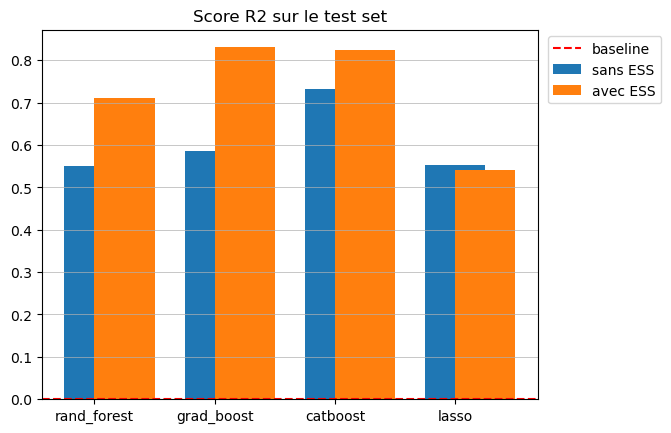

In [99]:
pos = list(range(4))
width = 0.5
plt.bar( x= comp1.columns,  height = comp1.iloc[1,:], width = width, label = 'sans ESS')
plt.bar(x= comp2.columns, height = comp2.iloc[1,:], width= width,align = 'edge',label = 'avec ESS')
plt.axhline(y=comparateur.iloc[1,0], color = 'red', linestyle='--',label='baseline')
plt.title('Score R2 sur le test set')
plt.legend(loc = (1.02,0.8))
plt.grid(axis = 'y',lw=0.5)
plt.show()

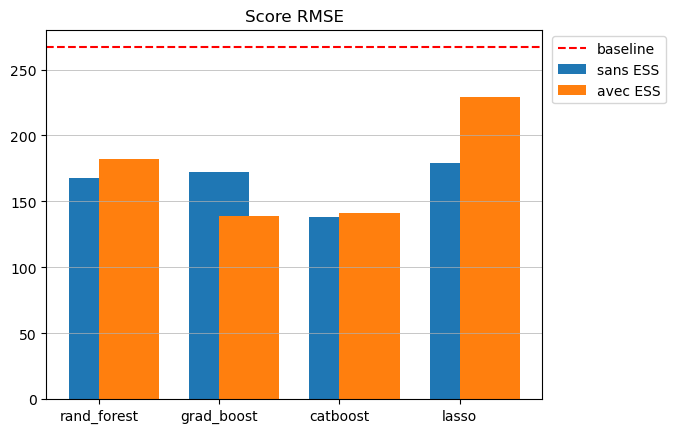

In [100]:
pos = list(range(4))
width = 0.5
plt.bar( x= comp1.columns,  height = comp1.iloc[2,:], width = width, label = 'sans ESS')
plt.bar(x= comp2.columns, height = comp2.iloc[2,:], width= width,align = 'edge',label = 'avec ESS')
plt.axhline(y=comparateur.iloc[2,0], color = 'red', linestyle='--',label='baseline')
plt.title('Score RMSE')
plt.legend(loc = (1.02,0.8))
plt.grid(axis = 'y',lw=0.5)
plt.show()

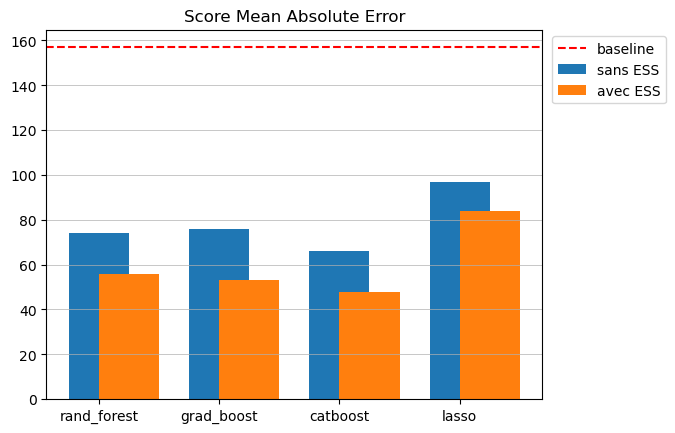

In [101]:
pos = list(range(4))
width = 0.5
plt.bar( x= comp1.columns,  height = comp1.iloc[3,:], width = width, label = 'sans ESS')
plt.bar(x= comp2.columns, height = comp2.iloc[3,:], width= width,align = 'edge',label = 'avec ESS')
plt.axhline(y=comparateur.iloc[3,0], color = 'red', linestyle='--',label='baseline')
plt.title('Score Mean Absolute Error')
plt.legend(loc = (1.02,0.8))
plt.grid(axis = 'y',lw=0.5)
plt.show()

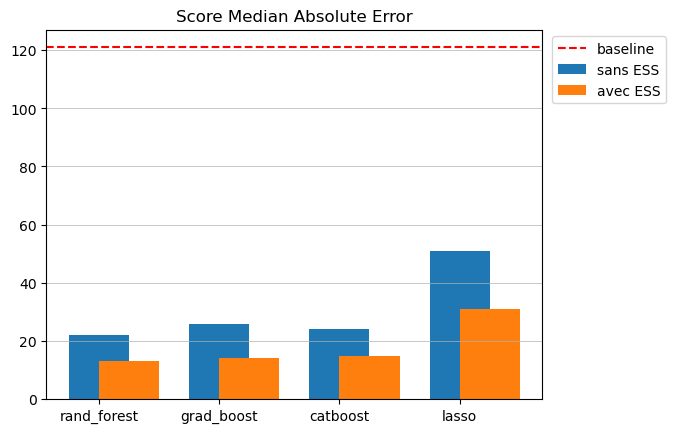

In [102]:
pos = list(range(4))
width = 0.5
plt.bar( x= comp1.columns,  height = comp1.iloc[4,:], width = width, label = 'sans ESS')
plt.bar(x= comp2.columns, height = comp2.iloc[4,:], width= width,align = 'edge',label = 'avec ESS')
plt.axhline(y=comparateur.iloc[4,0], color = 'red', linestyle='--',label='baseline')
plt.title('Score Median Absolute Error')
plt.legend(loc = (1.02,0.8))
plt.grid(axis = 'y',lw=0.5)
plt.show()

# <a name="9"> Valeurs shap

In [103]:
import shap


In [104]:
X_train_nrm = preprocessor1.fit_transform(X_train,y_train)

In [105]:
model = RandomForestRegressor(random_state = 0, criterion='poisson',n_estimators= 100)
model.fit(X_train_nrm,y_train)

RandomForestRegressor(criterion='poisson', random_state=0)

In [106]:
explainer = shap.explainers.Tree(model)


In [107]:
shap.initjs()

In [108]:
noms_col = preprocessor1.named_transformers_['onehotencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num + ['TotalGHGEmissions']

In [109]:
shap_values = explainer.shap_values(X_train_nrm[[0]])
shap.force_plot(explainer.expected_value[0], shap_values[0],
                feature_names = noms_col)

In [110]:
shap_values = explainer.shap_values(X_train_nrm[[1]])
shap.force_plot(explainer.expected_value[0], shap_values[0],
                feature_names = noms_col)

In [111]:
shap_values = explainer.shap_values(X_train_nrm[[2]])
shap.force_plot(explainer.expected_value[0], shap_values[0],
                feature_names = noms_col)